# Sequencial NN

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from config.config import *
from config.constants import *
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import accuracy_score,multilabel_confusion_matrix
from collections import Counter
from sklearn.model_selection import train_test_split

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [2]:
def plot_model(hist):
    fig, axs = plt.subplots(nrows=1, figsize=(11, 9))
    plt.rcParams['font.size'] = '14'

    for label in (axs.get_xticklabels() + axs.get_yticklabels()):
        label.set_fontsize(14)    

    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])

    axs.set_title('Model Accuracy')
    axs.set_ylabel('Accuracy', fontsize=14)
    axs.set_xlabel('Epoch', fontsize=14)
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    print("Model has training accuracy of {:.2f}%".format(hist.history['accuracy'][-1]*100))

In [3]:
def pre_process_split(path):
    
    dataset = pd.read_csv(path)
    dataset.dropna(inplace = True)
    
    # assigning new column names to the dataframe
    # dataset.columns = constants.cols + ['label']
    
    # creating training set ignoring labels
    train_data = dataset[dataset.columns[:-1]].values
    labels = dataset['label'].values
    n_class = len(set(labels))
    
    X_train, X_test, y_train, y_test =   train_test_split(train_data, labels, test_size=0.20)

    X_train = X_train.reshape(-1, 1, train_data.shape[1])
    X_test  = X_test.reshape(-1, 1, train_data.shape[1])
    y_train = y_train.reshape(-1, 1, 1)
    y_test = y_test.reshape(-1, 1, 1)
    
    return X_train, X_test, y_train, y_test, n_class

In [9]:
box_plot = None
def model_config_train(name,eps,bs,actvn,datalink):
    global box_plot
    print("processing dataset")
    X_train, X_test, y_train, y_test, n_class = pre_process_split(datalink)
    scaler = StandardScaler()    
    print(n_class)
    model = Sequential()
    model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(n_class, activation=actvn))
    print(model.summary())
       
    chk = ModelCheckpoint(name+'.pkl',save_best_only=True, mode='auto', verbose=1)
    print("saving as:",name+'.pkl')
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist = model.fit(X_train, y_train, epochs=eps, batch_size=bs, callbacks=[chk], validation_split=0.2)    
    plot_model(hist)
    
    return model

## Loading dataset for binary classifier

In [19]:
def plotter(plot_data,unique_labels,n_plots):
    
    data = plot_data.copy()
    predicted_labels = data['label']
    #print(len(set(predicted_labels)),unique_labels)
    #print(Counter(predicted_labels).values(),[unique_labels[each] for each in Counter(predicted_labels).keys()])
    
    matrics = sorted(zip([unique_labels[each] for each in Counter(predicted_labels).keys()],Counter(predicted_labels).values() ), key=lambda x: x[1])
    cols = ['A'+str(each+1) for each in range(int(col_len/2))] + ['V'+str(each+1) for each in range(int(col_len/2))]
    score = [list(j) for j in matrics][::-1]
    
    
    
    total = sum([i[1] for i in score])

    c=0
    for i in score:

        score[c][1] = str(round(i[1]*100/total,2))+"%"
        #print("Fault type:", i[-1], "Percentage: {:.2f}%".format(i[1]*100/total))
        c+=1

    print(pd.DataFrame.from_records(score,columns=['Fault type','Percentage']))
    
    #print("changing numbers to labels again")
    data['label'] = [unique_labels[i] for i in predicted_labels]

    fig, ax = plt.subplots(n_plots,figsize=(15,4*n_plots))

    for j in range(n_plots):

        legend_list = []
        for i in range(len(set(predicted_labels))):

            extract = data[data.label==unique_labels[i]][cols[j]]    

            #print(len(extract))
            if unique_labels[i]==score[0][0] and score[0][0]!='NML' or unique_labels[i]== 'FAULT':
                temp = ax[j].scatter(extract.index,extract,marker='+',s=40)
            else:
                temp = ax[j].scatter(extract.index,extract,marker='.',s=10)


            legend_list.append(temp)

        ax[j].legend(legend_list,unique_labels,scatterpoints=3,ncol=1,fontsize=15)

    fig.tight_layout()
    plt.show()

    return score[0][0]

In [6]:
def tester(model,frame):
    
    data = frame
    
    cols = ['A'+str(each+1) for each in range(int(col_len/2))] + ['V'+str(each+1) for each in range(int(col_len/2))]
    
    if data.shape[1]==6:
        data.columns = cols
    elif data.shape[1]==7:
        data.columns = cols + ['label']
        data = data[cols]
    else:
        print("columns length is ",data.shape[1])
    
    
    test_preds = model.predict(data.values.reshape(-1,1,6).tolist())
    predicted_labels = np.argmax(test_preds,axis=1)
    
    data['label'] = predicted_labels
    
    return data
    

## Testing the models

In [7]:
model_config_train('binary_clf',20,2000,'softmax','./KMTrainingSet/binary/bin_dataset_simulink.csv')

processing dataset
2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               42800     
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 43,002
Trainable params: 43,002
Non-trainable params: 0
_________________________________________________________________
None
saving as: binary_clf.pkl
Epoch 1/20


KeyboardInterrupt: 

processing dataset
11
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               42800     
_________________________________________________________________
dense_3 (Dense)              (None, 11)                1111      
Total params: 43,911
Trainable params: 43,911
Non-trainable params: 0
_________________________________________________________________
None
saving as: multi_clf.pkl
Epoch 1/10
92/92 [==============================] - 3s 17ms/step - loss: 1.7594 - accuracy: 0.5488 - val_loss: 0.7745 - val_accuracy: 0.8788

Epoch 00001: val_loss improved from inf to 0.77448, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 2/10
92/92 [==============================] - 1s 12ms/step - loss: 0.6094 - accuracy: 0.8813 - val_loss: 0.3608 - val_accuracy: 0.8821

Epoch 00002: val_loss improved from 0.77448 to 0.36077, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 3/10
92/92 [==============================] - 1s 12ms/step - loss: 0.3292 - accuracy: 0.8847 - val_loss: 0.2689 - val_accuracy: 0.8835

Epoch 00003: val_loss improved from 0.36077 to 0.26890, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 4/10
92/92 [==============================] - 1s 12ms/step - loss: 0.2598 - accuracy: 0.8864 - val_loss: 0.2400 - val_accuracy: 0.8852

Epoch 00004: val_loss improved from 0.26890 to 0.24000, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 5/10
92/92 [==============================] - 1s 12ms/step - loss: 0.2358 - accuracy: 0.8861 - val_loss: 0.2262 - val_accuracy: 0.8846

Epoch 00005: val_loss improved from 0.24000 to 0.22620, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 6/10
92/92 [==============================] - 1s 12ms/step - loss: 0.2233 - accuracy: 0.8882 - val_loss: 0.2168 - val_accuracy: 0.8856

Epoch 00006: val_loss improved from 0.22620 to 0.21683, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 7/10
92/92 [==============================] - 1s 12ms/step - loss: 0.2150 - accuracy: 0.8892 - val_loss: 0.2115 - val_accuracy: 0.8873

Epoch 00007: val_loss improved from 0.21683 to 0.21153, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 8/10
92/92 [==============================] - 1s 12ms/step - loss: 0.2101 - accuracy: 0.8899 - val_loss: 0.2084 - val_accuracy: 0.8861

Epoch 00008: val_loss improved from 0.21153 to 0.20840, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 9/10
92/92 [==============================] - 1s 11ms/step - loss: 0.2077 - accuracy: 0.8904 - val_loss: 0.2063 - val_accuracy: 0.8879

Epoch 00009: val_loss improved from 0.20840 to 0.20627, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 10/10
92/92 [==============================] - 1s 12ms/step - loss: 0.2039 - accuracy: 0.8920 - val_loss: 0.2046 - val_accuracy: 0.8863

Epoch 00010: val_loss improved from 0.20627 to 0.20458, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


[[[    0     0]
  [52083  5410]]

 [[53346  4147]
  [    0     0]]

 [[53340  4153]
  [    0     0]]

 [[45602 11891]
  [    0     0]]

 [[51856  5637]
  [    0     0]]

 [[54813  2680]
  [    0     0]]

 [[52233  5260]
  [    0     0]]

 [[50591  6902]
  [    0     0]]

 [[52284  5209]
  [    0     0]]

 [[52394  5099]
  [    0     0]]

 [[56388  1105]
  [    0     0]]]


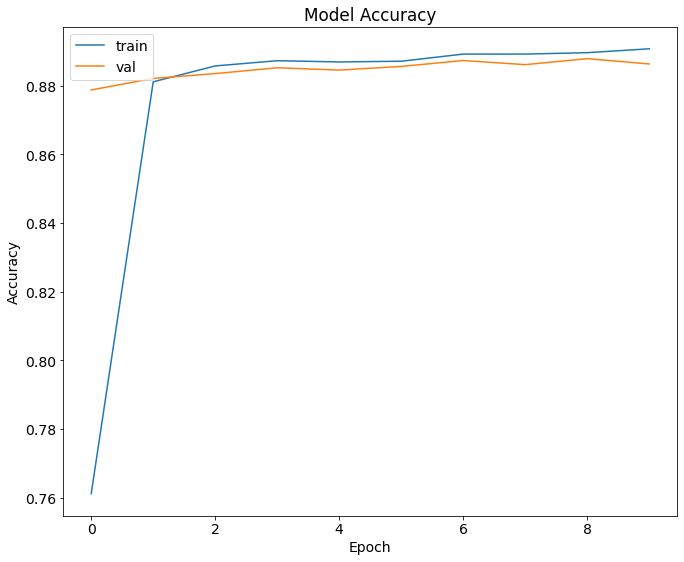

Model has training accuracy of 89.08%


In [12]:
model_config_train('multi_clf',10,2000,'softmax','./KMTrainingSet/multi/mul_dataset_simulink.csv')

In [14]:
binary_labels_list = ['NML','FAULT']
binary_model = load_model('binary_clf.pkl')

In [15]:
multi_labels_list = ['AB', 'AC', 'BC', 'ABC', 'AG', 'BG', 'ABG', 'CG', 'ACG', 'BCG', 'ABCG']
multi_model = load_model('multi_clf.pkl')

In [16]:
import os

In [17]:
# current directory
path = "./TrainingSet/"

# list of file of the given path is assigned to the variable 
file_list = [each for each in list(os.walk(path))[0][-1] if ".csv" in each]


.
.
 5ABCG.csv
  Fault type Percentage
0        NML     97.64%
1      FAULT      2.35%


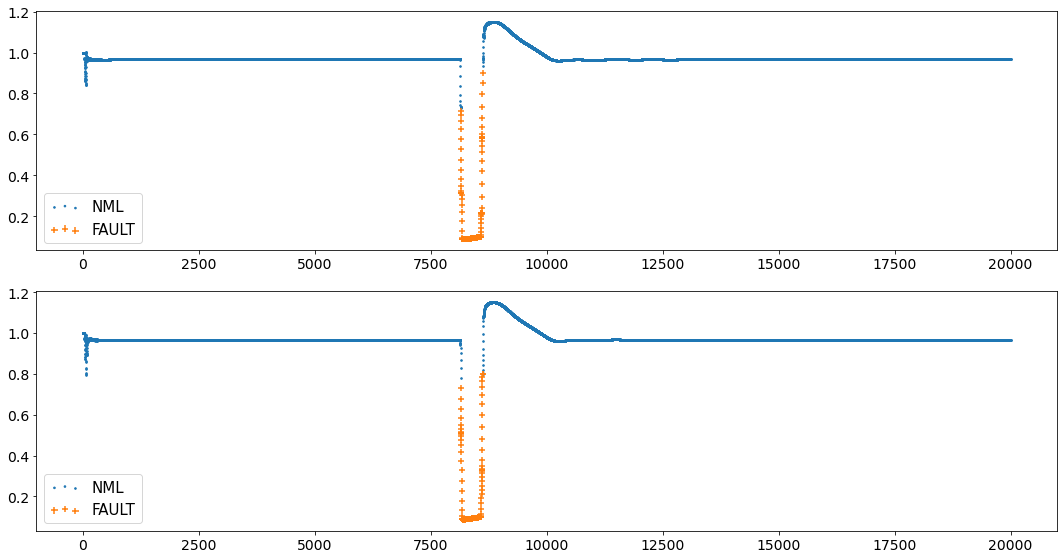

  Fault type Percentage
0        ABC     79.19%
1       ABCG     16.77%
2        BCG       1.7%
3        ACG       1.7%
4        ABG      0.64%


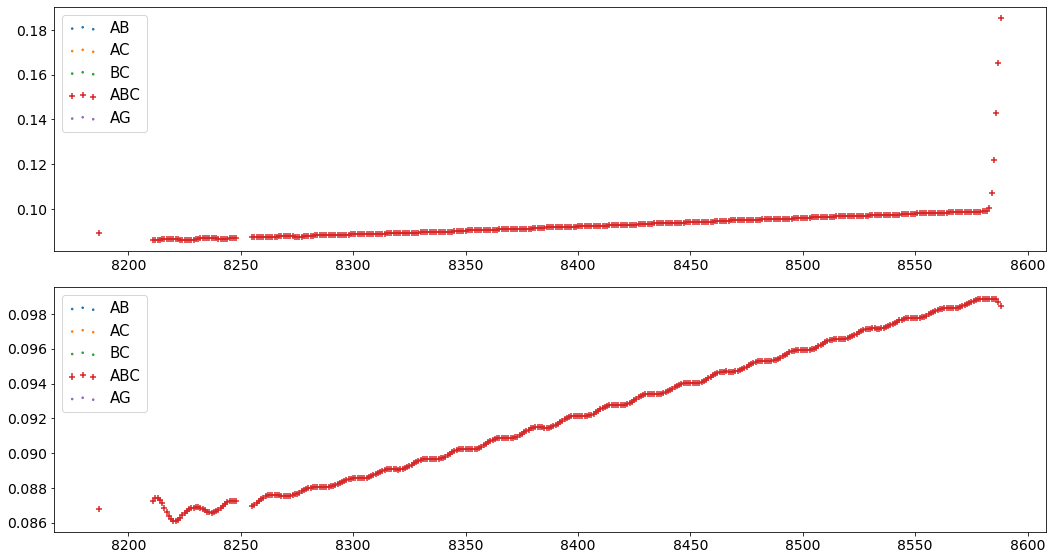


.
.
 10ABG.csv
  Fault type Percentage
0        NML     99.62%
1      FAULT      0.38%


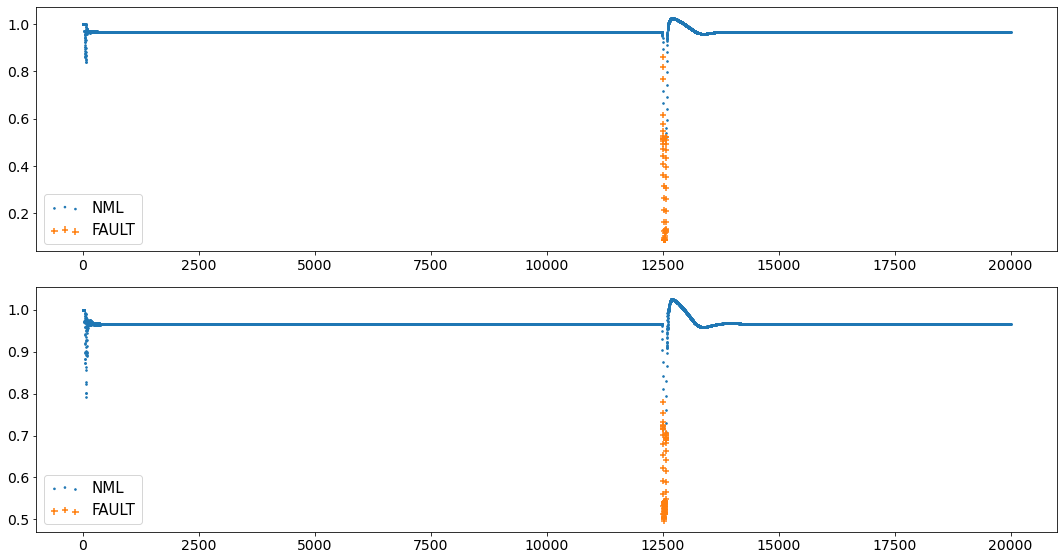

  Fault type Percentage
0        ABG     93.42%
1        BCG      3.95%
2       ABCG      2.63%


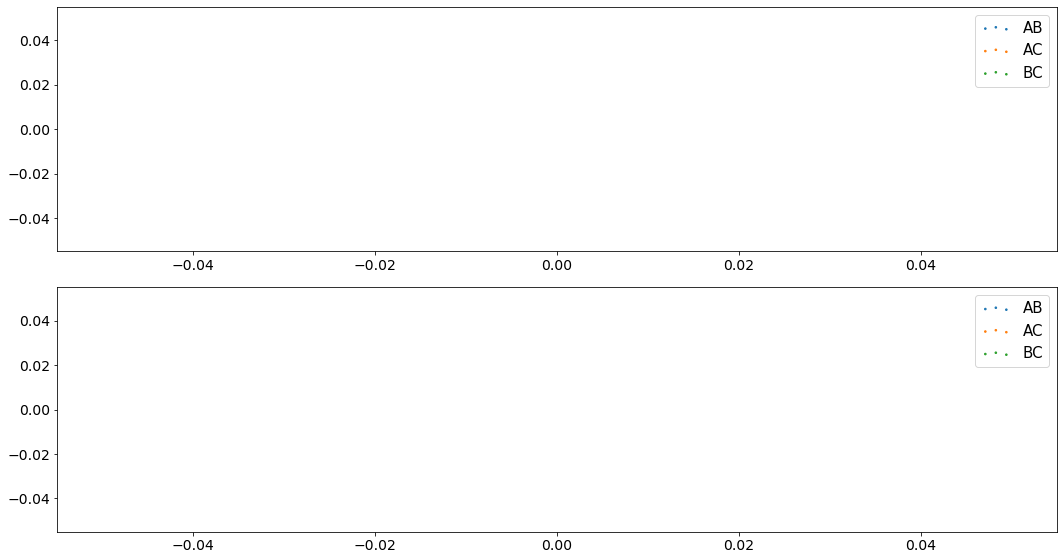


.
.
 3BC.csv
  Fault type Percentage
0        NML     99.81%
1      FAULT      0.19%


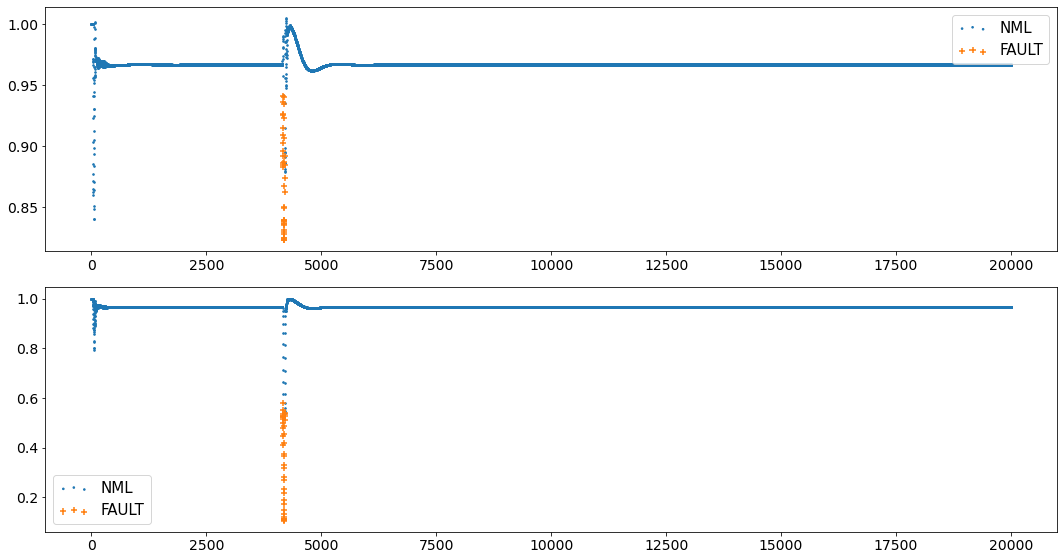

  Fault type Percentage
0         BC     97.37%
1        BCG      2.63%


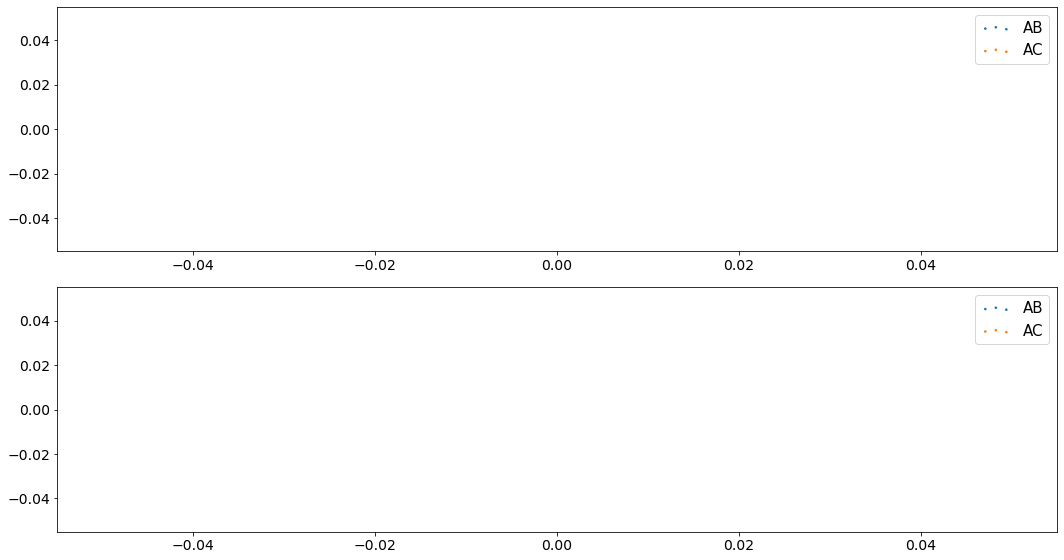


.
.
 3CG.csv
  Fault type Percentage
0        NML      85.8%
1      FAULT      14.2%


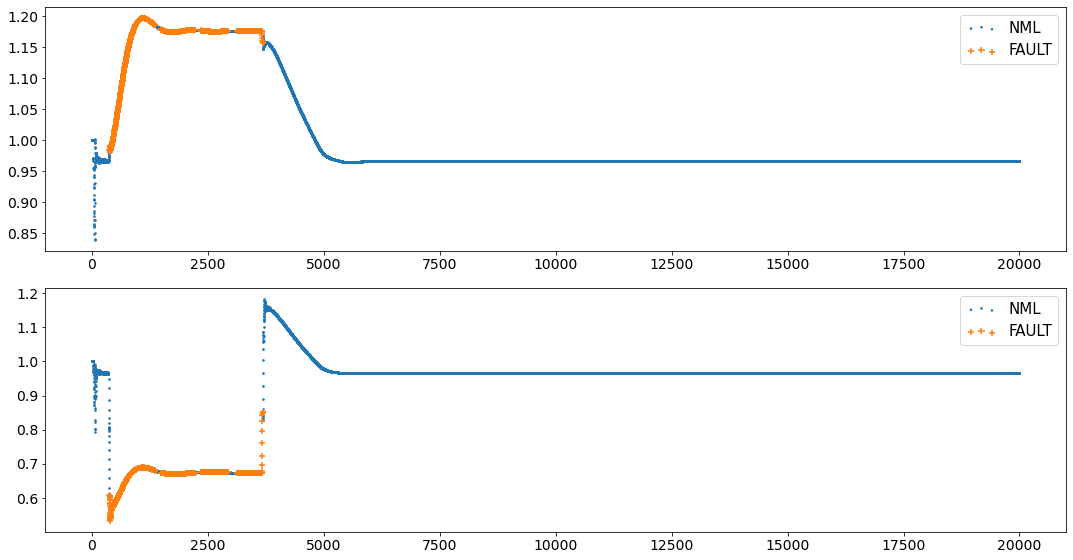

  Fault type Percentage
0         CG     100.0%


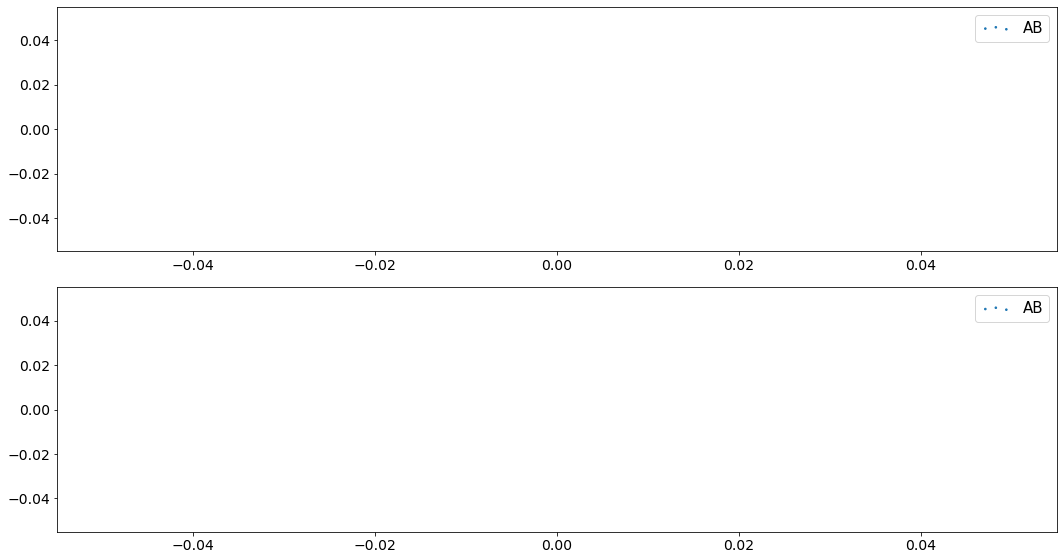


.
.
 1BCG.csv
  Fault type Percentage
0        NML      98.9%
1      FAULT       1.1%


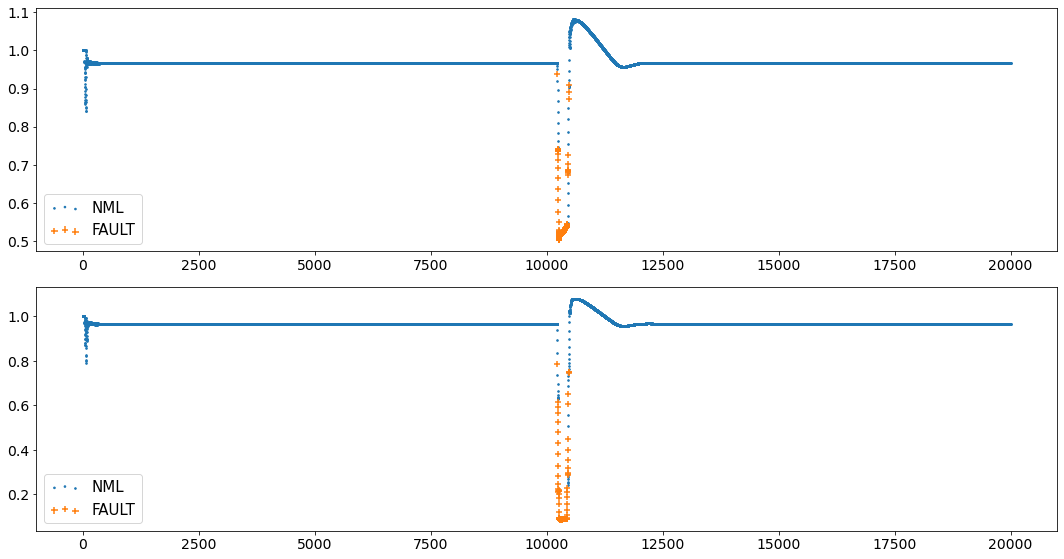

  Fault type Percentage
0        BCG     98.64%
1         BG      1.36%


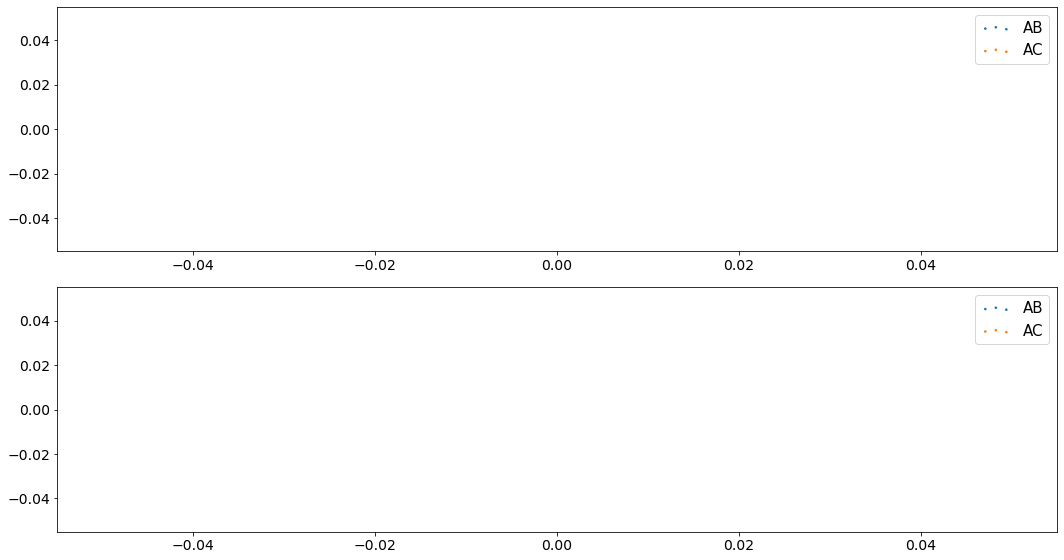


.
.
 7BG.csv
  Fault type Percentage
0        NML     87.78%
1      FAULT     12.22%


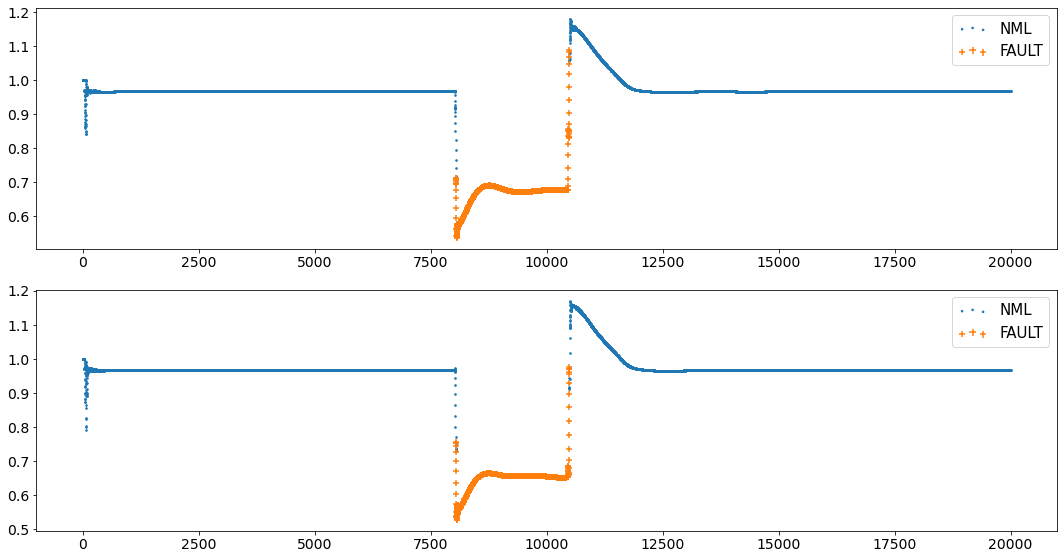

  Fault type Percentage
0         BG     100.0%


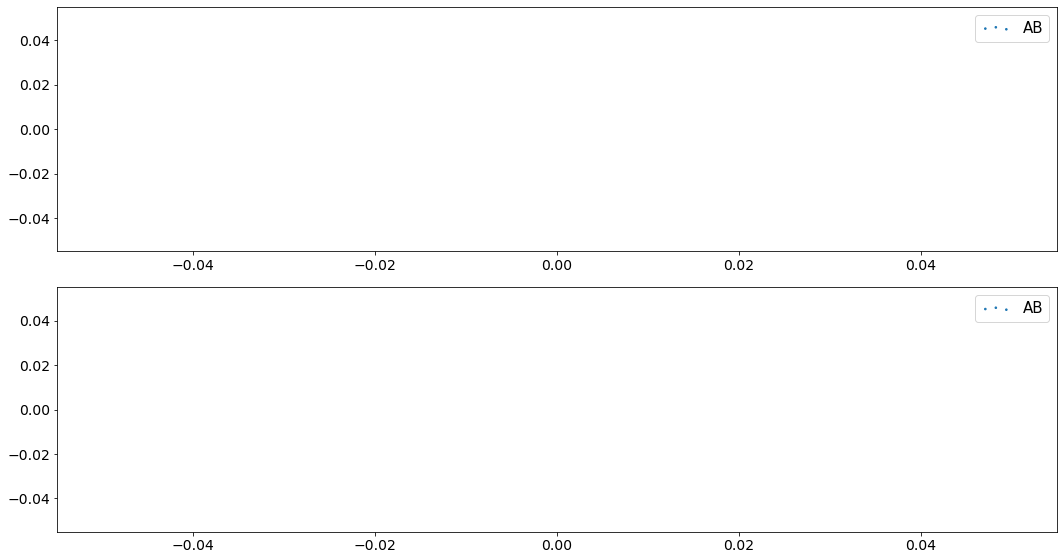


.
.
 5BG.csv
  Fault type Percentage
0        NML     61.34%
1      FAULT     38.66%


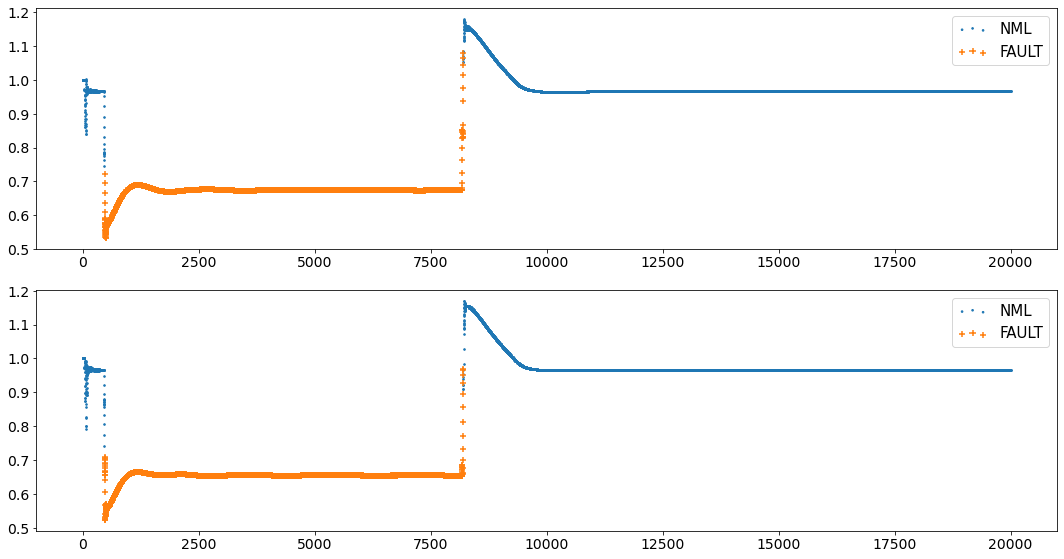

  Fault type Percentage
0         BG     100.0%


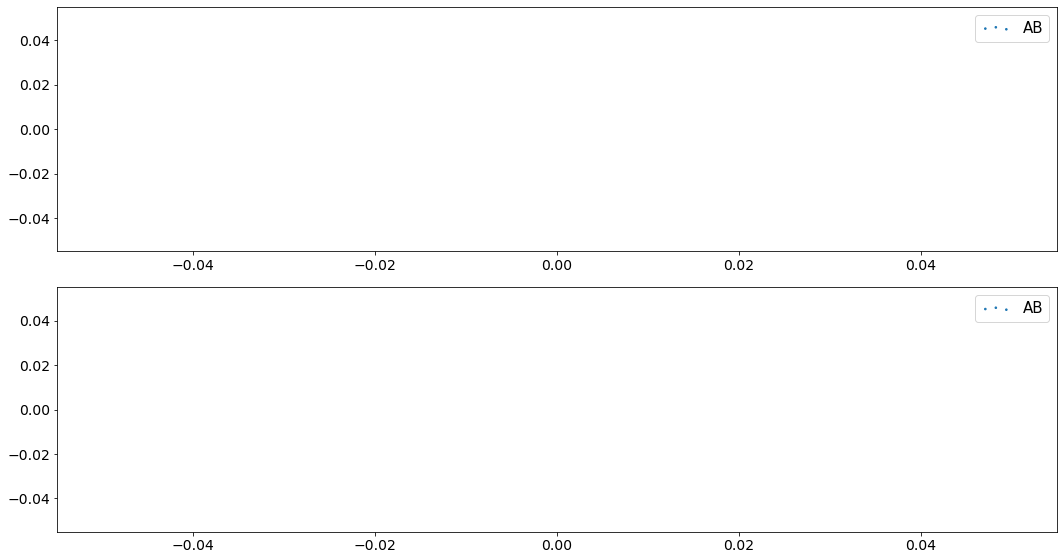


.
.
 9ABG.csv
  Fault type Percentage
0        NML     98.34%
1      FAULT      1.66%


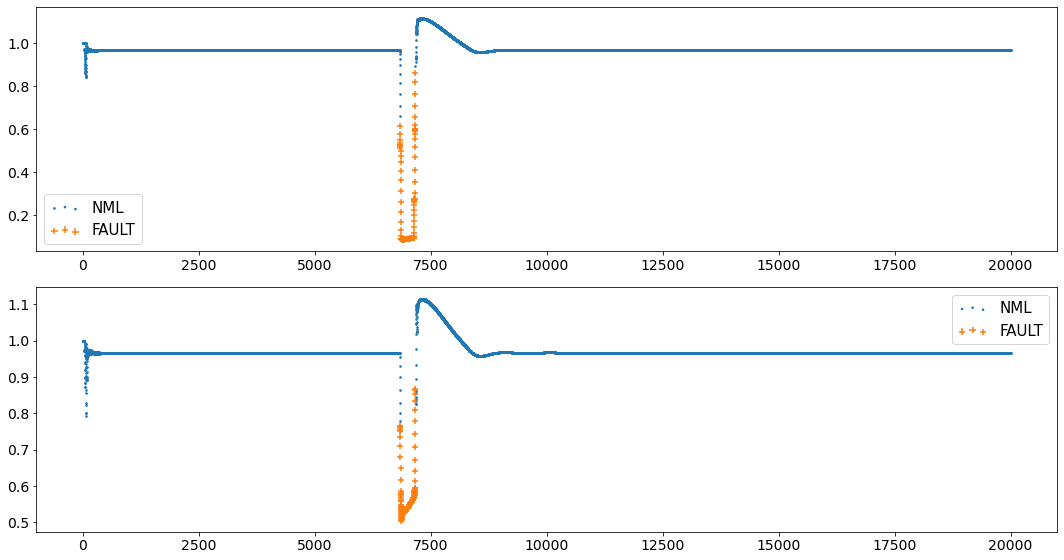

  Fault type Percentage
0        ABG     95.18%
1         BG      2.71%
2         AB       1.2%
3        BCG       0.9%


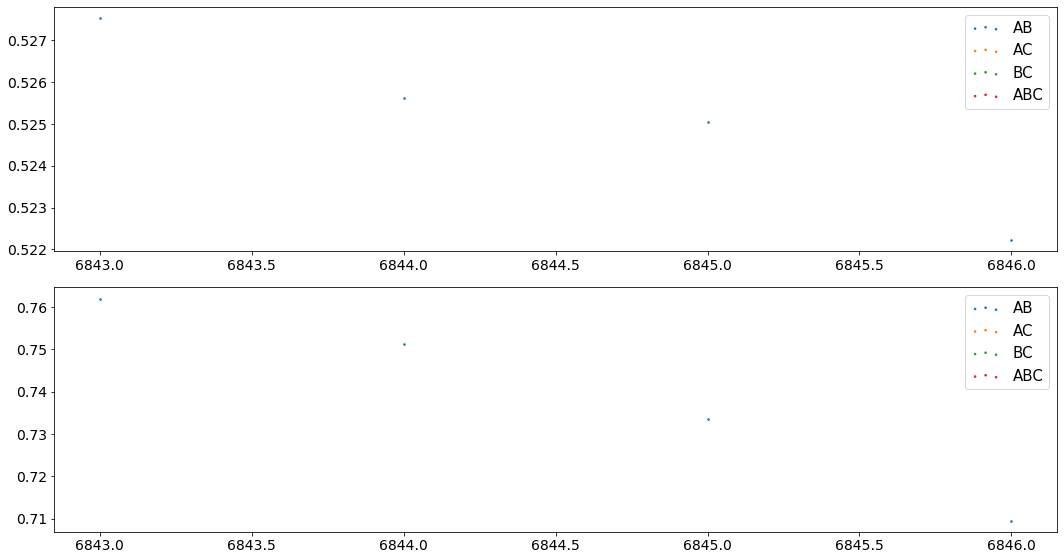


.
.
 1BC.csv
  Fault type Percentage
0        NML      74.7%
1      FAULT      25.3%


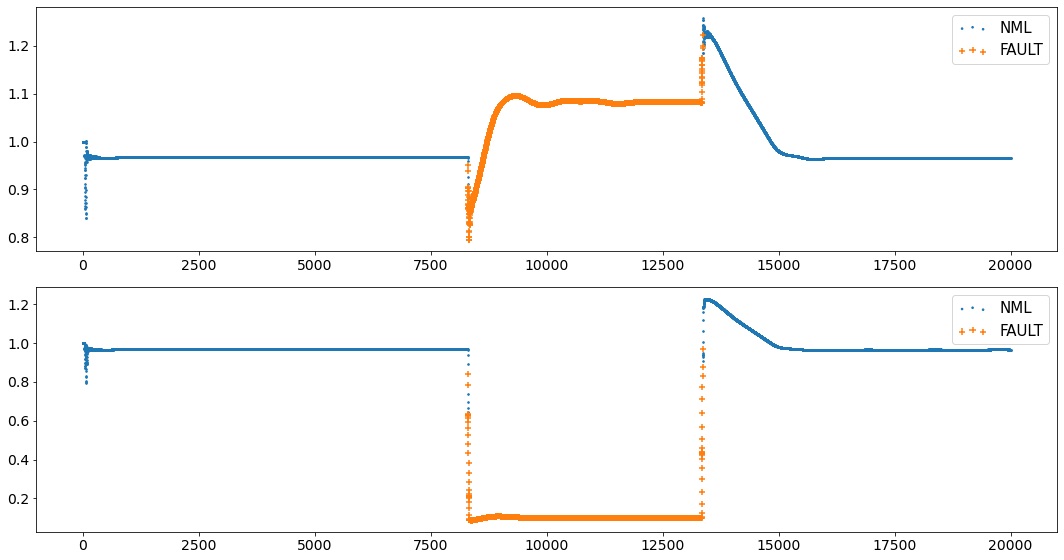

  Fault type Percentage
0         BC      99.9%
1        BCG      0.06%
2         AB      0.02%
3       ABCG      0.02%


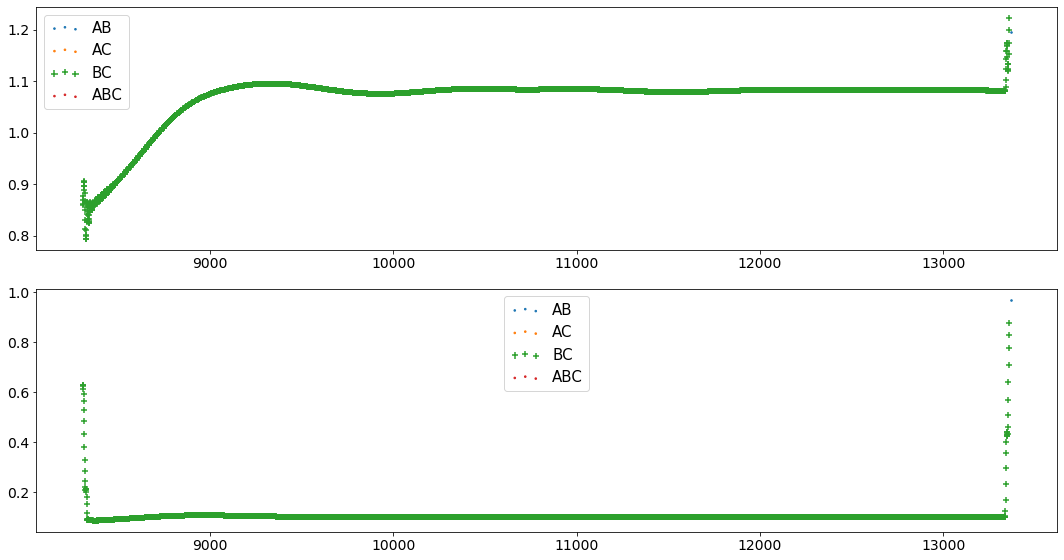


.
.
 1CG.csv
  Fault type Percentage
0        NML      99.2%
1      FAULT       0.8%


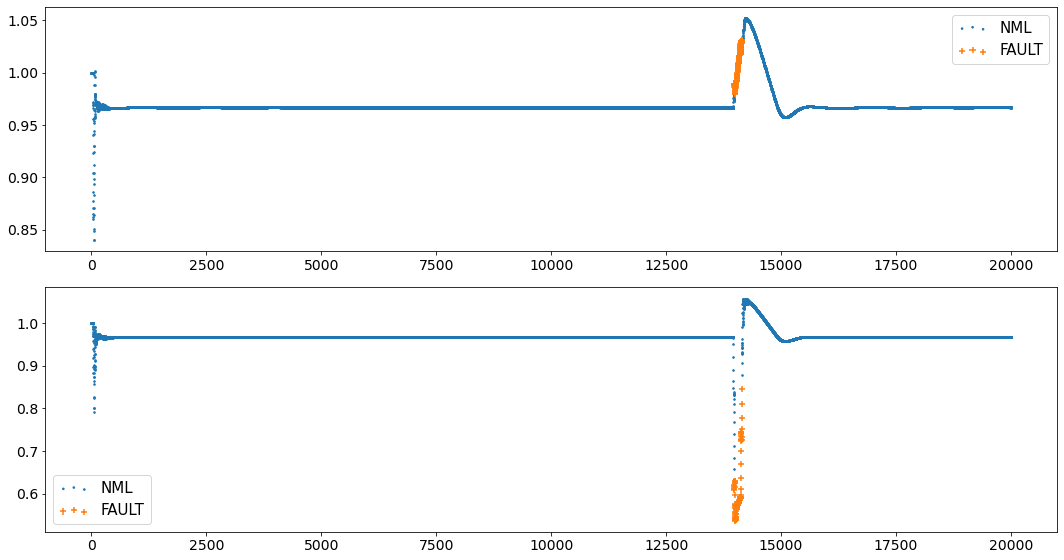

  Fault type Percentage
0         CG     100.0%


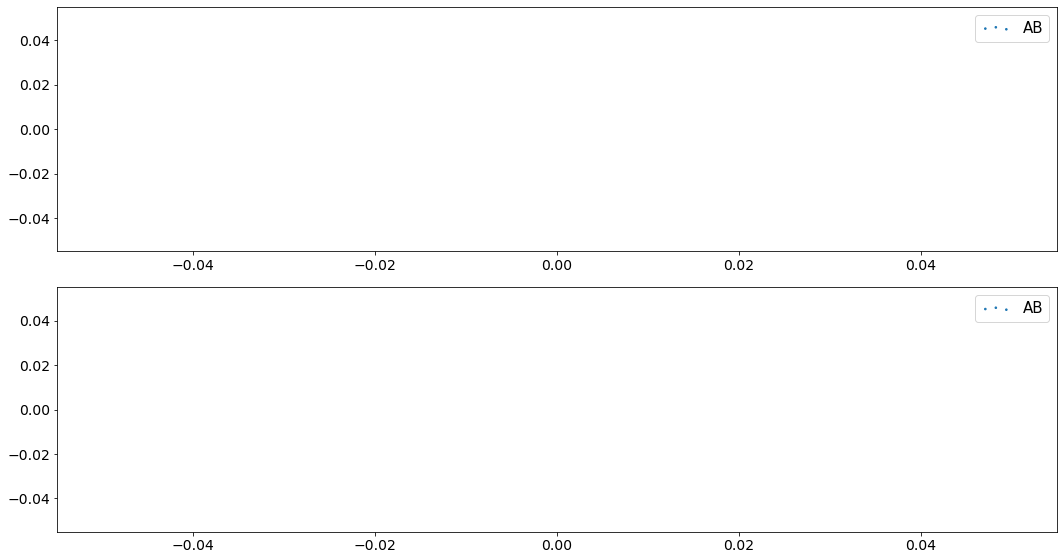


.
.
 5ABG.csv
  Fault type Percentage
0        NML     77.47%
1      FAULT     22.54%


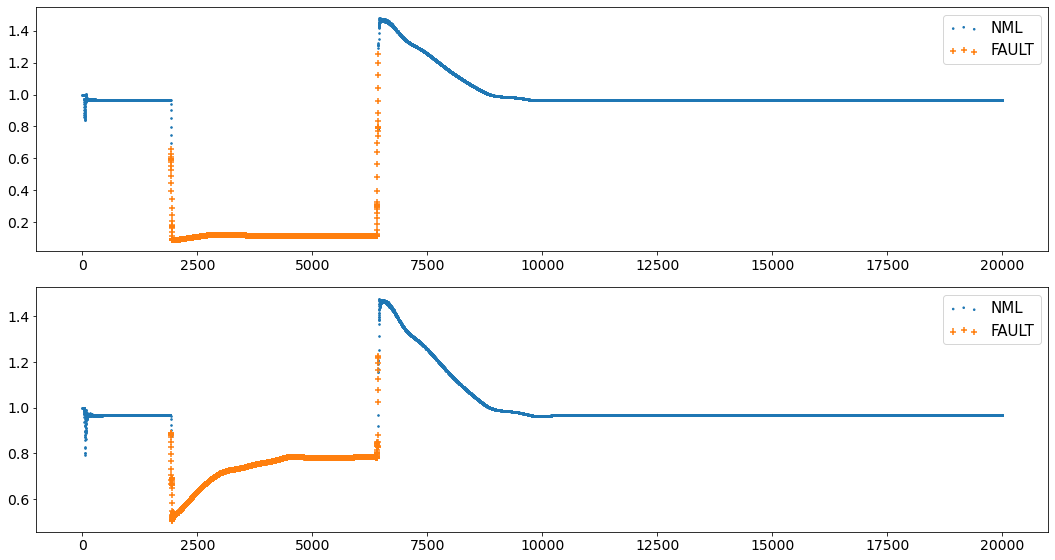

  Fault type Percentage
0        ABG     99.67%
1         BG      0.18%
2         AB      0.16%


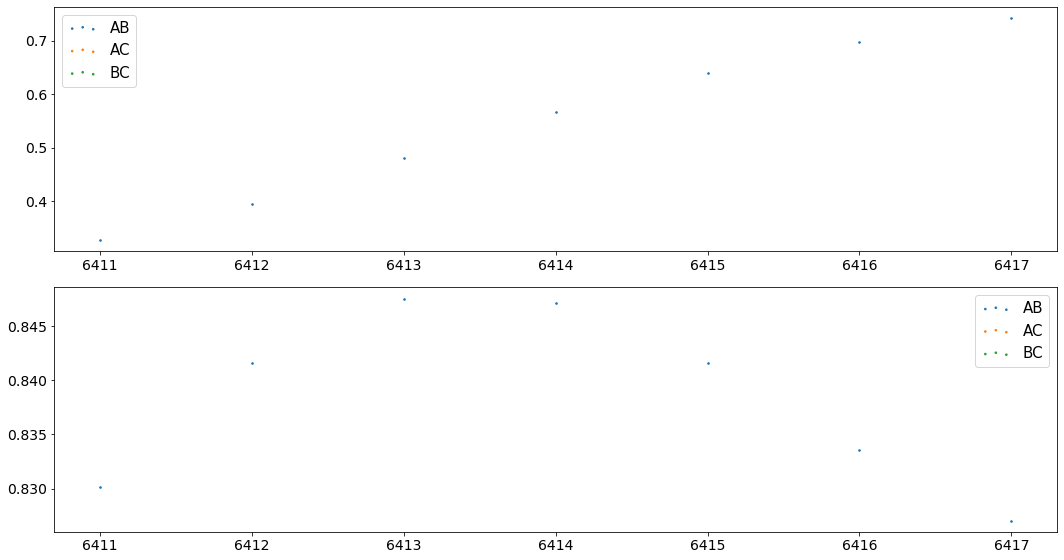


.
.
 9AG.csv
  Fault type Percentage
0        NML     66.92%
1      FAULT     33.09%


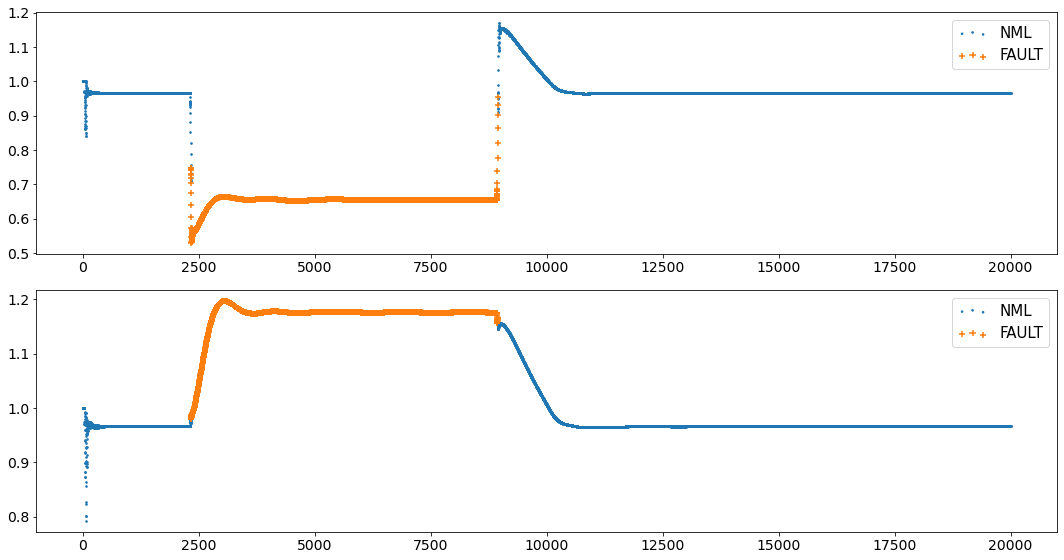

  Fault type Percentage
0         AG     100.0%


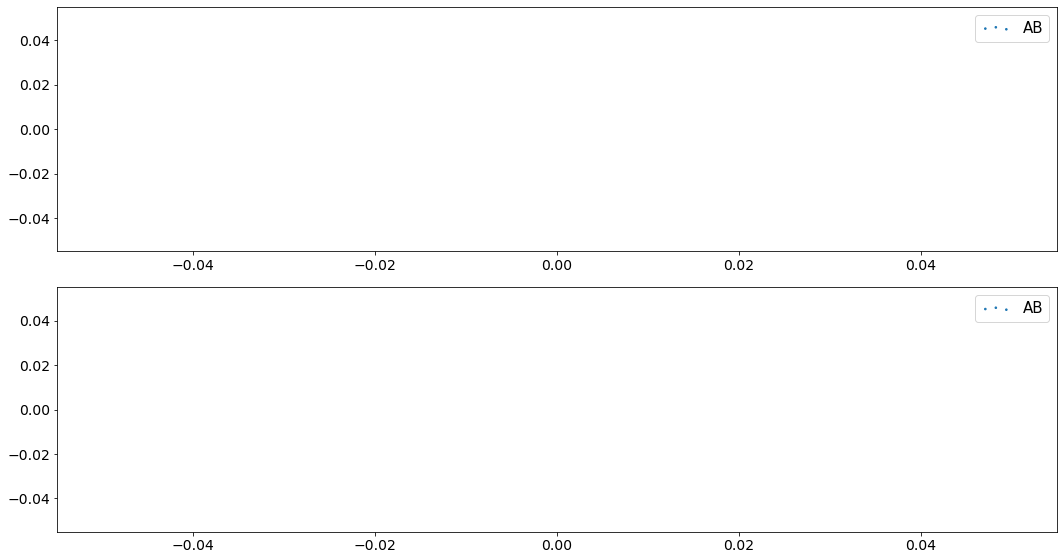


.
.
 7ABC.csv
  Fault type Percentage
0        NML     72.33%
1      FAULT     27.67%


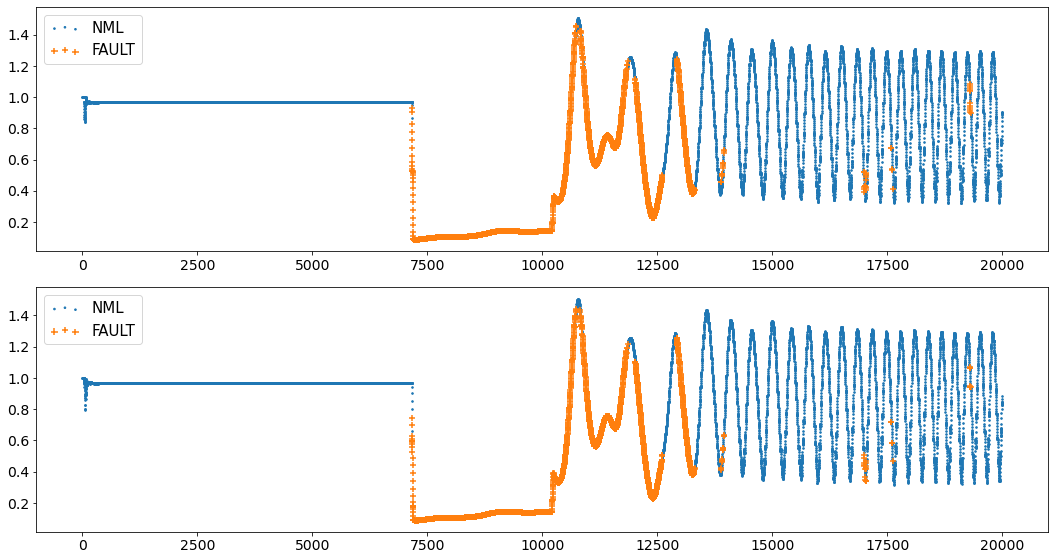

  Fault type Percentage
0        ABC     84.44%
1       ABCG     15.36%
2        BCG      0.18%
3        ABG      0.02%


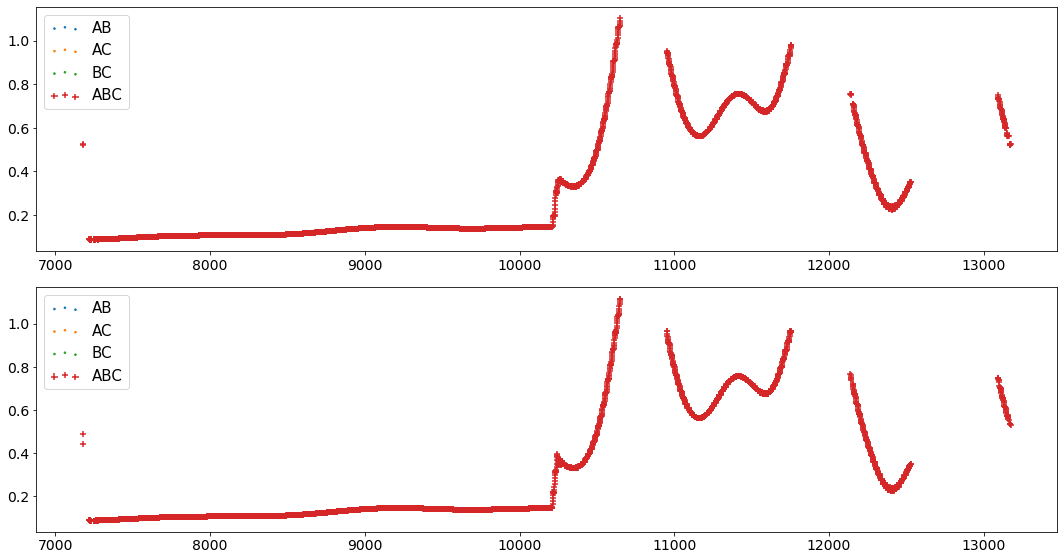


.
.
 7ACG.csv
  Fault type Percentage
0        NML     95.36%
1      FAULT      4.63%


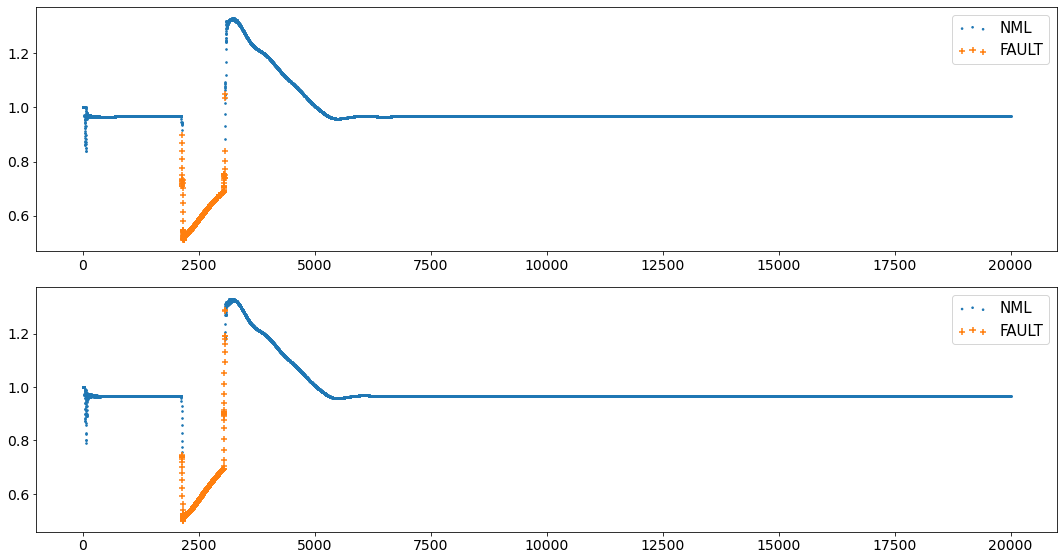

  Fault type Percentage
0        ACG     99.03%
1       ABCG      0.65%
2         CG      0.32%


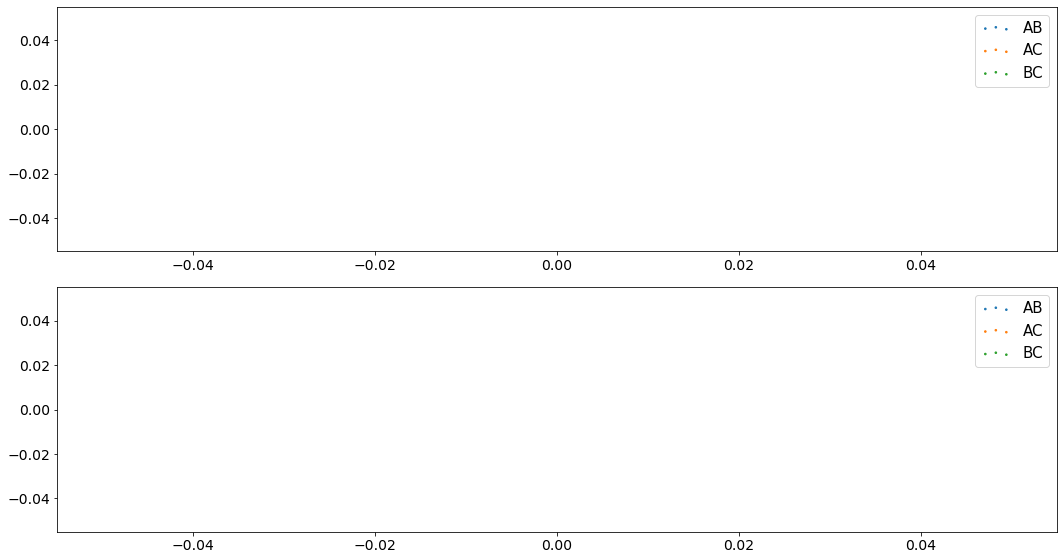


.
.
 7ABG.csv
  Fault type Percentage
0        NML     99.46%
1      FAULT      0.54%


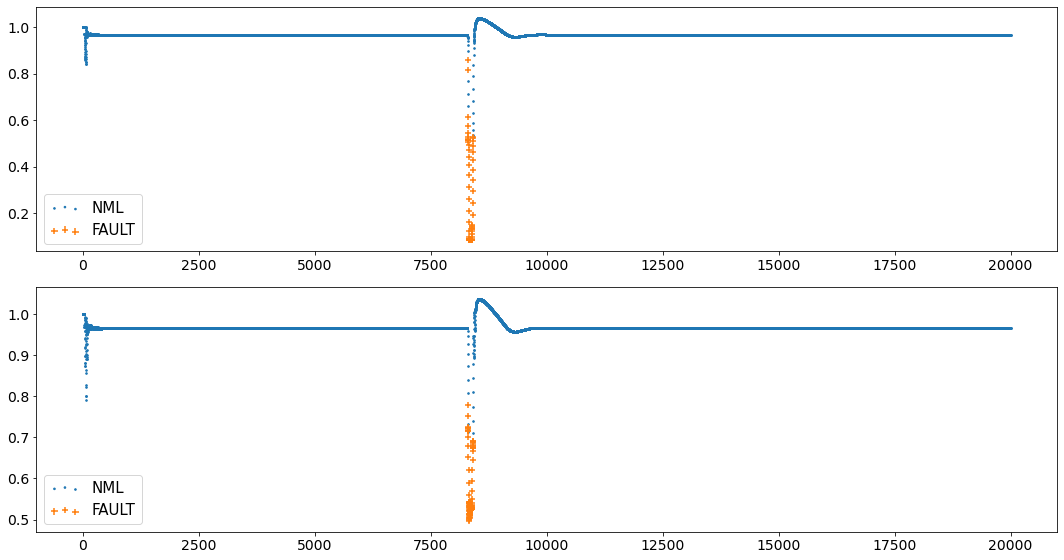

  Fault type Percentage
0        ABG      96.3%
1        BCG      2.78%
2       ABCG      0.93%


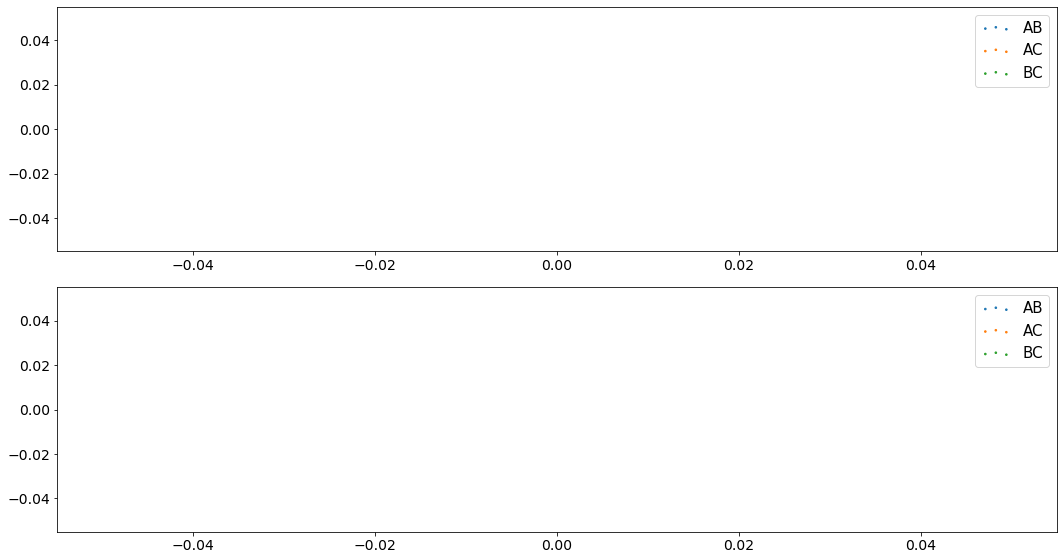


.
.
 9AC.csv
  Fault type Percentage
0        NML      98.0%
1      FAULT       2.0%


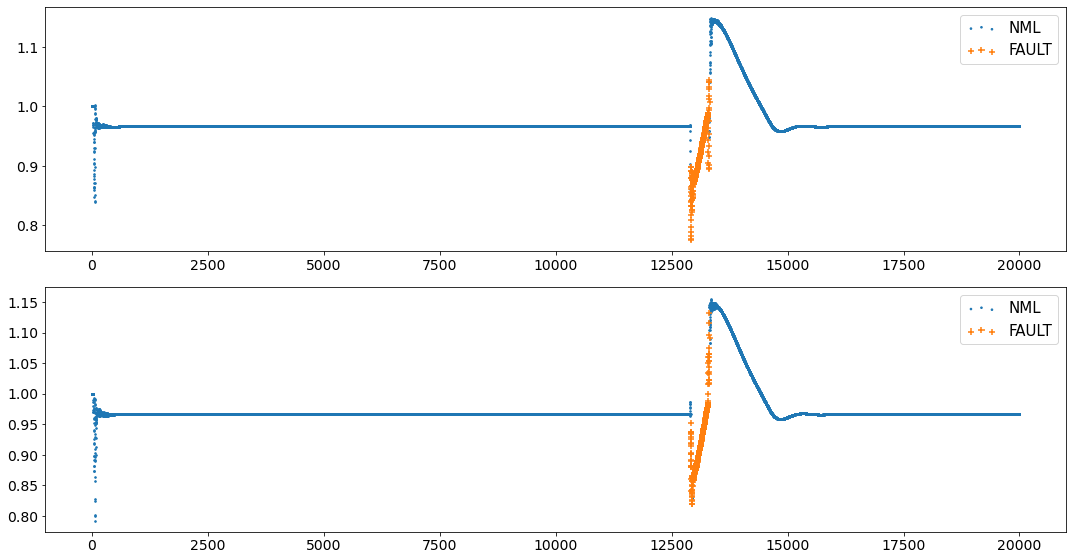

  Fault type Percentage
0         AC     96.01%
1        ACG      3.74%
2       ABCG      0.25%


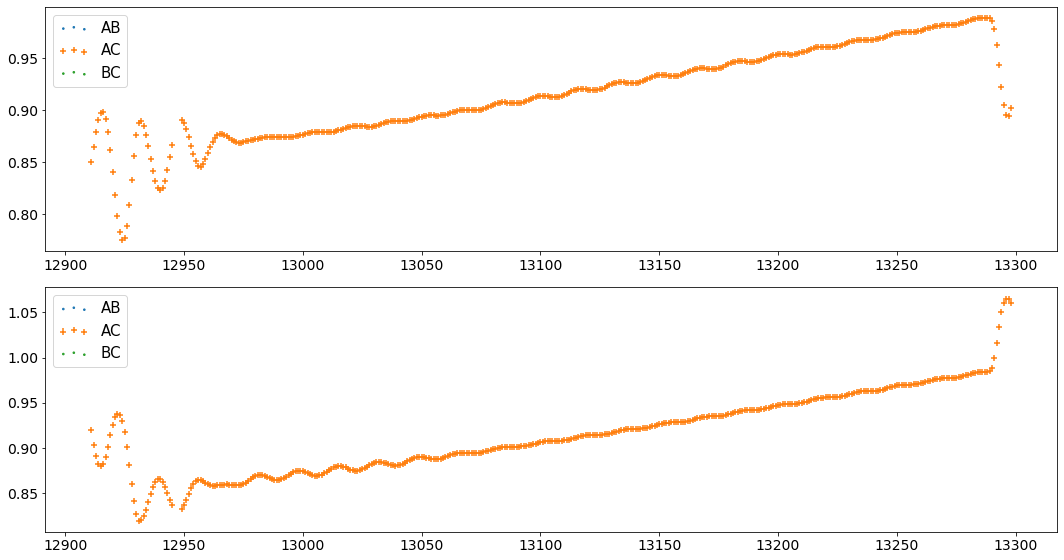


.
.
 1BG.csv
  Fault type Percentage
0        NML     86.91%
1      FAULT      13.1%


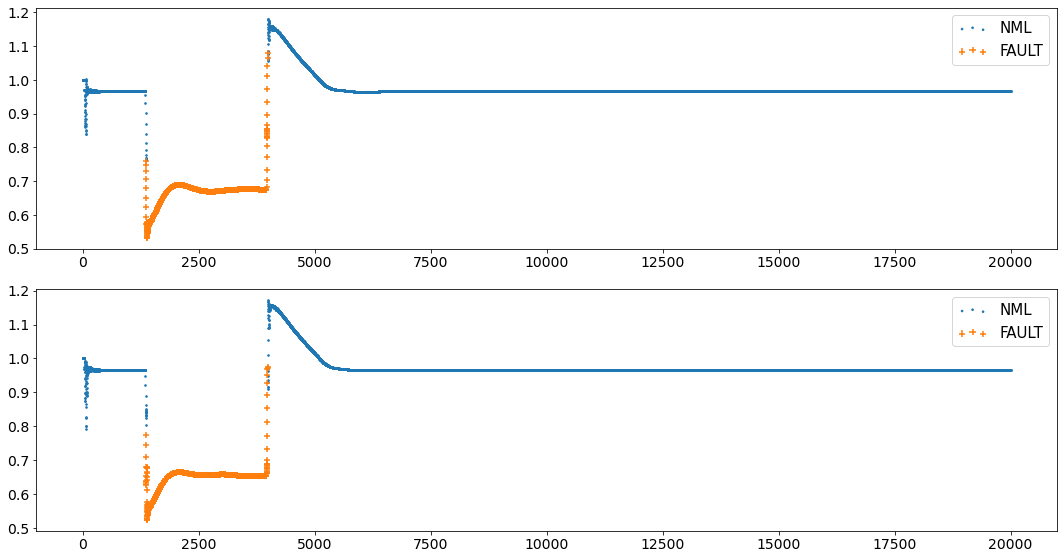

  Fault type Percentage
0         BG     100.0%


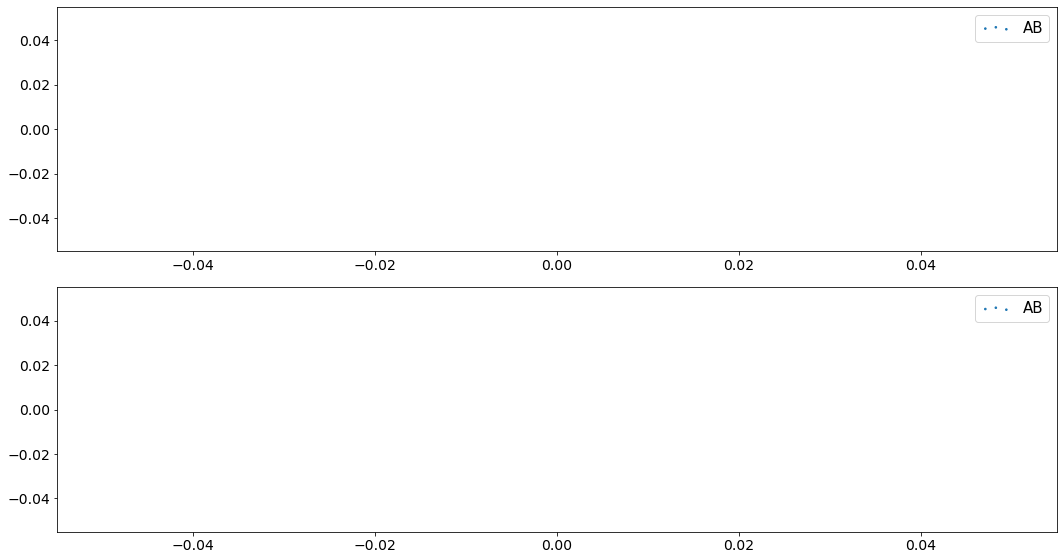


.
.
 5ABC.csv
  Fault type Percentage
0        NML     68.89%
1      FAULT     31.11%


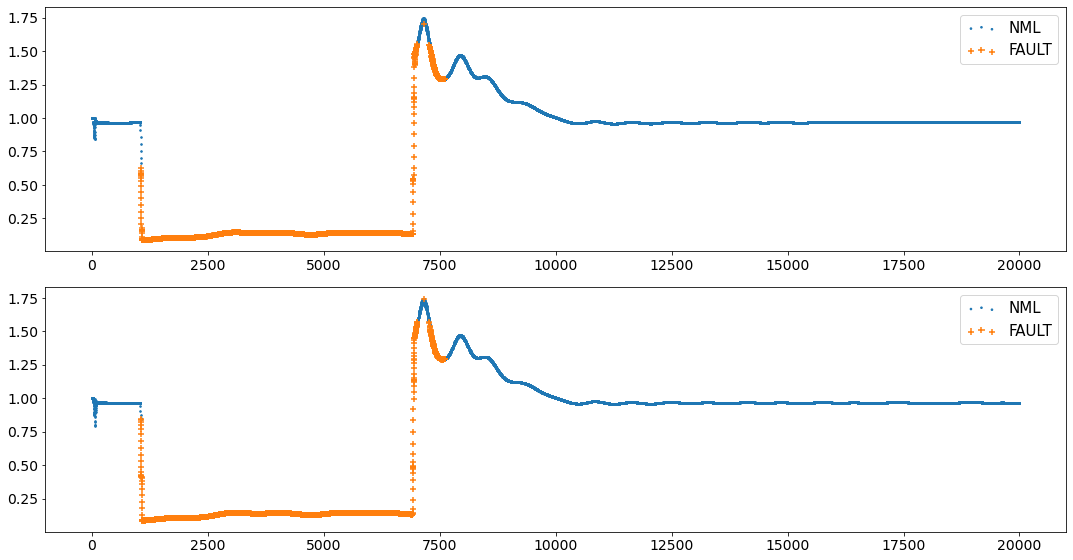

  Fault type Percentage
0        ABC      93.2%
1       ABCG      6.67%
2        ABG      0.11%
3         CG      0.02%


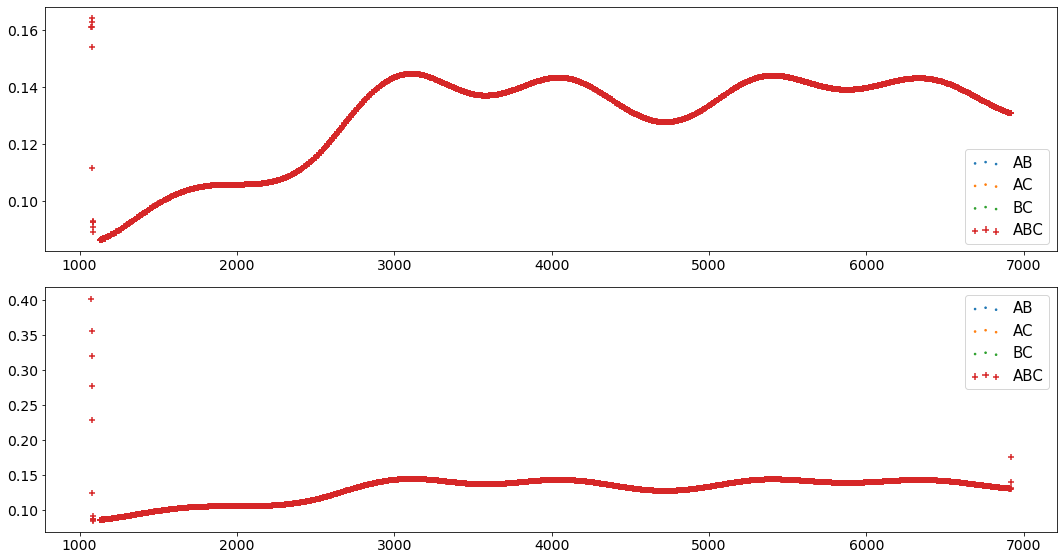


.
.
 5ACG.csv
  Fault type Percentage
0        NML     98.88%
1      FAULT      1.12%


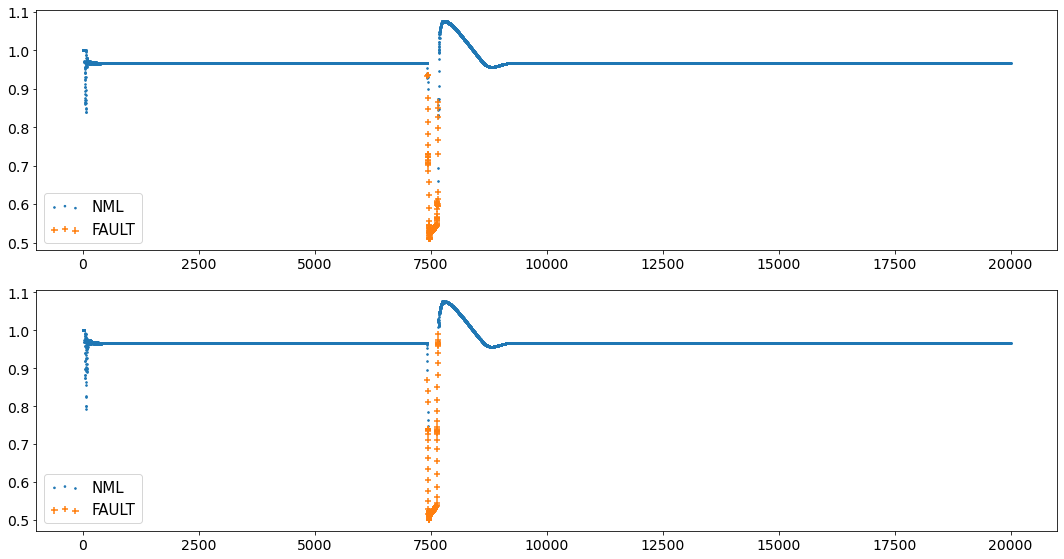

  Fault type Percentage
0        ACG     97.33%
1         AG      2.67%


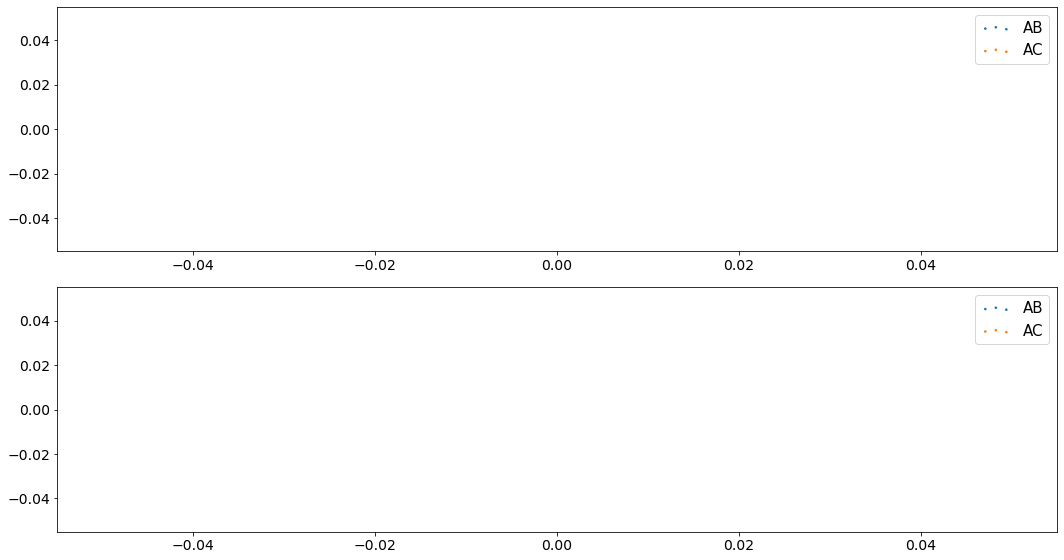


.
.
 9AB.csv
  Fault type Percentage
0        NML     79.62%
1      FAULT     20.38%


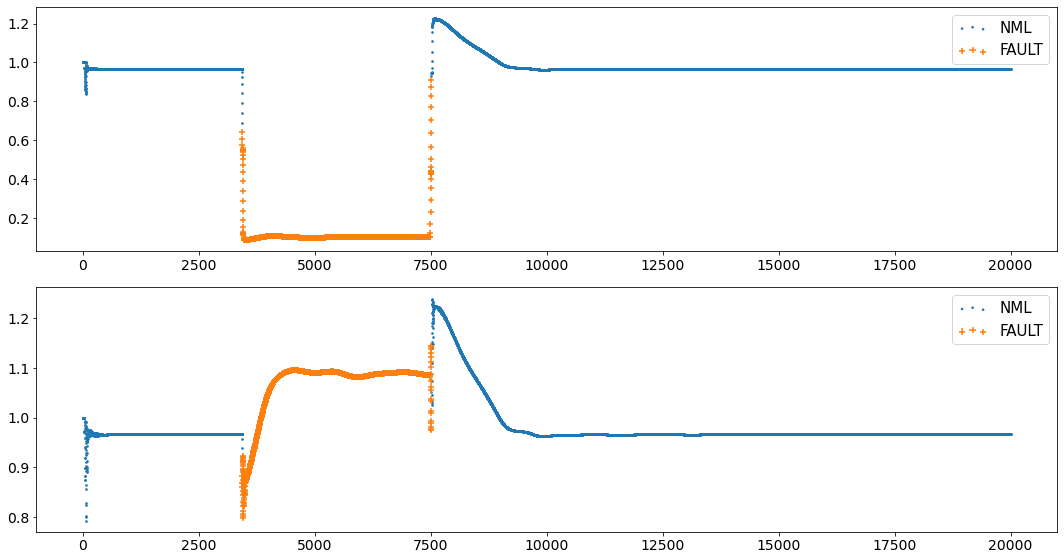

  Fault type Percentage
0         AB      99.9%
1       ABCG      0.07%
2        ABG      0.02%


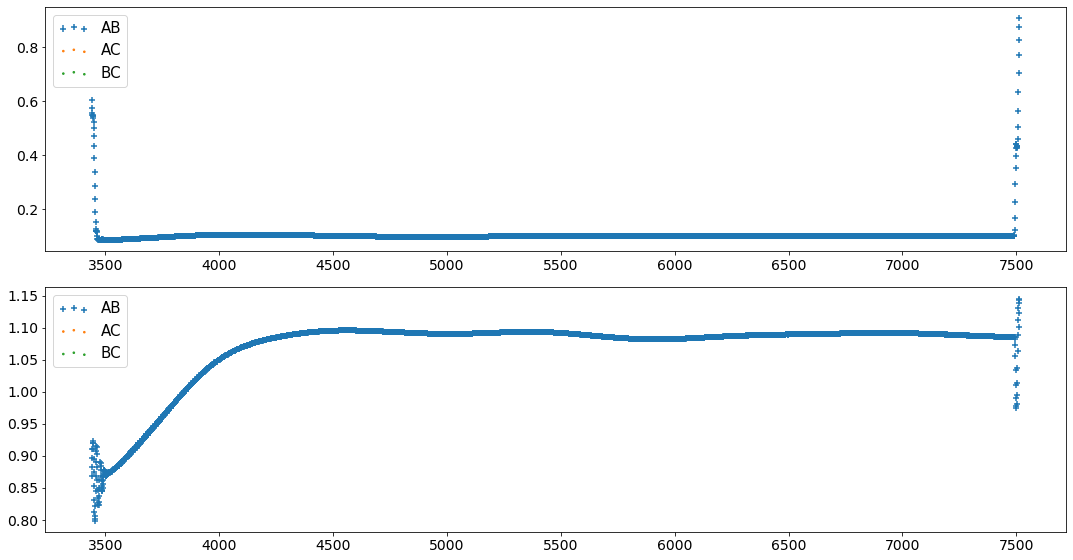


.
.
 9ACG.csv
  Fault type Percentage
0        NML     89.25%
1      FAULT     10.76%


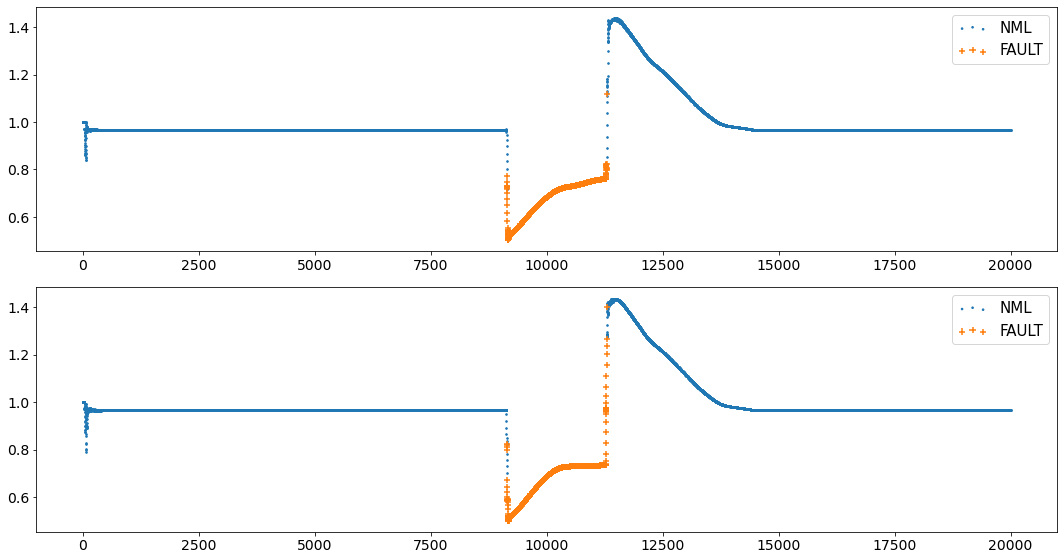

  Fault type Percentage
0        ACG     99.49%
1       ABCG      0.28%
2         AC      0.23%


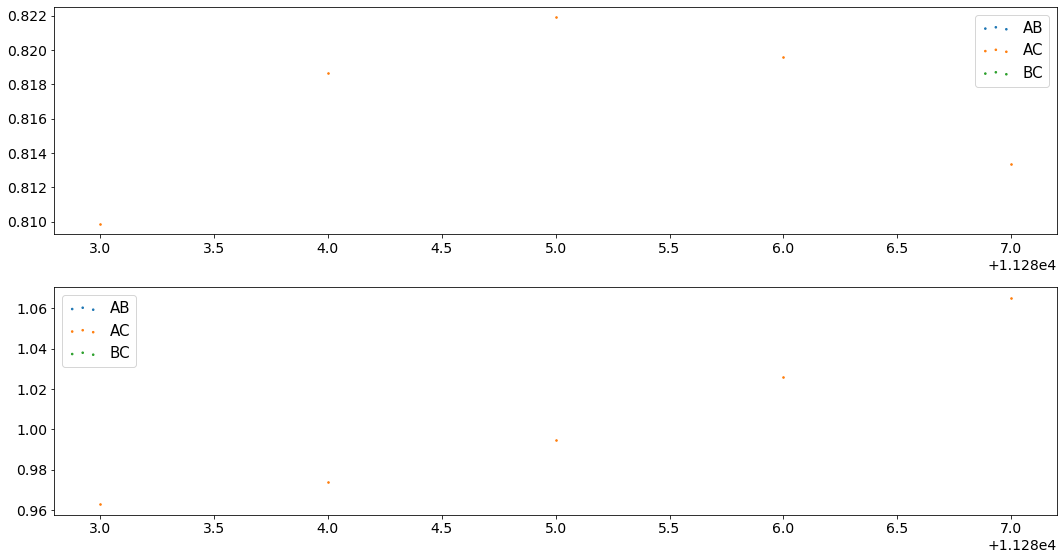


.
.
 9ABC.csv
  Fault type Percentage
0        NML     63.28%
1      FAULT     36.72%


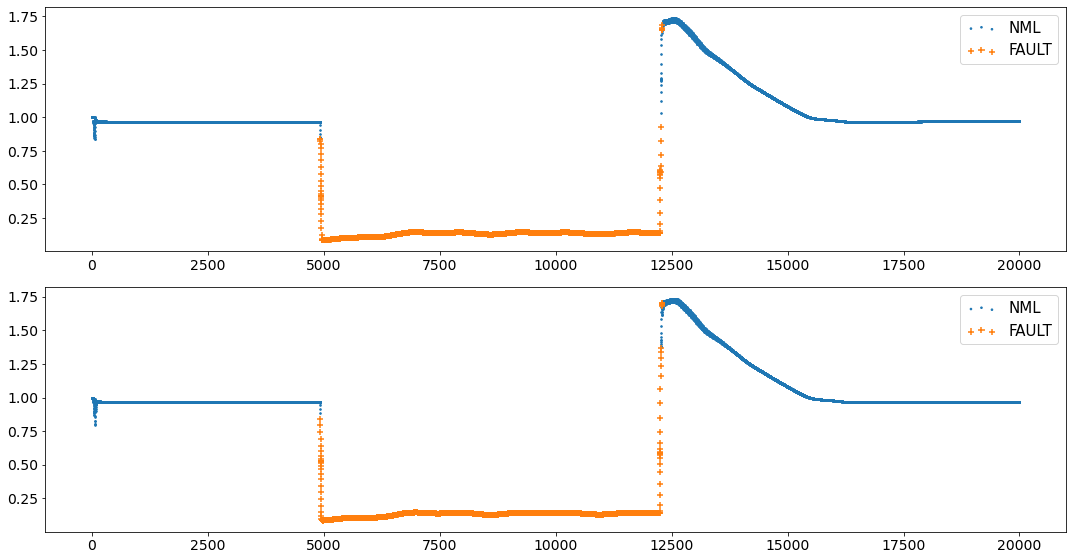

  Fault type Percentage
0        ABC     98.69%
1       ABCG      1.13%
2        ACG      0.11%
3        ABG      0.07%


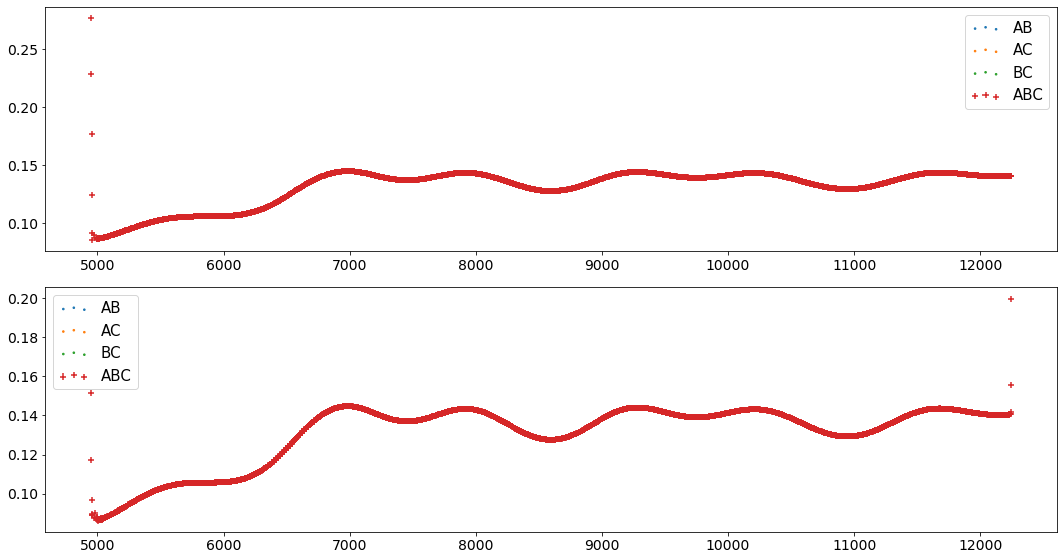


.
.
 5BC.csv
  Fault type Percentage
0        NML     99.67%
1      FAULT      0.34%


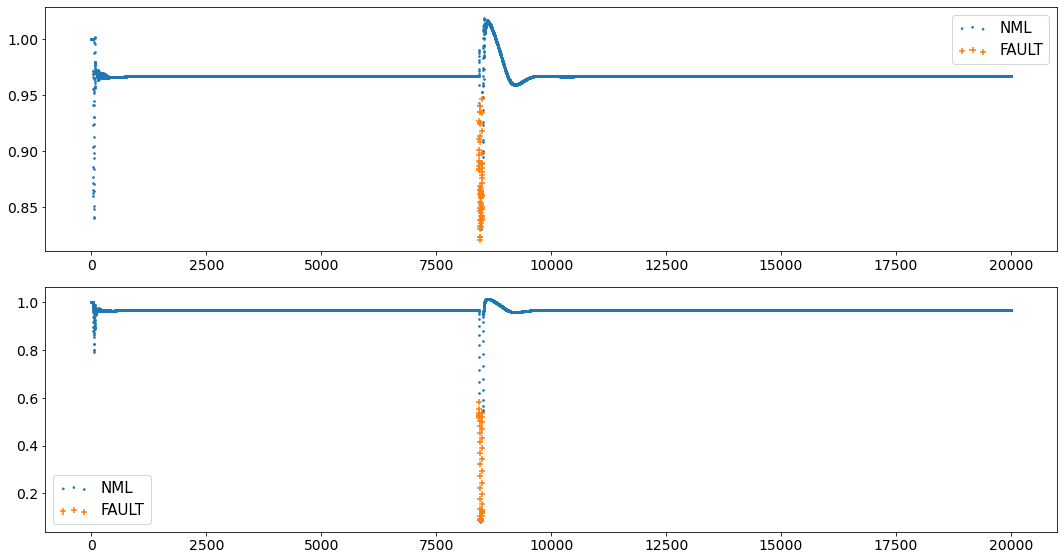

  Fault type Percentage
0         BC     98.51%
1        BCG      1.49%


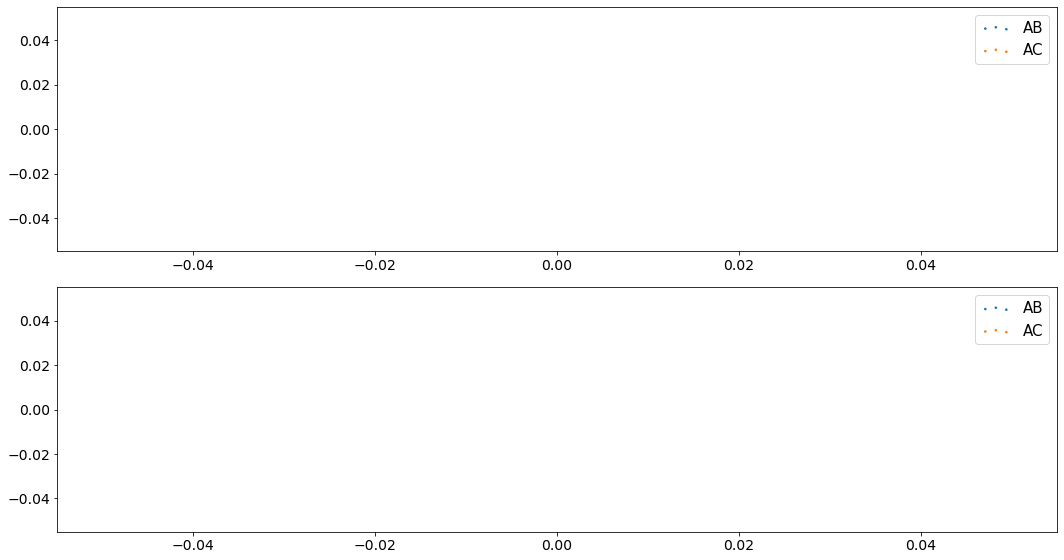


.
.
 5CG.csv
  Fault type Percentage
0        NML     84.13%
1      FAULT     15.87%


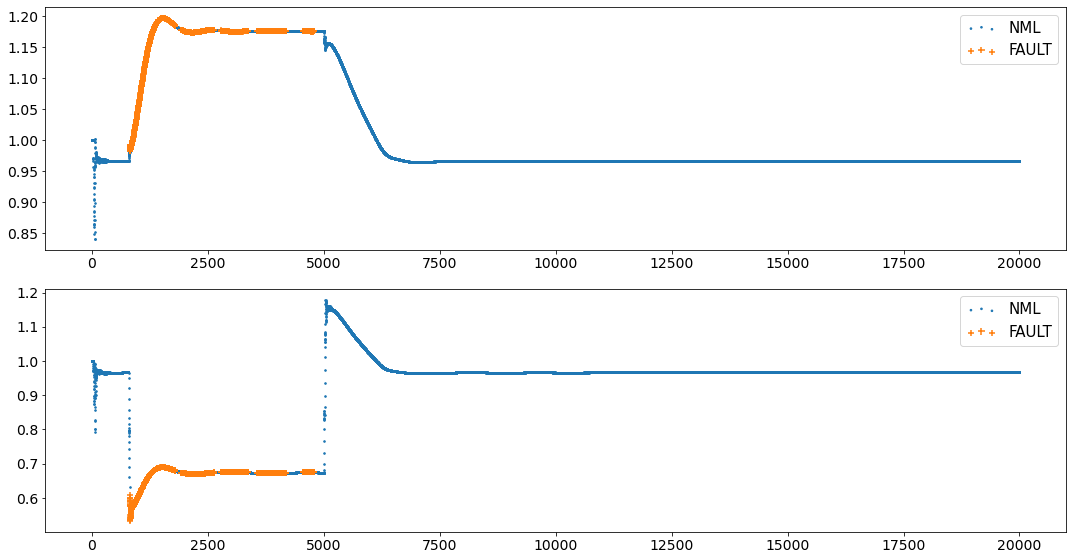

  Fault type Percentage
0         CG     100.0%


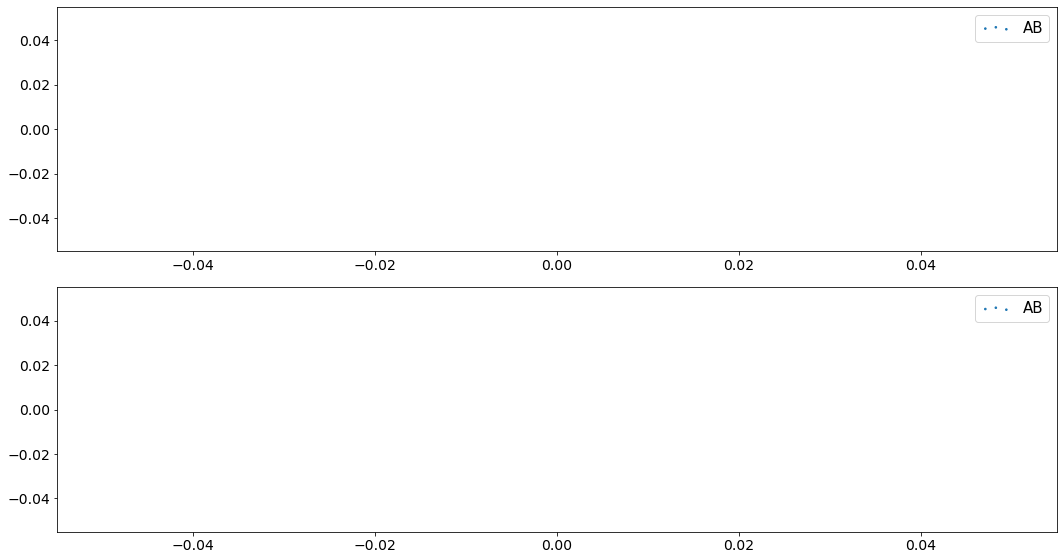


.
.
 4ABCG.csv
  Fault type Percentage
0        NML     93.14%
1      FAULT      6.87%


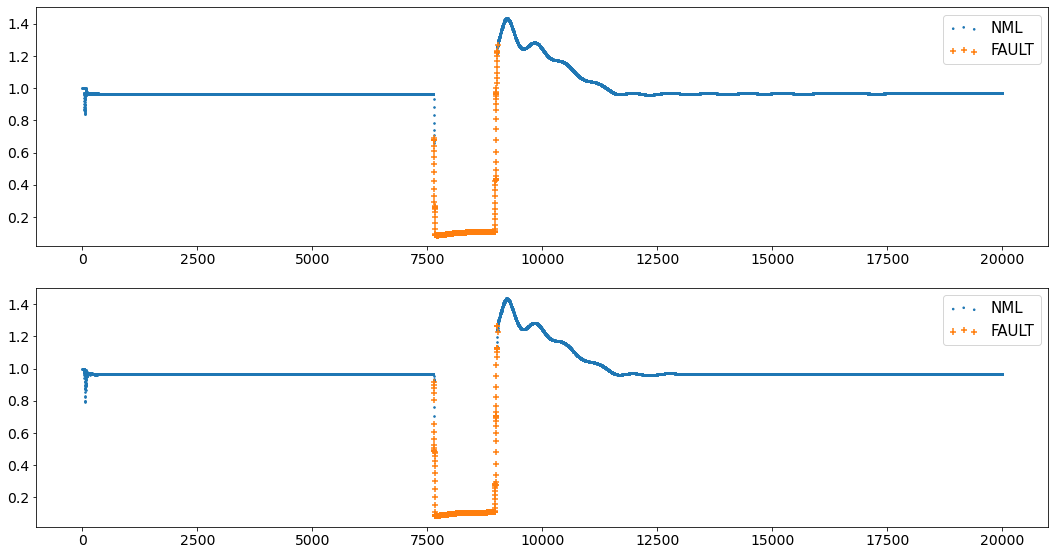

  Fault type Percentage
0        ABC     92.28%
1       ABCG      6.63%
2        ACG      0.66%
3        ABG      0.44%


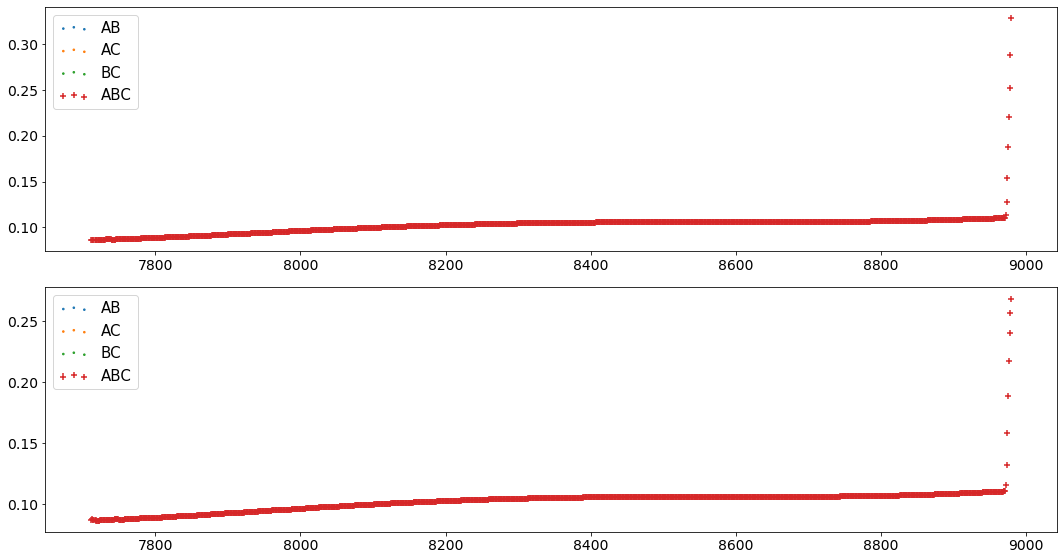


.
.
 7BC.csv
  Fault type Percentage
0        NML     99.47%
1      FAULT      0.53%


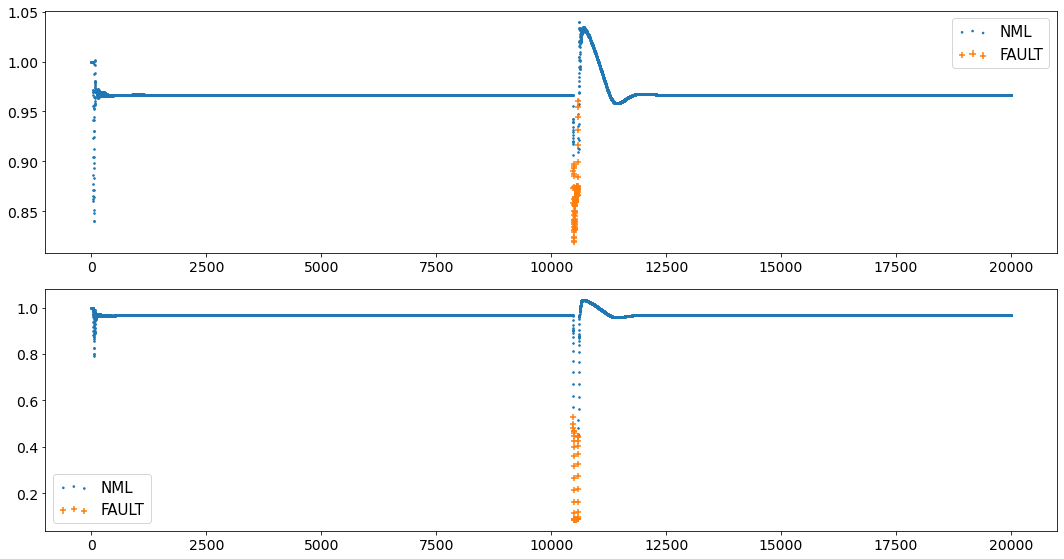

  Fault type Percentage
0         BC      98.1%
1        BCG       1.9%


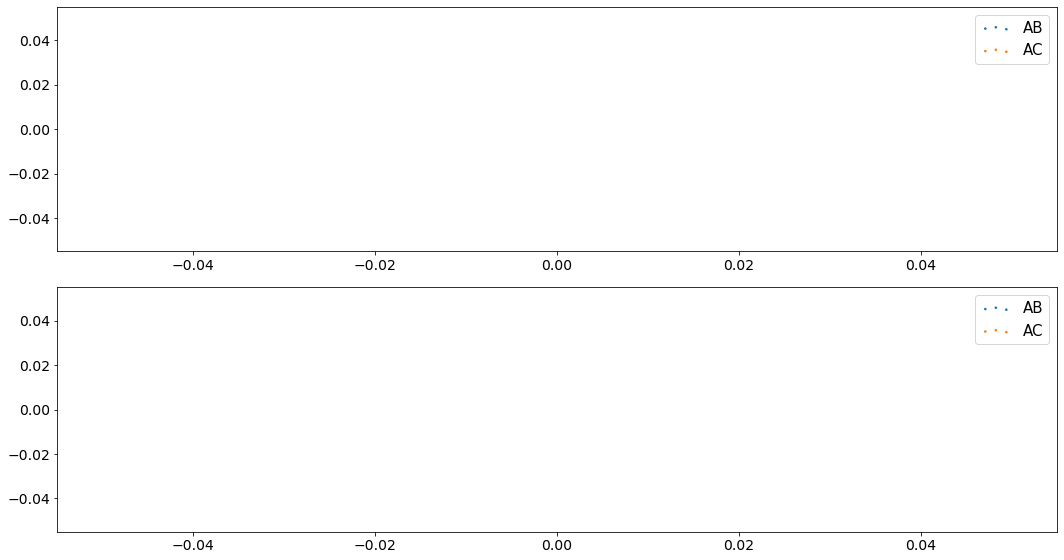


.
.
 7CG.csv
  Fault type Percentage
0        NML      84.5%
1      FAULT     15.49%


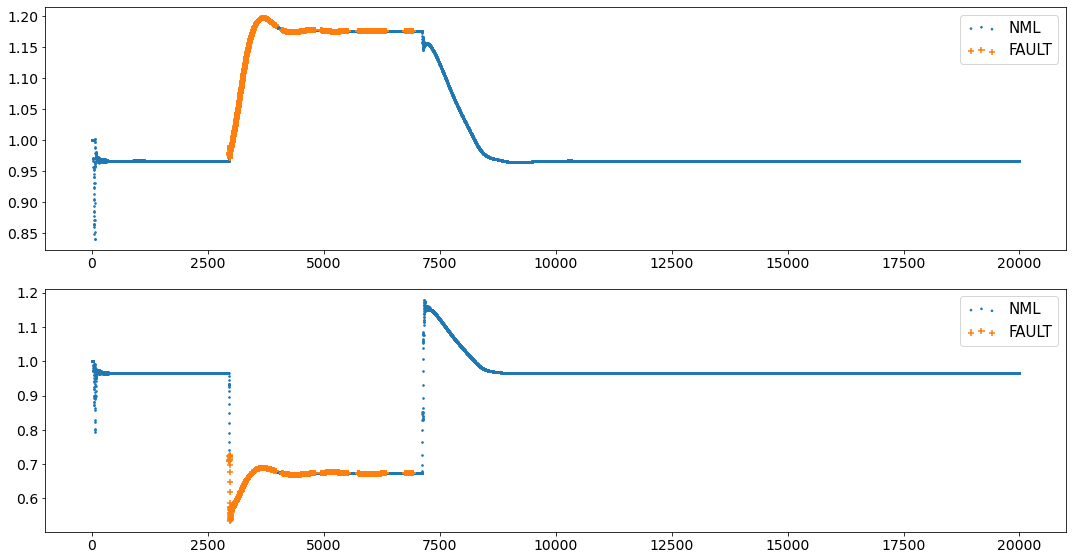

  Fault type Percentage
0         CG     100.0%


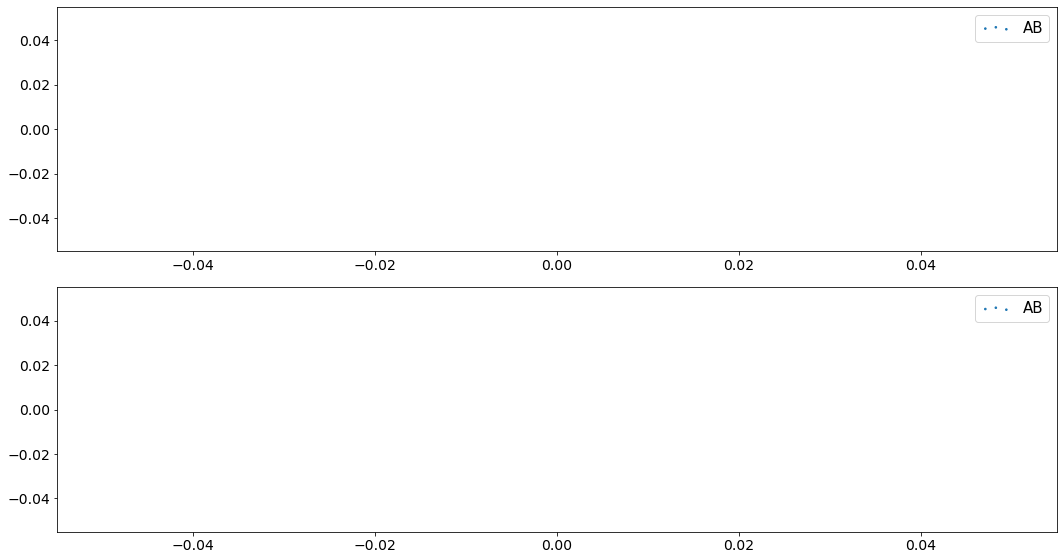


.
.
 10ACG.csv
  Fault type Percentage
0        NML     87.85%
1      FAULT     12.15%


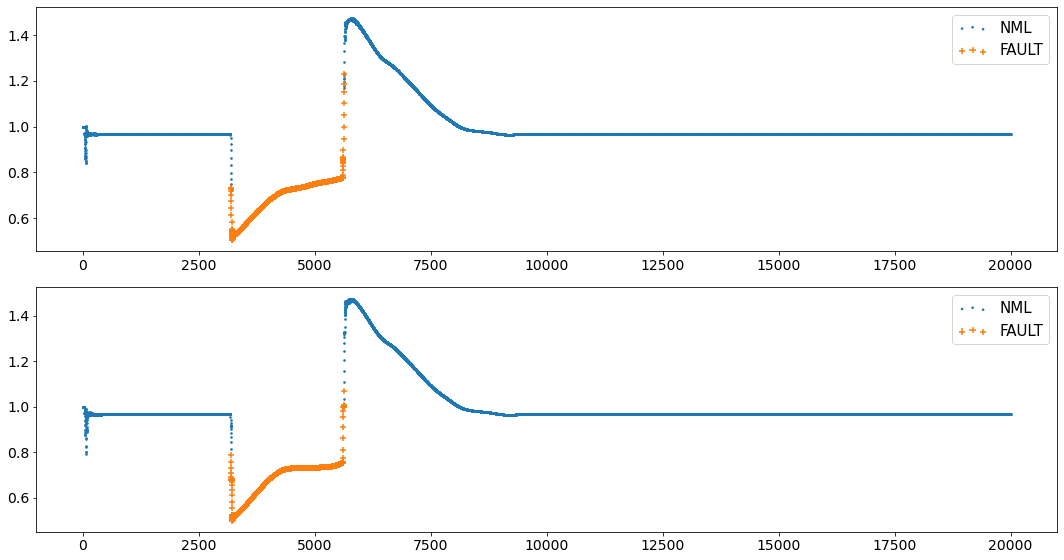

  Fault type Percentage
0        ACG     100.0%


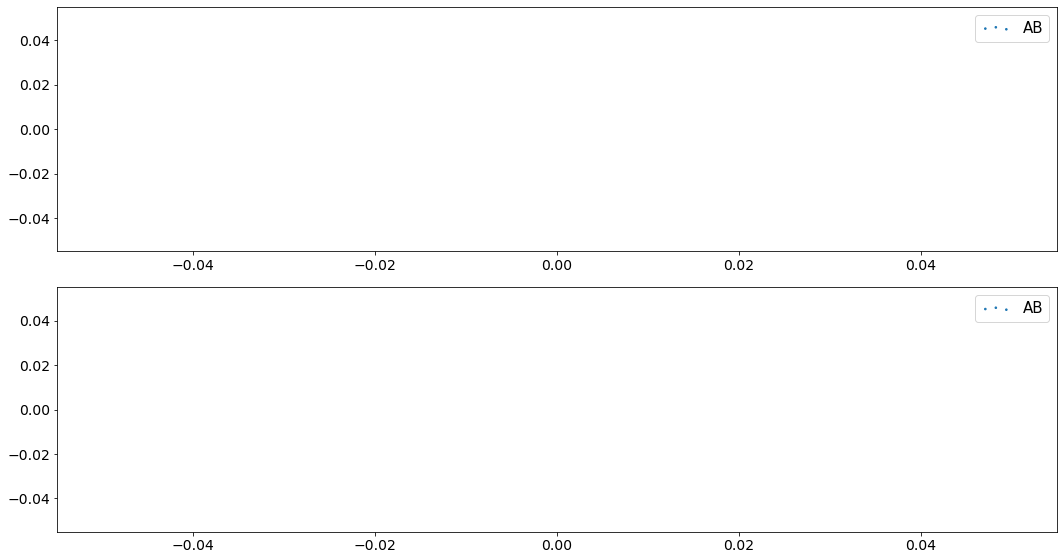


.
.
 3BG.csv
  Fault type Percentage
0        NML     94.14%
1      FAULT      5.86%


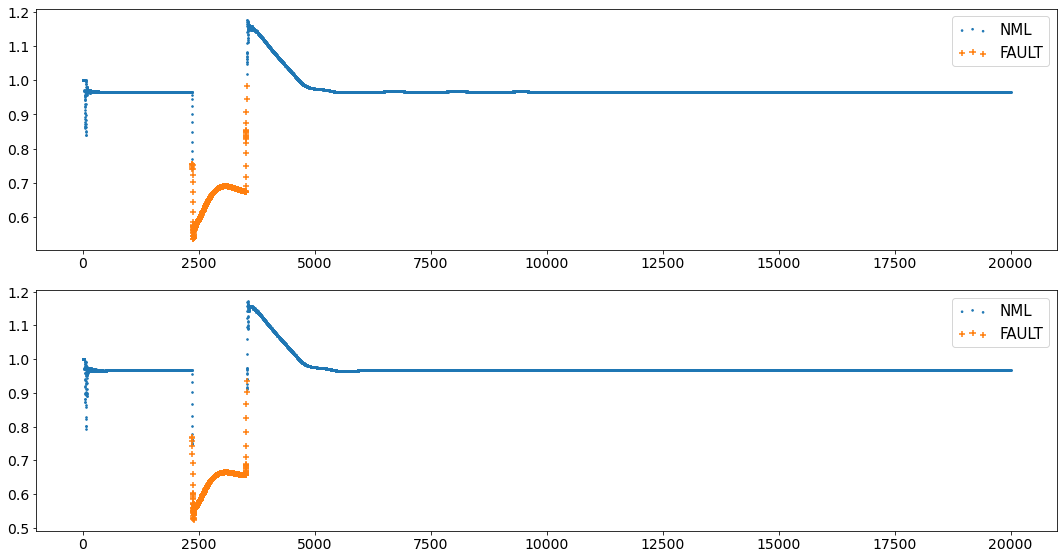

  Fault type Percentage
0         BG     100.0%


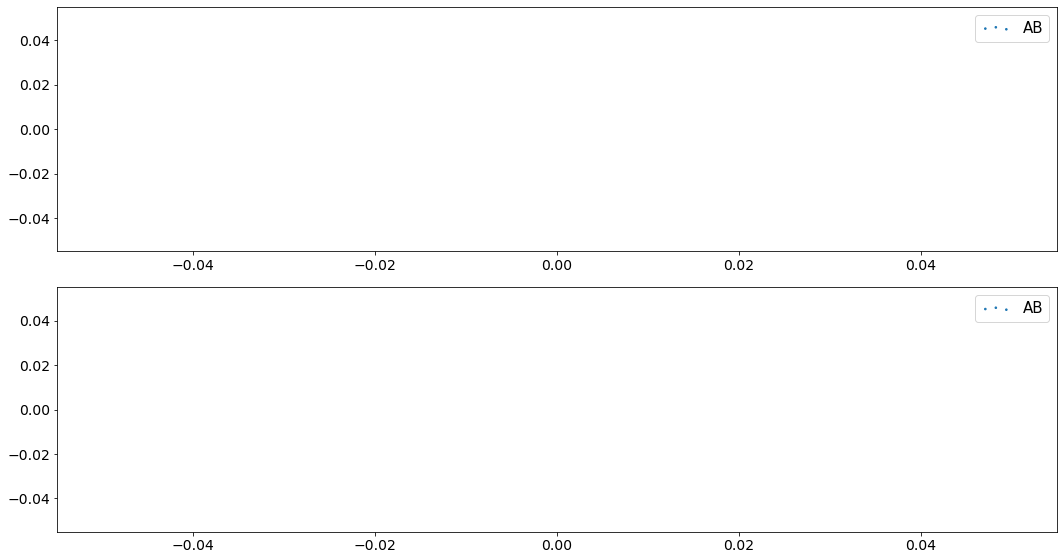


.
.
 10ABC.csv
  Fault type Percentage
0        NML      90.5%
1      FAULT      9.49%


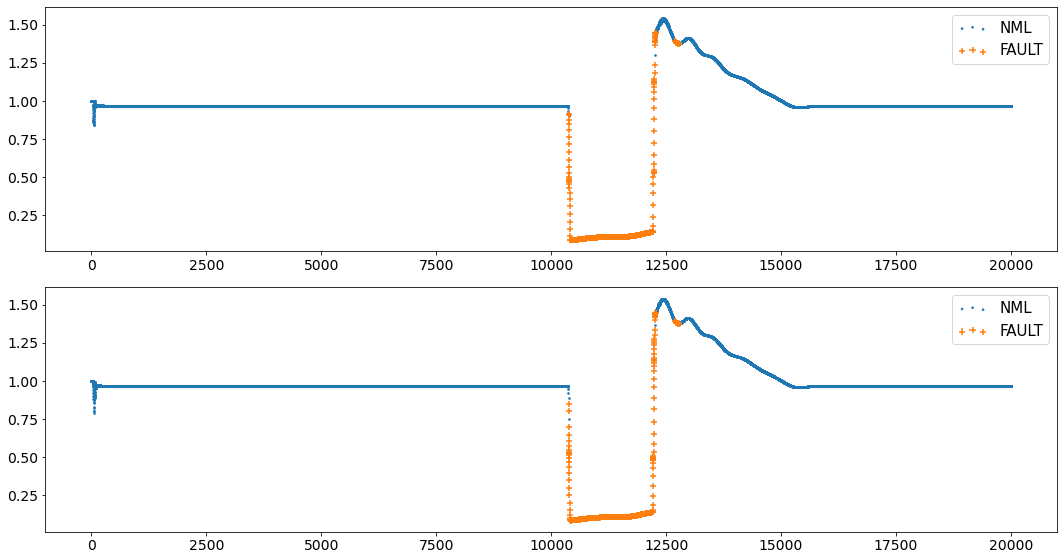

  Fault type Percentage
0        ABC     92.94%
1       ABCG      6.42%
2        BCG      0.21%
3        ACG      0.21%
4        ABG      0.11%
5         CG      0.11%


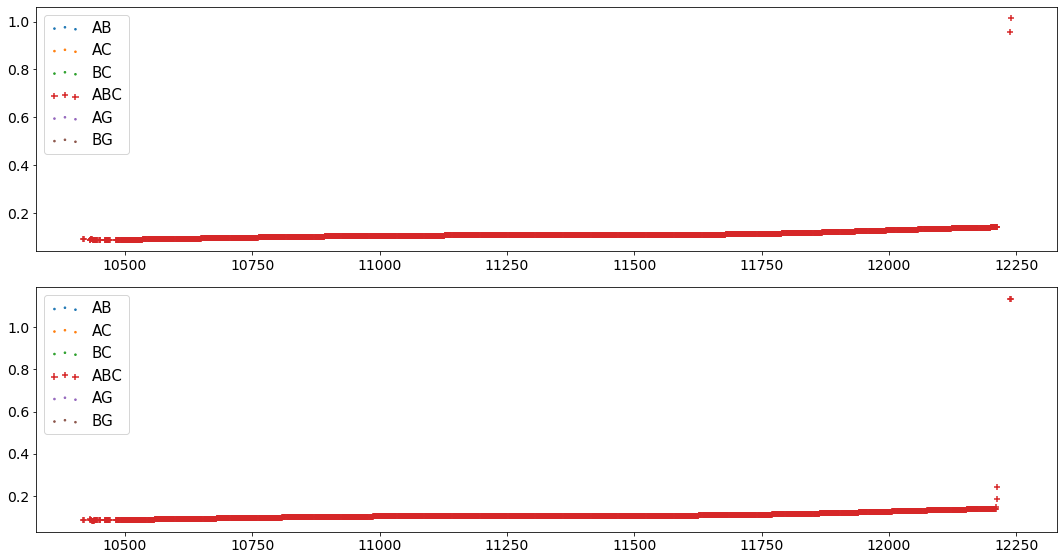


.
.
 3BCG.csv
  Fault type Percentage
0        NML     95.17%
1      FAULT      4.83%


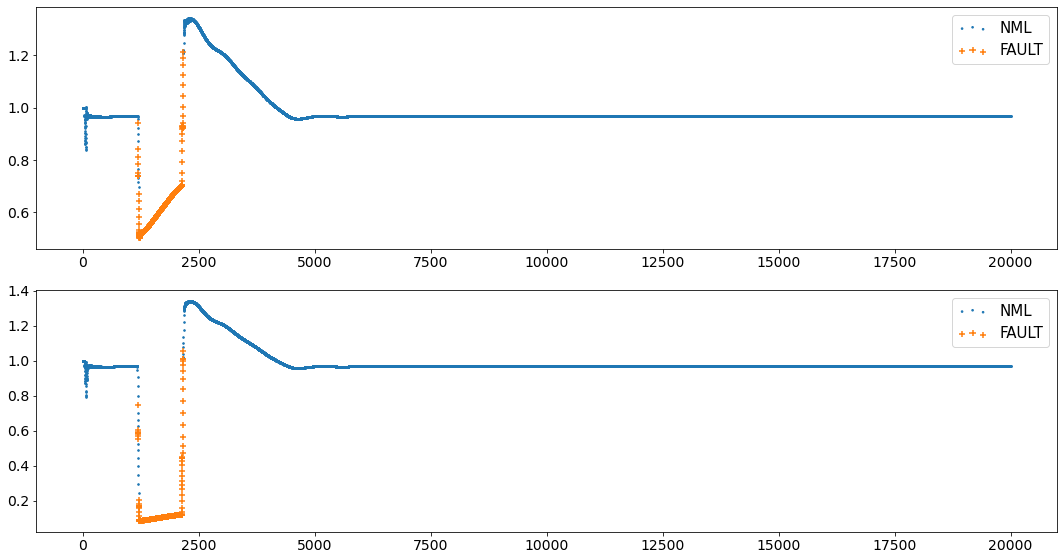

  Fault type Percentage
0        BCG     99.79%
1       ABCG       0.1%
2         BC       0.1%


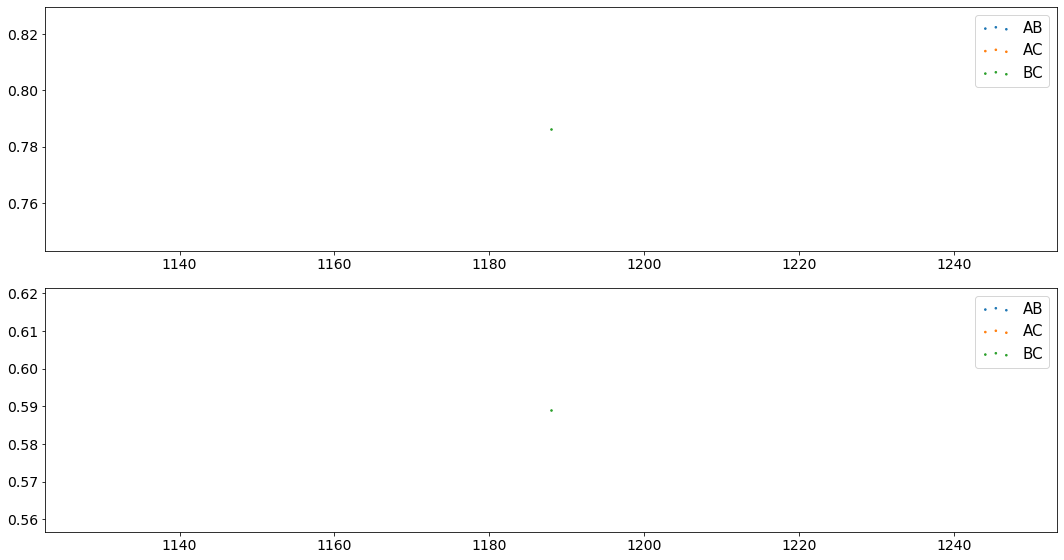


.
.
 4BG.csv
  Fault type Percentage
0        NML     73.53%
1      FAULT     26.48%


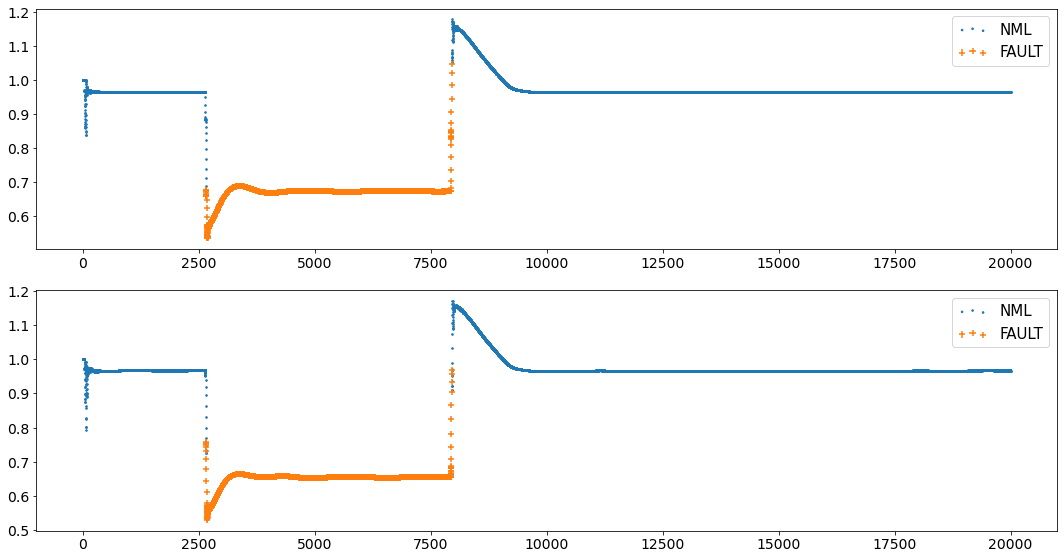

  Fault type Percentage
0         BG     100.0%


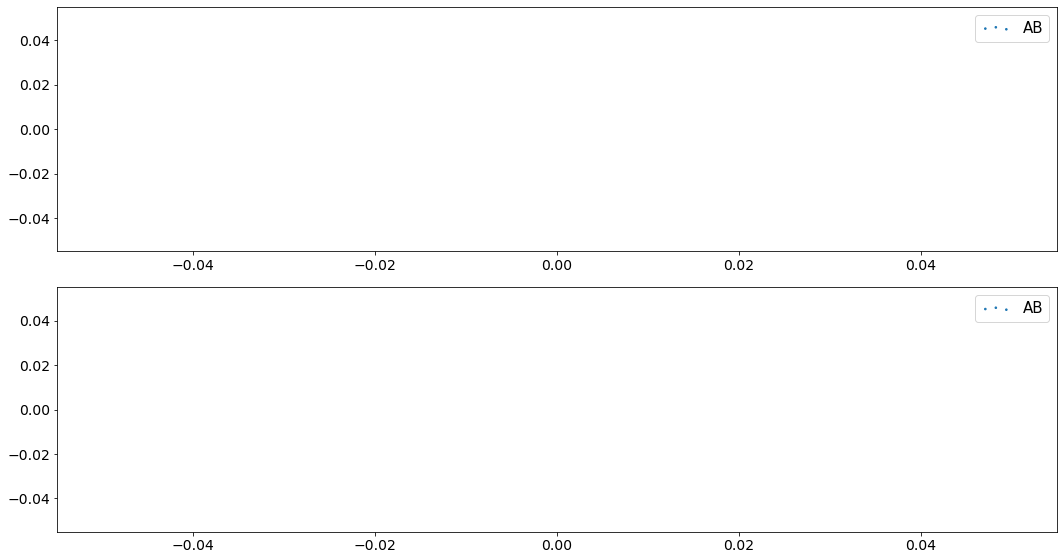


.
.
 1ABC.csv
  Fault type Percentage
0        NML     73.42%
1      FAULT     26.57%


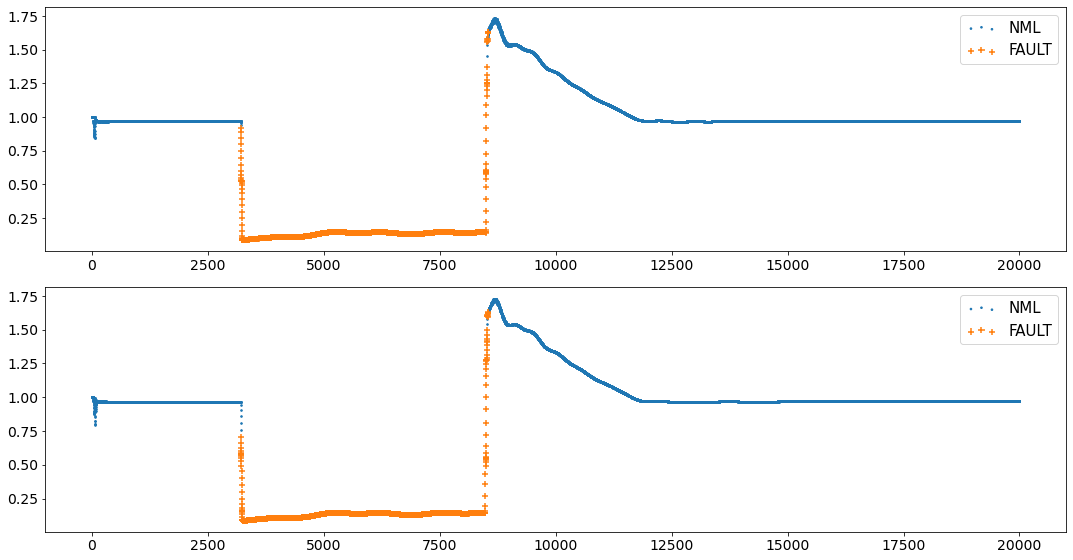

  Fault type Percentage
0        ABC     97.87%
1       ABCG      1.88%
2        BCG      0.21%
3        ABG      0.04%


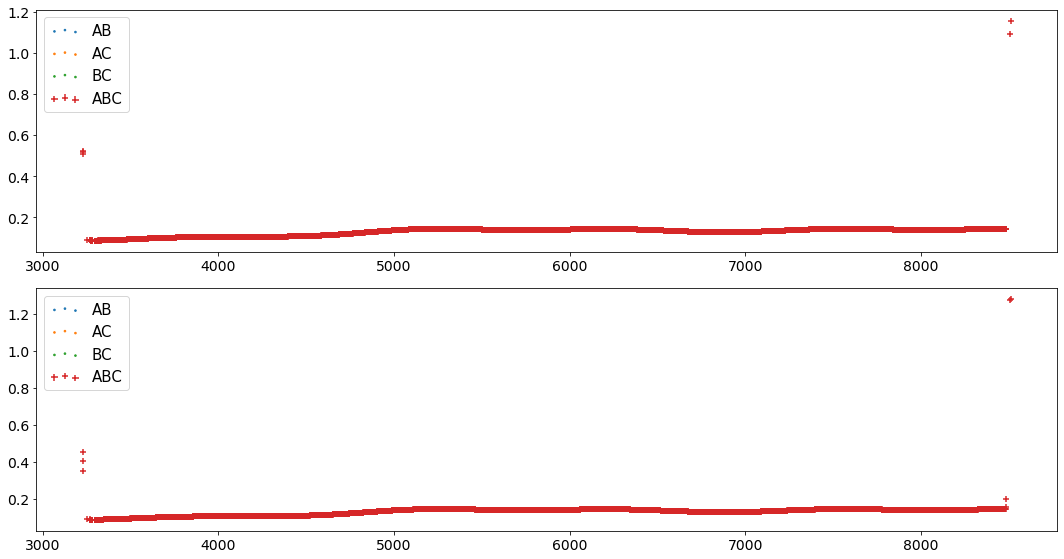


.
.
 1ACG.csv
  Fault type Percentage
0        NML     95.17%
1      FAULT      4.83%


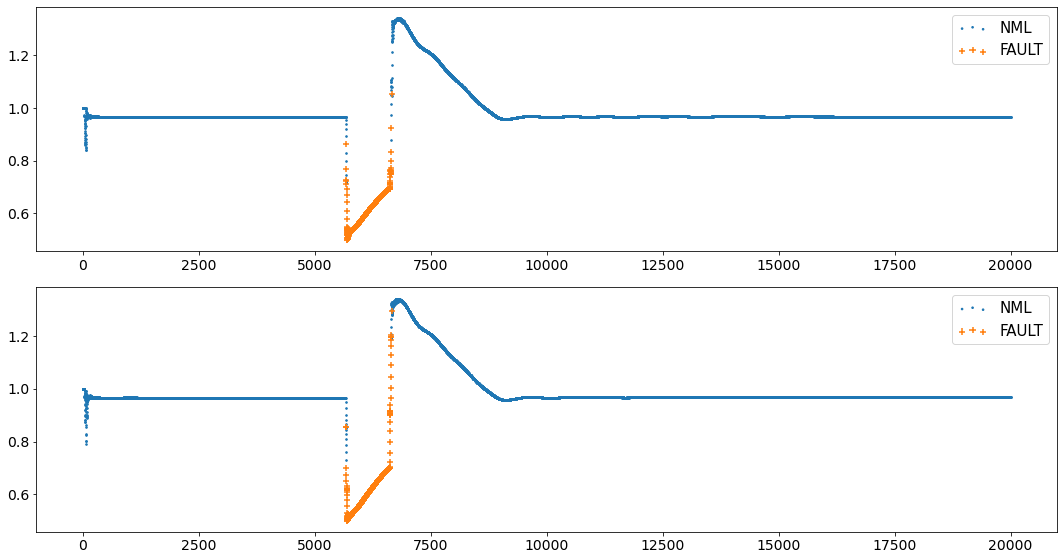

  Fault type Percentage
0        ACG     99.27%
1       ABCG      0.73%


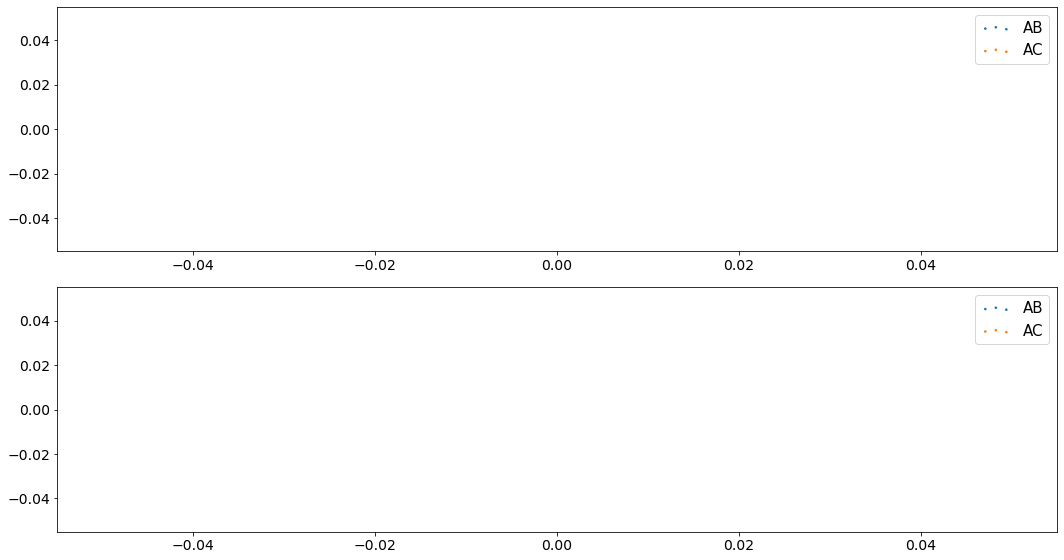


.
.
 8AG.csv
  Fault type Percentage
0        NML     97.55%
1      FAULT      2.46%


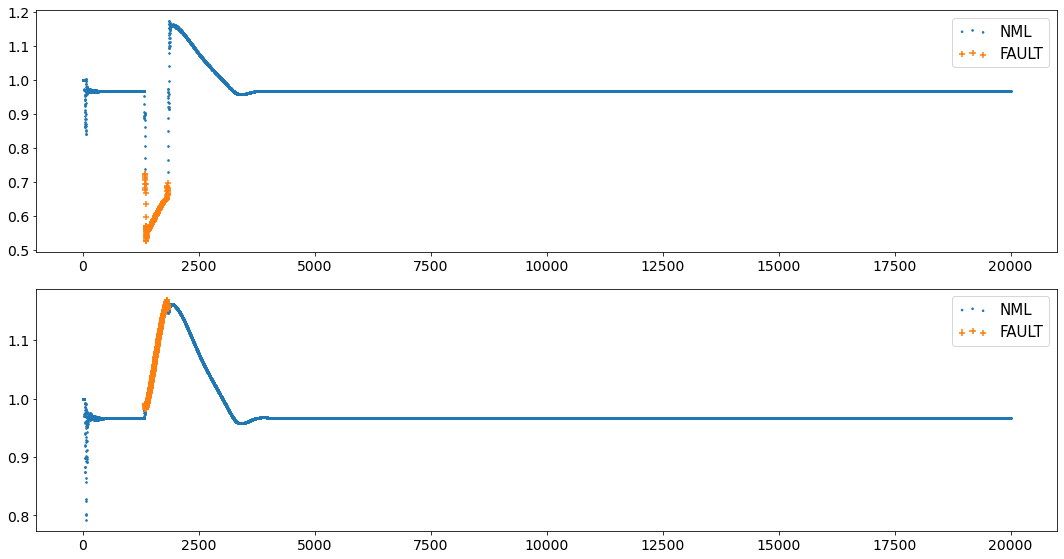

  Fault type Percentage
0         AG     100.0%


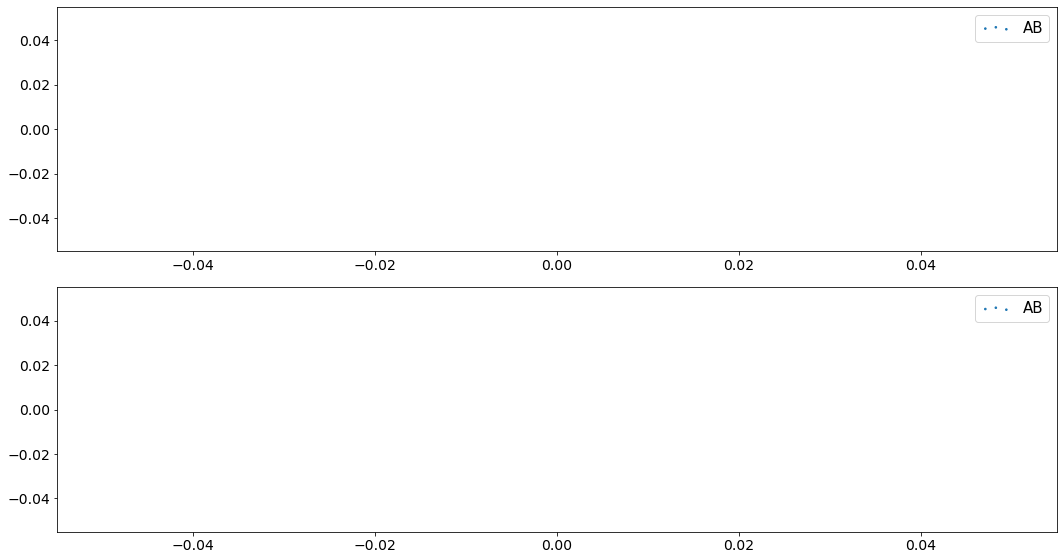


.
.
 3ABG.csv
  Fault type Percentage
0        NML      98.4%
1      FAULT       1.6%


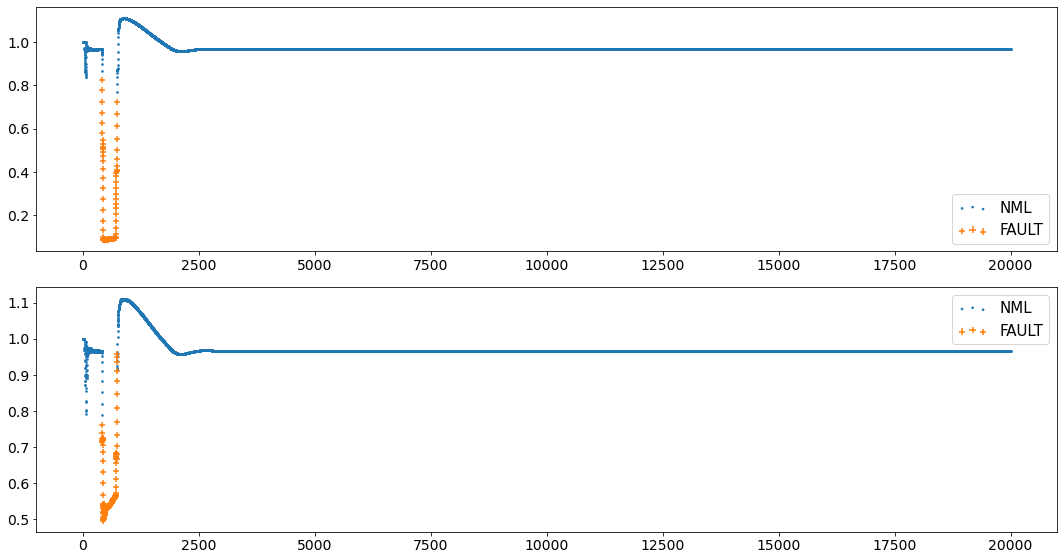

  Fault type Percentage
0        ABG     98.12%
1        BCG      1.56%
2       ABCG      0.31%


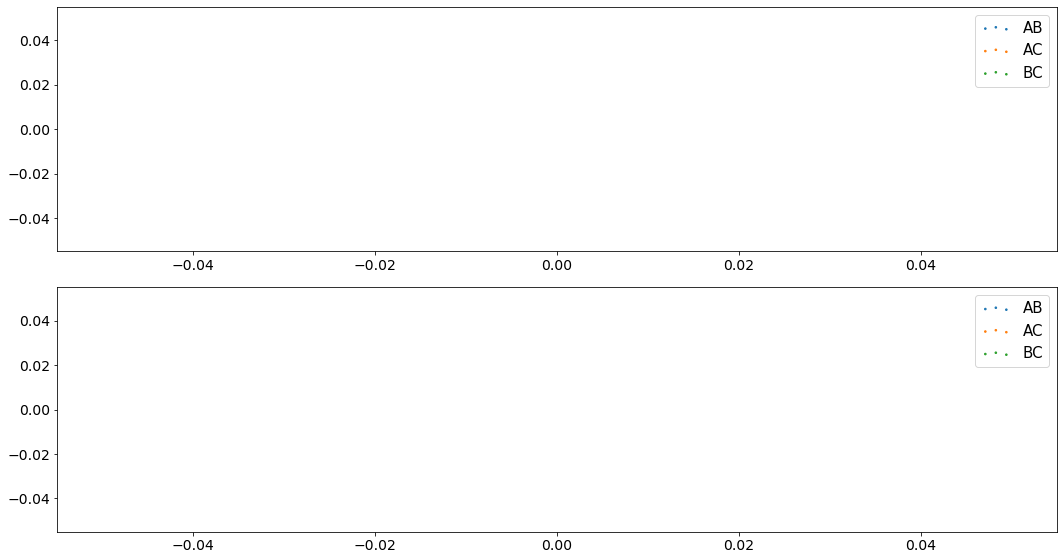


.
.
 10AC.csv
  Fault type Percentage
0        NML     98.03%
1      FAULT      1.97%


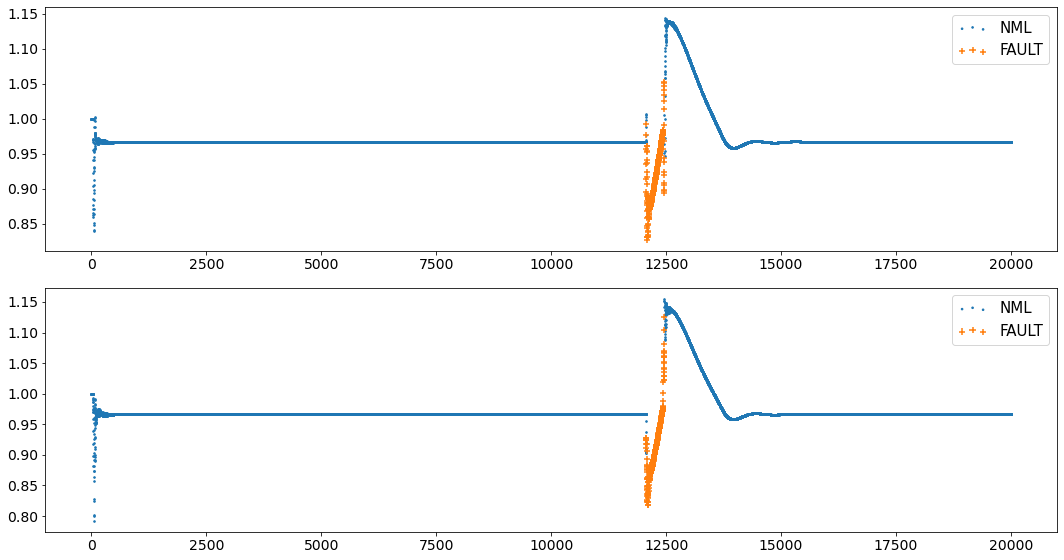

  Fault type Percentage
0         AC     93.64%
1        ACG      6.36%


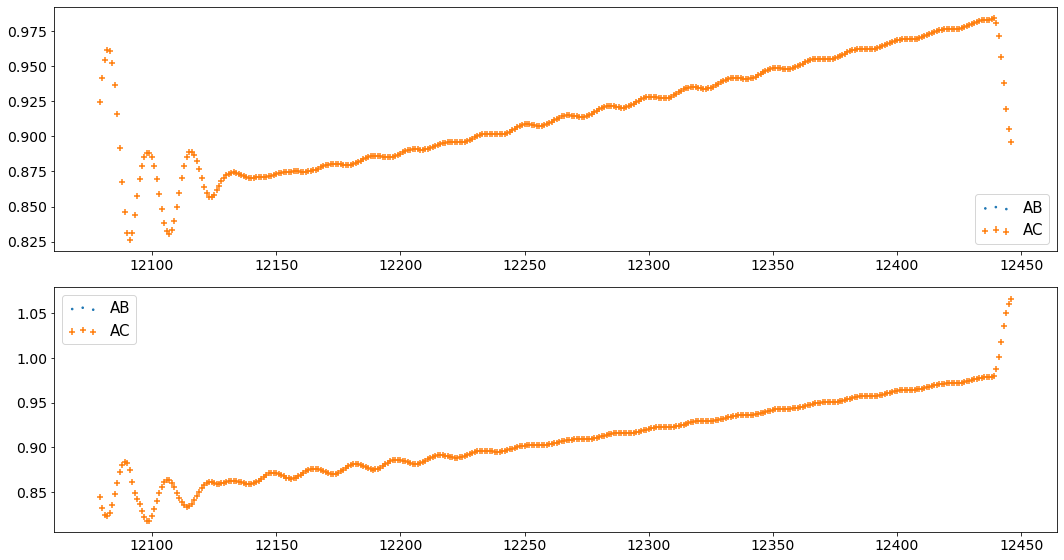


.
.
 7BCG.csv
  Fault type Percentage
0        NML     88.52%
1      FAULT     11.48%


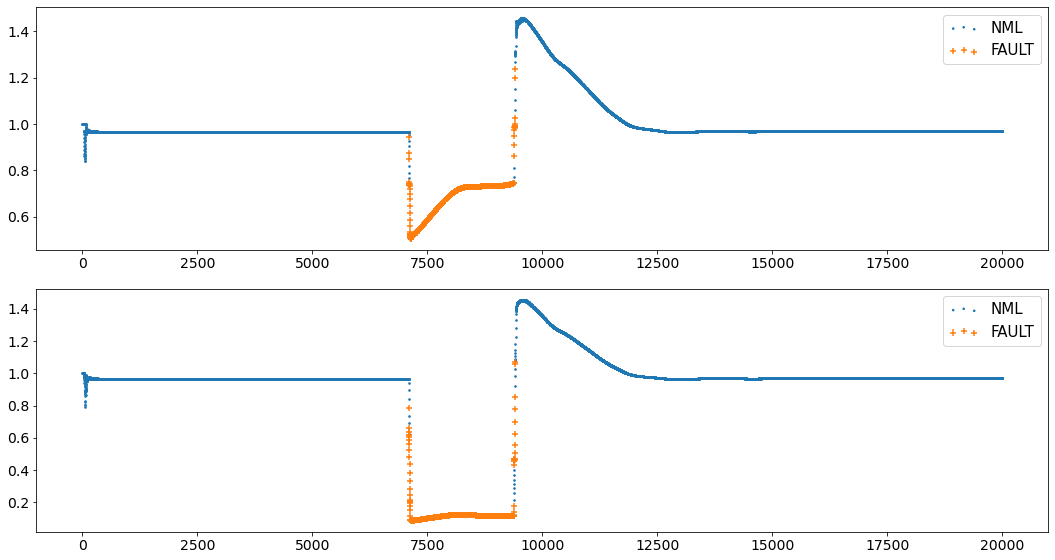

  Fault type Percentage
0        BCG     99.91%
1         BG      0.09%


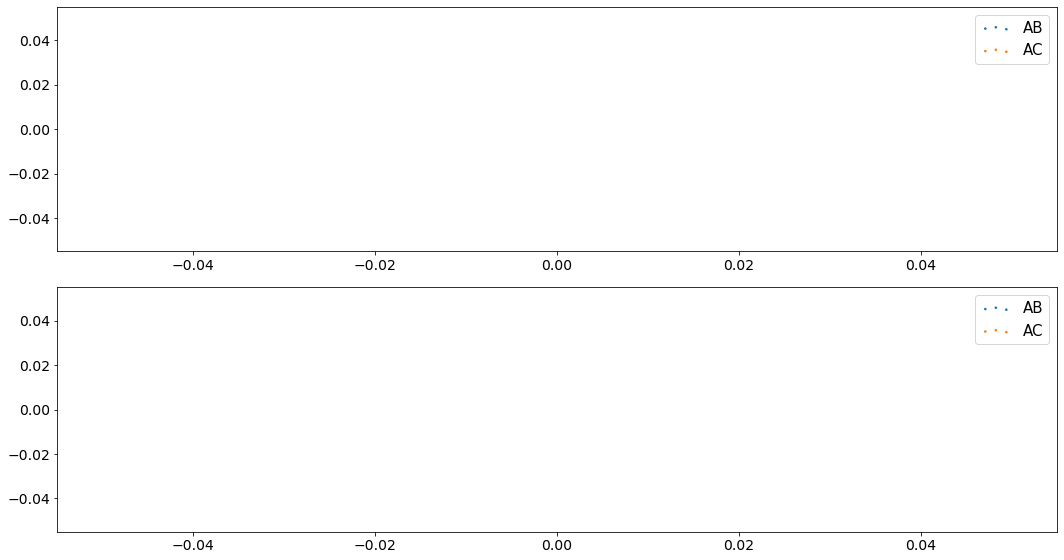


.
.
 6ABCG.csv
  Fault type Percentage
0        NML     92.89%
1      FAULT      7.11%


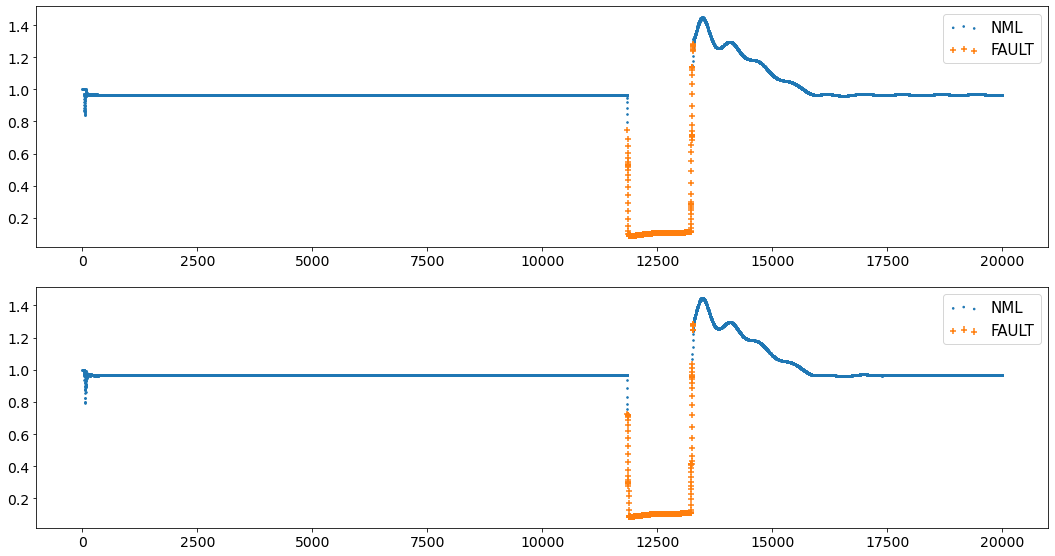

  Fault type Percentage
0        ABC     91.13%
1       ABCG      7.67%
2        BCG      0.63%
3        ABG      0.56%


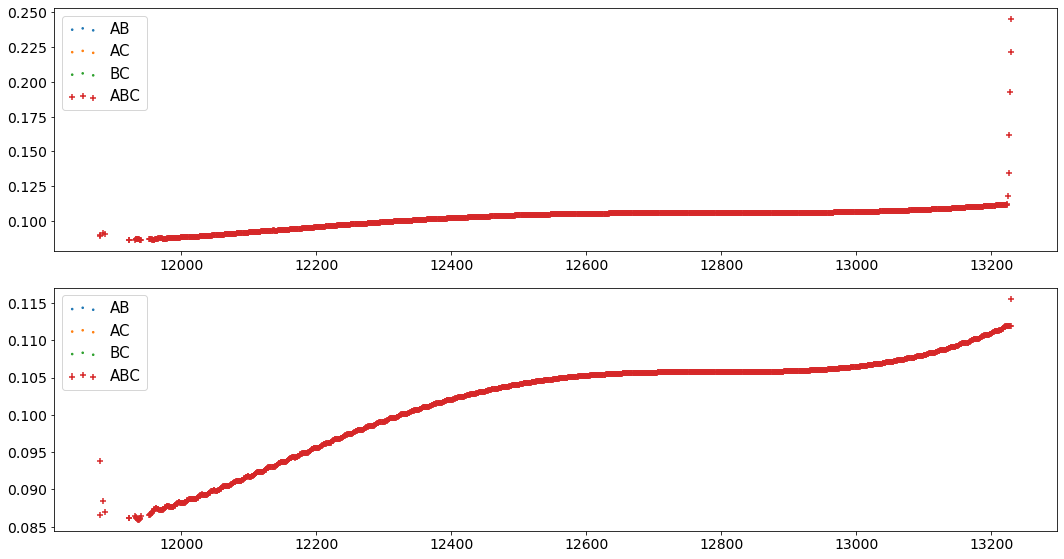


.
.
 6BG.csv
  Fault type Percentage
0        NML      81.4%
1      FAULT      18.6%


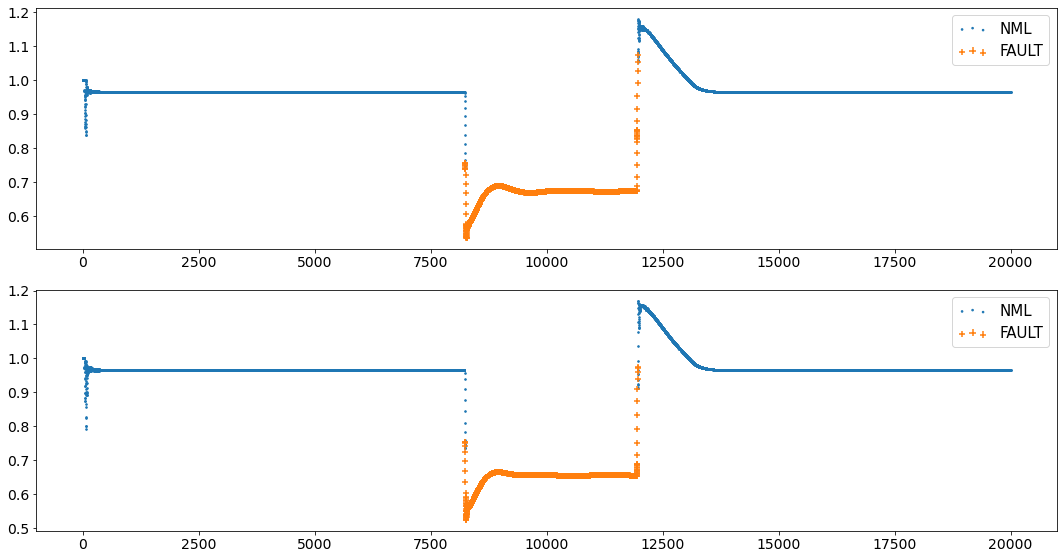

  Fault type Percentage
0         BG     100.0%


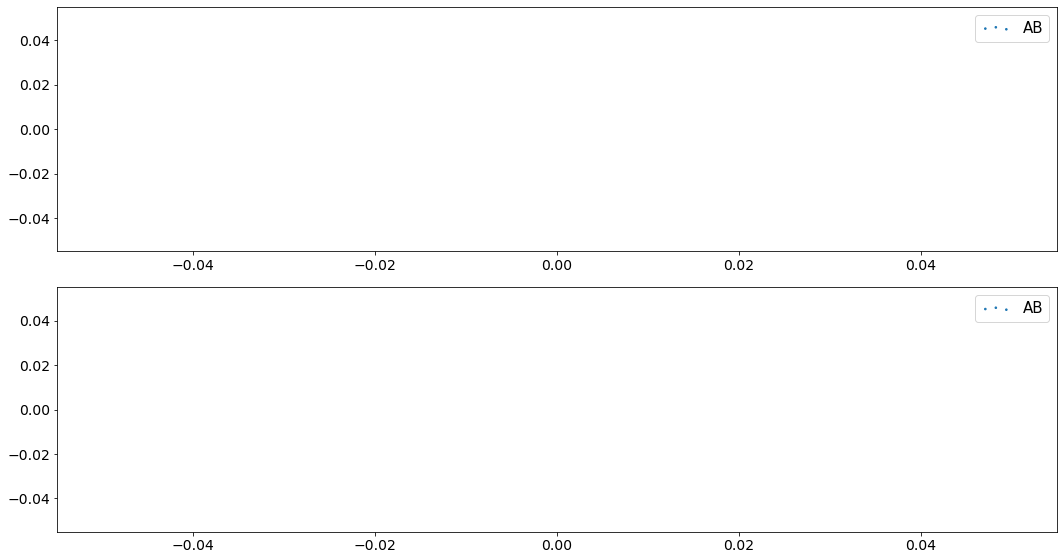


.
.
 10AB.csv
  Fault type Percentage
0        NML     98.58%
1      FAULT      1.42%


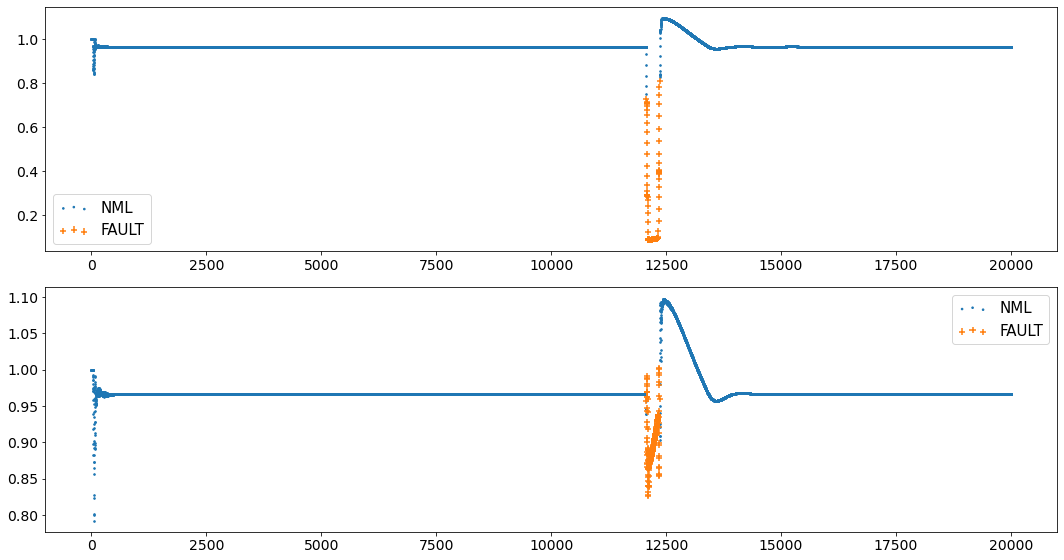

  Fault type Percentage
0         AB     94.01%
1        ABG      5.99%


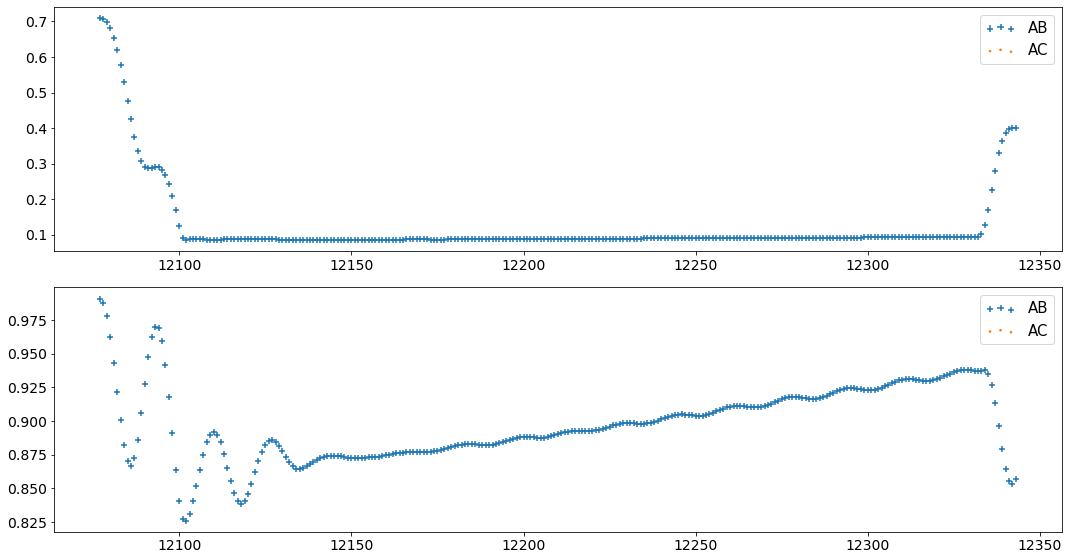


.
.
 2BC.csv
  Fault type Percentage
0        NML     96.92%
1      FAULT      3.08%


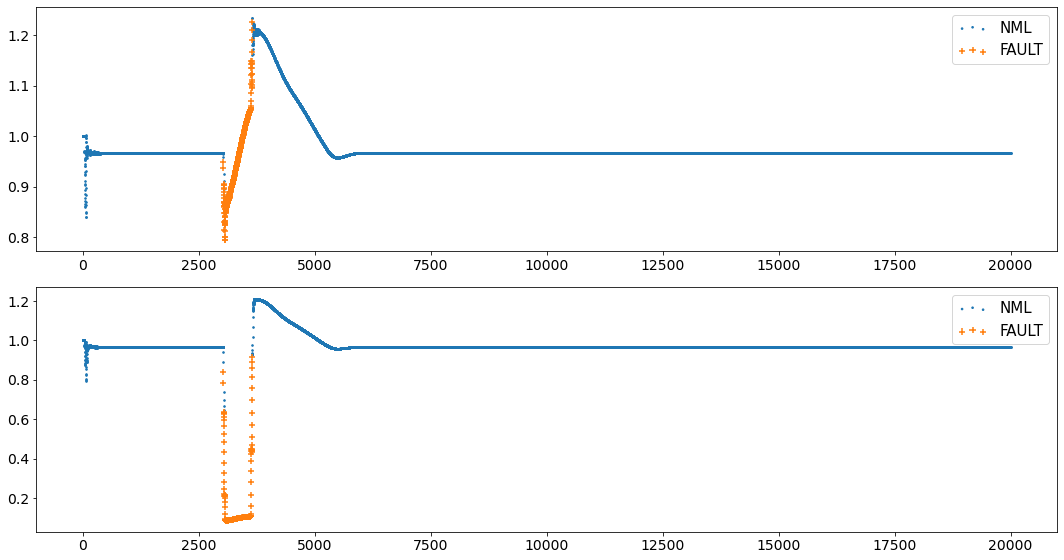

  Fault type Percentage
0         BC     97.08%
1        BCG      2.76%
2       ABCG      0.16%


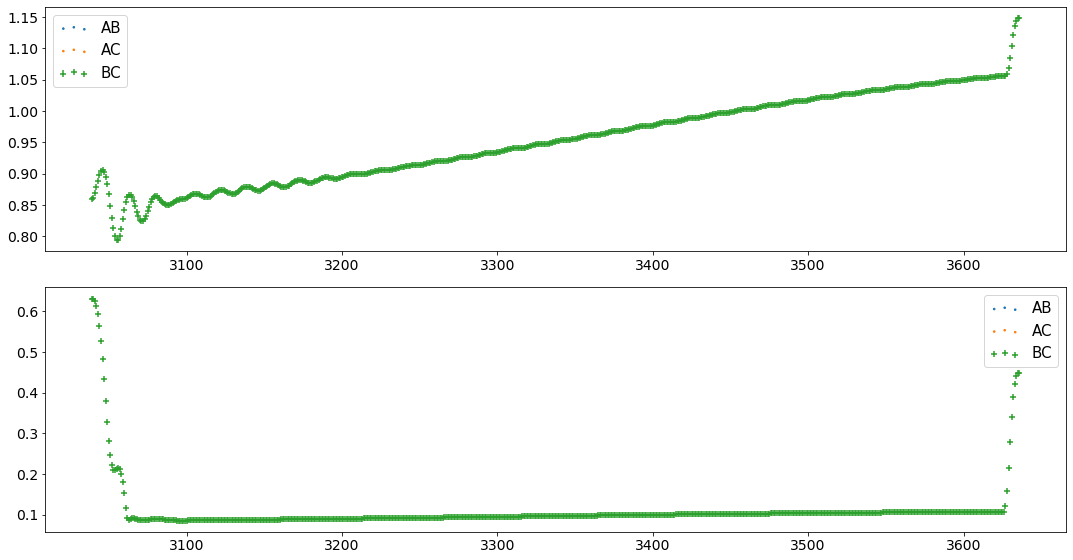


.
.
 2CG.csv
  Fault type Percentage
0        NML     84.52%
1      FAULT     15.48%


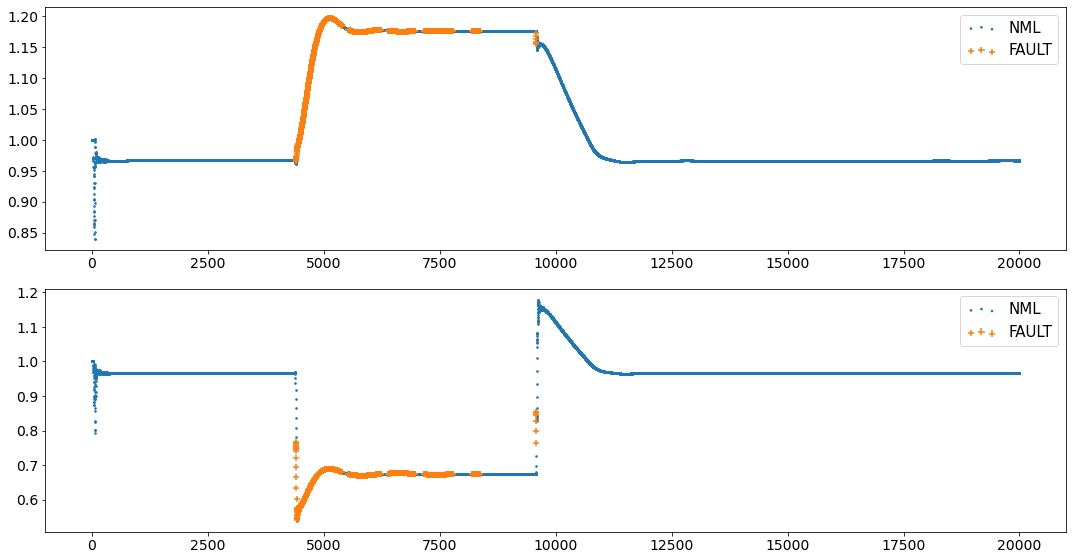

  Fault type Percentage
0         CG     100.0%


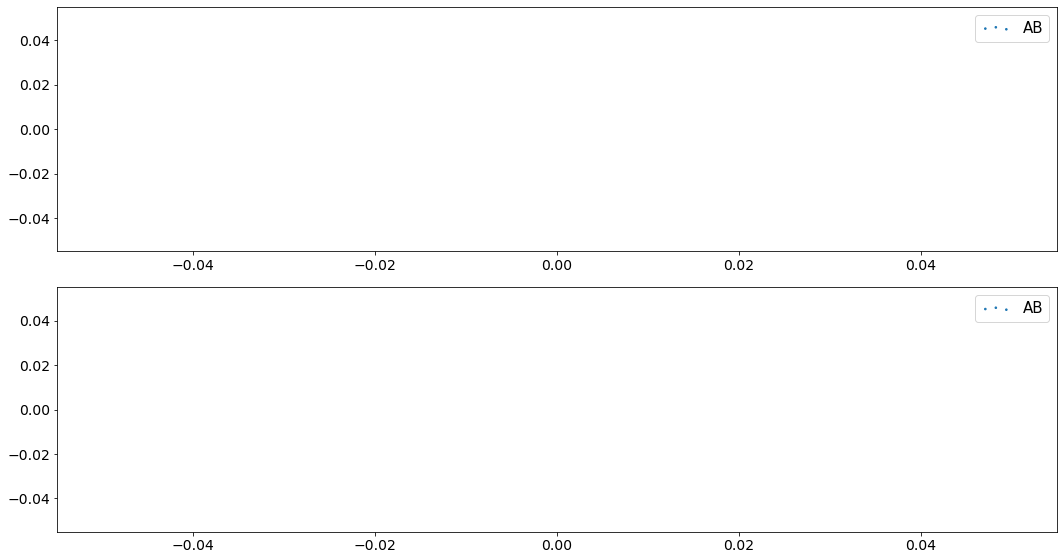


.
.
 5BCG.csv
  Fault type Percentage
0        NML     84.28%
1      FAULT     15.72%


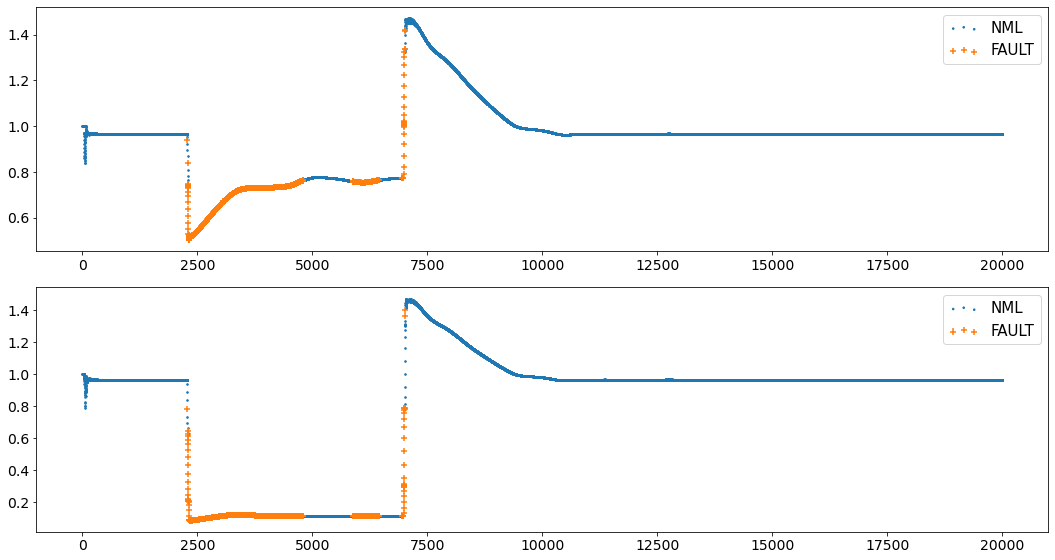

  Fault type Percentage
0        BCG     99.78%
1         CG      0.22%


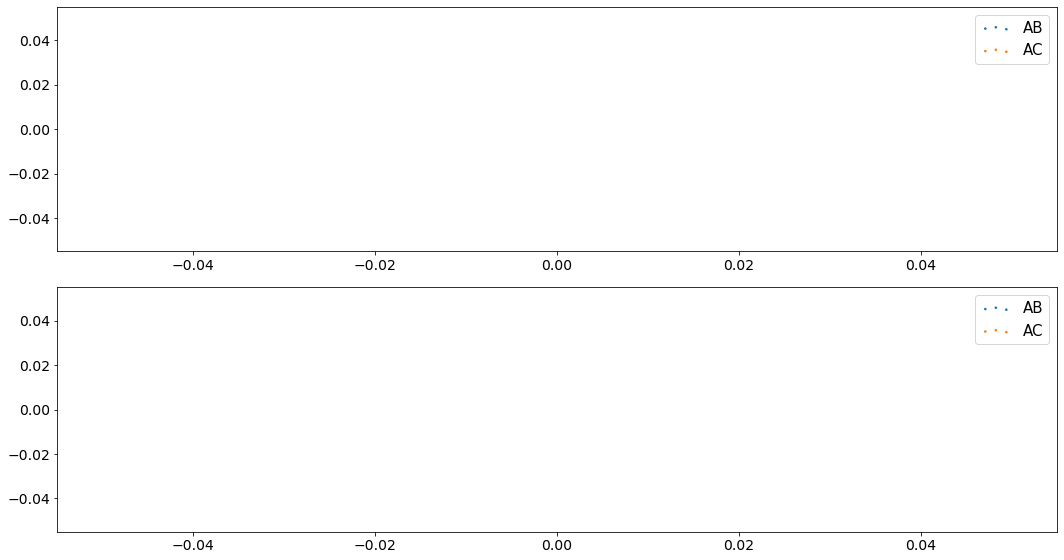


.
.
 2BG.csv
  Fault type Percentage
0        NML     99.17%
1      FAULT      0.83%


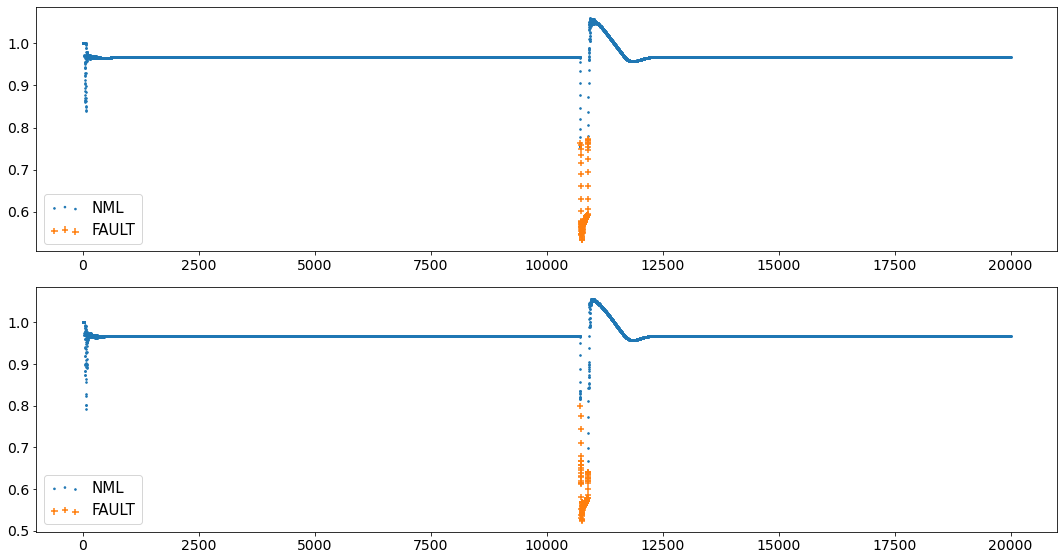

  Fault type Percentage
0         BG     100.0%


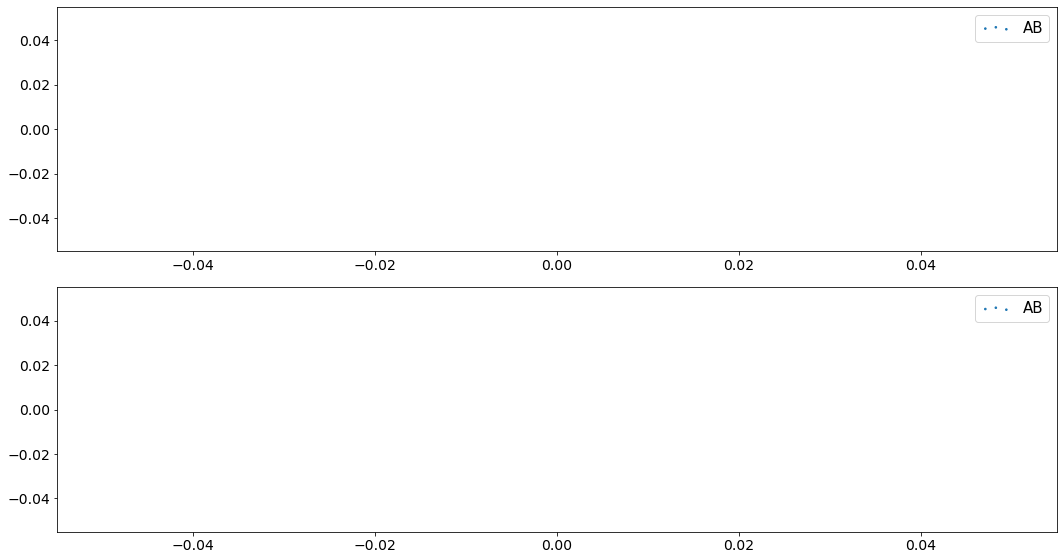


.
.
 6BC.csv
  Fault type Percentage
0        NML     84.39%
1      FAULT     15.62%


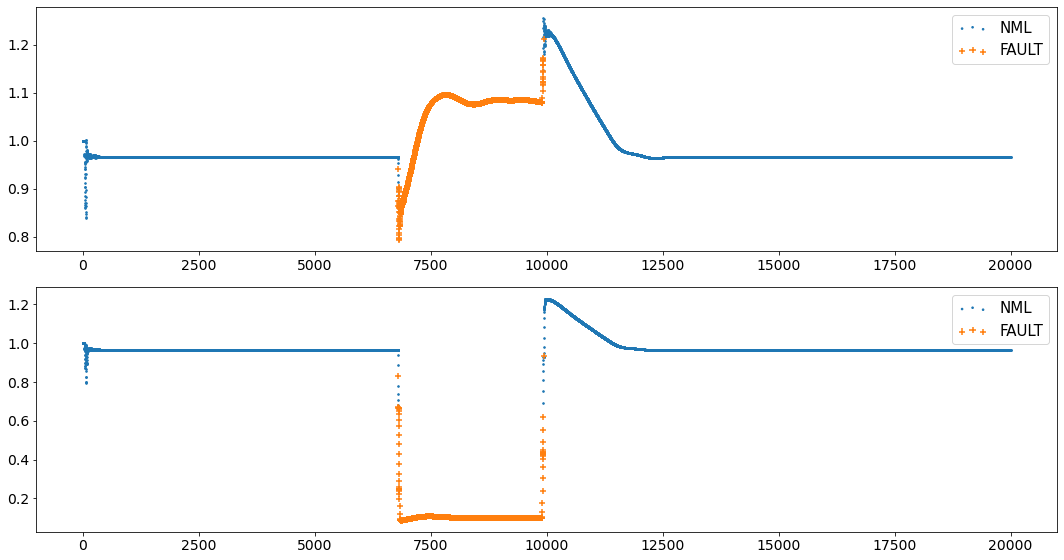

  Fault type Percentage
0         BC     99.84%
1        BCG       0.1%
2         AB      0.03%
3       ABCG      0.03%


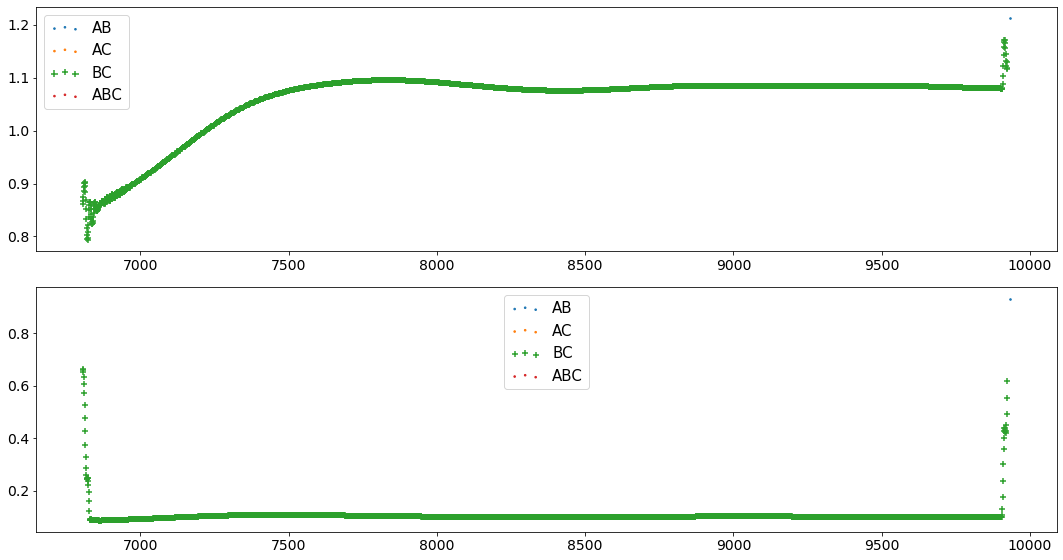


.
.
 6CG.csv
  Fault type Percentage
0        NML     84.25%
1      FAULT     15.75%


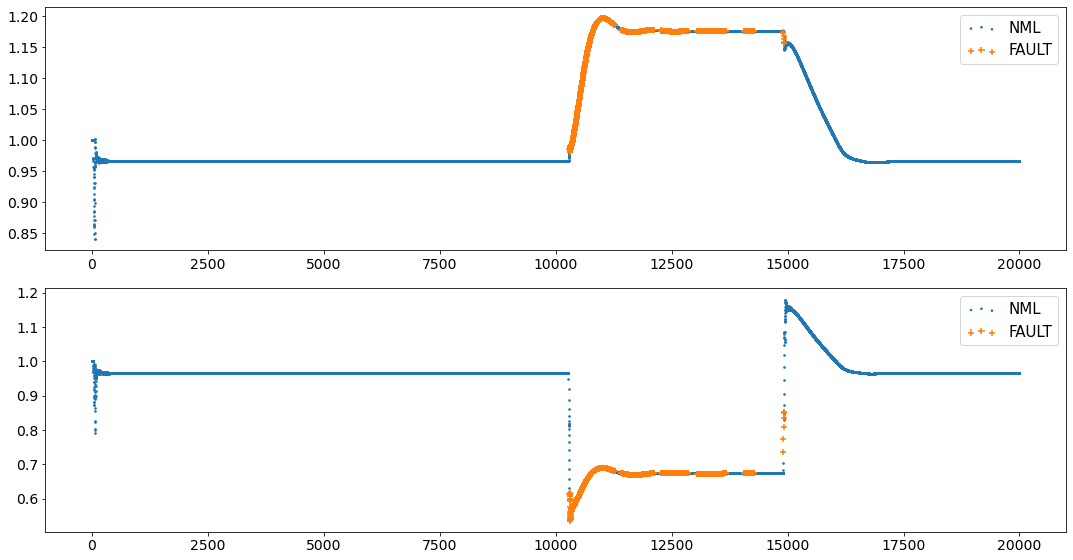

  Fault type Percentage
0         CG     100.0%


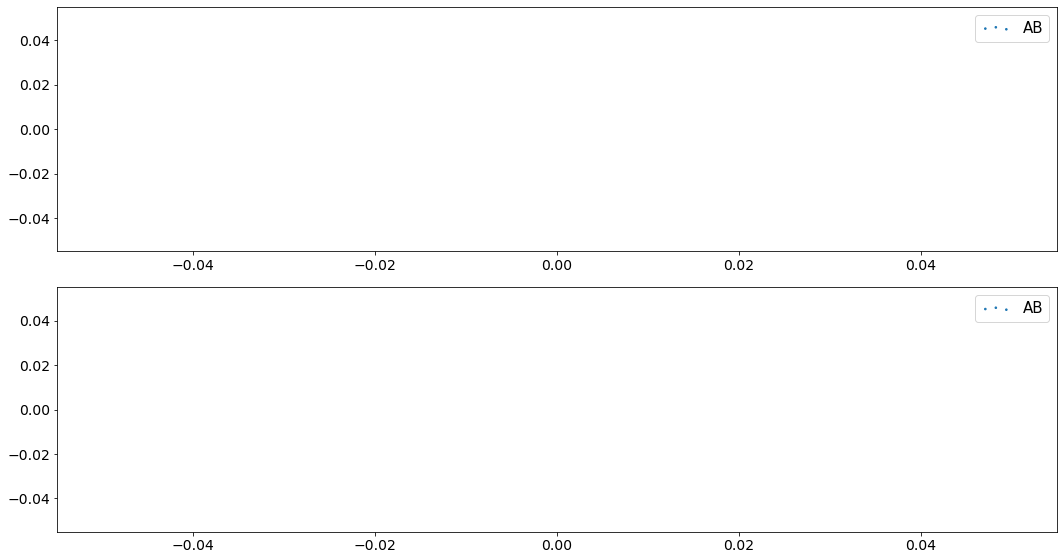


.
.
 7ABCG.csv
  Fault type Percentage
0        NML     95.84%
1      FAULT      4.16%


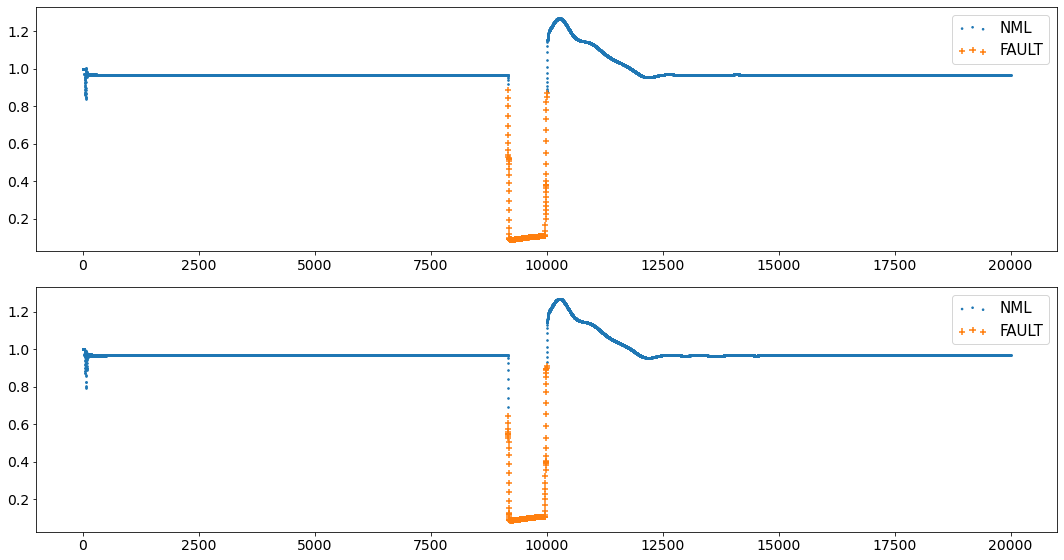

  Fault type Percentage
0        ABC      87.5%
1       ABCG     10.22%
2        BCG      1.32%
3        ABG      0.72%
4        ACG      0.24%


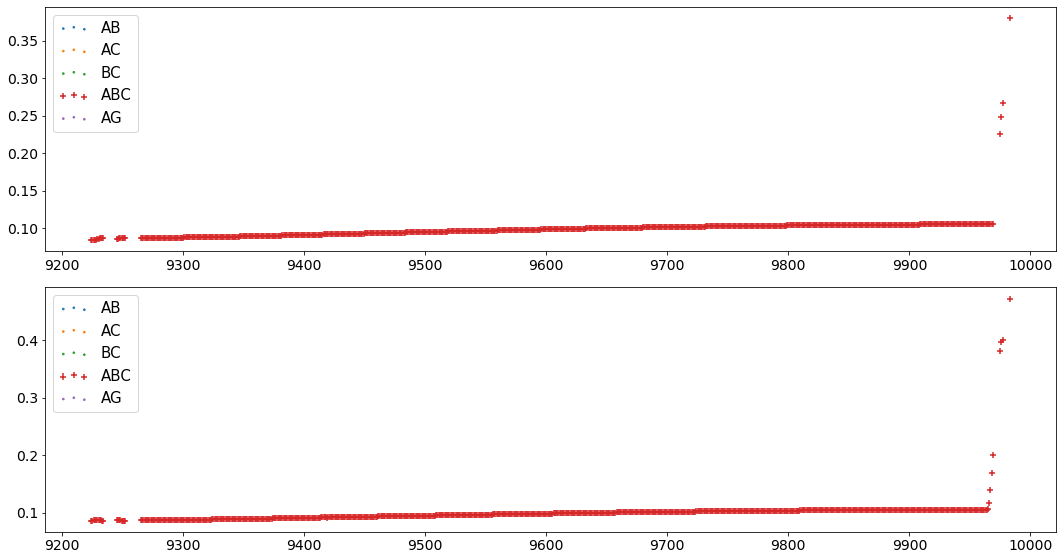


.
.
 9BCG.csv
  Fault type Percentage
0        NML      85.0%
1      FAULT     14.99%


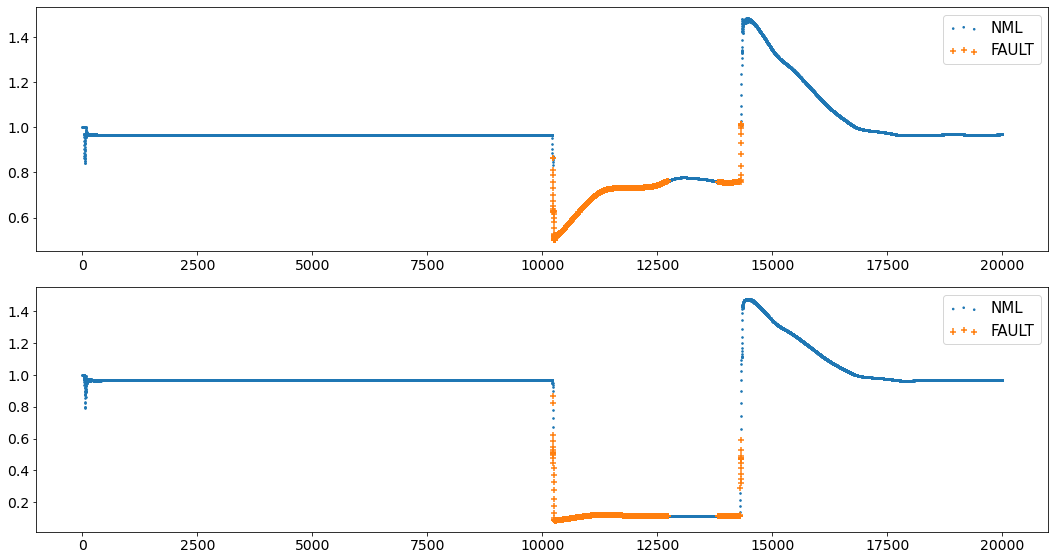

  Fault type Percentage
0        BCG     99.87%
1         CG      0.07%
2       ABCG      0.07%


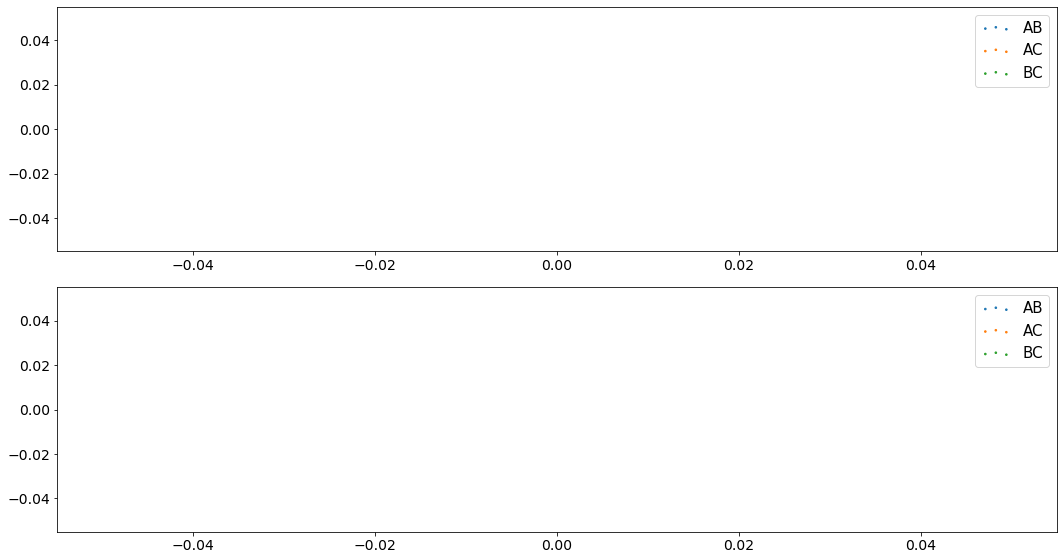


.
.
 10AG.csv
  Fault type Percentage
0        NML      91.3%
1      FAULT      8.71%


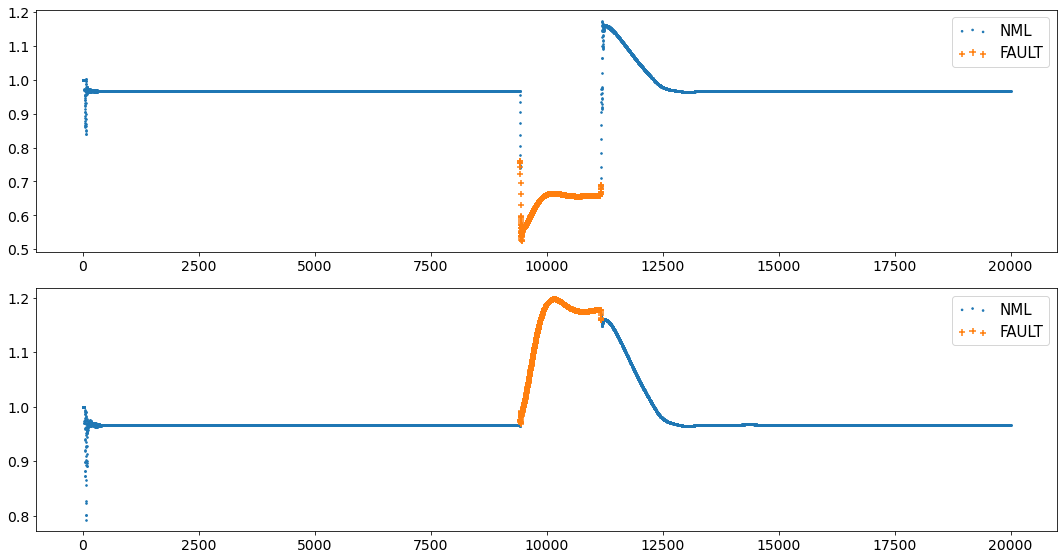

  Fault type Percentage
0         AG     100.0%


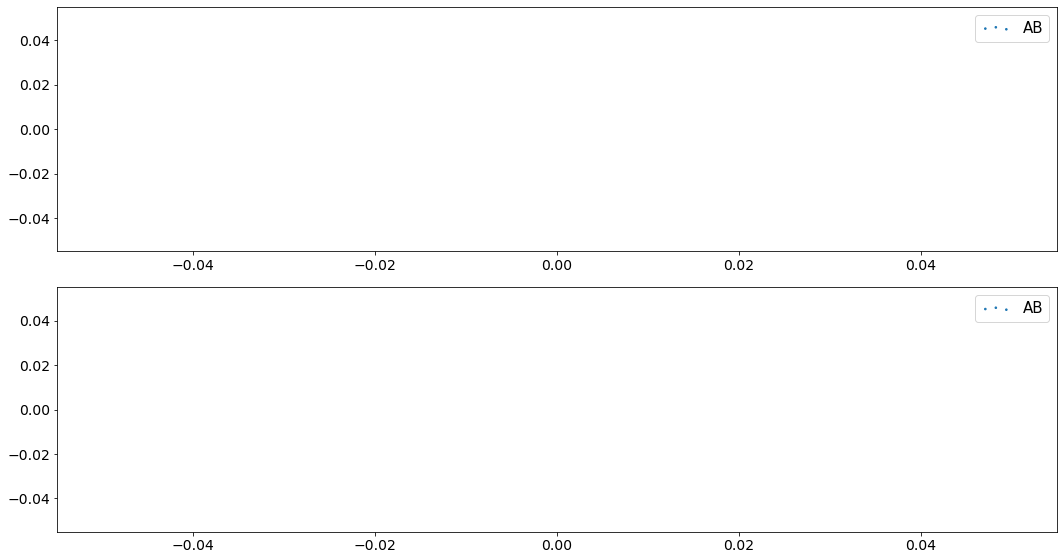


.
.
 3ABC.csv
  Fault type Percentage
0        NML     96.81%
1      FAULT      3.19%


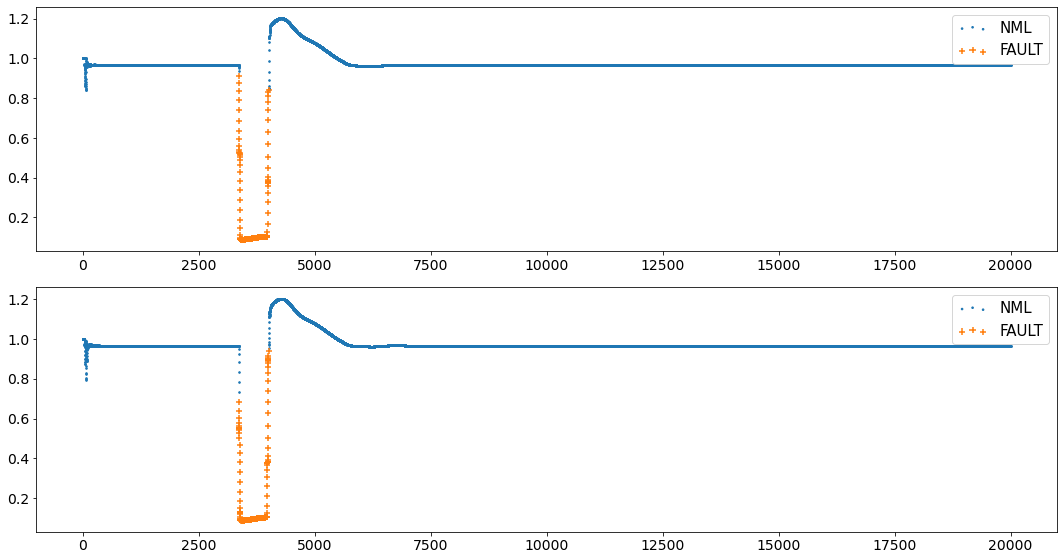

  Fault type Percentage
0        ABC      82.6%
1       ABCG     13.64%
2        BCG      1.72%
3        ABG      1.41%
4        ACG      0.47%
5         CG      0.16%


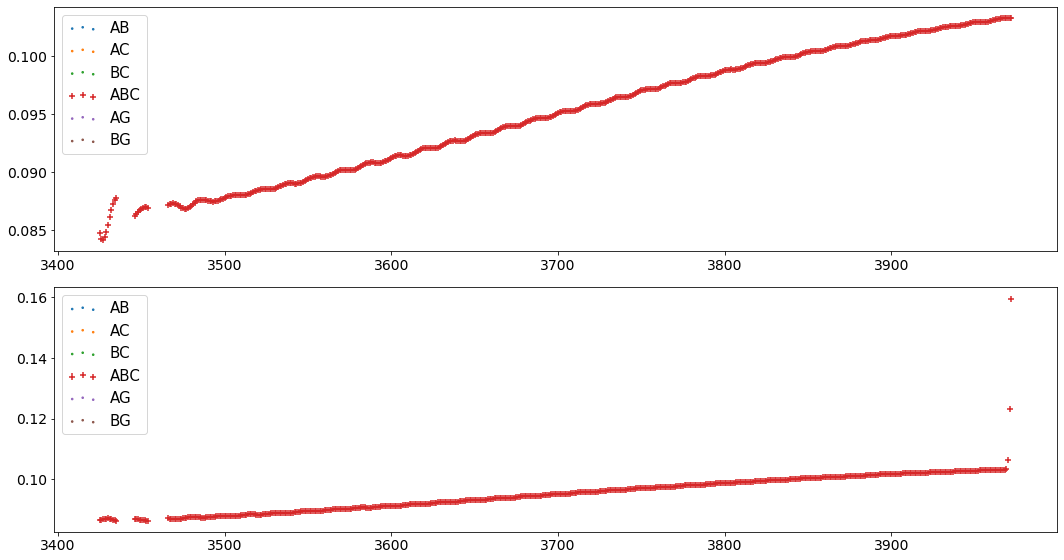


.
.
 3ACG.csv
  Fault type Percentage
0        NML     85.79%
1      FAULT     14.21%


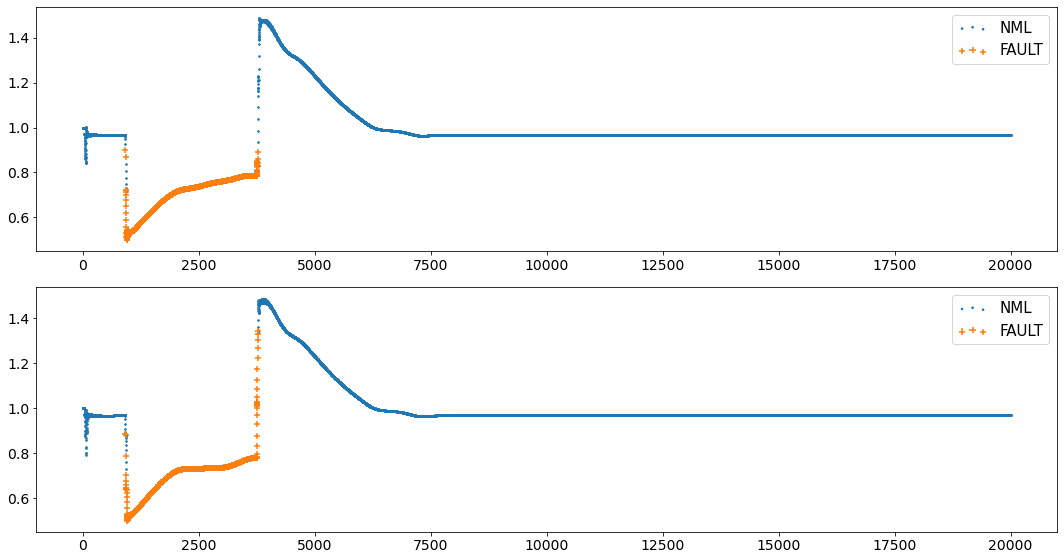

  Fault type Percentage
0        ACG     99.89%
1       ABCG      0.07%
2         AG      0.04%


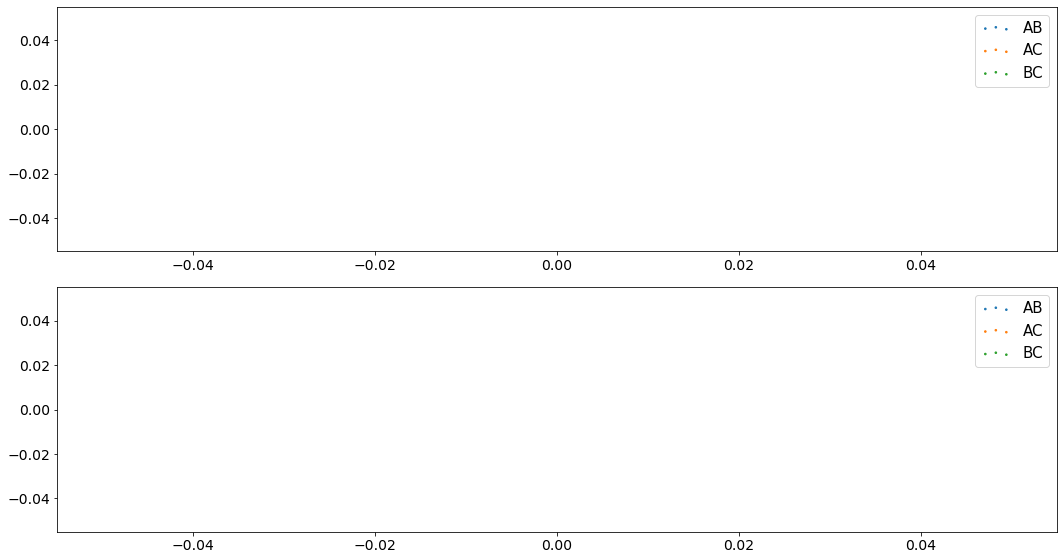


.
.
 8AC.csv
  Fault type Percentage
0        NML     93.22%
1      FAULT      6.79%


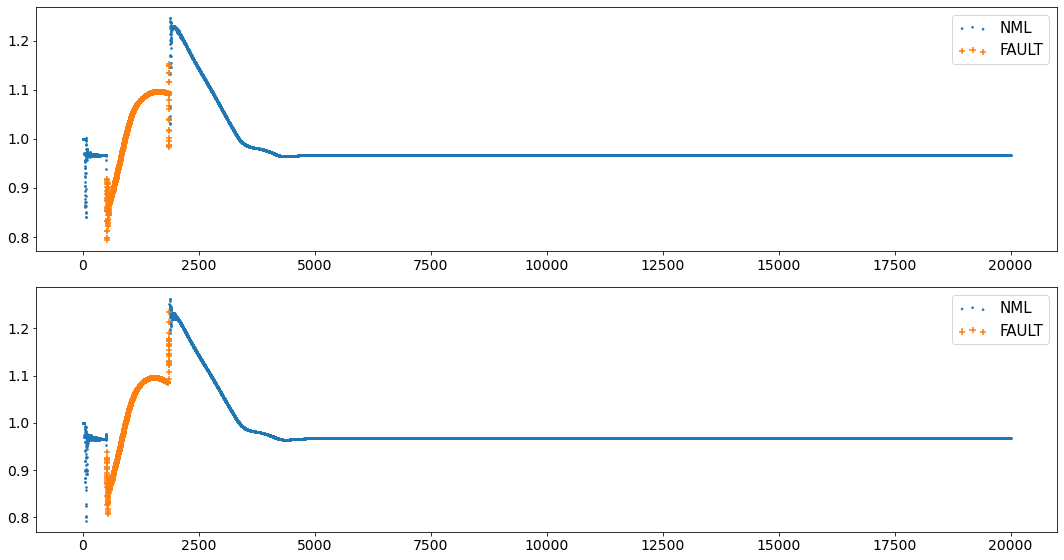

  Fault type Percentage
0         AC     99.63%
1        ACG      0.22%
2         CG      0.15%


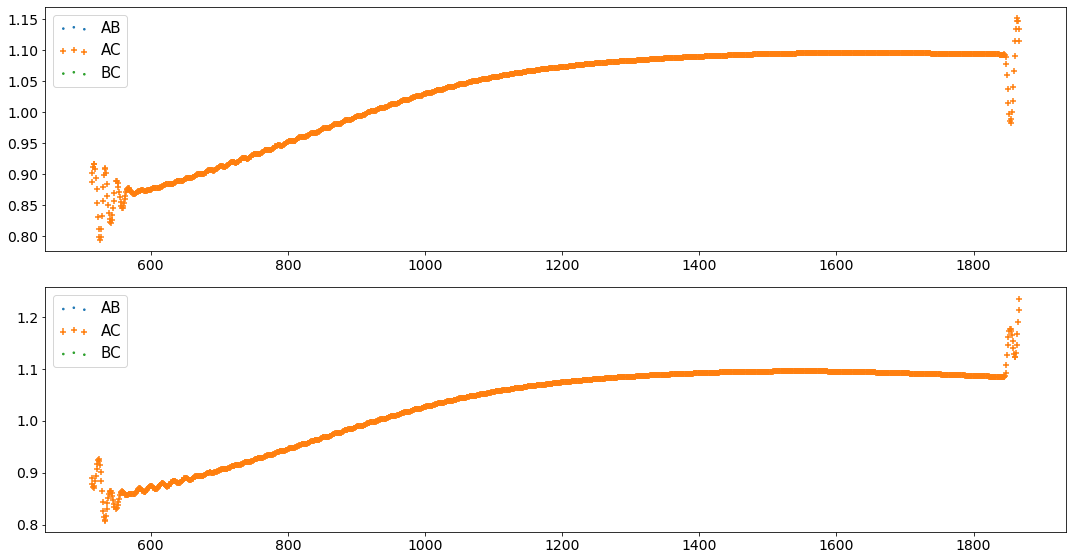


.
.
 4BC.csv
  Fault type Percentage
0        NML     84.78%
1      FAULT     15.22%


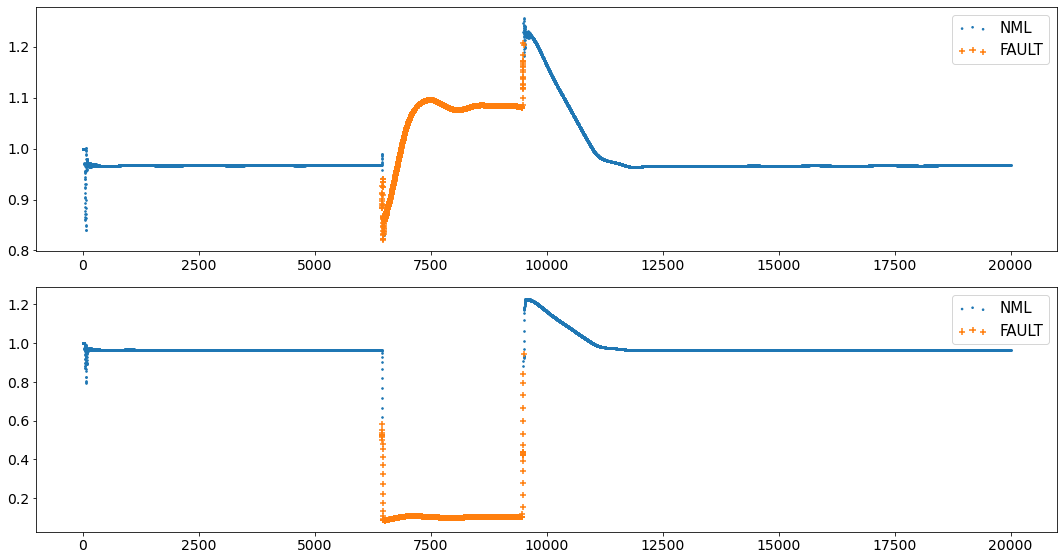

  Fault type Percentage
0         BC     99.93%
1       ABCG      0.03%
2        BCG      0.03%


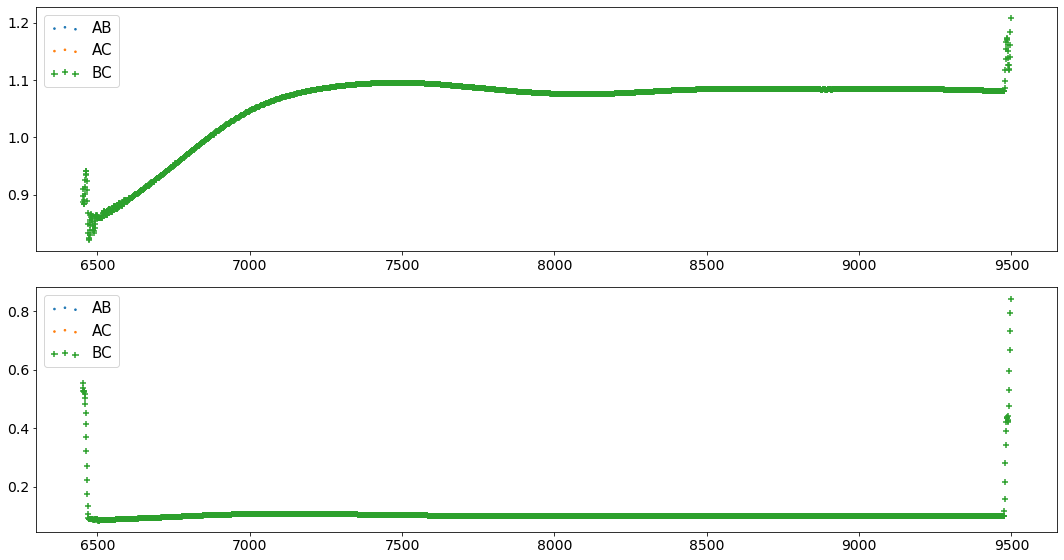


.
.
 4CG.csv
  Fault type Percentage
0        NML     92.53%
1      FAULT      7.47%


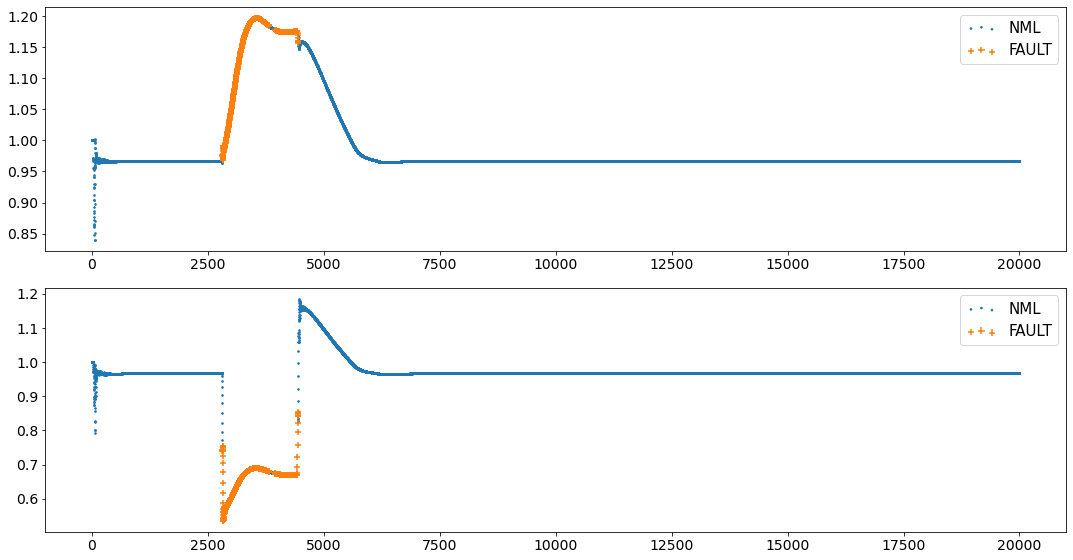

  Fault type Percentage
0         CG     100.0%


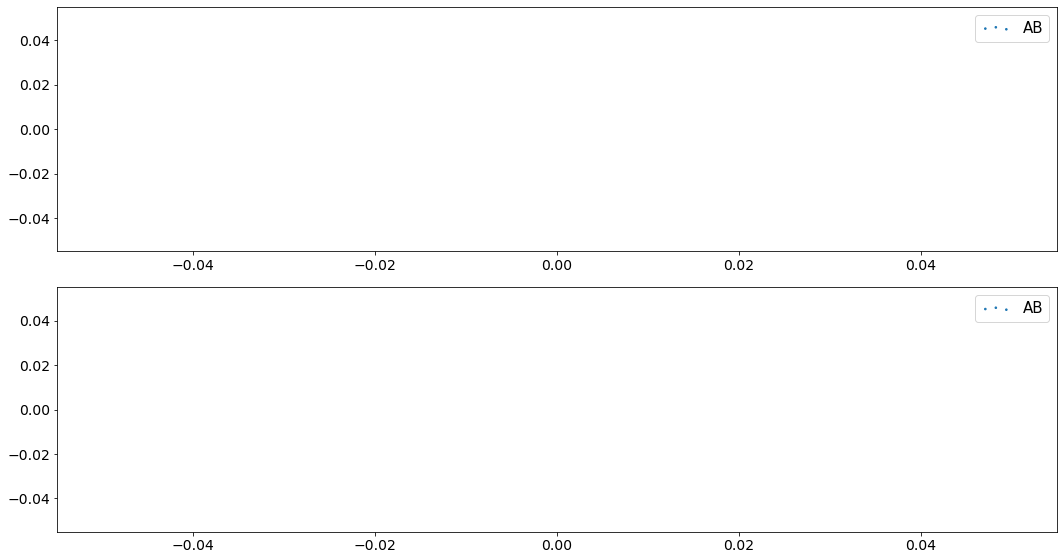


.
.
 1ABG.csv
  Fault type Percentage
0        NML     77.75%
1      FAULT     22.25%


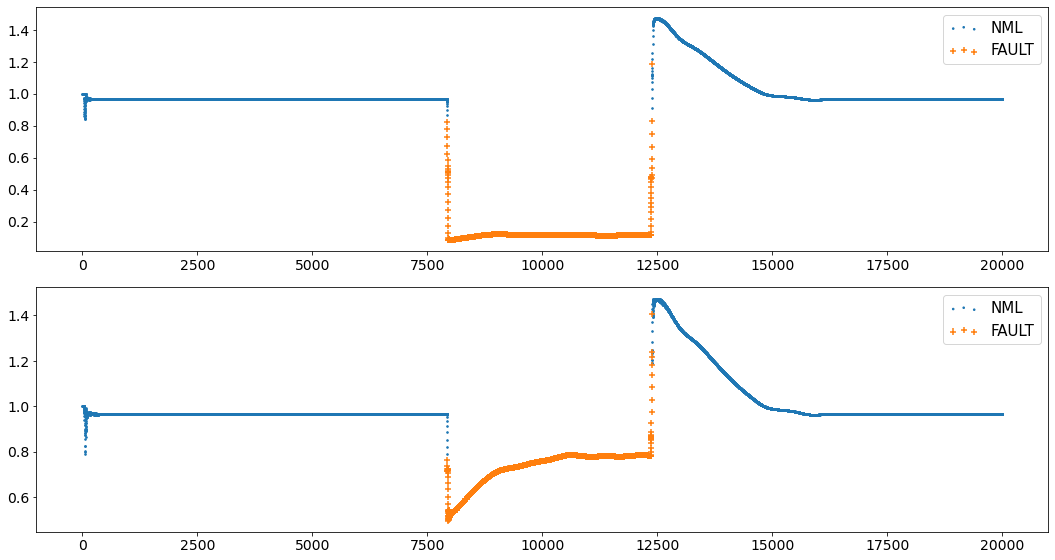

  Fault type Percentage
0        ABG     99.75%
1        BCG      0.13%
2         AB      0.07%
3         CG      0.02%
4       ABCG      0.02%


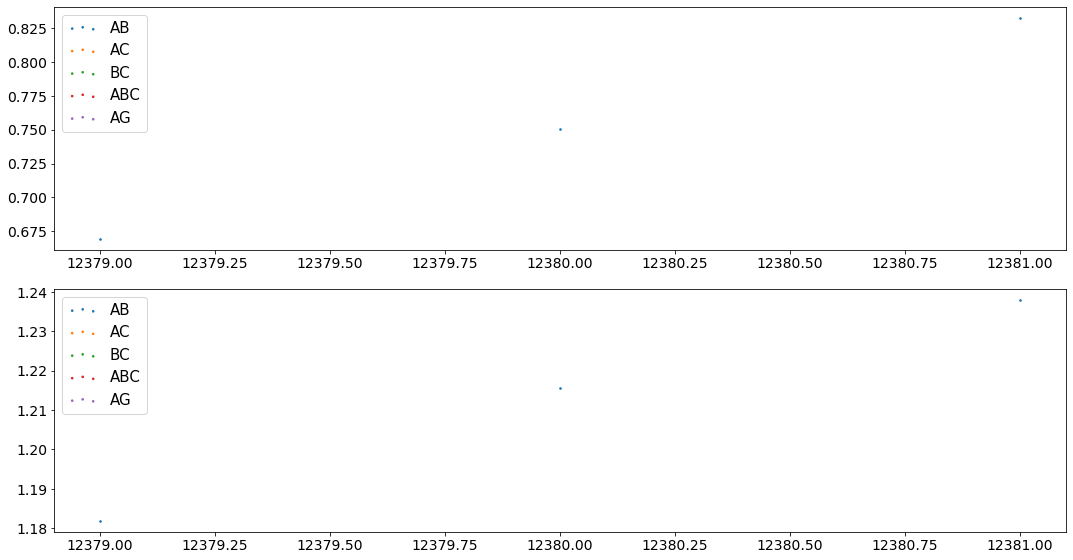


.
.
 8AB.csv
  Fault type Percentage
0        NML     97.98%
1      FAULT      2.02%


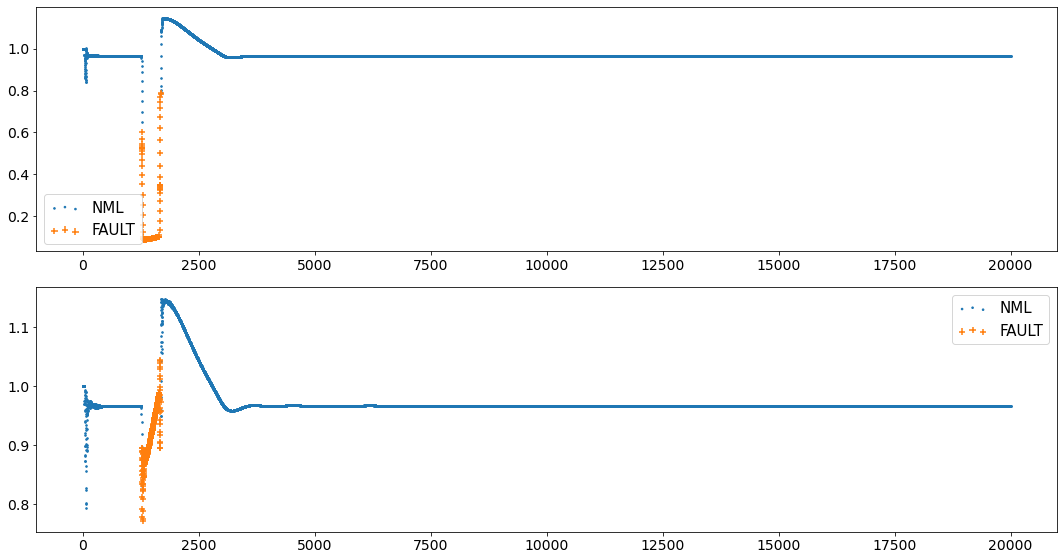

  Fault type Percentage
0         AB     96.04%
1        ABG      2.97%
2         AG       0.5%
3       ABCG       0.5%


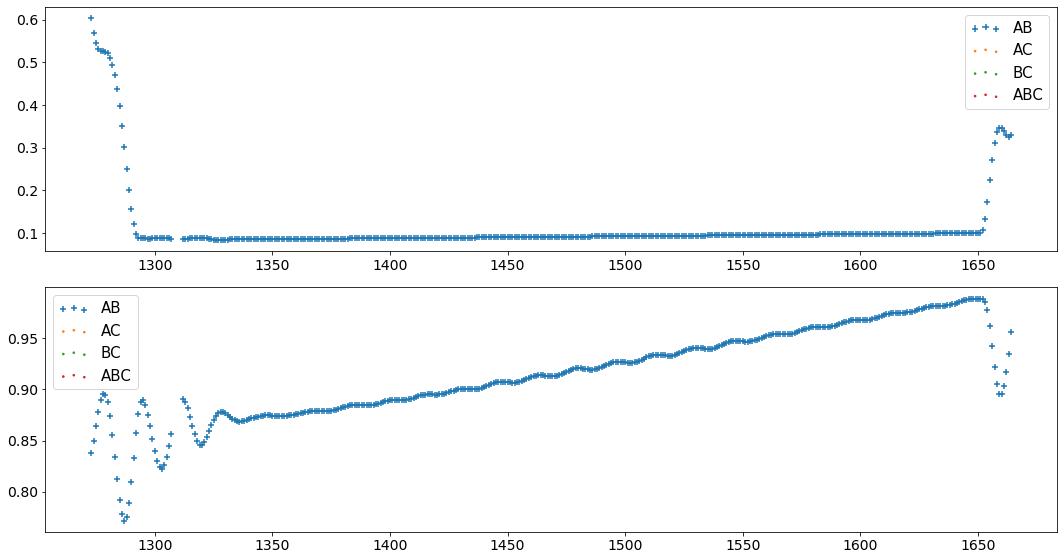


.
.
 10BCG.csv
  Fault type Percentage
0        NML     96.64%
1      FAULT      3.37%


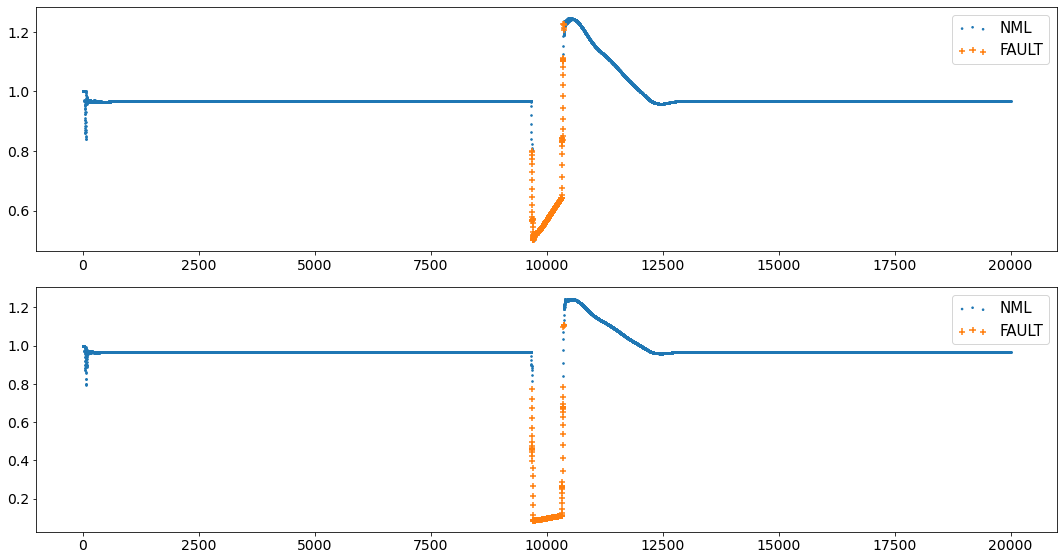

  Fault type Percentage
0        BCG     97.18%
1       ABCG      1.93%
2         CG      0.89%


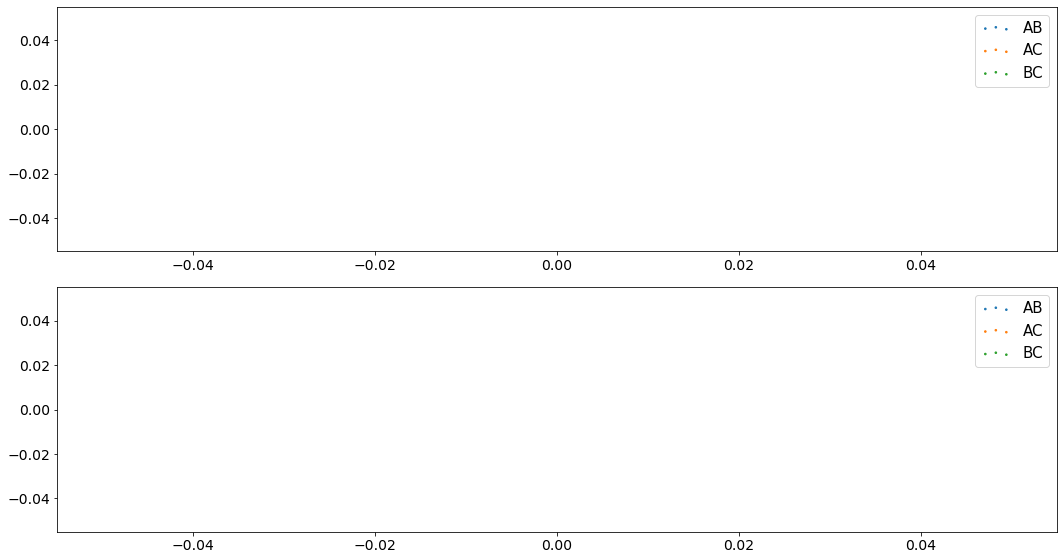


.
.
 8CG.csv
  Fault type Percentage
0        NML     99.36%
1      FAULT      0.65%


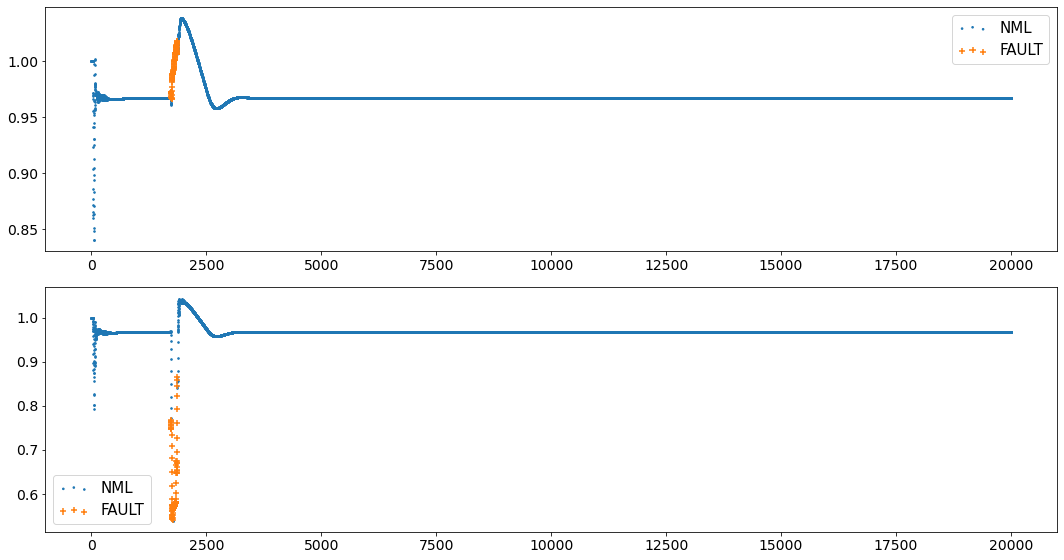

  Fault type Percentage
0         CG     100.0%


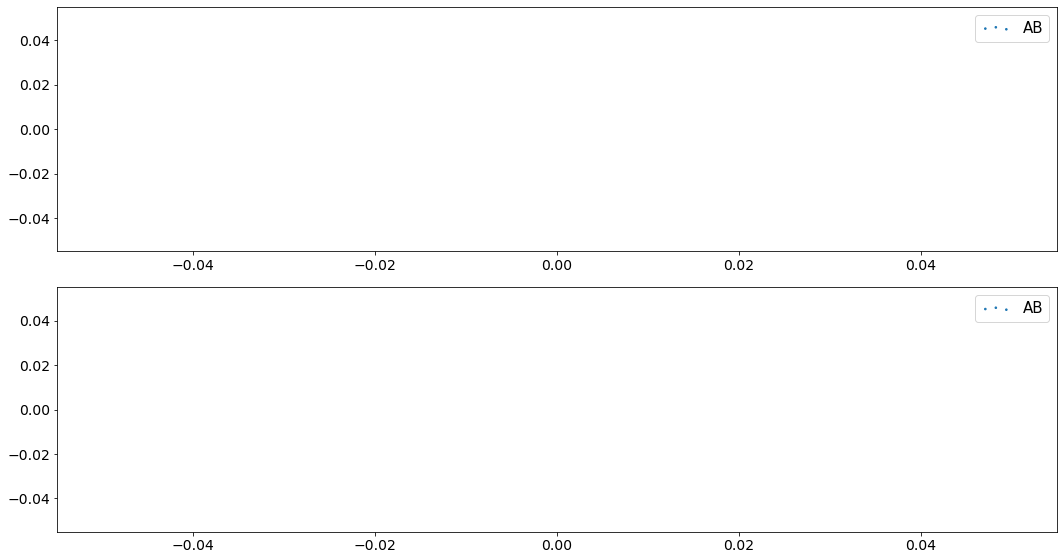


.
.
 8BC.csv
  Fault type Percentage
0        NML     99.81%
1      FAULT      0.19%


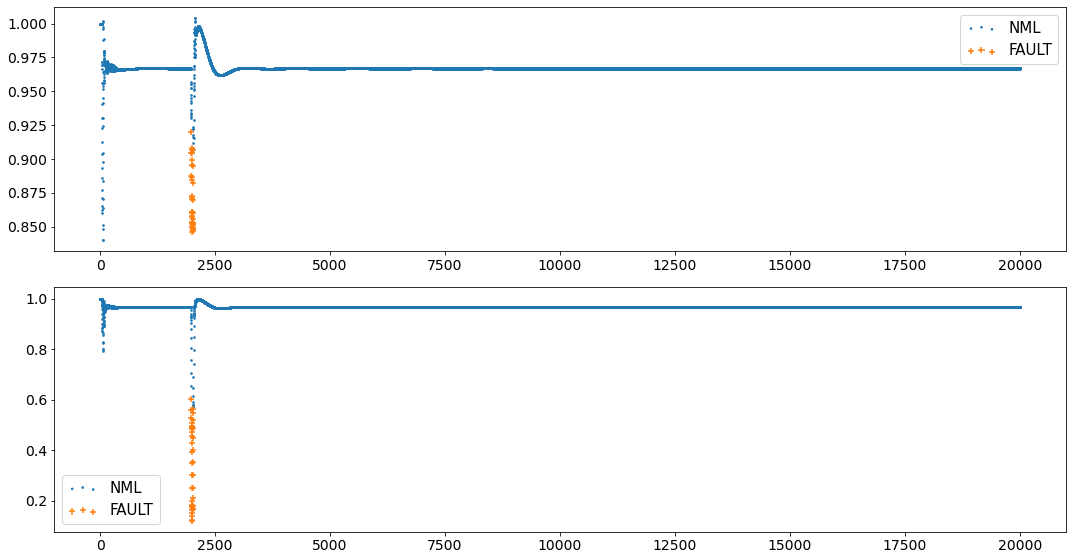

  Fault type Percentage
0         BC     92.11%
1        BCG      7.89%


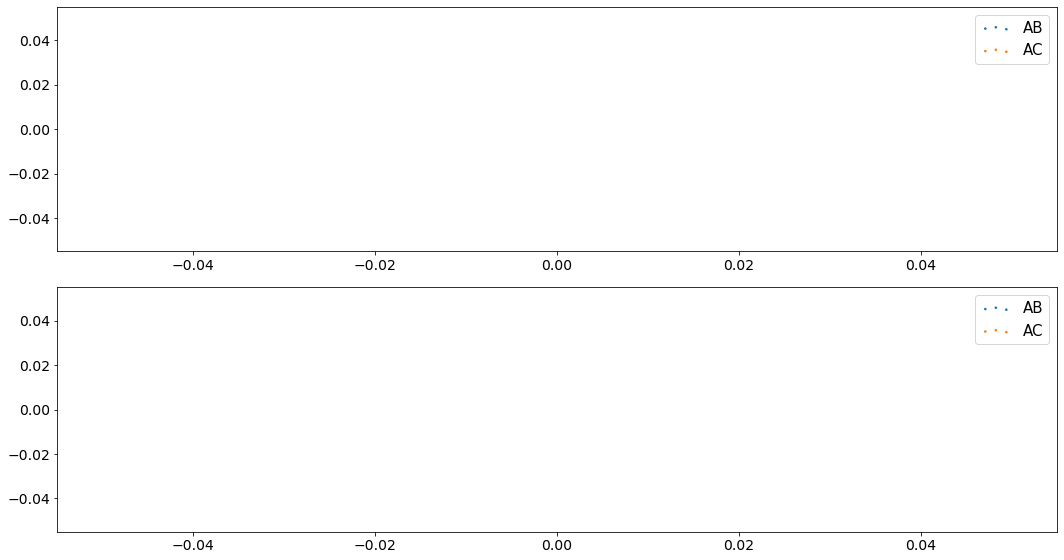


.
.
 4AB.csv
  Fault type Percentage
0        NML     97.64%
1      FAULT      2.35%


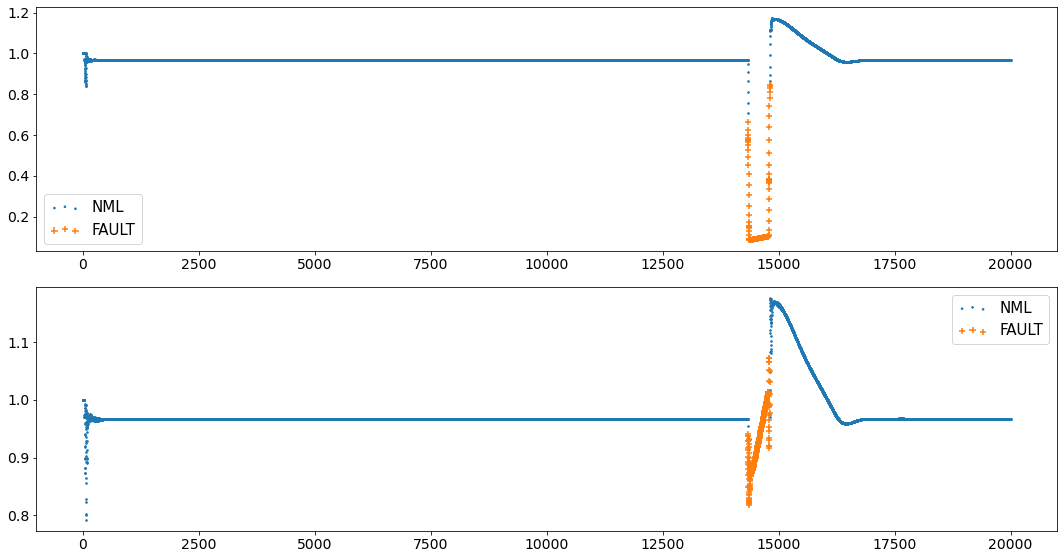

  Fault type Percentage
0         AB     96.39%
1        ABG      3.61%


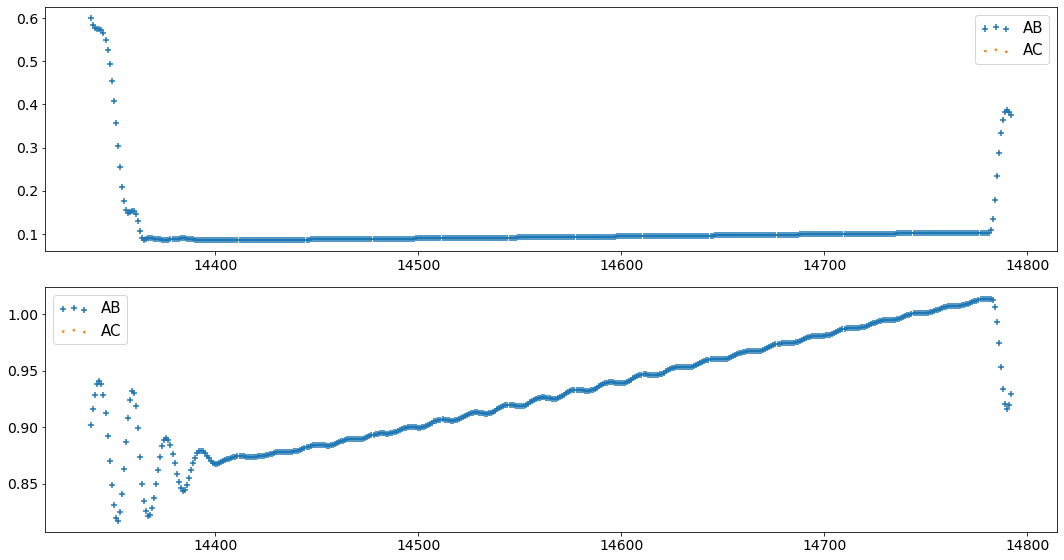


.
.
 6ACG.csv
  Fault type Percentage
0        NML     64.81%
1      FAULT      35.2%


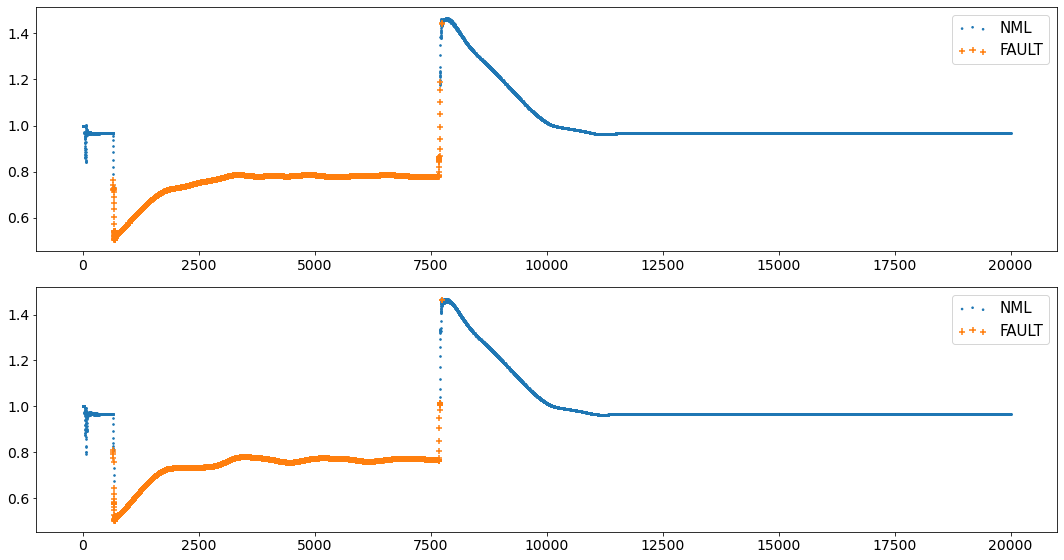

  Fault type Percentage
0        ACG      99.9%
1       ABCG      0.07%
2         CG      0.03%


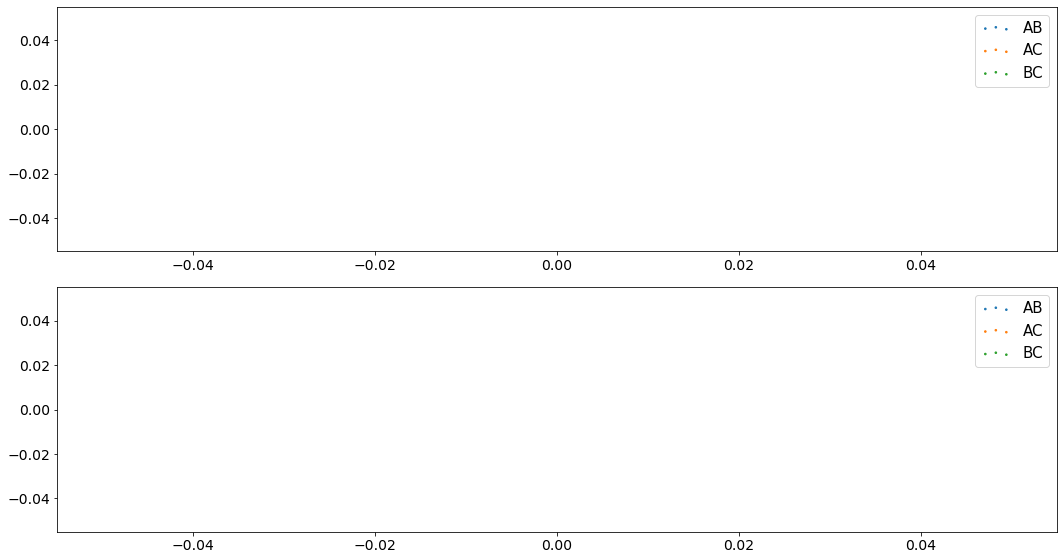


.
.
 6ABC.csv
  Fault type Percentage
0        NML     96.58%
1      FAULT      3.42%


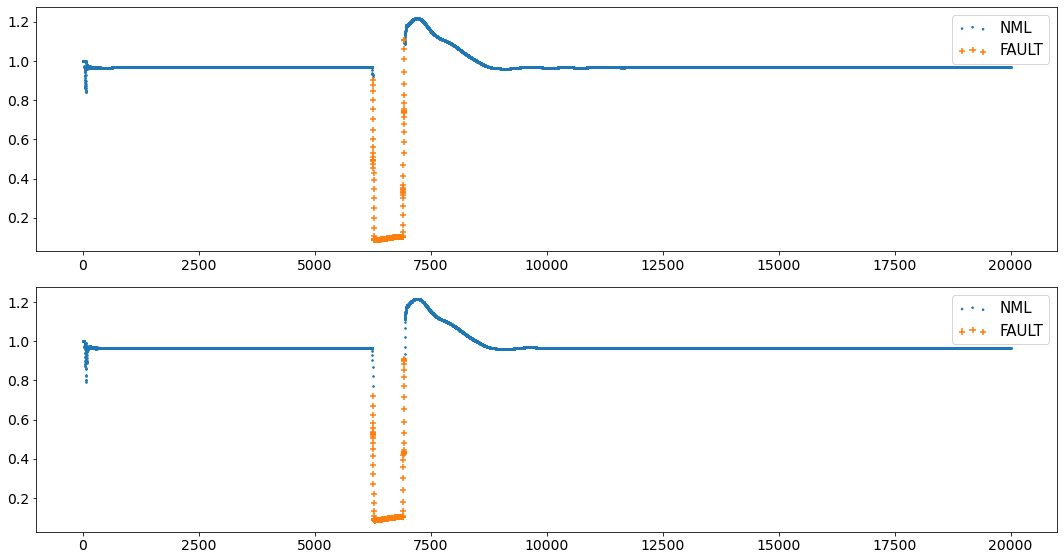

  Fault type Percentage
0        ABC     84.23%
1       ABCG     13.43%
2        BCG      1.75%
3         CG      0.29%
4        ACG      0.29%


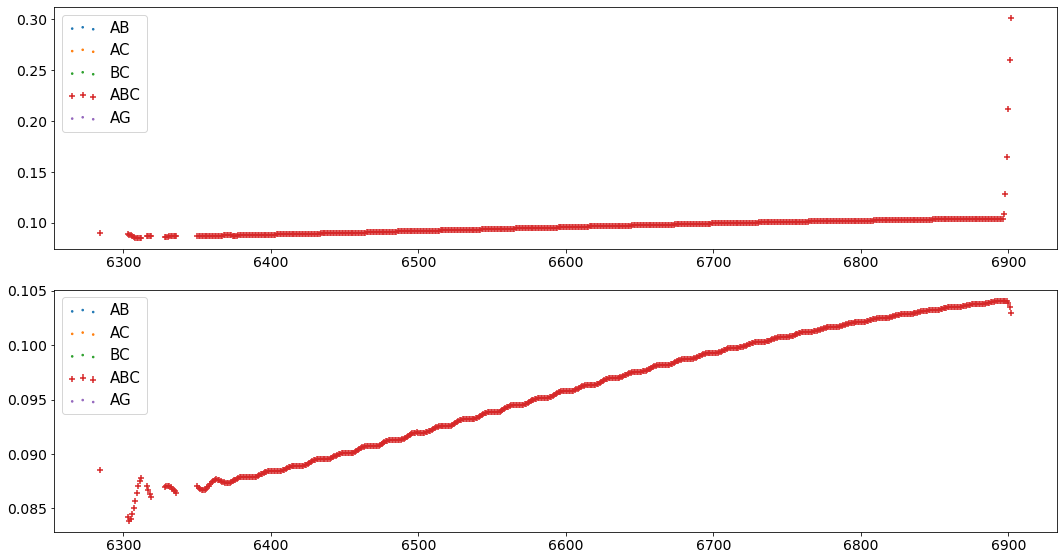


.
.
 8ABG.csv
  Fault type Percentage
0        NML     95.85%
1      FAULT      4.15%


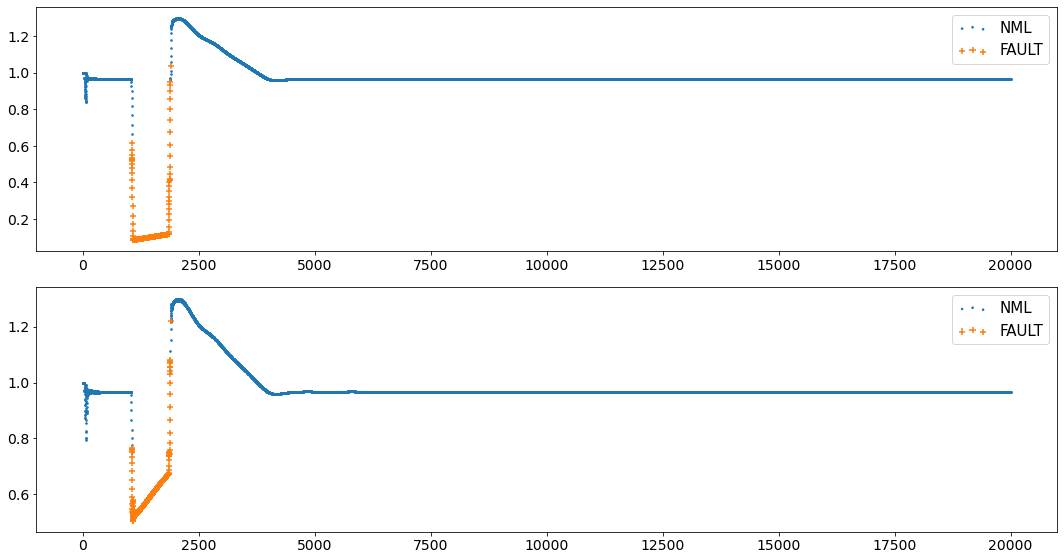

  Fault type Percentage
0        ABG     99.28%
1         AB      0.48%
2       ABCG      0.12%
3        BCG      0.12%


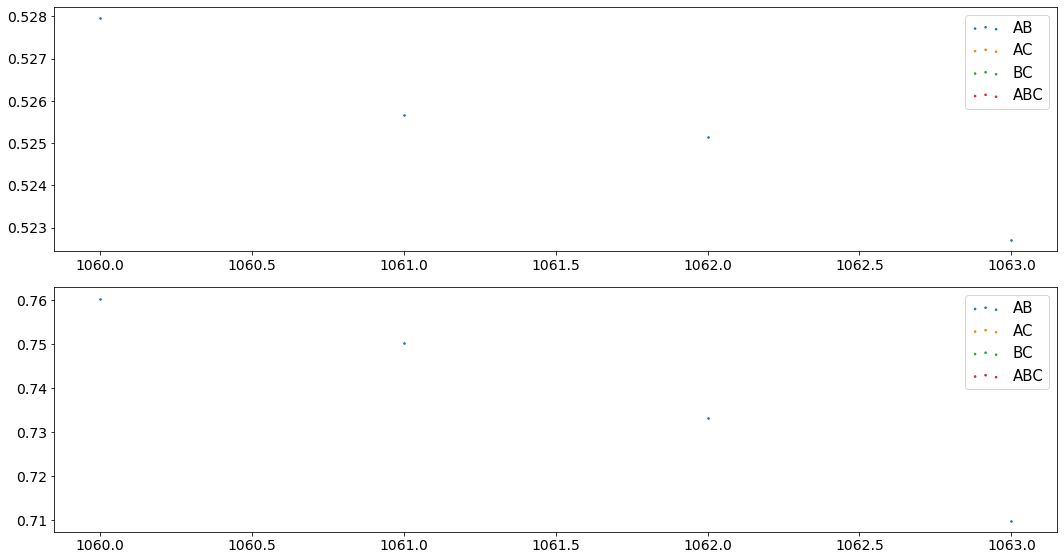


.
.
 4AC.csv
  Fault type Percentage
0        NML     96.75%
1      FAULT      3.25%


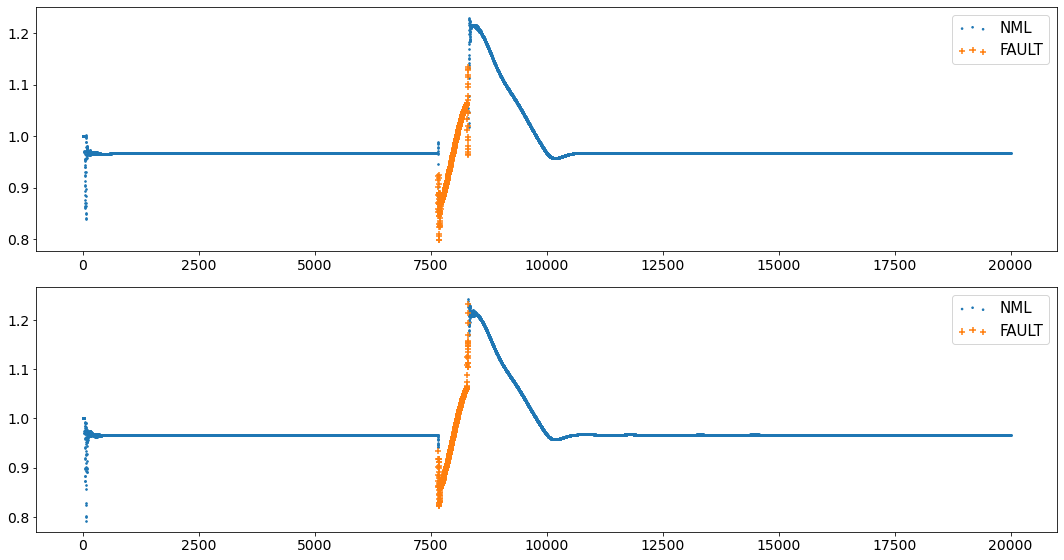

  Fault type Percentage
0         AC     97.24%
1        ACG      2.76%


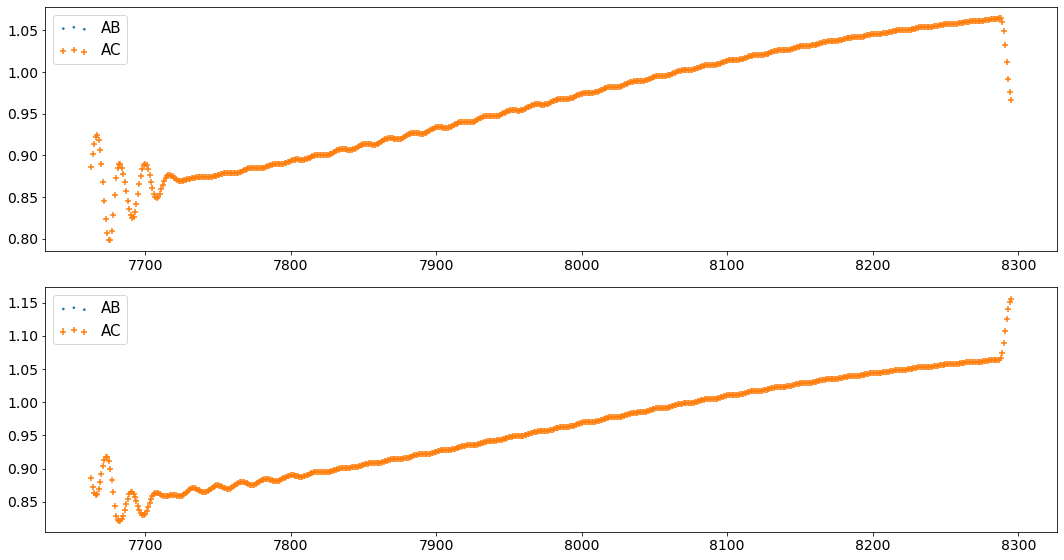


.
.
 4ABG.csv
  Fault type Percentage
0        NML     91.39%
1      FAULT      8.62%


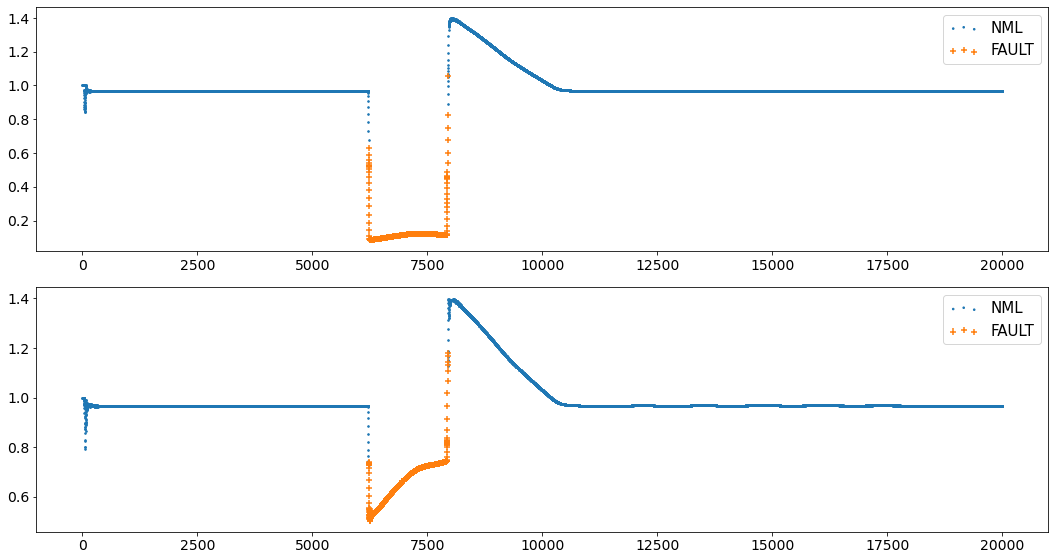

  Fault type Percentage
0        ABG     99.83%
1        BCG      0.12%
2         AG      0.06%


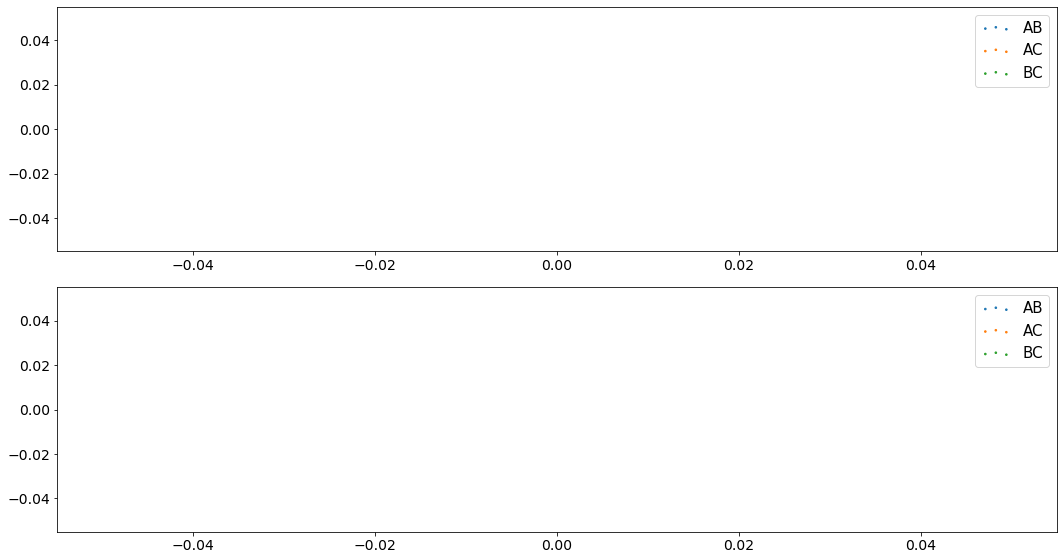


.
.
 2AG.csv
  Fault type Percentage
0        NML     95.09%
1      FAULT      4.91%


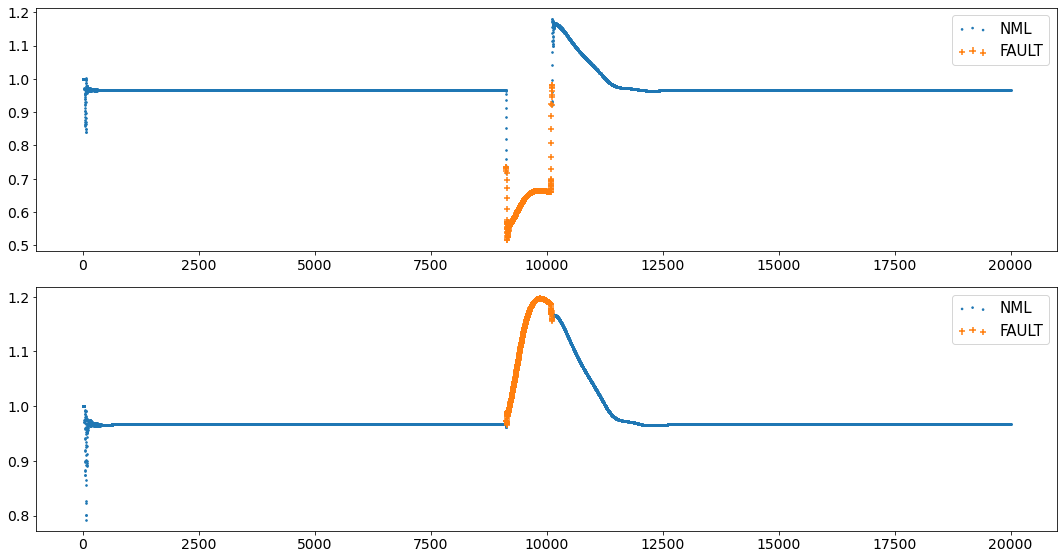

  Fault type Percentage
0         AG     100.0%


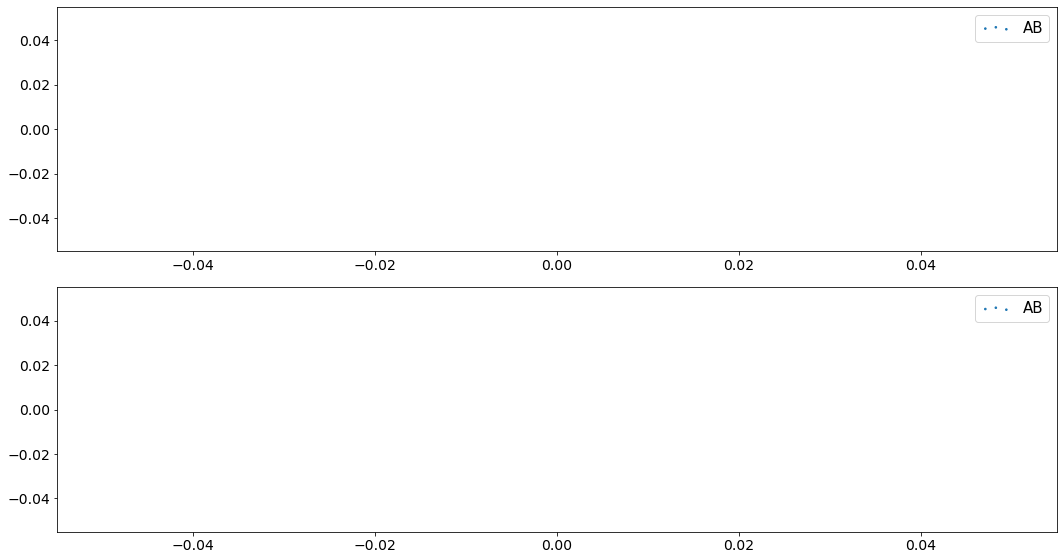


.
.
 6AC.csv
  Fault type Percentage
0        NML     96.67%
1      FAULT      3.33%


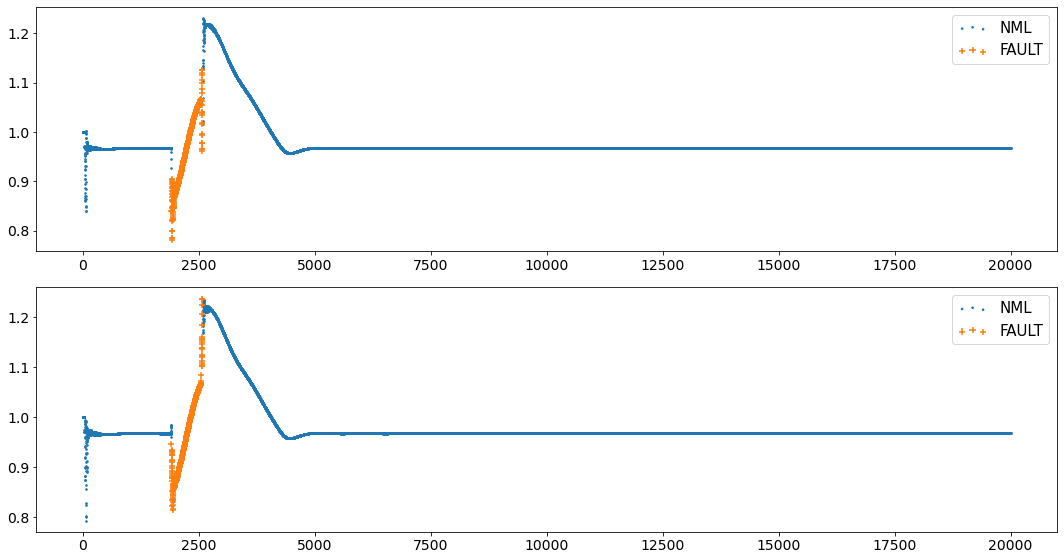

  Fault type Percentage
0         AC     97.15%
1        ACG       2.7%
2         CG      0.15%


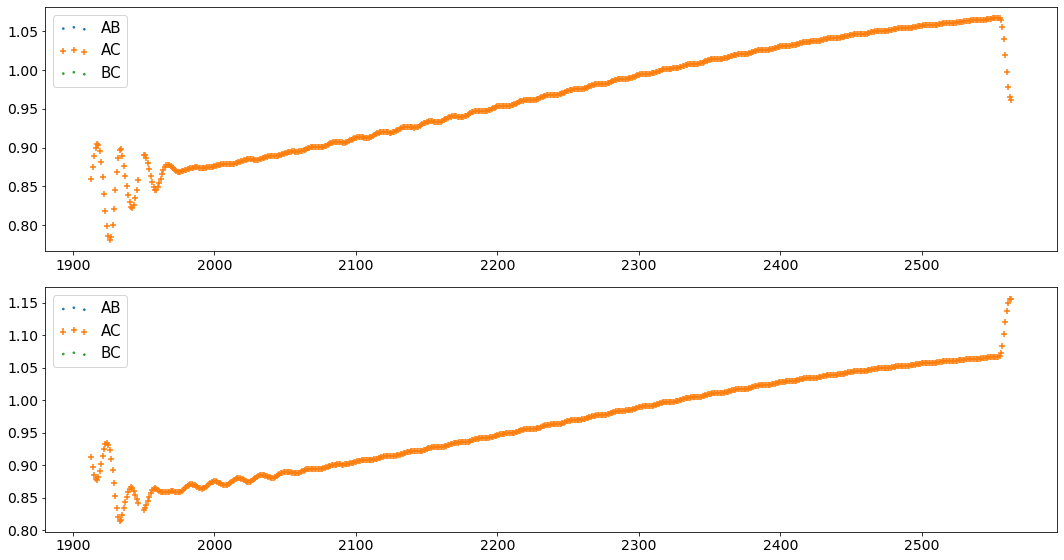


.
.
 6AB.csv
  Fault type Percentage
0        NML     93.32%
1      FAULT      6.68%


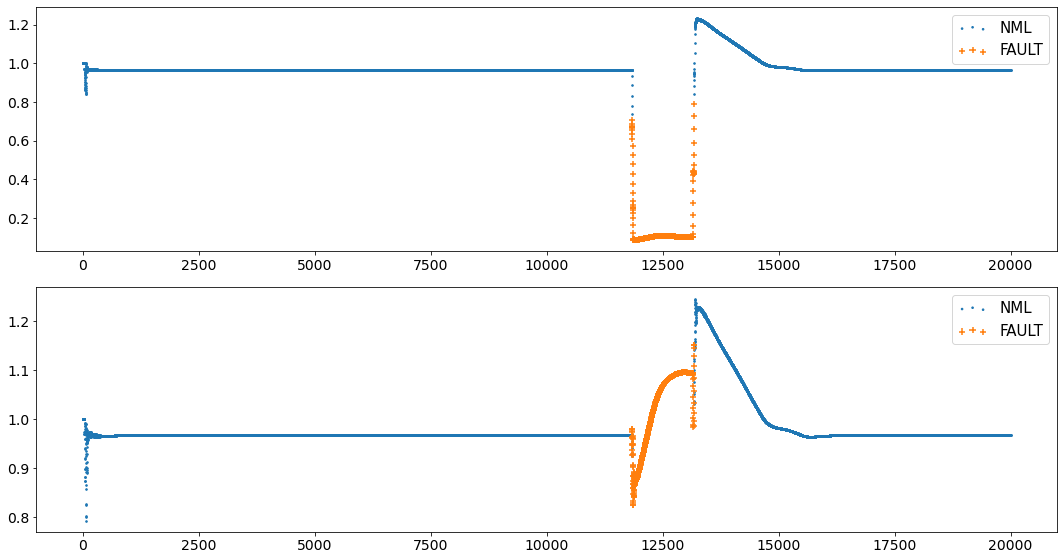

  Fault type Percentage
0         AB     99.78%
1        ABG      0.22%


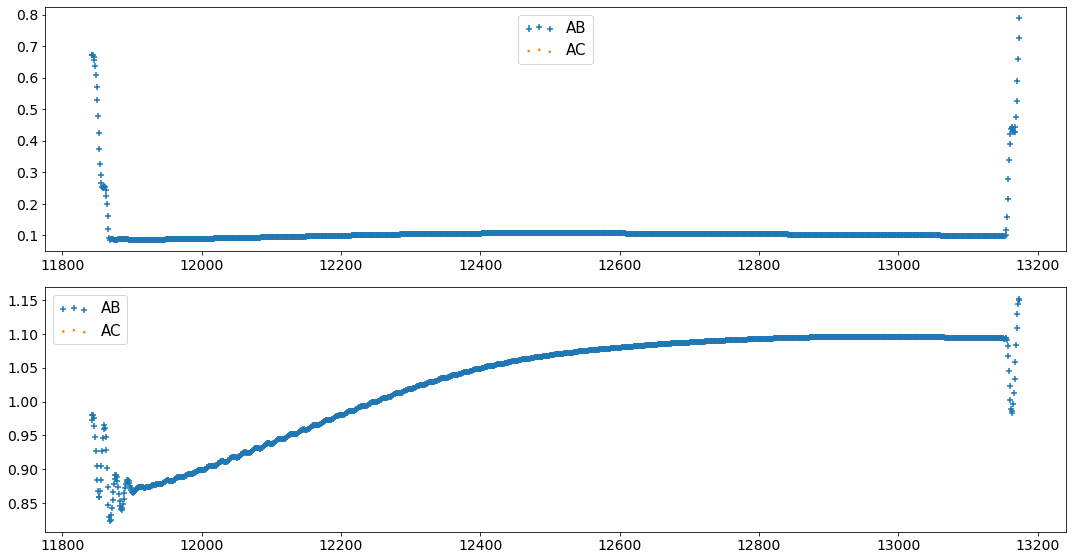


.
.
 2ABCG.csv
  Fault type Percentage
0        NML     73.15%
1      FAULT     26.85%


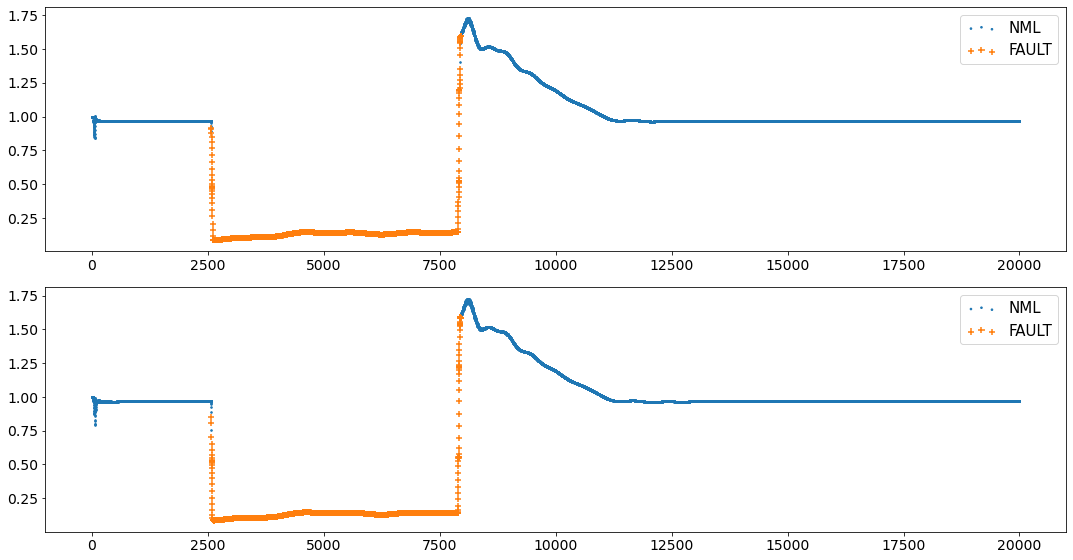

  Fault type Percentage
0        ABC     97.75%
1       ABCG      2.09%
2        ACG      0.09%
3        BCG      0.04%
4         CG      0.04%


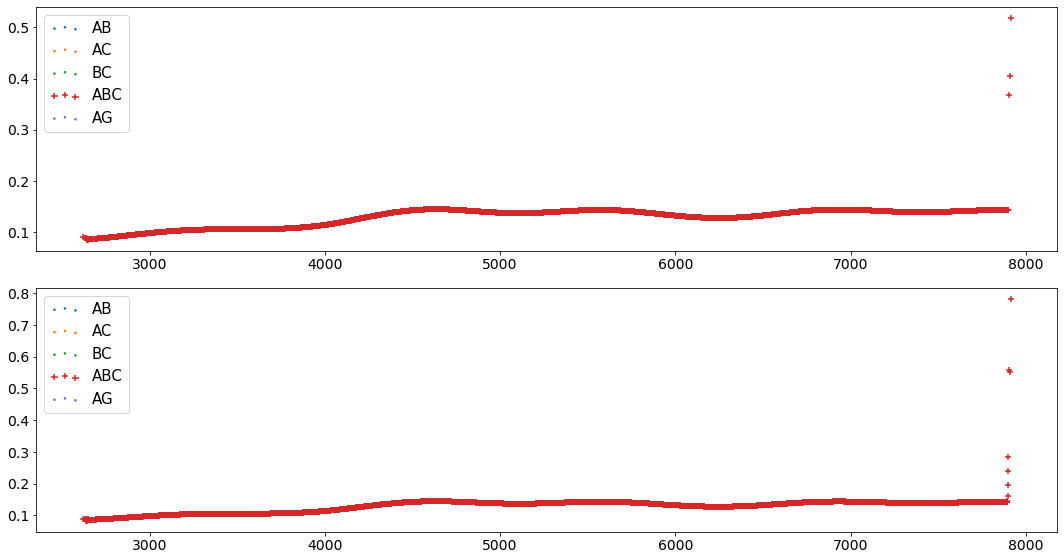


.
.
 10BG.csv
  Fault type Percentage
0        NML     97.64%
1      FAULT      2.36%


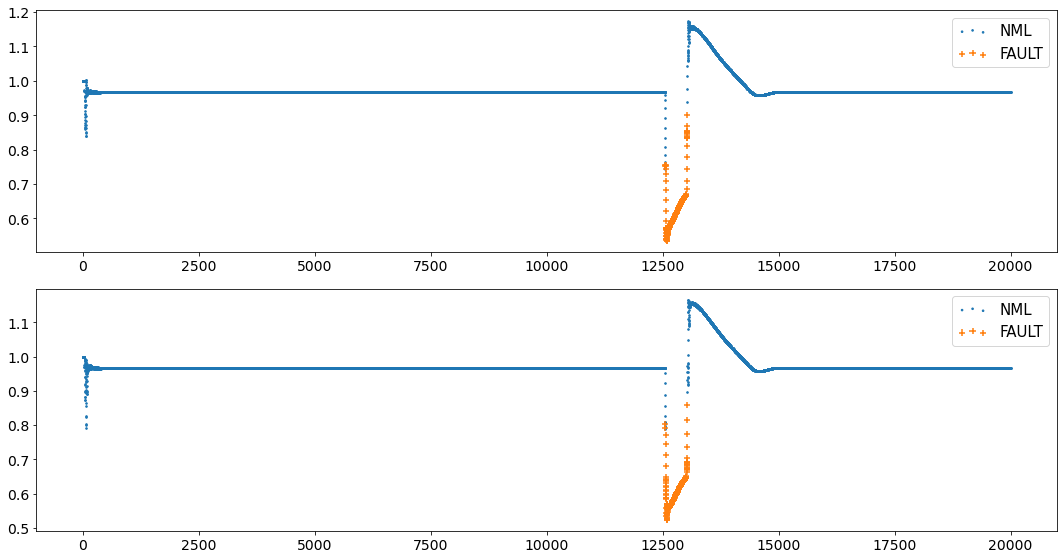

  Fault type Percentage
0         BG     100.0%


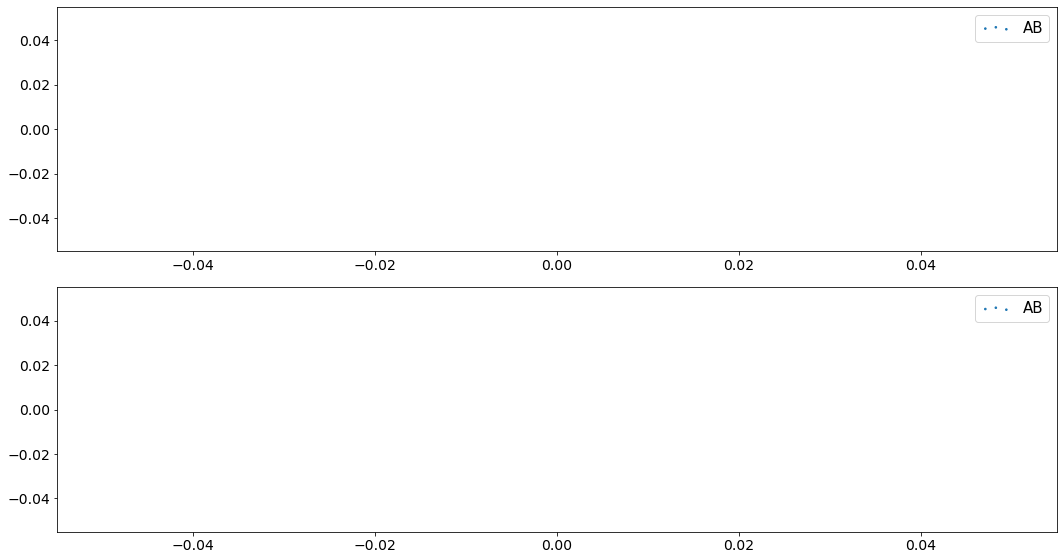


.
.
 2AB.csv
  Fault type Percentage
0        NML     86.15%
1      FAULT     13.85%


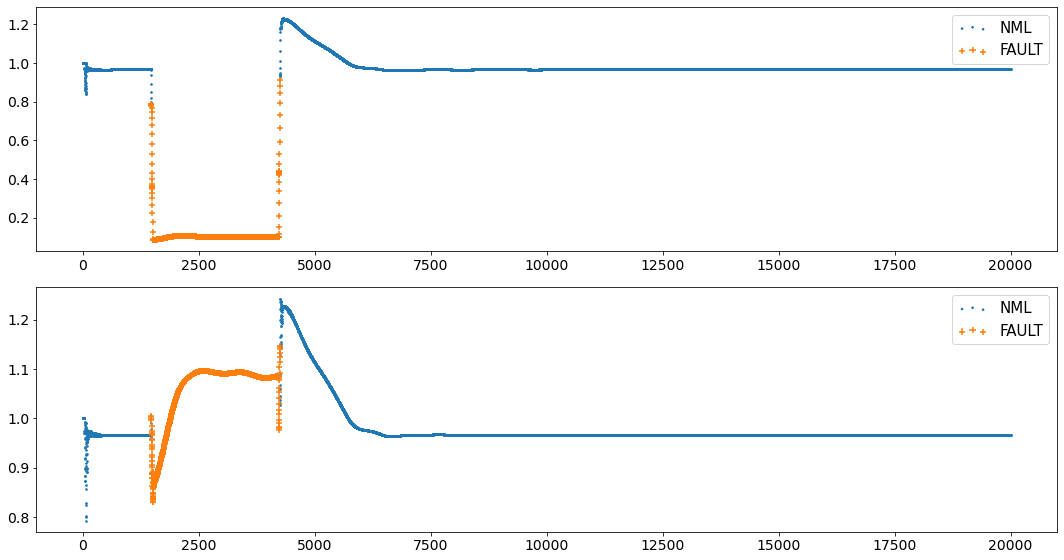

  Fault type Percentage
0         AB     99.68%
1        ABG      0.32%


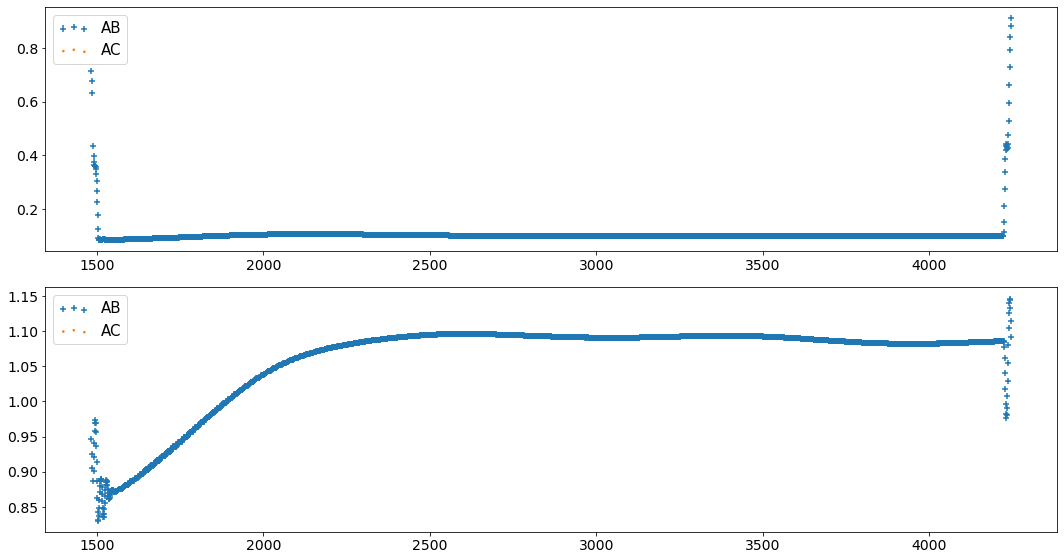


.
.
 2BCG.csv
  Fault type Percentage
0        NML     99.63%
1      FAULT      0.37%


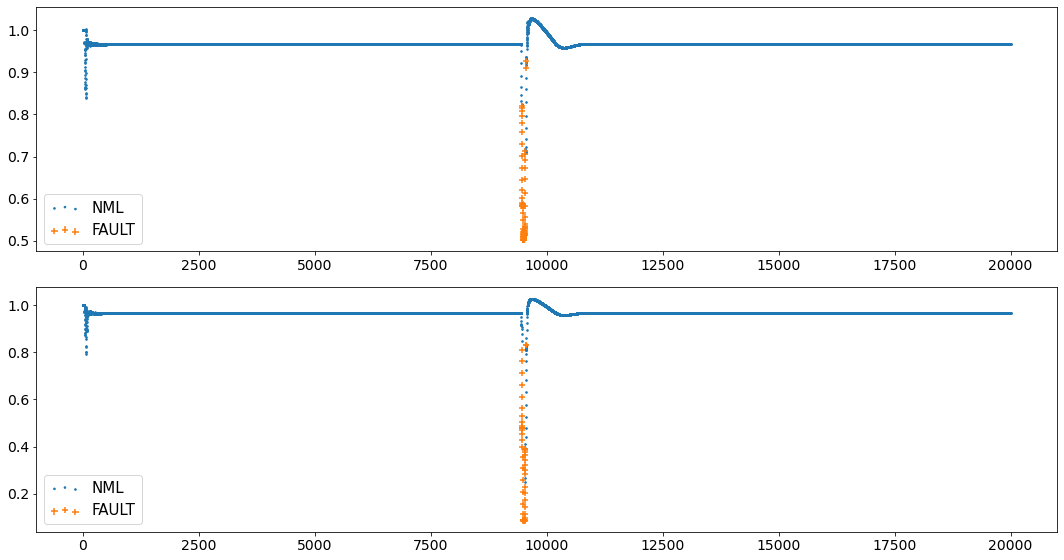

  Fault type Percentage
0        BCG     83.78%
1       ABCG      6.76%
2         BG      5.41%
3         CG       2.7%
4         BC      1.35%


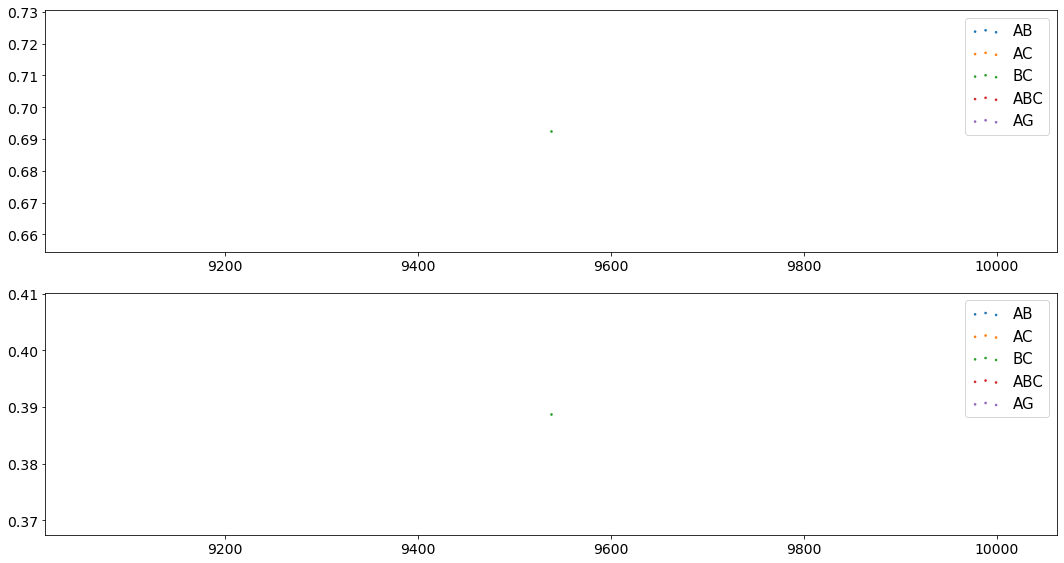


.
.
 10BC.csv
  Fault type Percentage
0        NML     89.89%
1      FAULT     10.12%


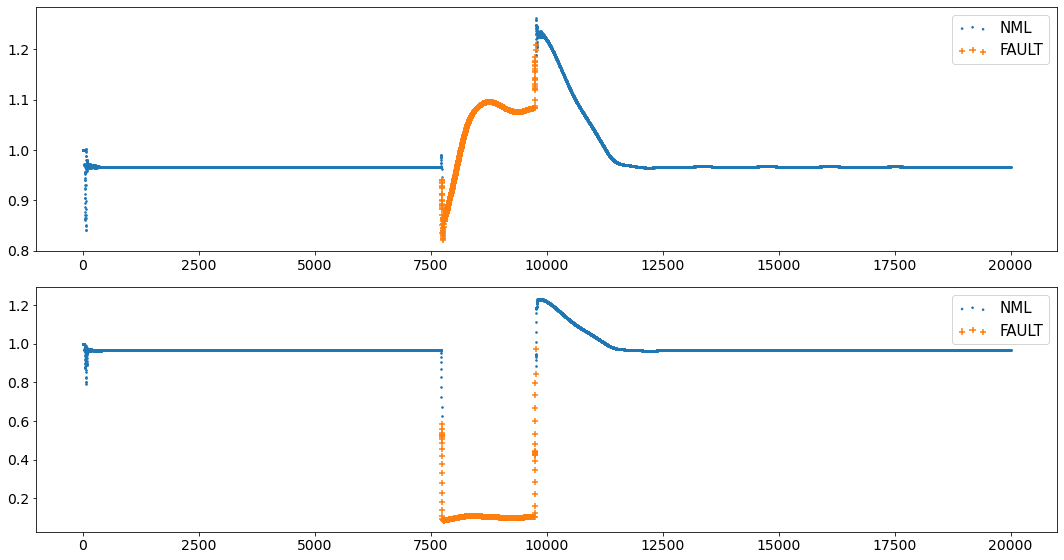

  Fault type Percentage
0         BC     99.85%
1        BCG       0.1%
2         AB      0.05%


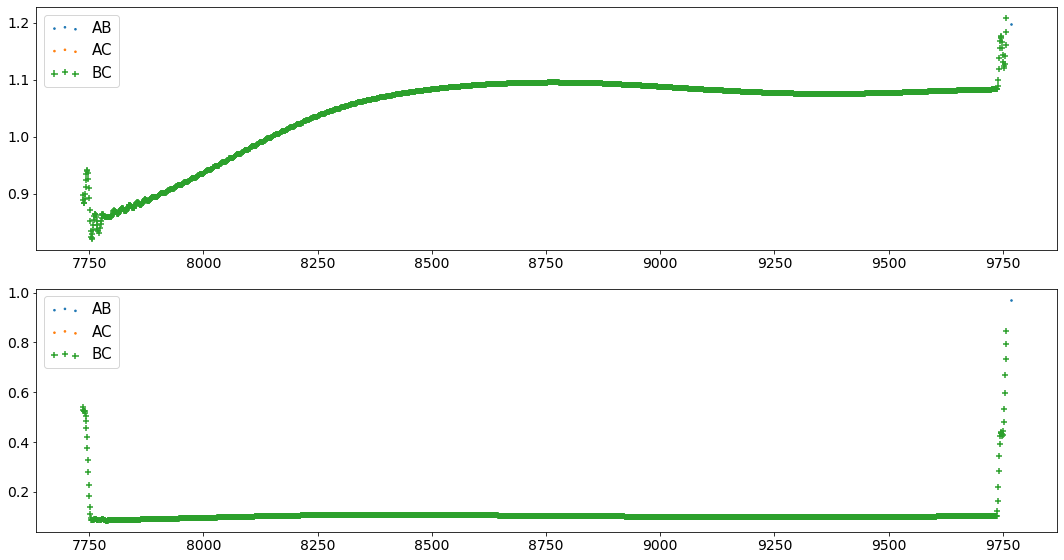


.
.
 10CG.csv
  Fault type Percentage
0        NML     94.29%
1      FAULT      5.71%


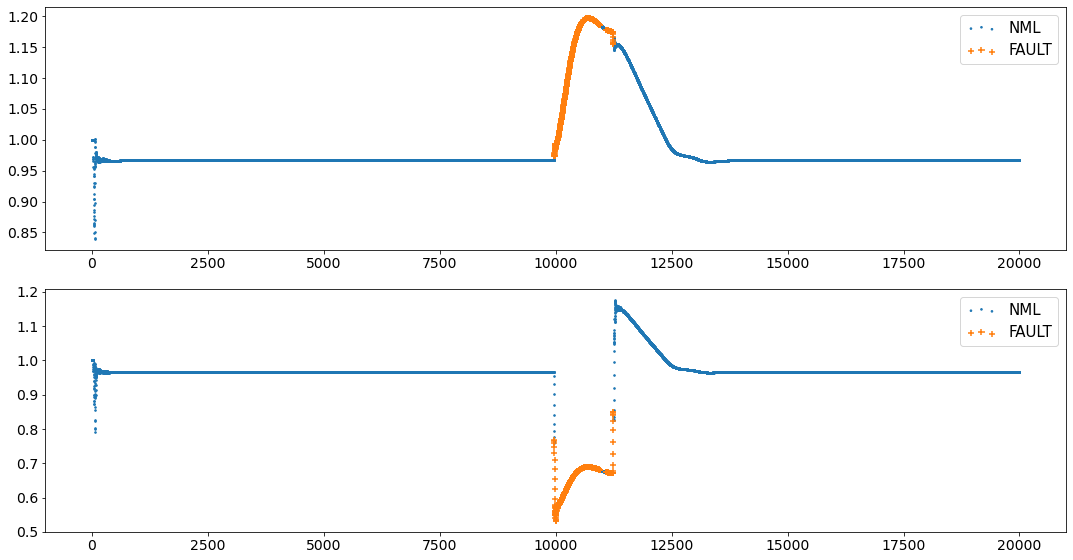

  Fault type Percentage
0         CG     100.0%


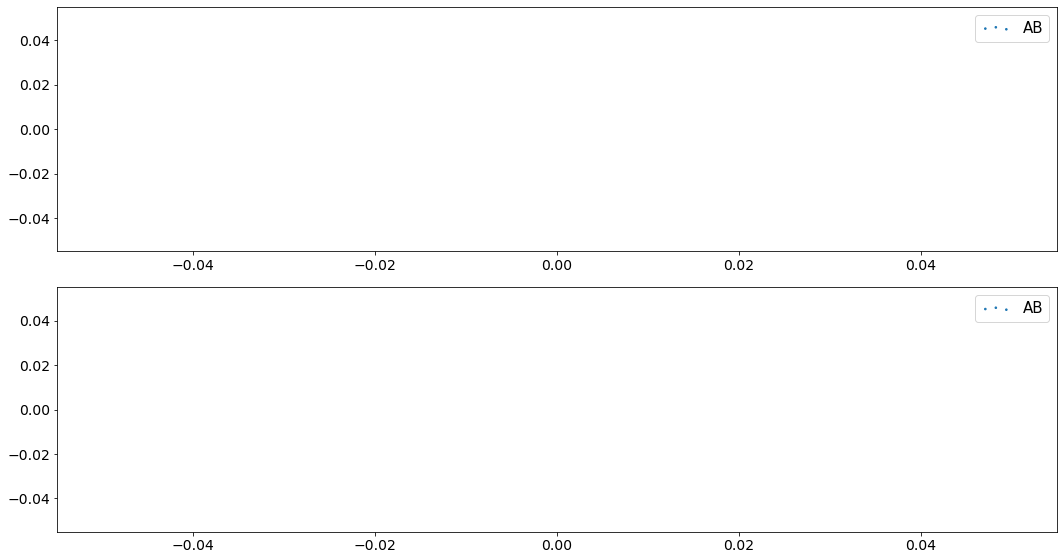


.
.
 10ABCG.csv
  Fault type Percentage
0        NML     88.02%
1      FAULT     11.98%


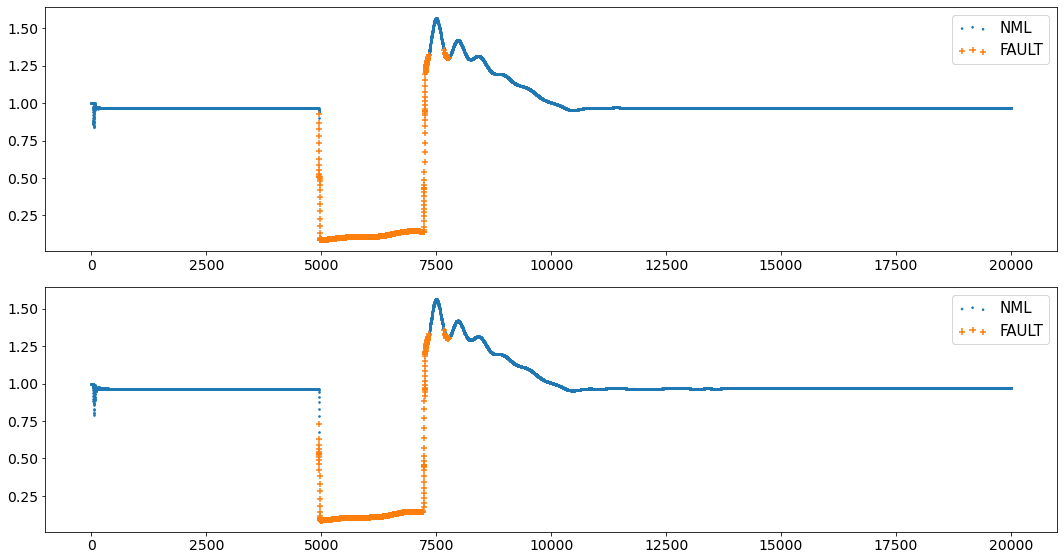

  Fault type Percentage
0        ABC     91.86%
1       ABCG      7.68%
2        BCG      0.29%
3         CG      0.08%
4        ACG      0.08%


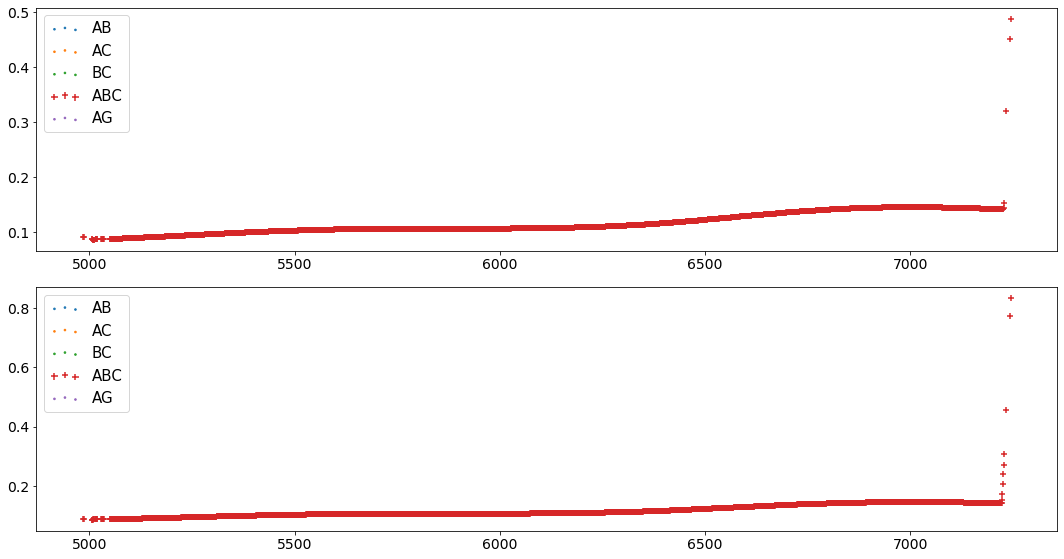


.
.
 6AG.csv
  Fault type Percentage
0        NML     77.26%
1      FAULT     22.74%


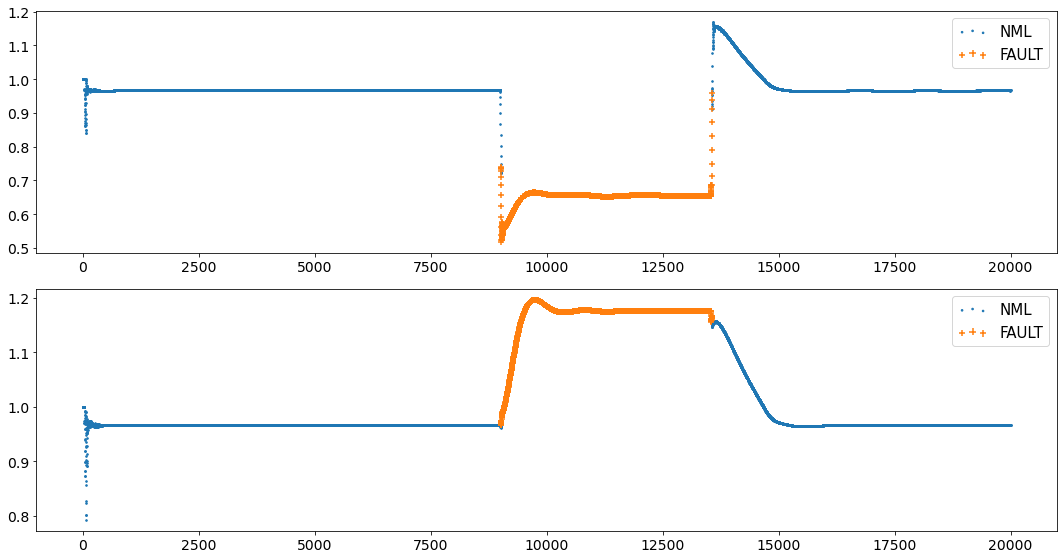

  Fault type Percentage
0         AG     100.0%


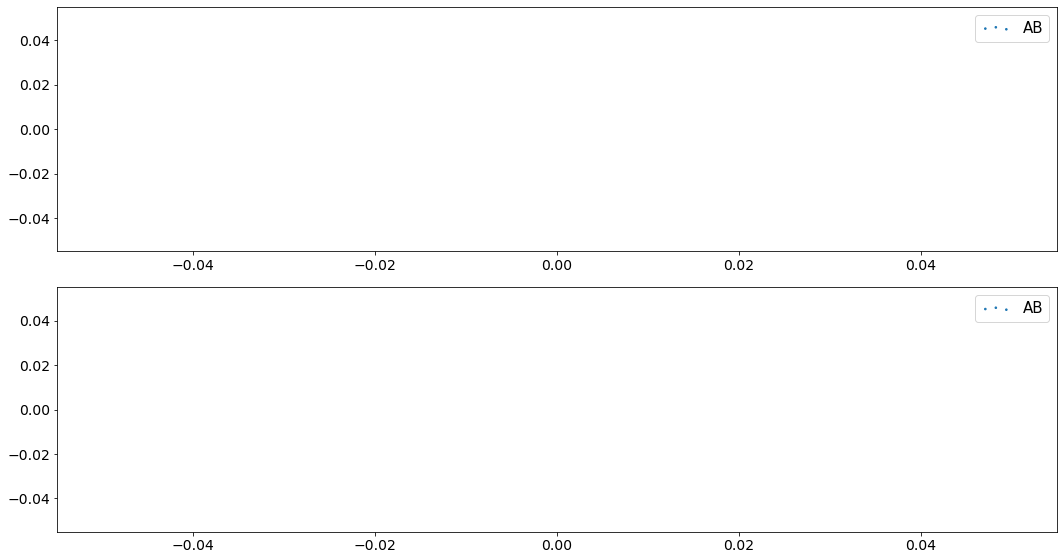


.
.
 3ABCG.csv
  Fault type Percentage
0        NML     99.08%
1      FAULT      0.92%


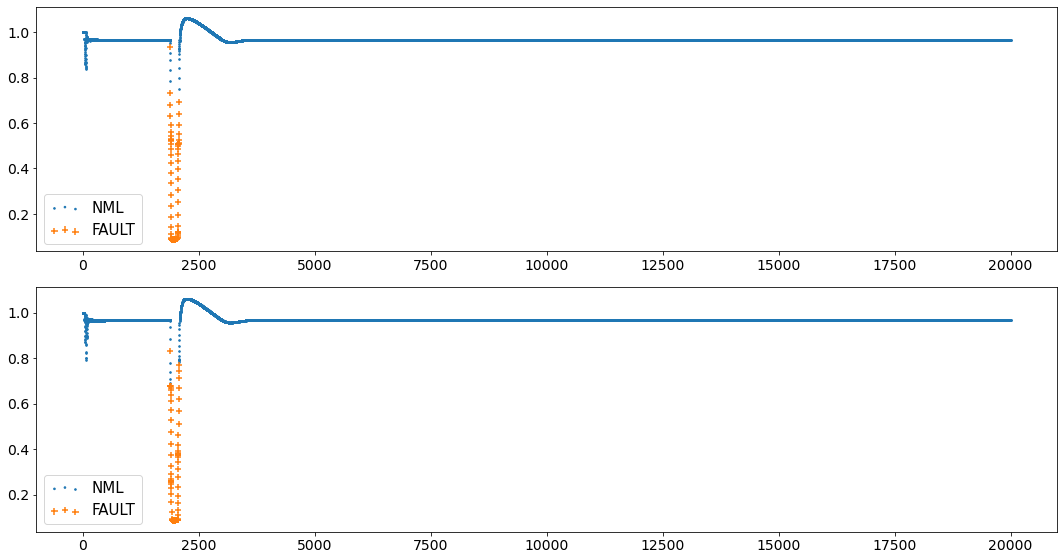

  Fault type Percentage
0       ABCG     52.72%
1        ABC     39.13%
2        BCG      4.35%
3        ABG       3.8%


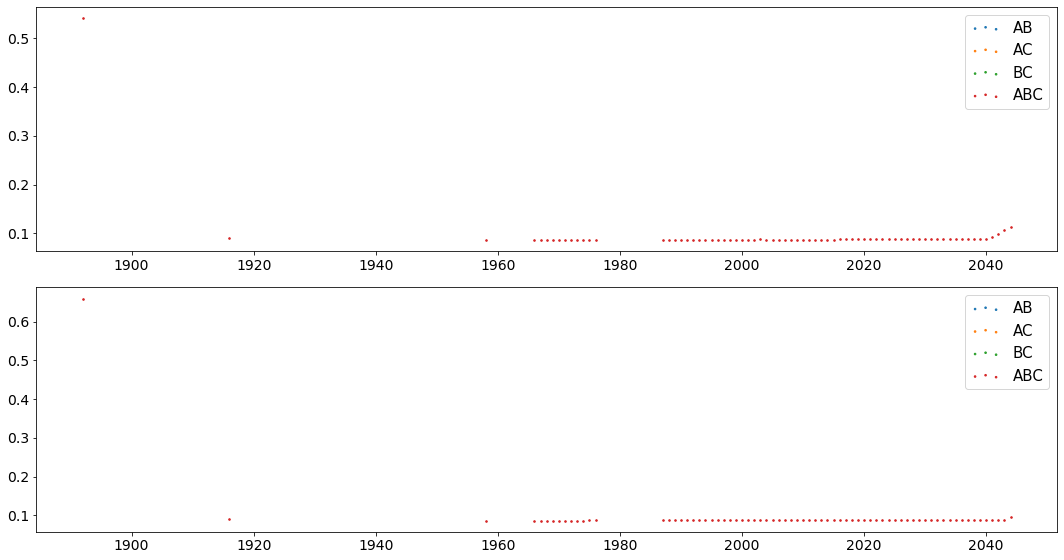


.
.
 2AC.csv
  Fault type Percentage
0        NML     99.83%
1      FAULT      0.17%


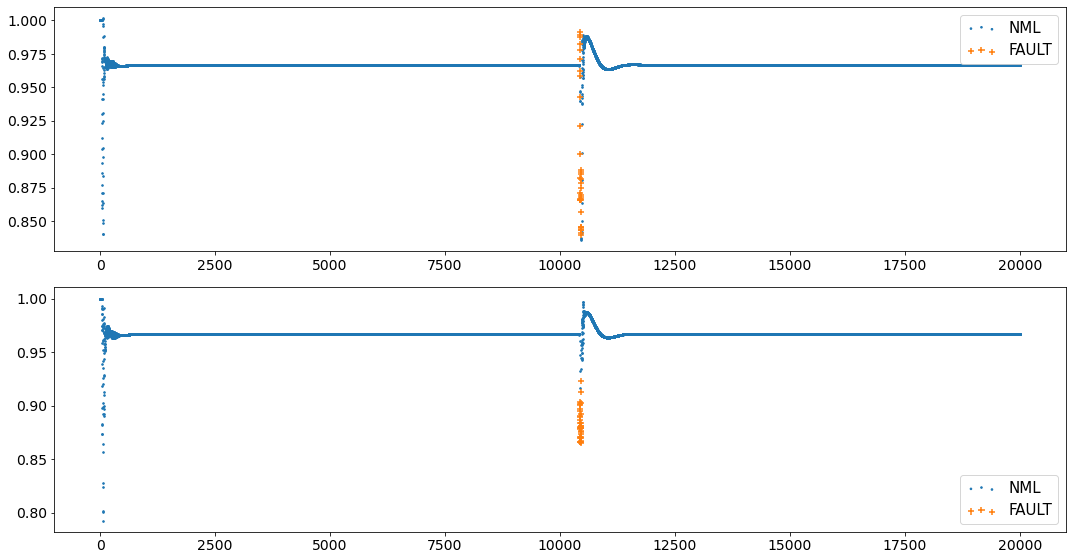

  Fault type Percentage
0         AC     82.35%
1        ACG     17.65%


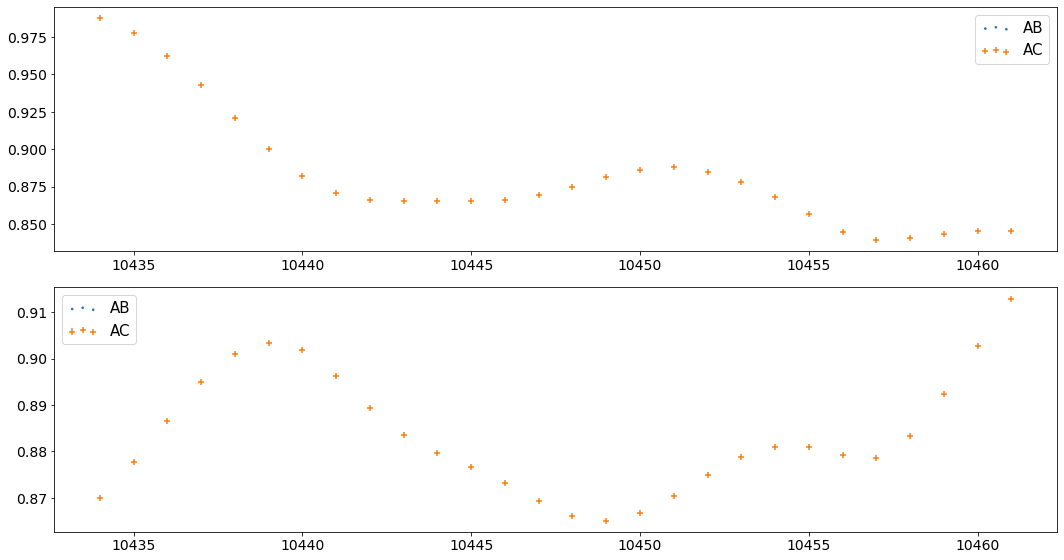


.
.
 4ACG.csv
  Fault type Percentage
0        NML     99.48%
1      FAULT      0.52%


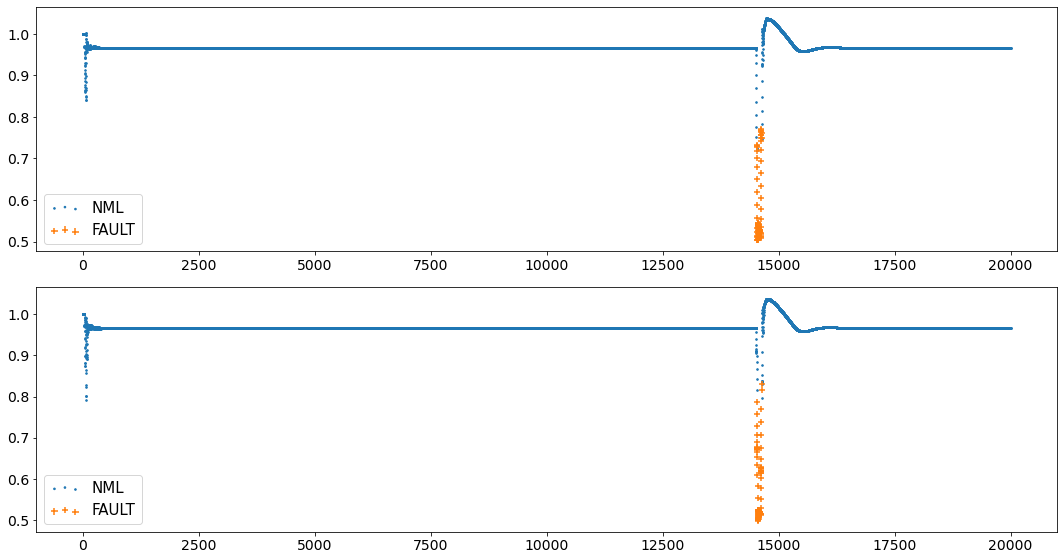

  Fault type Percentage
0        ACG     97.12%
1         CG      1.92%
2         AG      0.96%


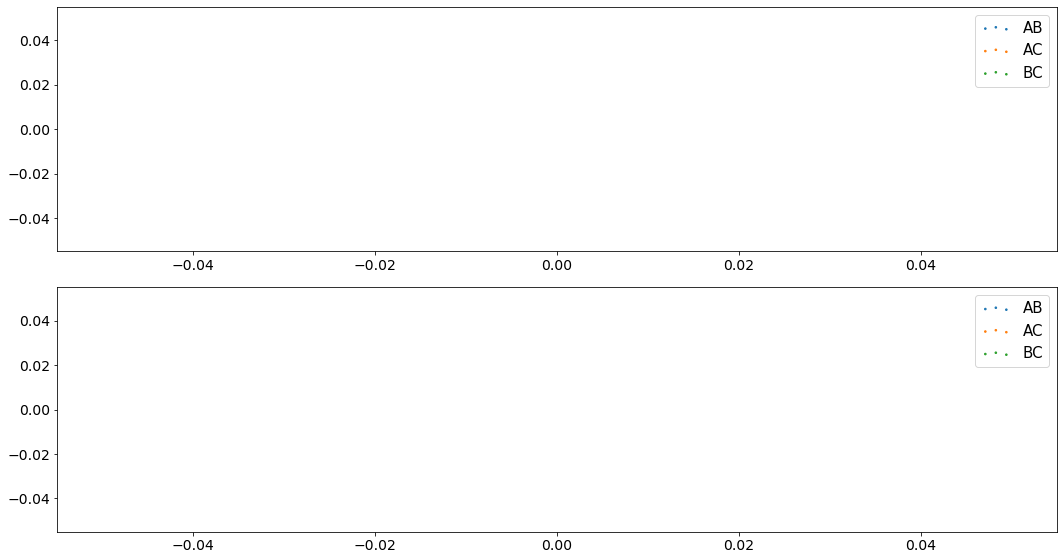


.
.
 4ABC.csv
  Fault type Percentage
0        NML     78.36%
1      FAULT     21.64%


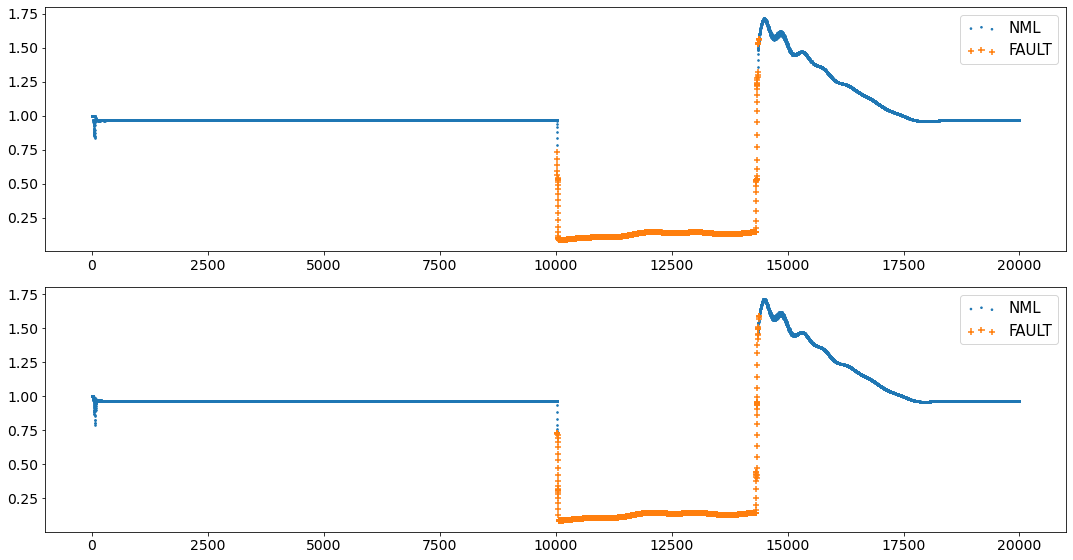

  Fault type Percentage
0        ABC     97.25%
1       ABCG      2.31%
2        ABG      0.18%
3        BCG      0.14%
4        ACG      0.07%
5         CG      0.05%


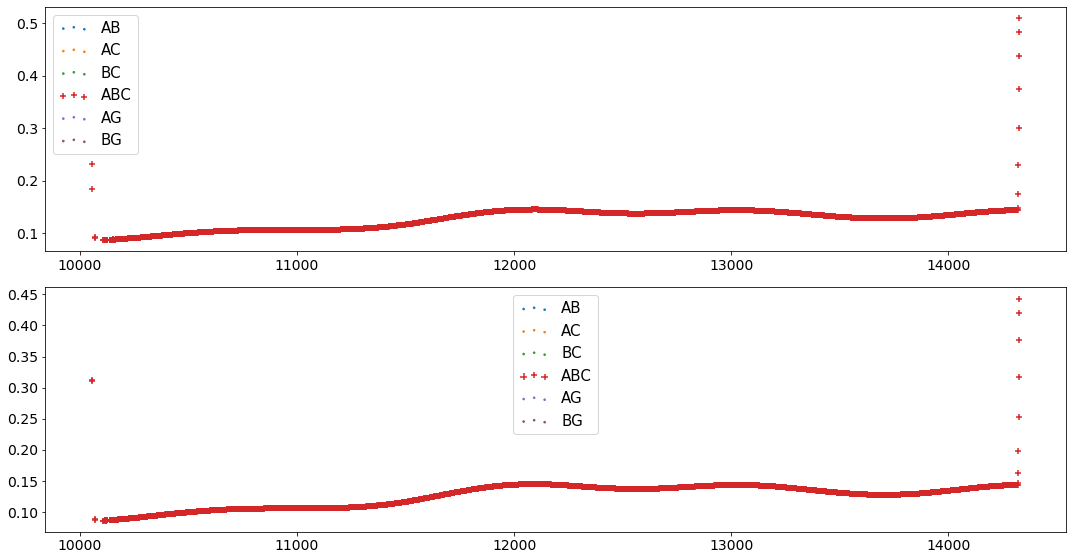


.
.
 8ABC.csv
  Fault type Percentage
0        NML     94.05%
1      FAULT      5.95%


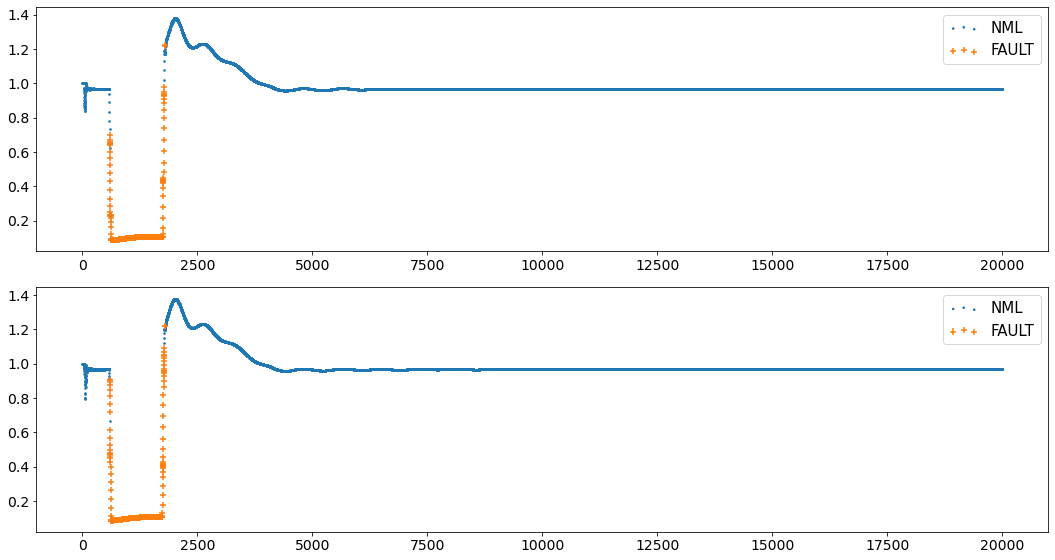

  Fault type Percentage
0        ABC     91.09%
1       ABCG      7.98%
2        ABG      0.92%


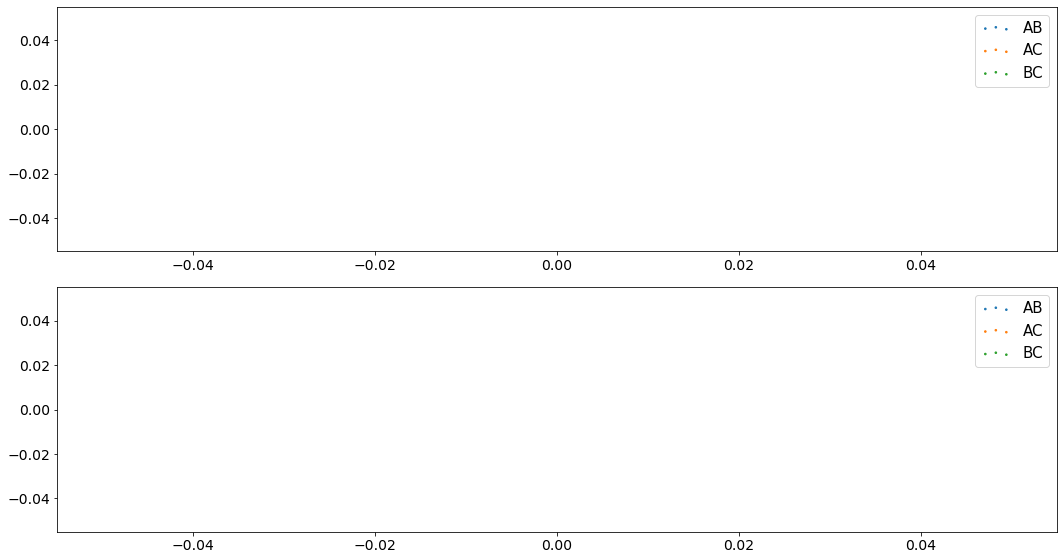


.
.
 8ACG.csv
  Fault type Percentage
0        NML      99.8%
1      FAULT       0.2%


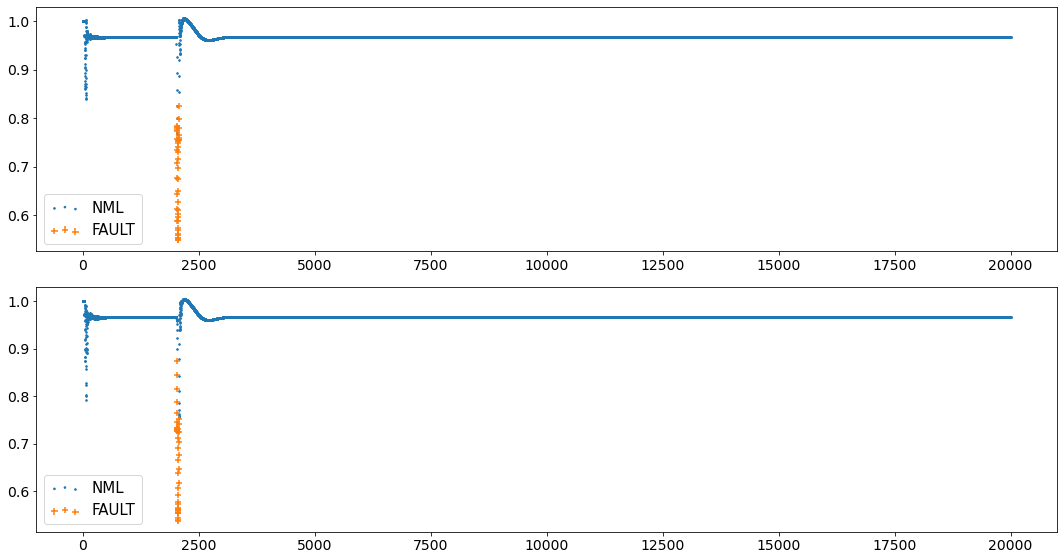

  Fault type Percentage
0        ACG     82.93%
1         CG     17.07%


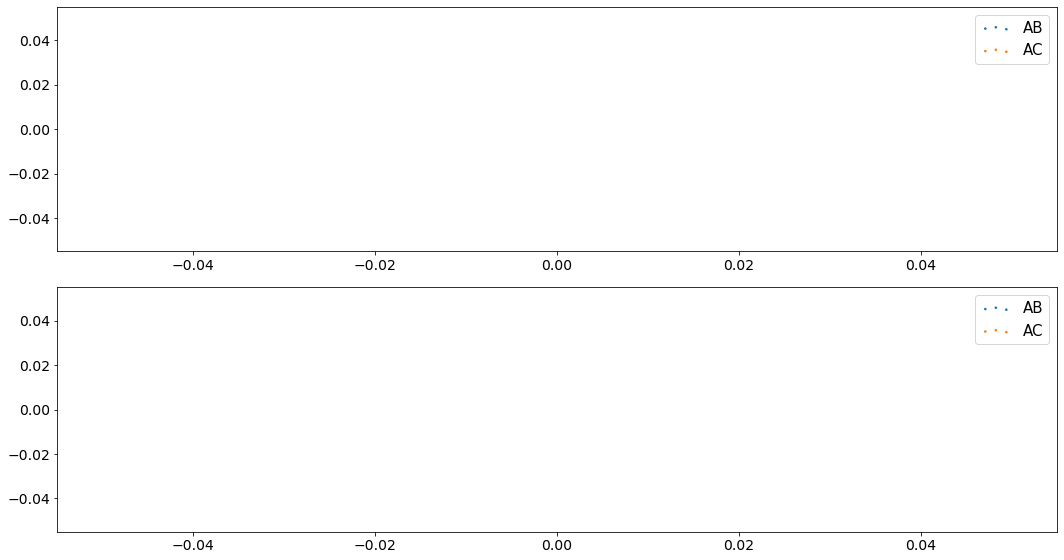


.
.
 4AG.csv
  Fault type Percentage
0        NML     74.25%
1      FAULT     25.75%


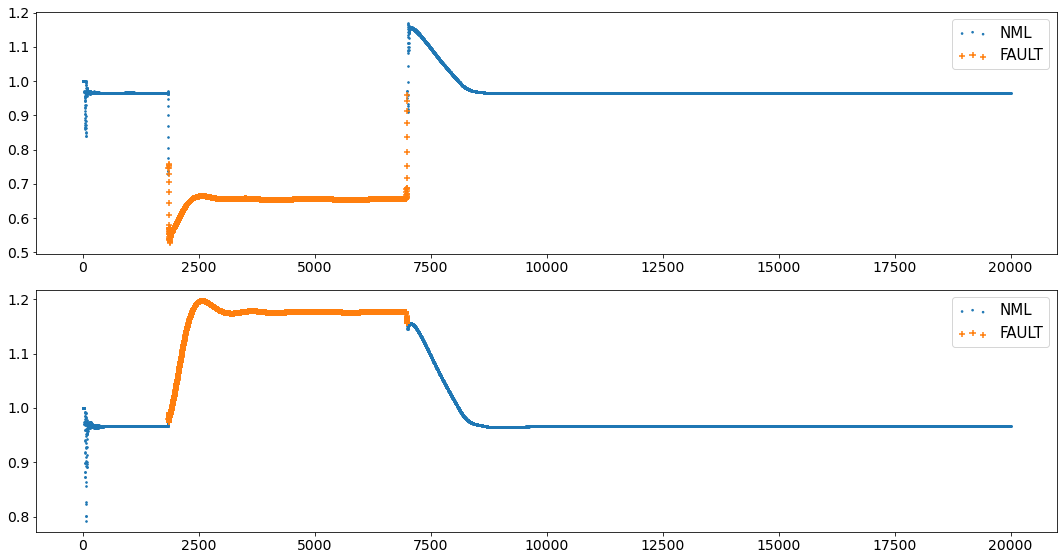

  Fault type Percentage
0         AG     100.0%


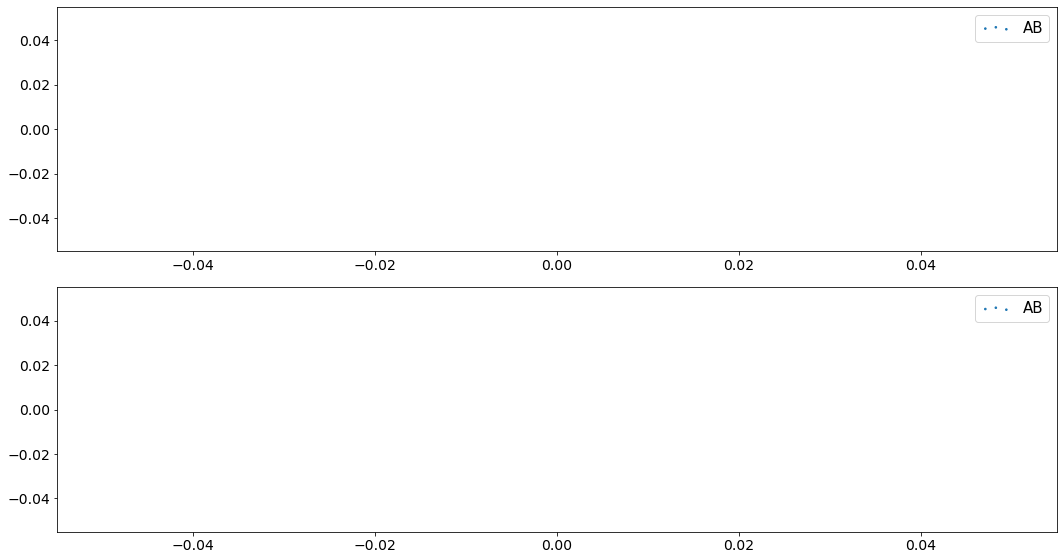


.
.
 6ABG.csv
  Fault type Percentage
0        NML     61.62%
1      FAULT     38.38%


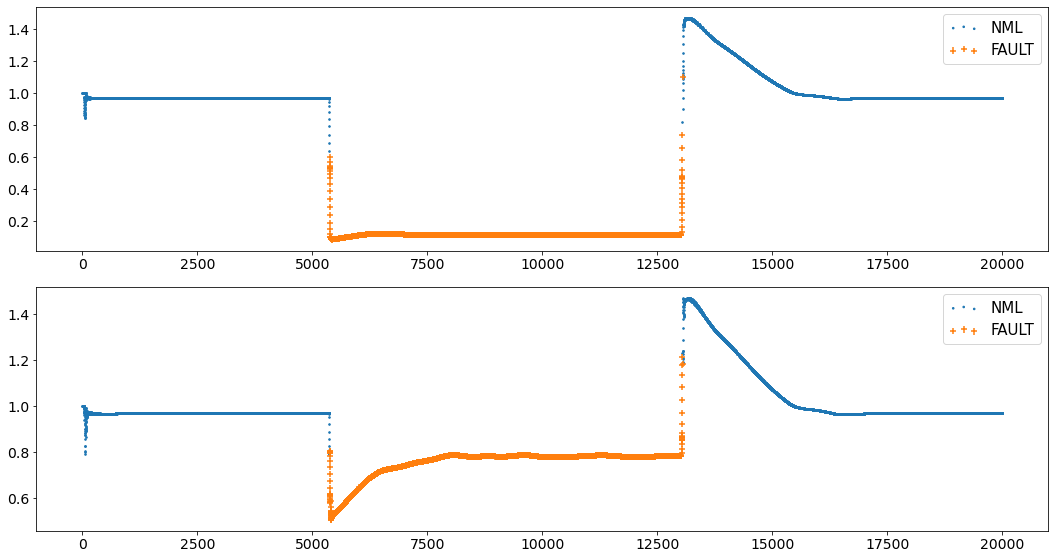

  Fault type Percentage
0        ABG     99.92%
1         AB      0.07%
2         AG      0.01%


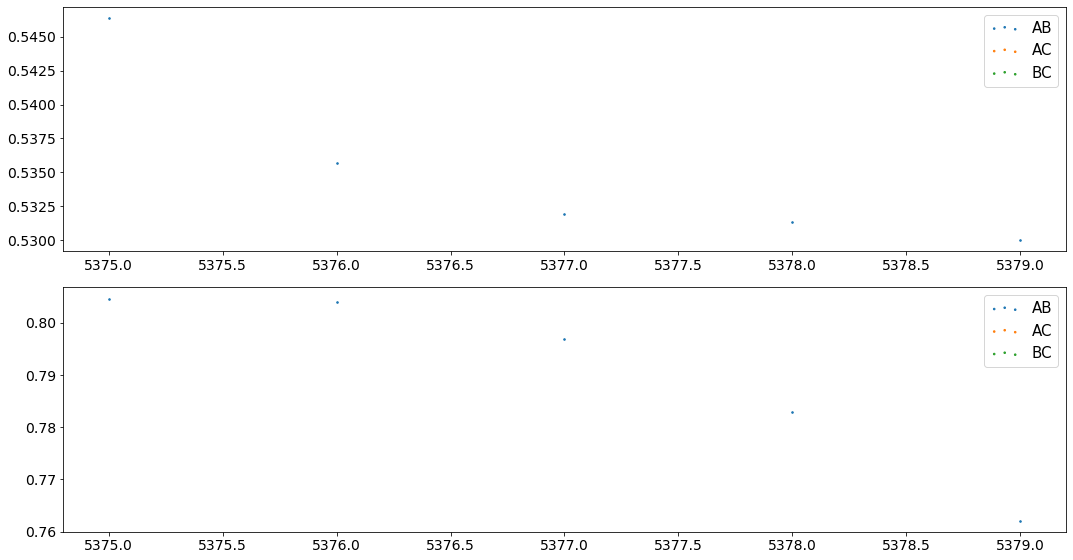


.
.
 8BG.csv
  Fault type Percentage
0        NML     95.35%
1      FAULT      4.65%


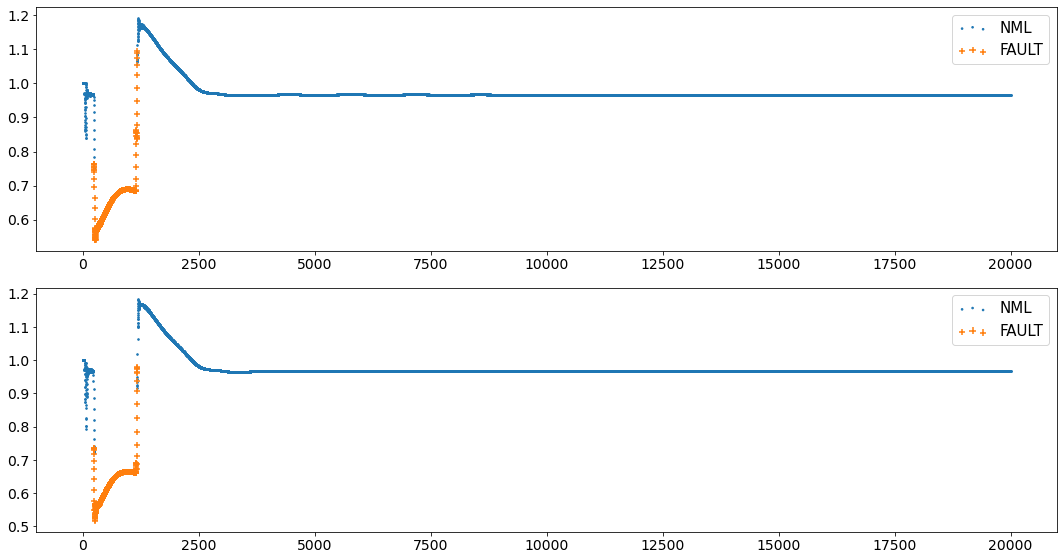

  Fault type Percentage
0         BG     100.0%


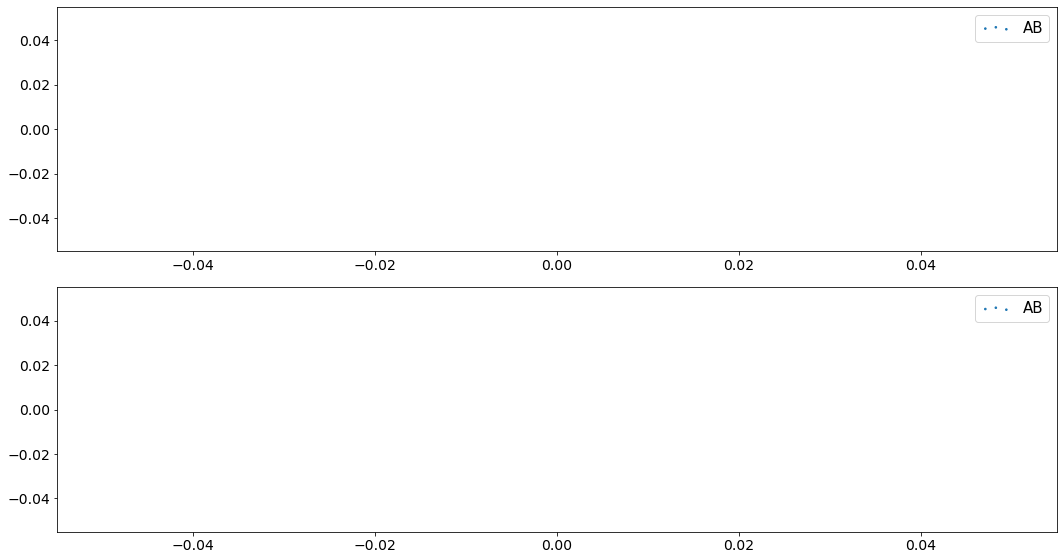


.
.
 7AC.csv
  Fault type Percentage
0        NML     91.55%
1      FAULT      8.45%


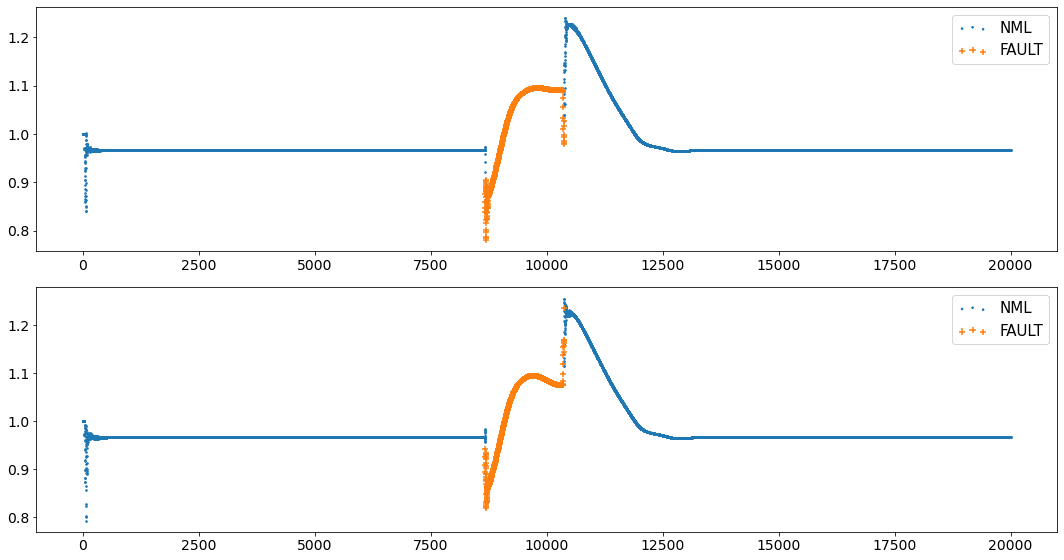

  Fault type Percentage
0         AC     99.47%
1        ACG      0.41%
2         BC      0.06%
3         CG      0.06%


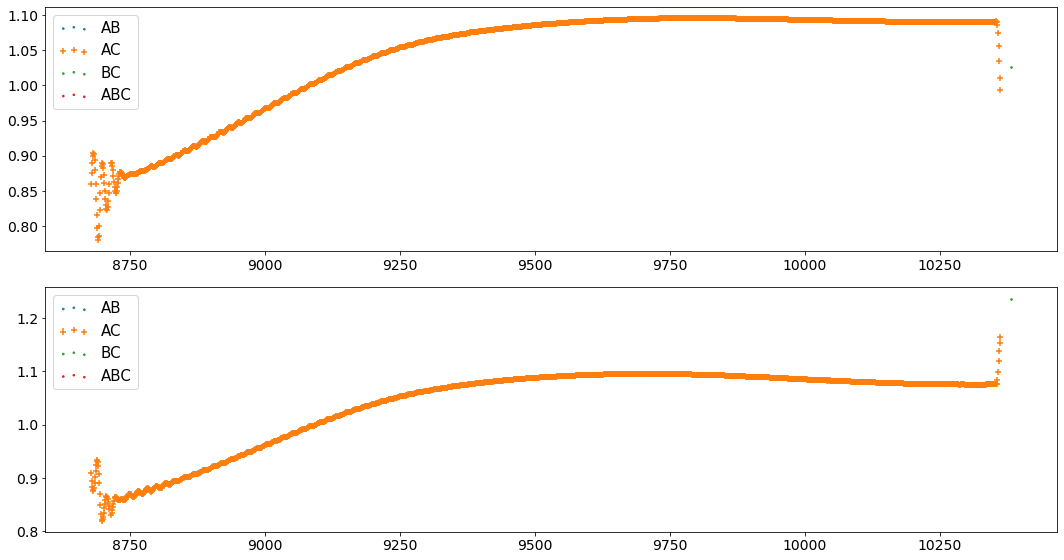


.
.
 3AG.csv
  Fault type Percentage
0        NML     90.16%
1      FAULT      9.84%


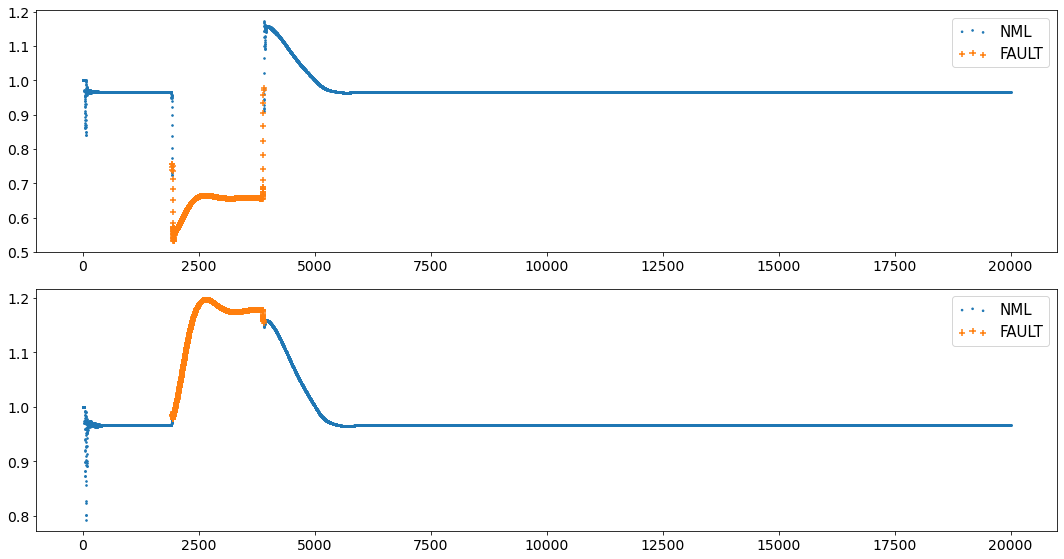

  Fault type Percentage
0         AG     100.0%


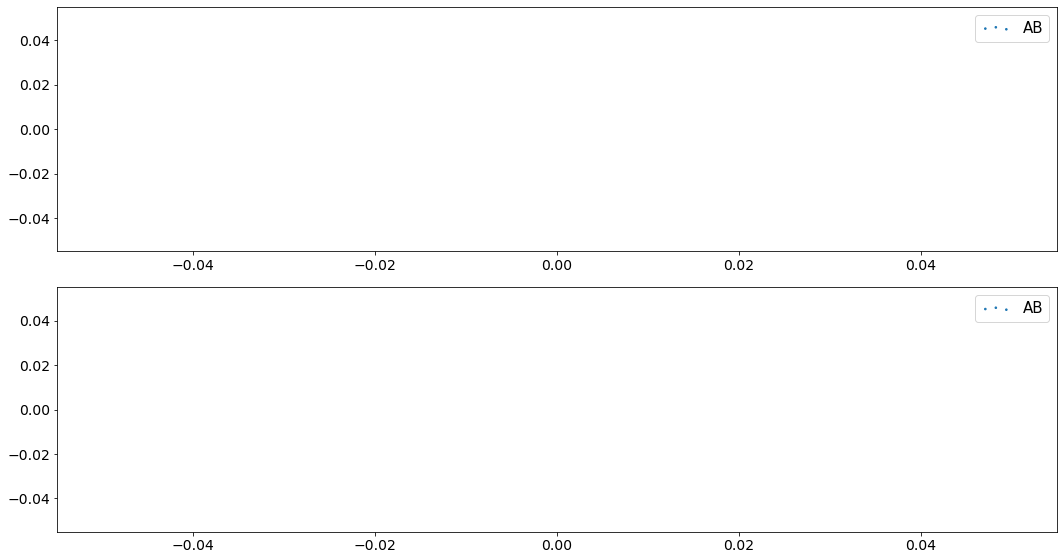


.
.
 1ABCG.csv
  Fault type Percentage
0        NML      99.4%
1      FAULT       0.6%


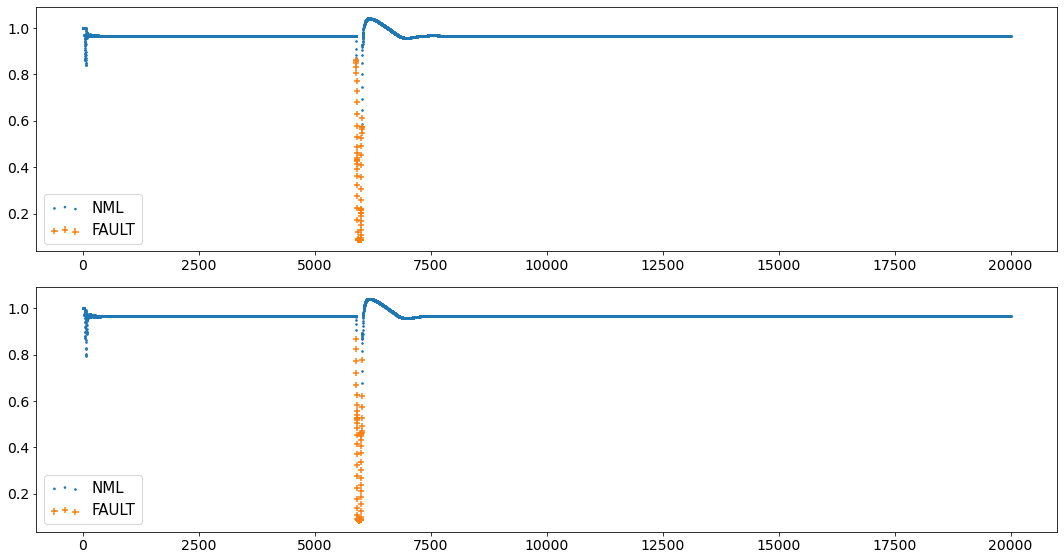

  Fault type Percentage
0       ABCG     60.83%
1        ABC     24.17%
2        ACG      6.67%
3        ABG       5.0%
4        BCG      3.33%


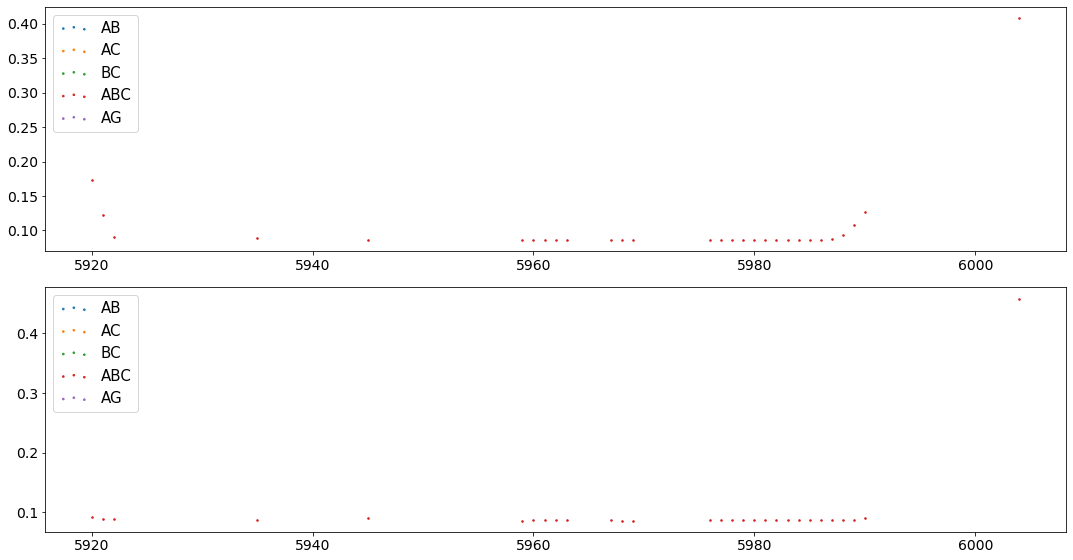


.
.
 7AB.csv
  Fault type Percentage
0        NML     69.58%
1      FAULT     30.43%


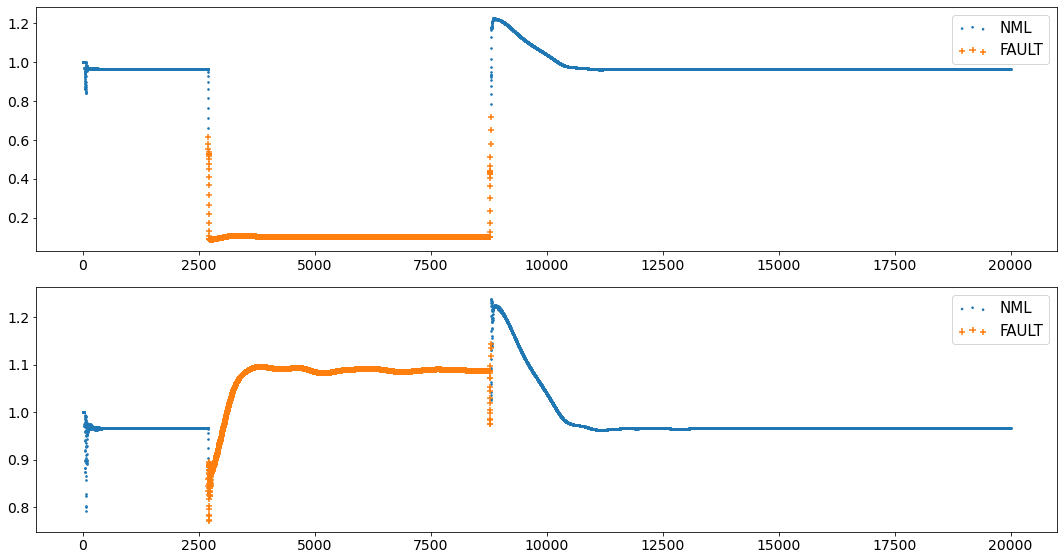

  Fault type Percentage
0         AB     99.92%
1         AG      0.03%
2       ABCG      0.03%
3        ABG      0.02%


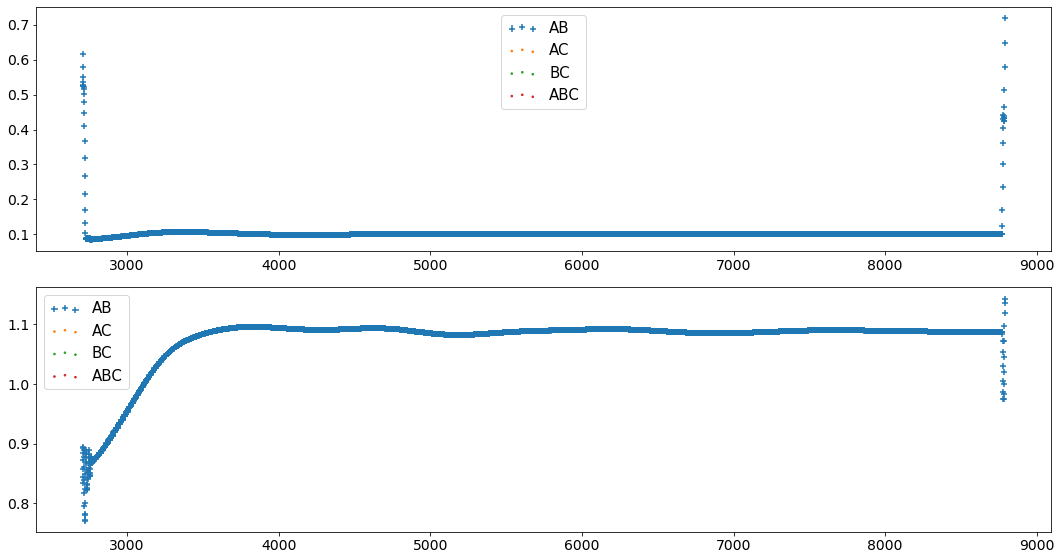


.
.
 6BCG.csv
  Fault type Percentage
0        NML     87.39%
1      FAULT     12.61%


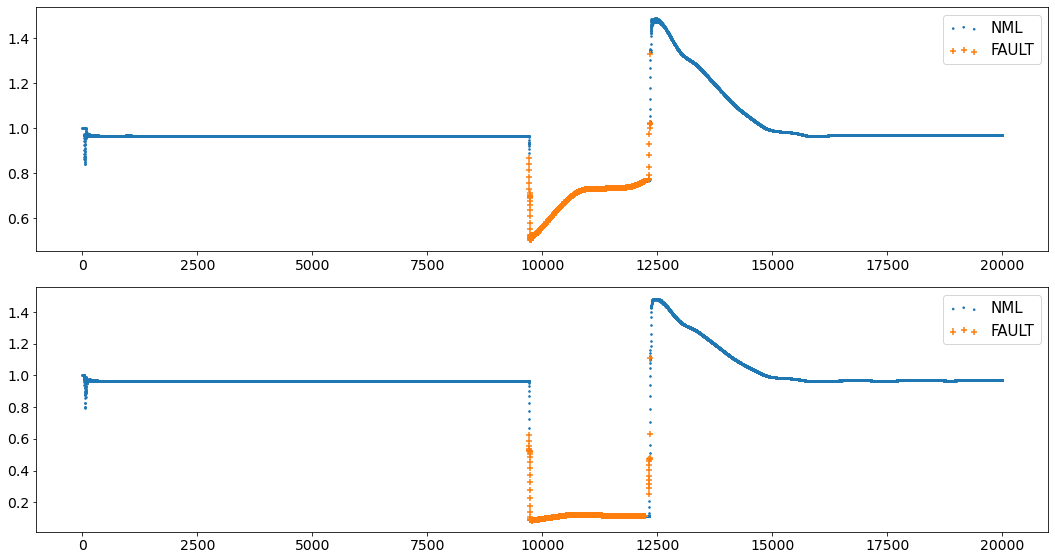

  Fault type Percentage
0        BCG     99.52%
1         BC      0.24%
2         CG      0.16%
3         BG      0.04%
4       ABCG      0.04%


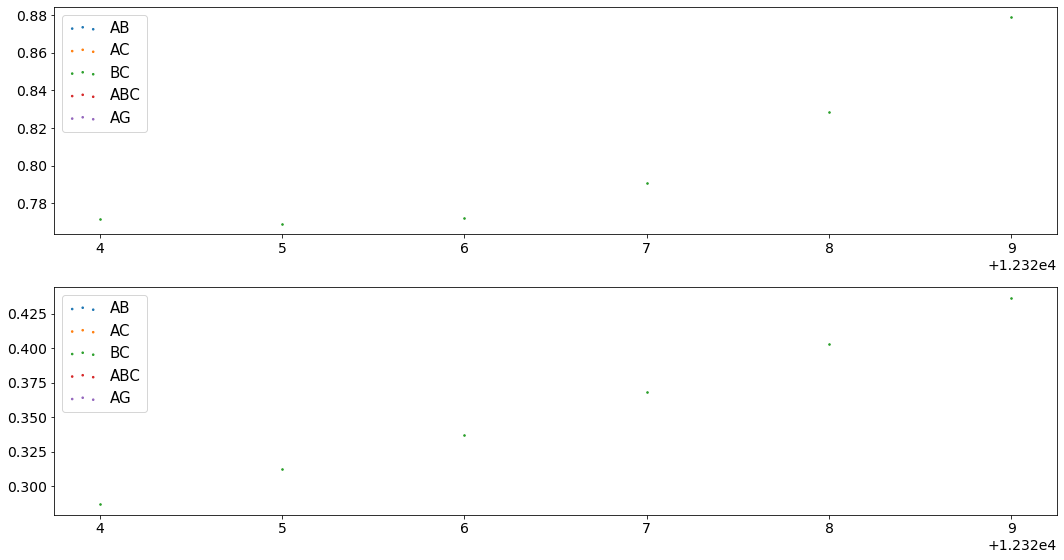


.
.
 5AB.csv
  Fault type Percentage
0        NML      92.0%
1      FAULT       8.0%


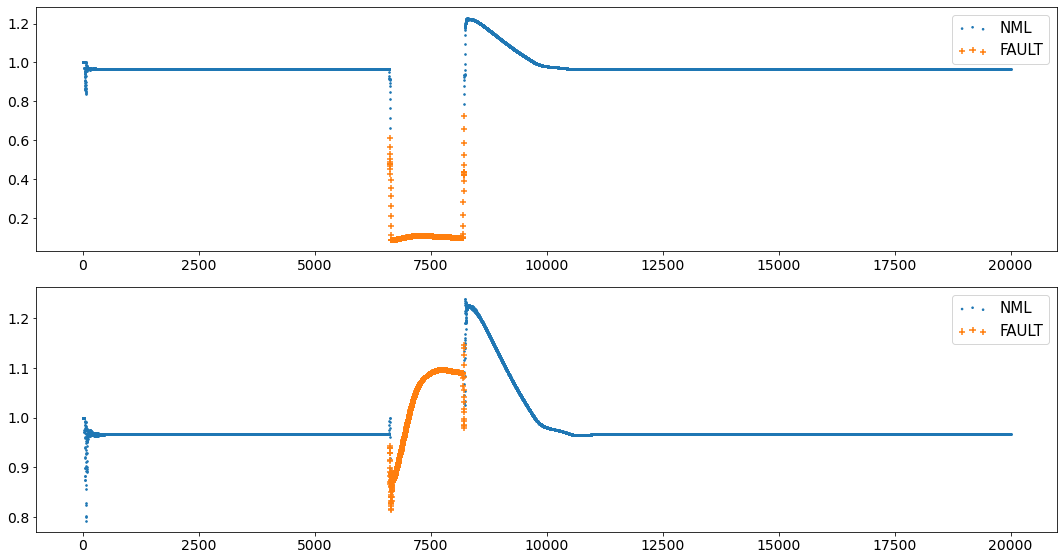

  Fault type Percentage
0         AB     99.12%
1        ABG      0.88%


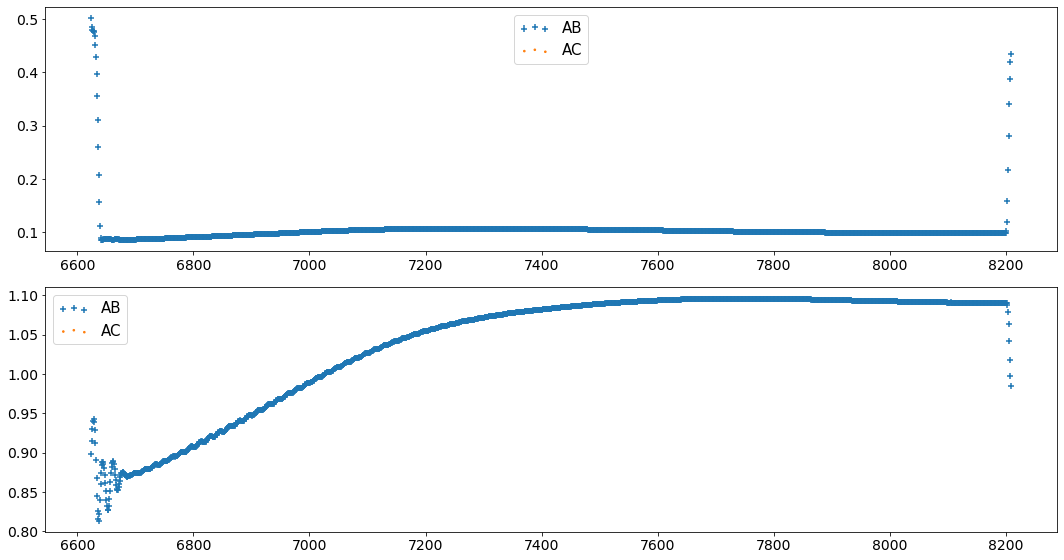


.
.
 9CG.csv
  Fault type Percentage
0        NML     84.28%
1      FAULT     15.71%


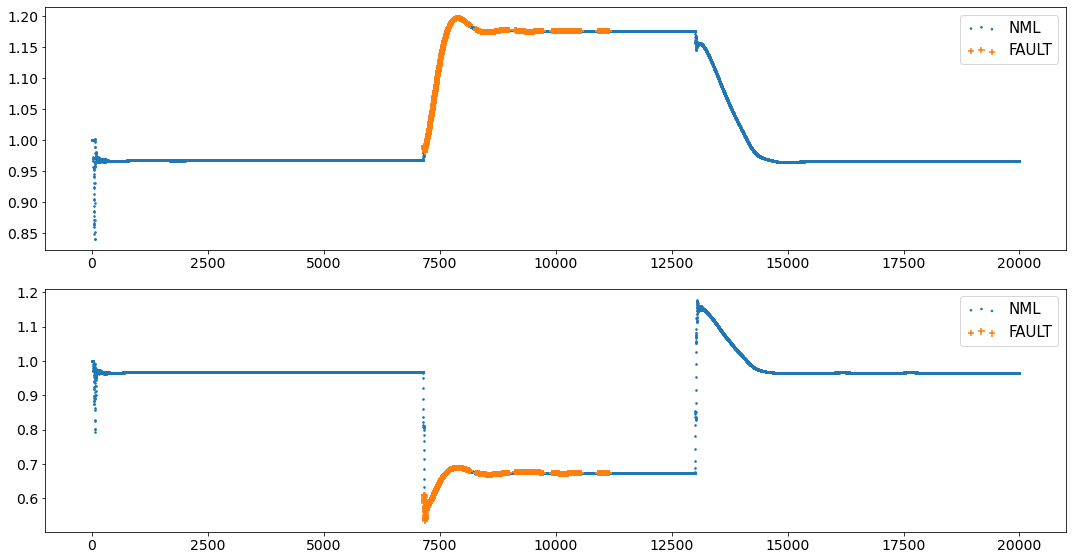

  Fault type Percentage
0         CG     100.0%


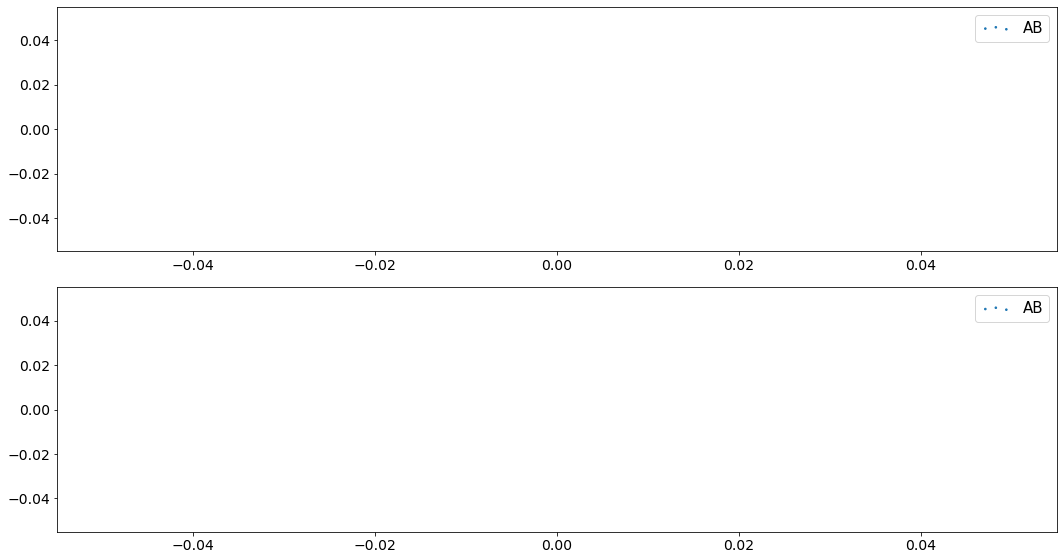


.
.
 9BC.csv
  Fault type Percentage
0        NML     83.45%
1      FAULT     16.55%


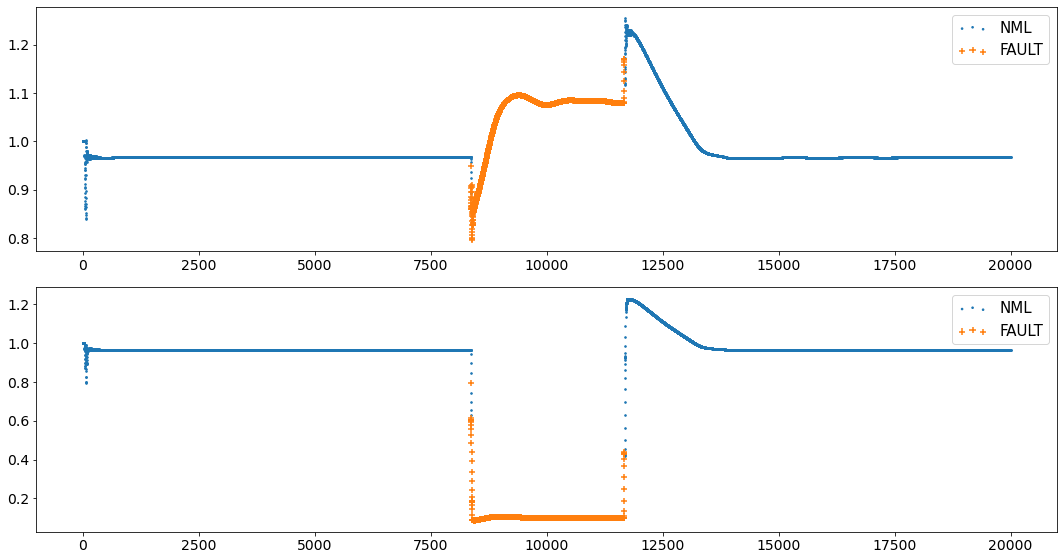

  Fault type Percentage
0         BC     99.91%
1        BCG      0.09%


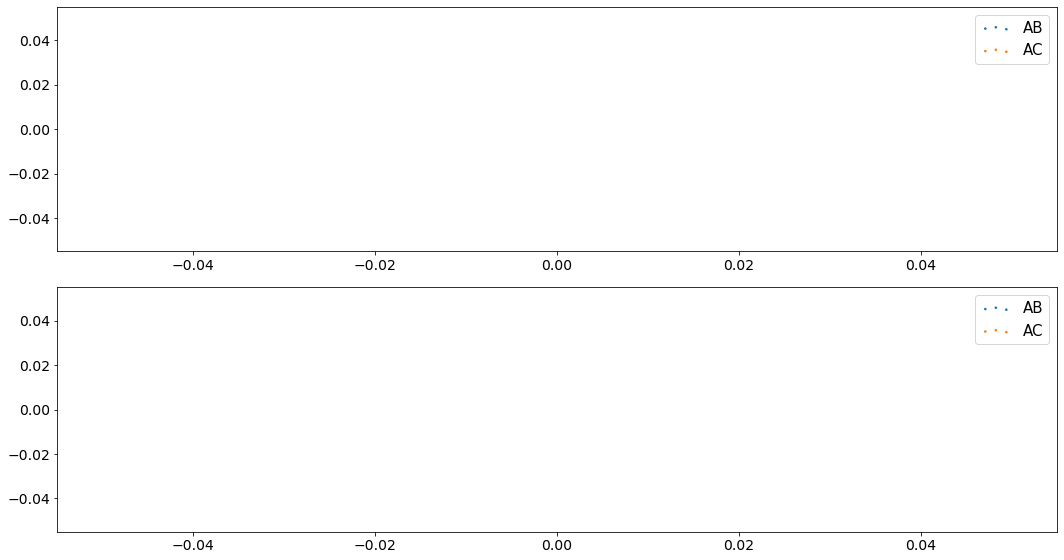


.
.
 2ABG.csv
  Fault type Percentage
0        NML     89.38%
1      FAULT     10.62%


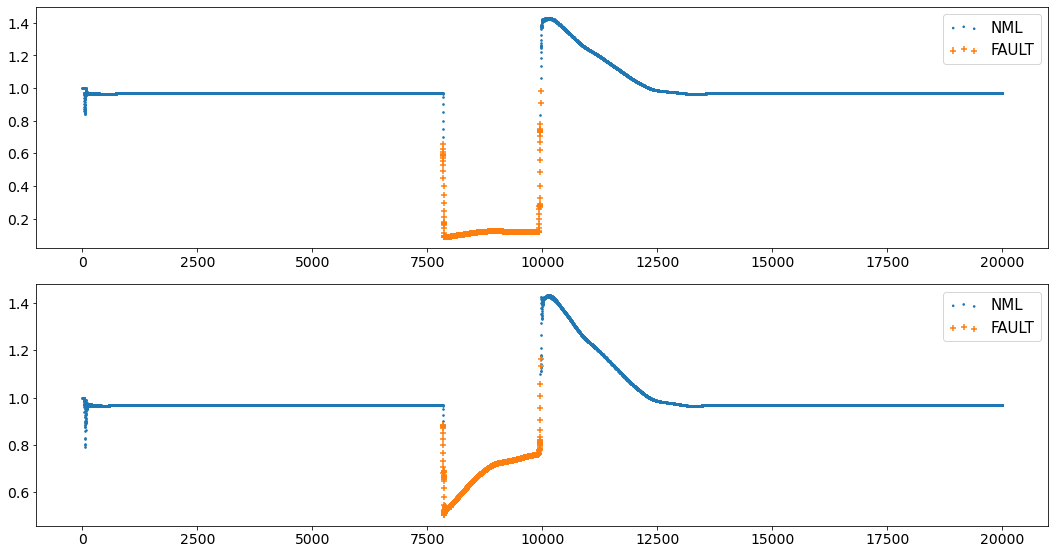

  Fault type Percentage
0        ABG     99.25%
1         AB      0.47%
2         BG      0.28%


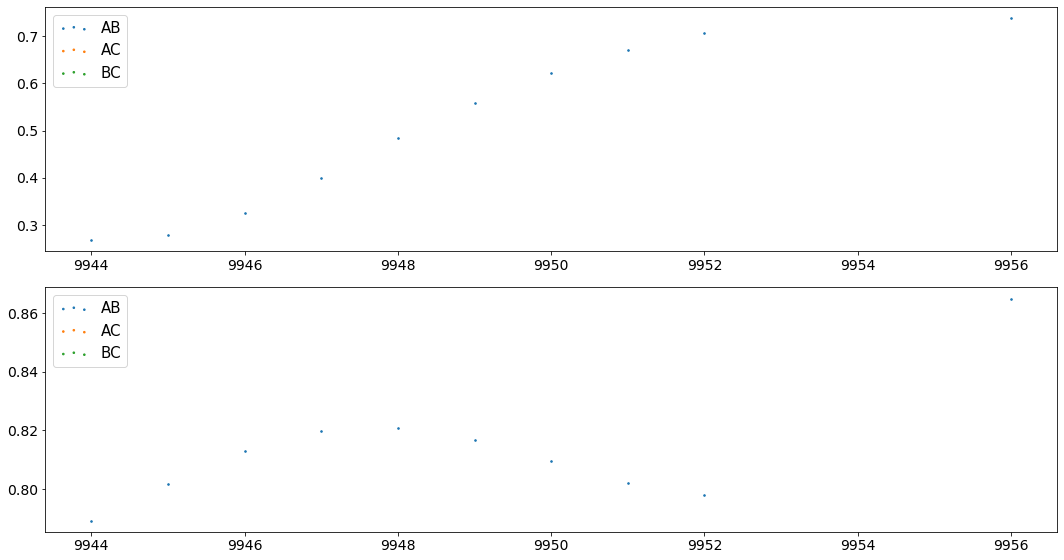


.
.
 1AG.csv
  Fault type Percentage
0        NML     51.97%
1      FAULT     48.03%


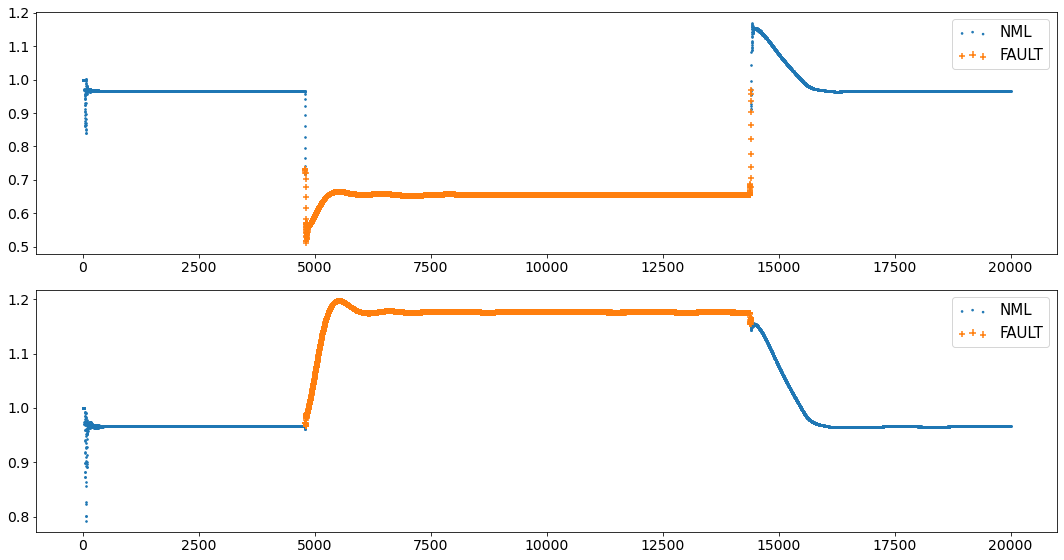

  Fault type Percentage
0         AG     100.0%


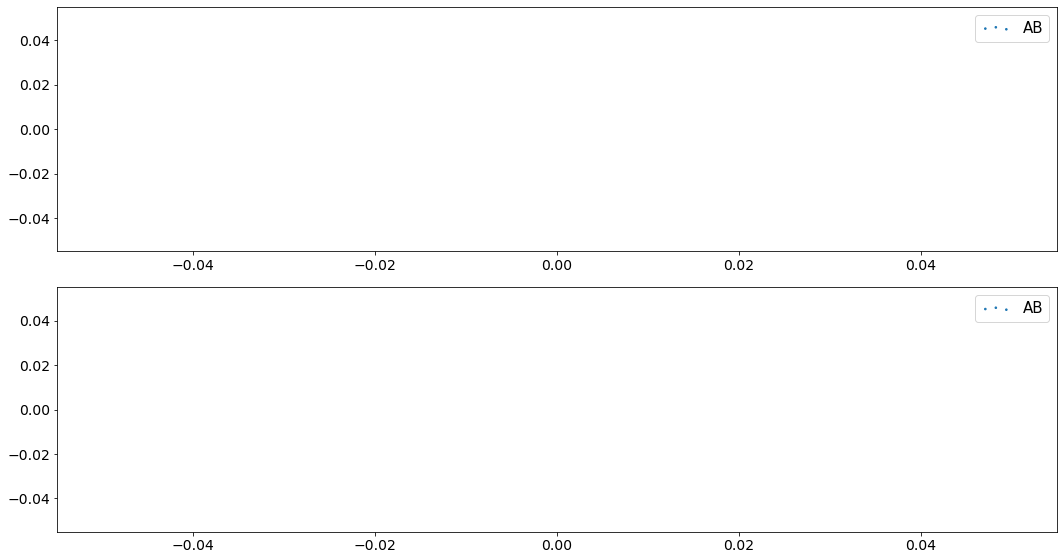


.
.
 8ABCG.csv
  Fault type Percentage
0        NML     97.47%
1      FAULT      2.53%


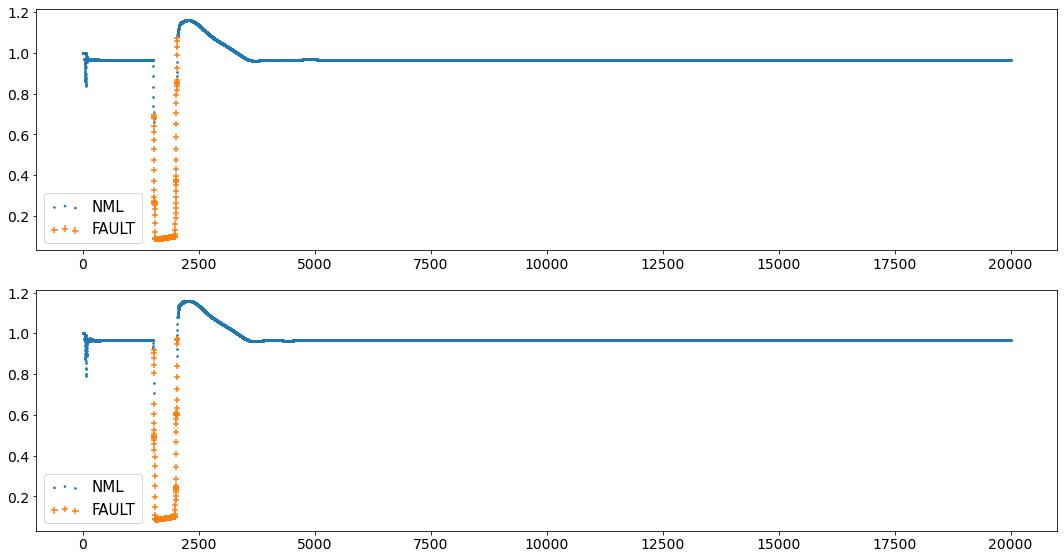

  Fault type Percentage
0        ABC     79.84%
1       ABCG     16.01%
2        ACG      2.37%
3        ABG      0.99%
4        BCG       0.4%
5         CG       0.4%


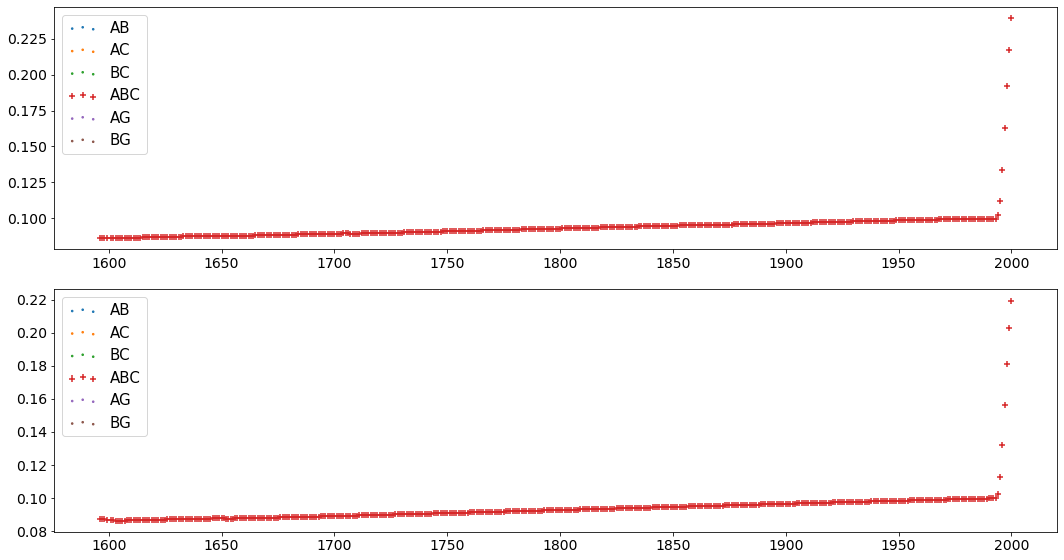


.
.
 5AC.csv
  Fault type Percentage
0        NML     72.94%
1      FAULT     27.06%


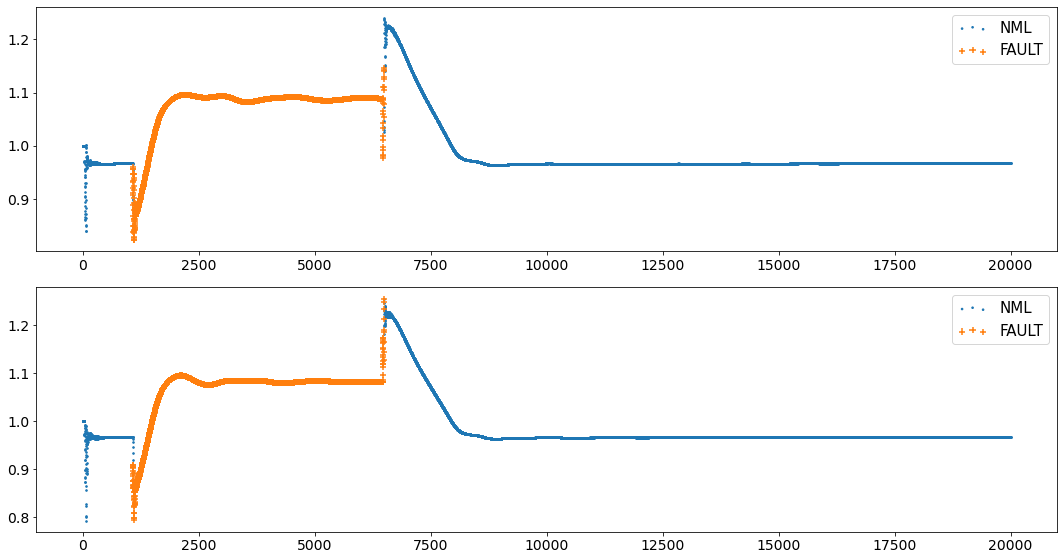

  Fault type Percentage
0         AC     99.93%
1        ACG      0.06%
2         CG      0.02%


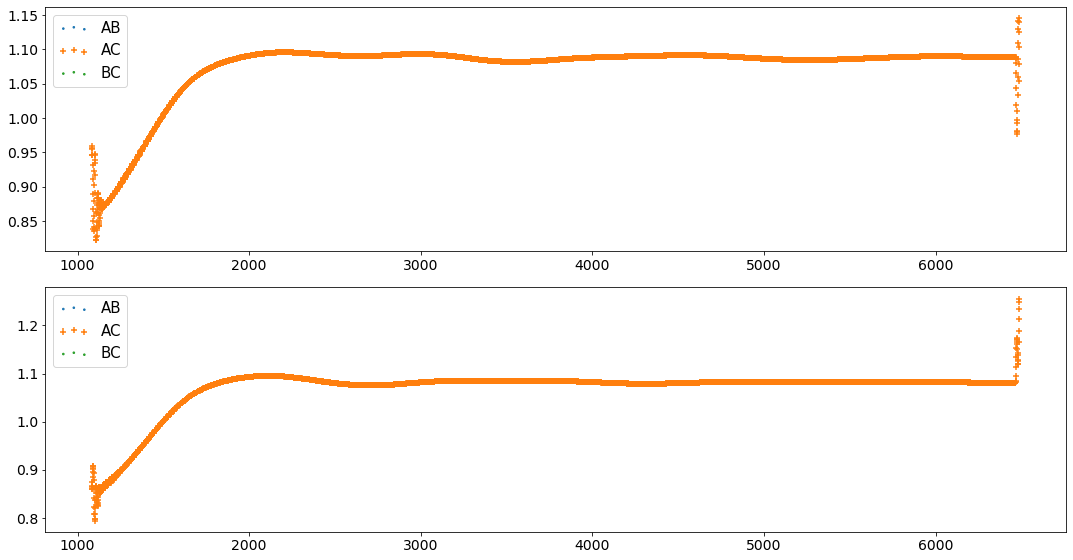


.
.
 5AG.csv
  Fault type Percentage
0        NML     91.31%
1      FAULT       8.7%


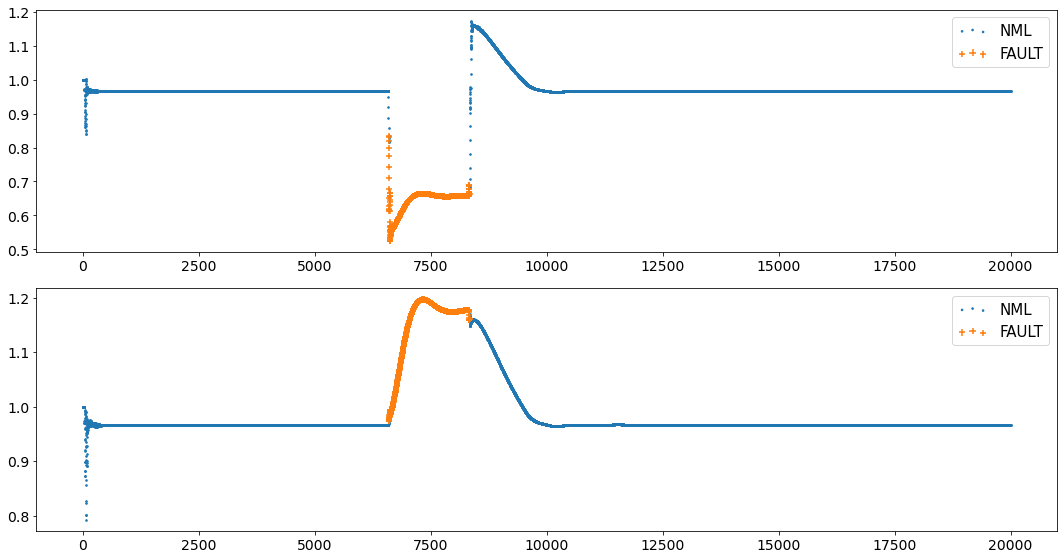

  Fault type Percentage
0         AG     100.0%


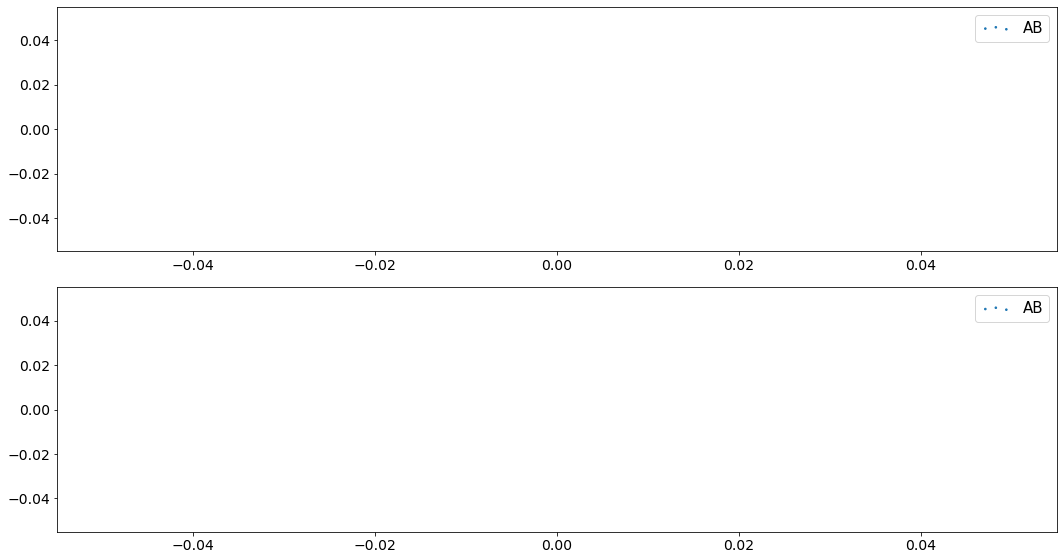


.
.
 1AC.csv
  Fault type Percentage
0        NML     97.66%
1      FAULT      2.35%


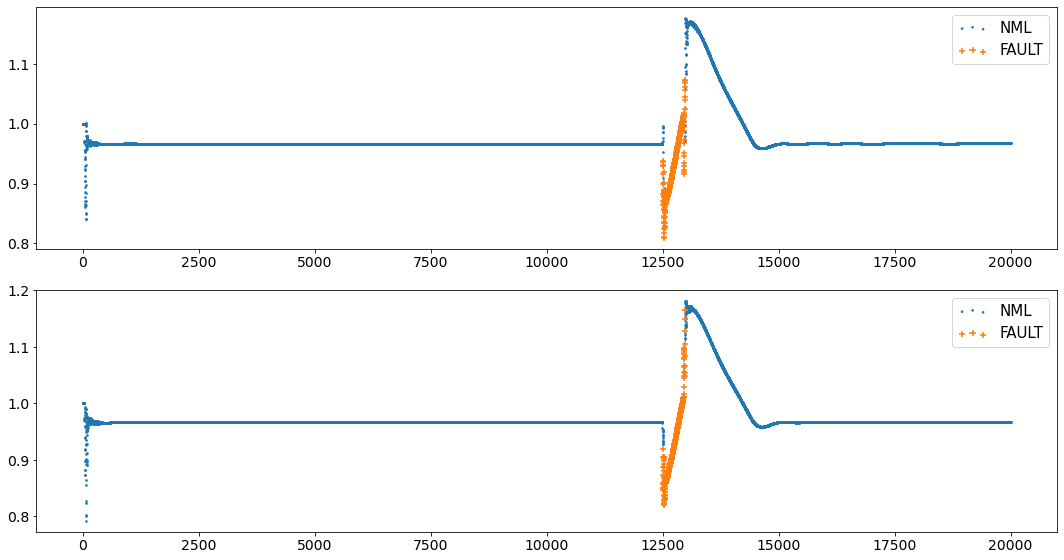

  Fault type Percentage
0         AC     96.16%
1        ACG      3.84%


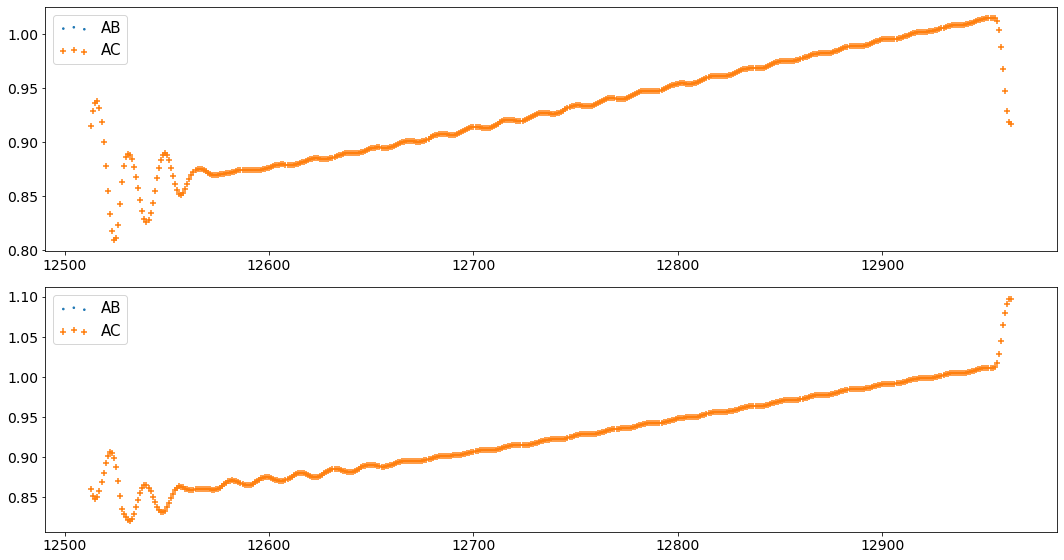


.
.
 2ACG.csv
  Fault type Percentage
0        NML     99.67%
1      FAULT      0.33%


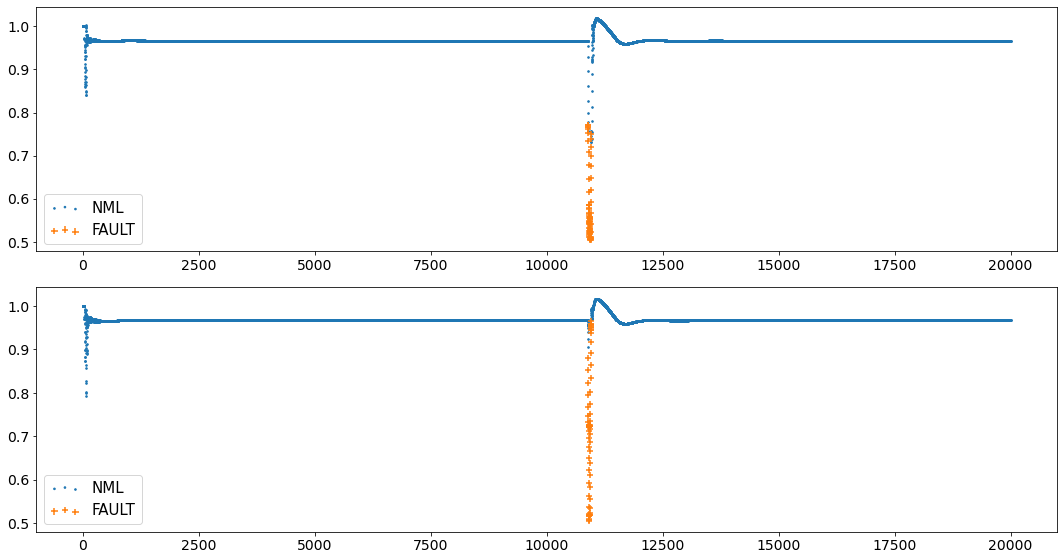

  Fault type Percentage
0        ACG      60.0%
1         AG     32.31%
2       ABCG      6.15%
3        ABG      1.54%


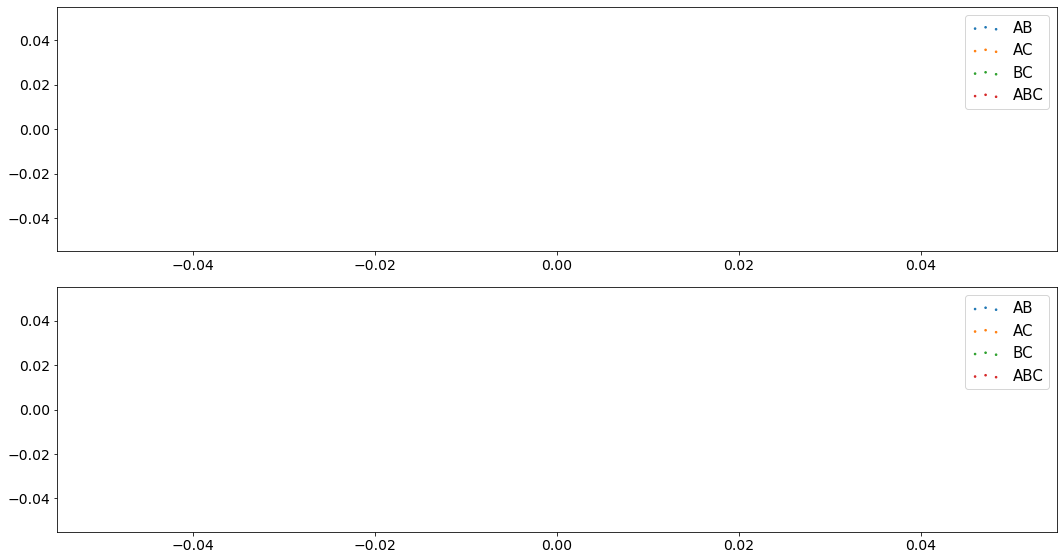


.
.
 1AB.csv
  Fault type Percentage
0        NML     94.69%
1      FAULT      5.32%


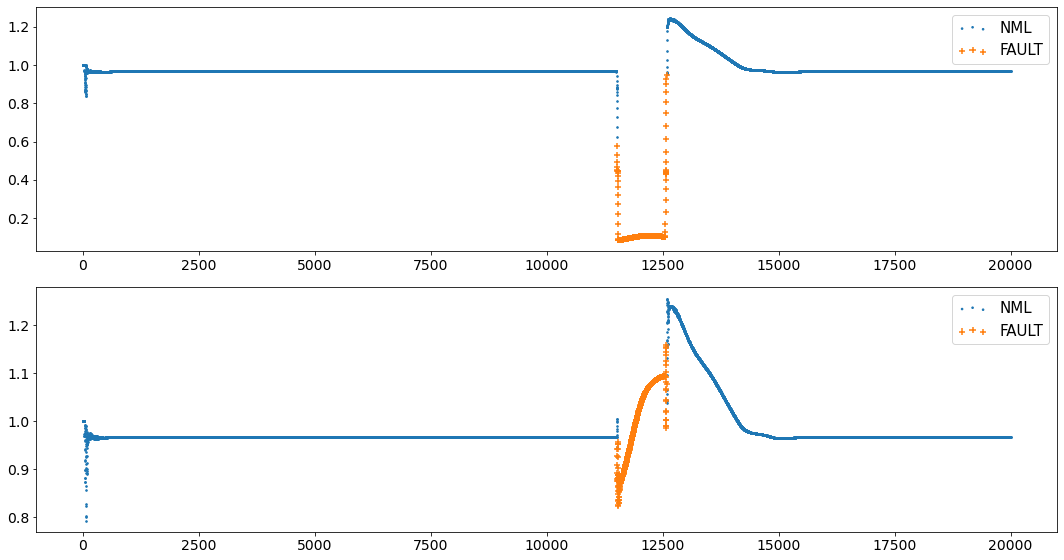

  Fault type Percentage
0         AB     99.72%
1        ABG      0.28%


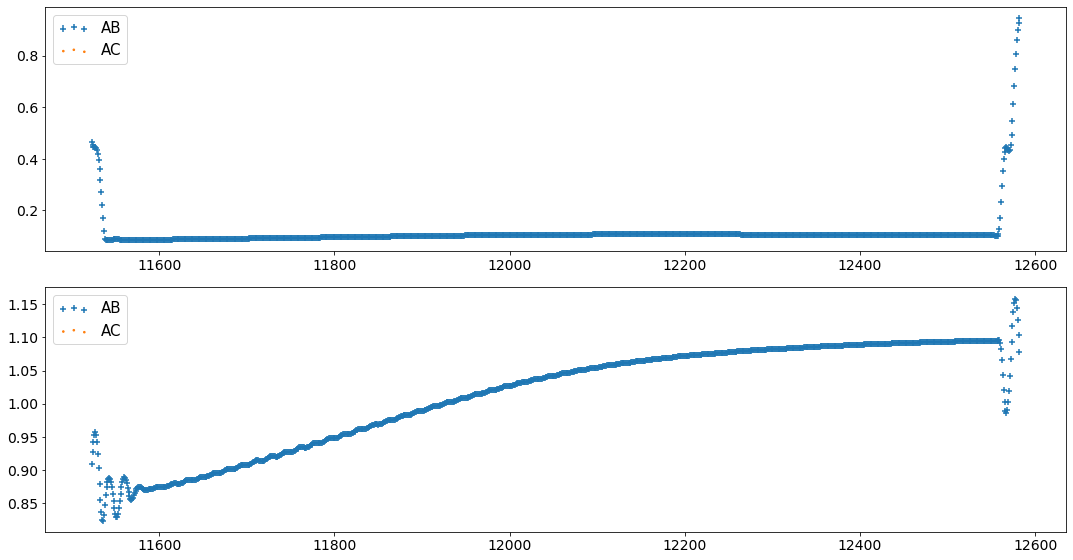


.
.
 2ABC.csv
  Fault type Percentage
0        NML     87.94%
1      FAULT     12.06%


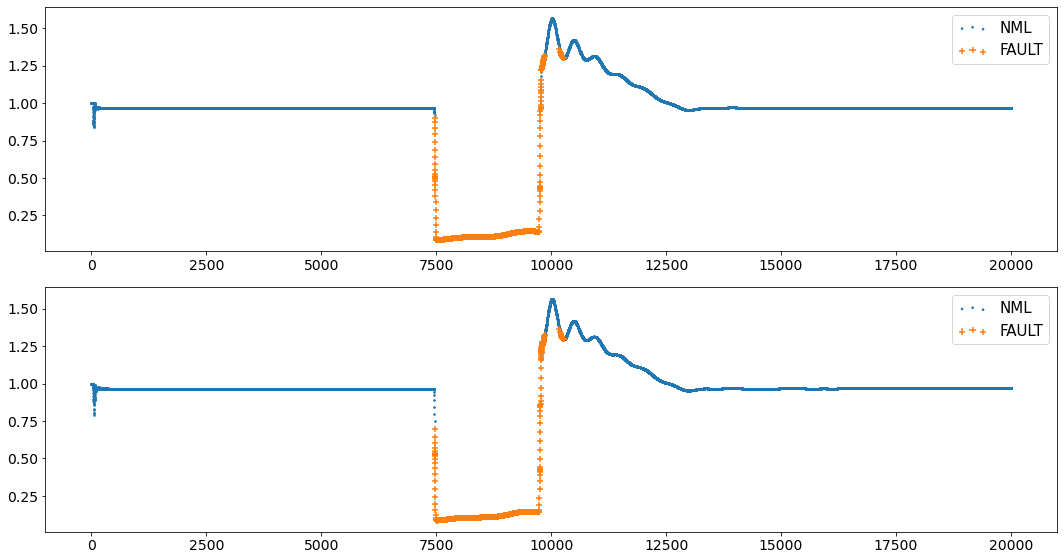

  Fault type Percentage
0        ABC     91.54%
1       ABCG      8.04%
2        BCG      0.25%
3         CG      0.12%
4        ACG      0.04%


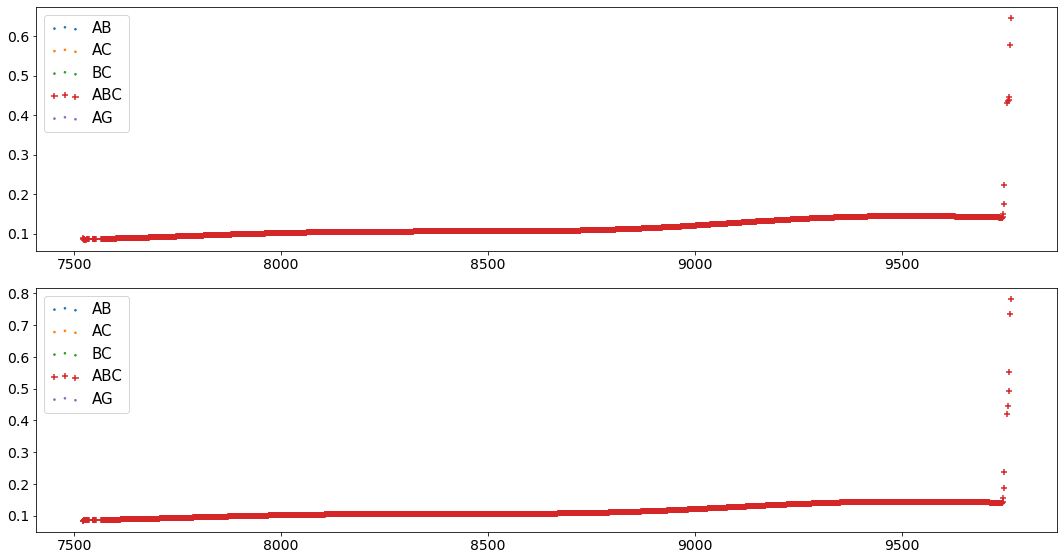


.
.
 9BG.csv
  Fault type Percentage
0        NML     91.33%
1      FAULT      8.66%


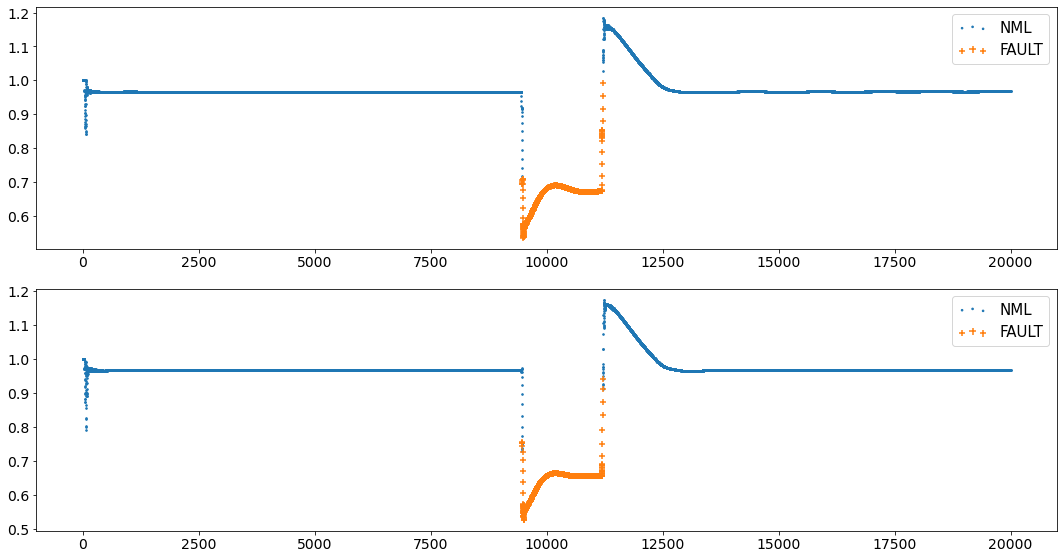

  Fault type Percentage
0         BG     100.0%


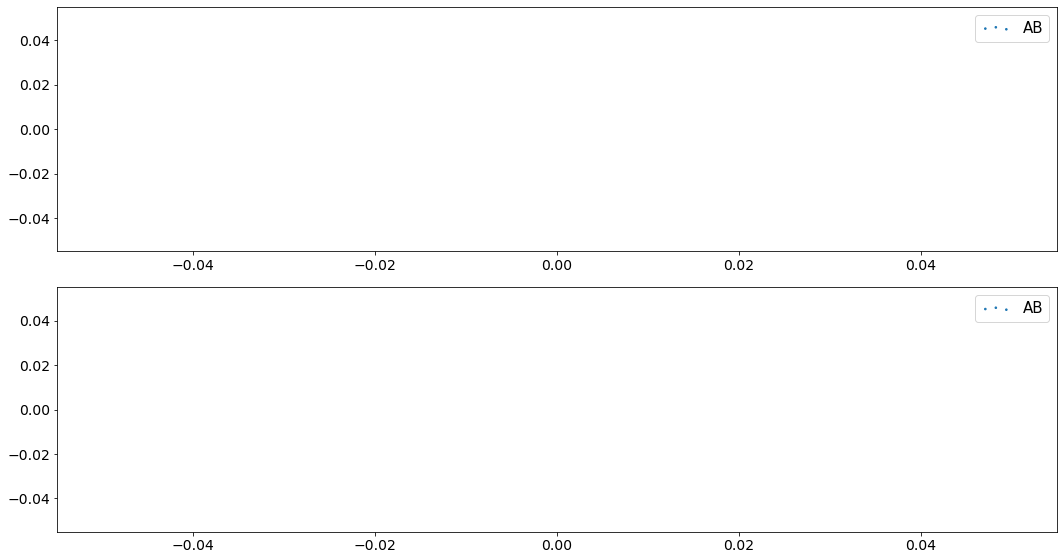


.
.
 9ABCG.csv
  Fault type Percentage
0        NML     78.03%
1      FAULT     21.98%


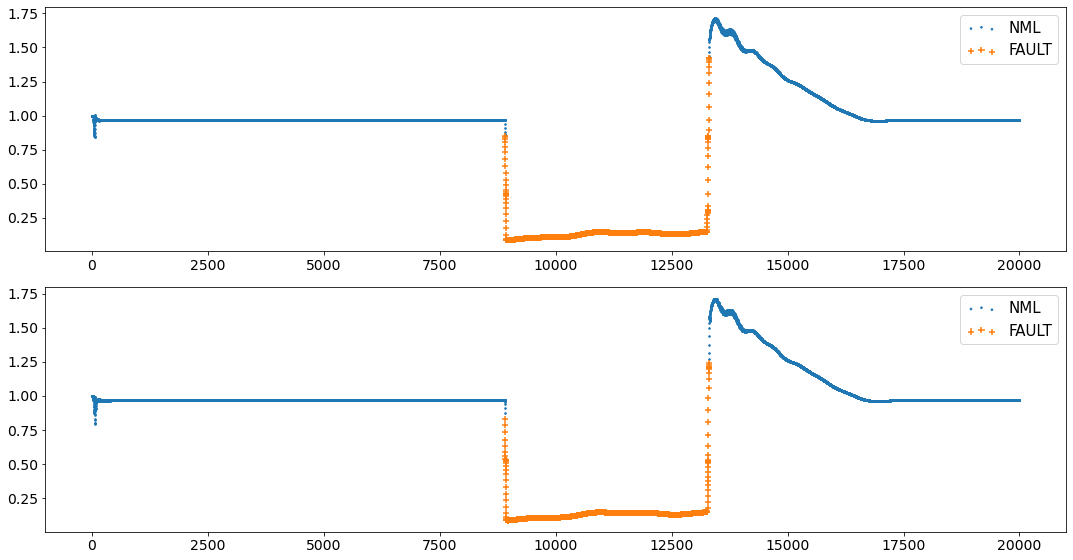

  Fault type Percentage
0        ABC     97.68%
1       ABCG      1.98%
2        ACG      0.16%
3        ABG      0.09%
4        BCG      0.09%


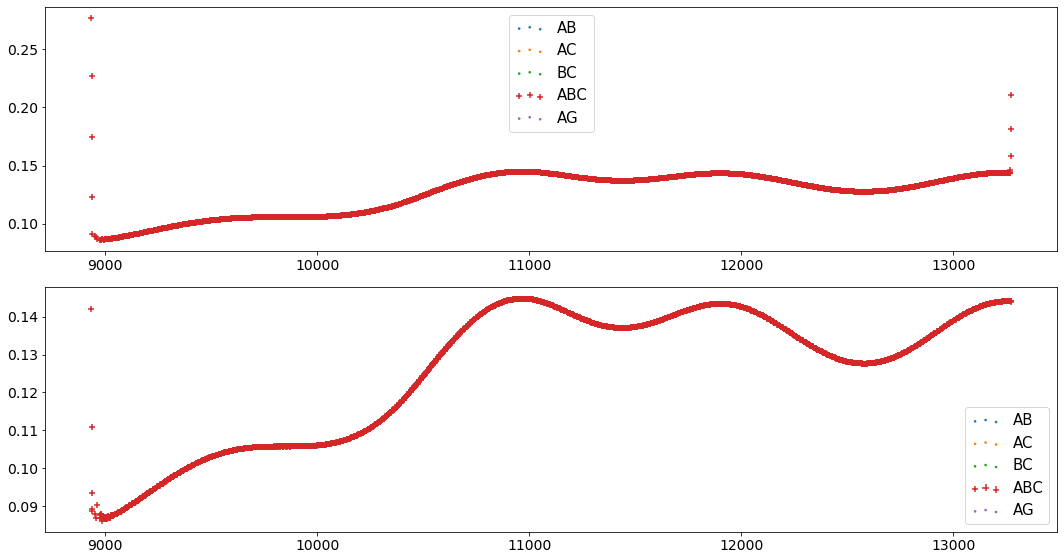


.
.
 3AB.csv
  Fault type Percentage
0        NML      94.2%
1      FAULT      5.79%


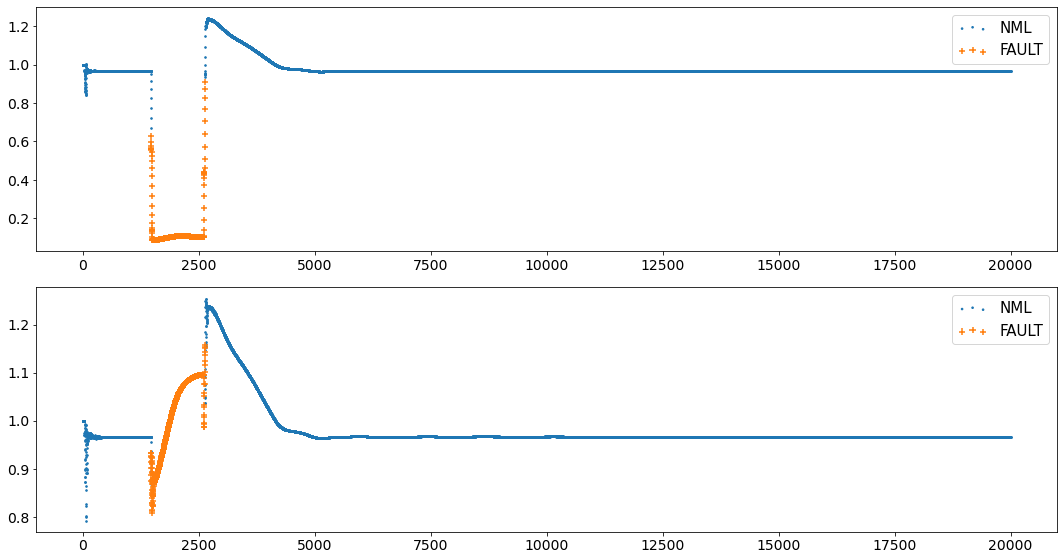

  Fault type Percentage
0         AB     99.83%
1       ABCG      0.09%
2        ABG      0.09%


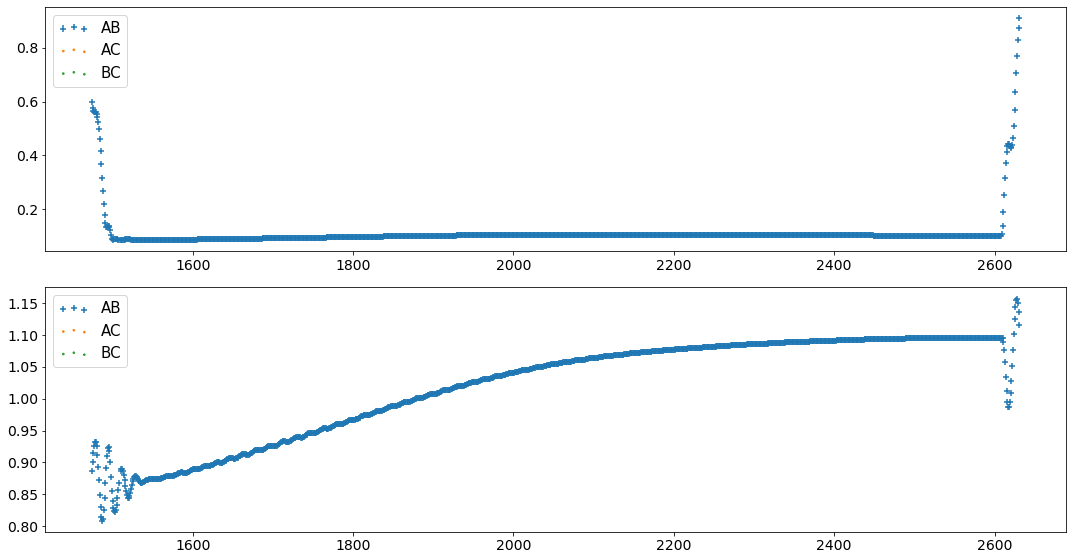


.
.
 3AC.csv
  Fault type Percentage
0        NML     84.83%
1      FAULT     15.17%


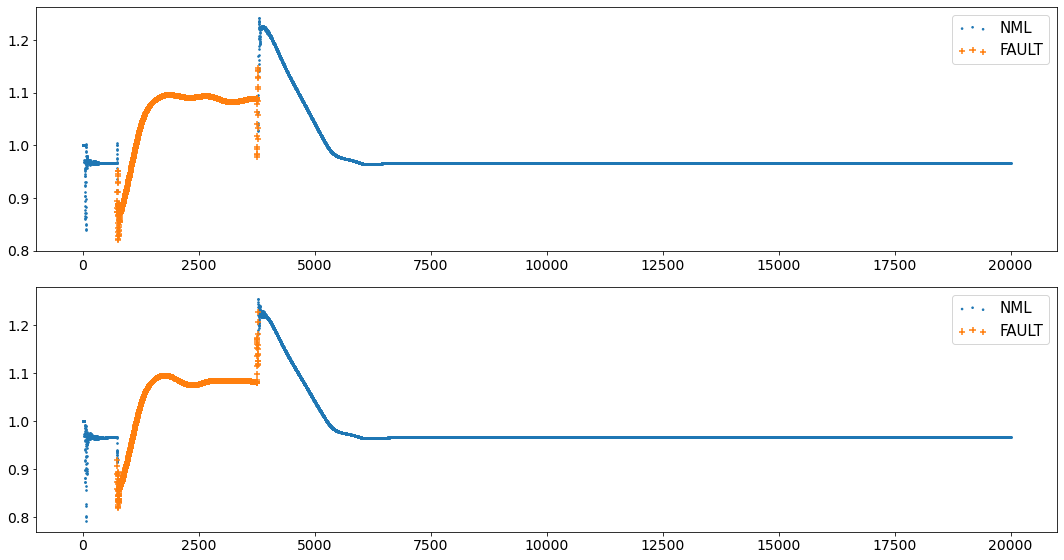

  Fault type Percentage
0         AC     99.87%
1        ACG      0.13%


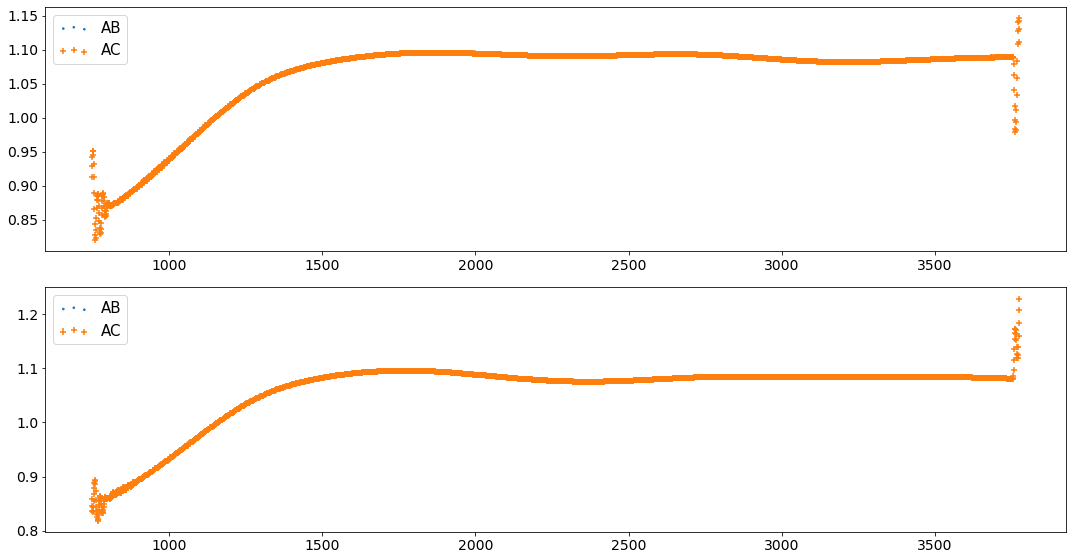


.
.
 4BCG.csv
  Fault type Percentage
0        NML     81.43%
1      FAULT     18.57%


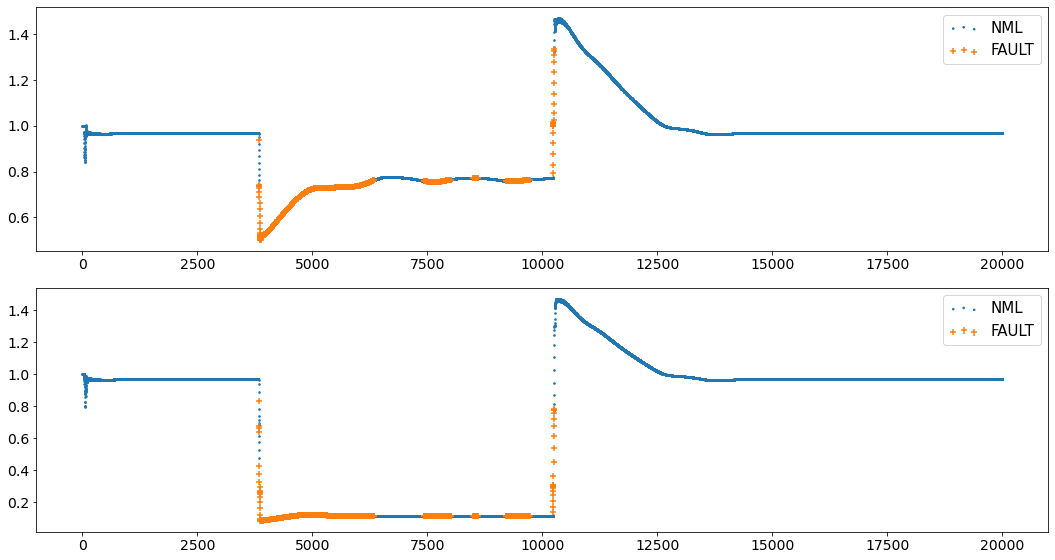

  Fault type Percentage
0        BCG     99.76%
1         CG      0.22%
2       ABCG      0.03%


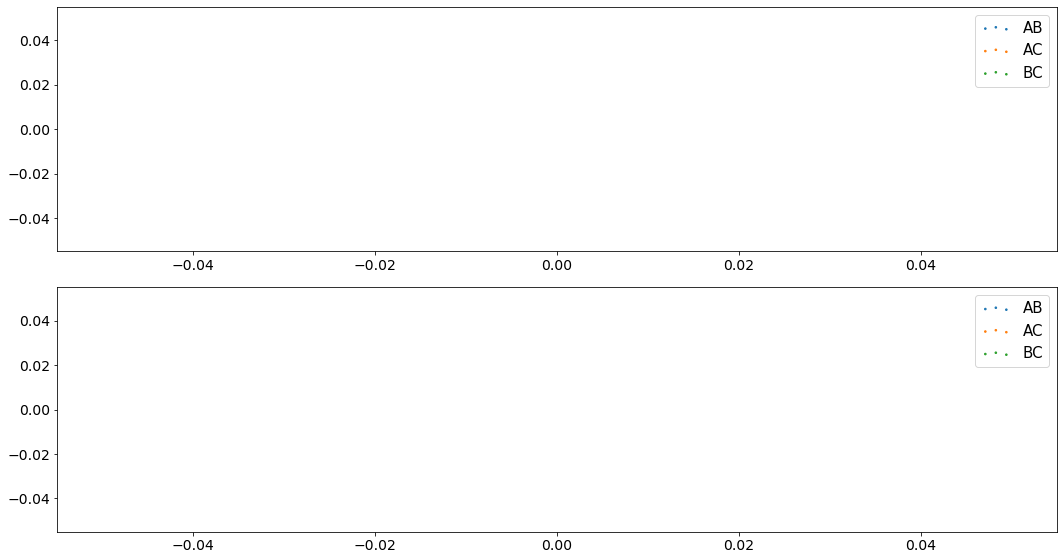


.
.
 7AG.csv
  Fault type Percentage
0        NML     90.06%
1      FAULT      9.94%


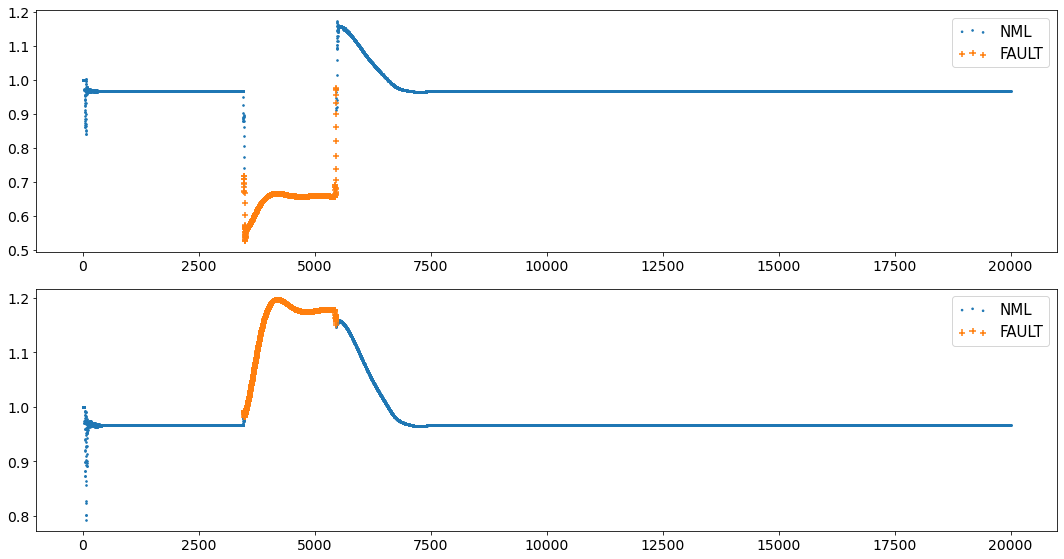

  Fault type Percentage
0         AG     100.0%


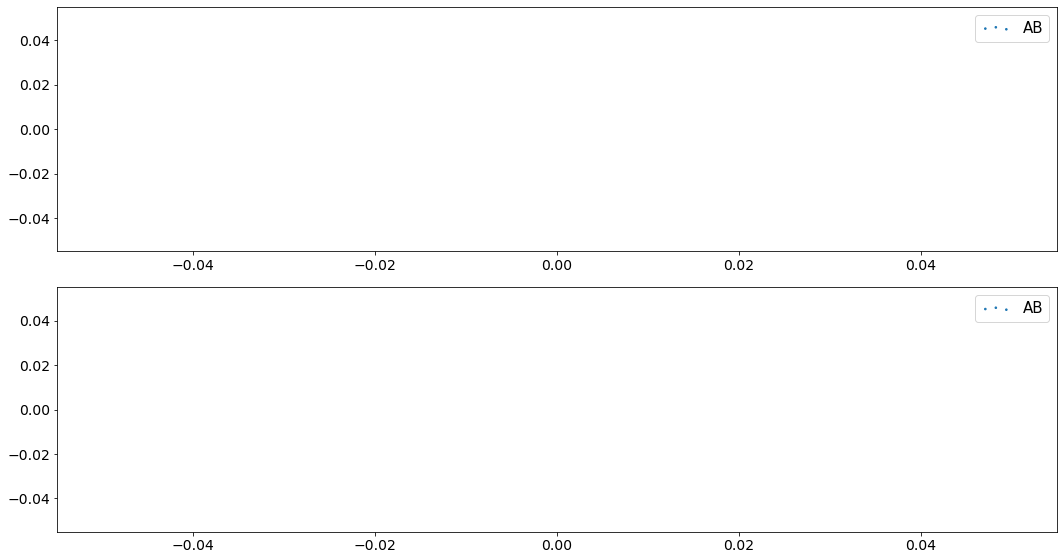


.
.
 8BCG.csv
  Fault type Percentage
0        NML     94.81%
1      FAULT       5.2%


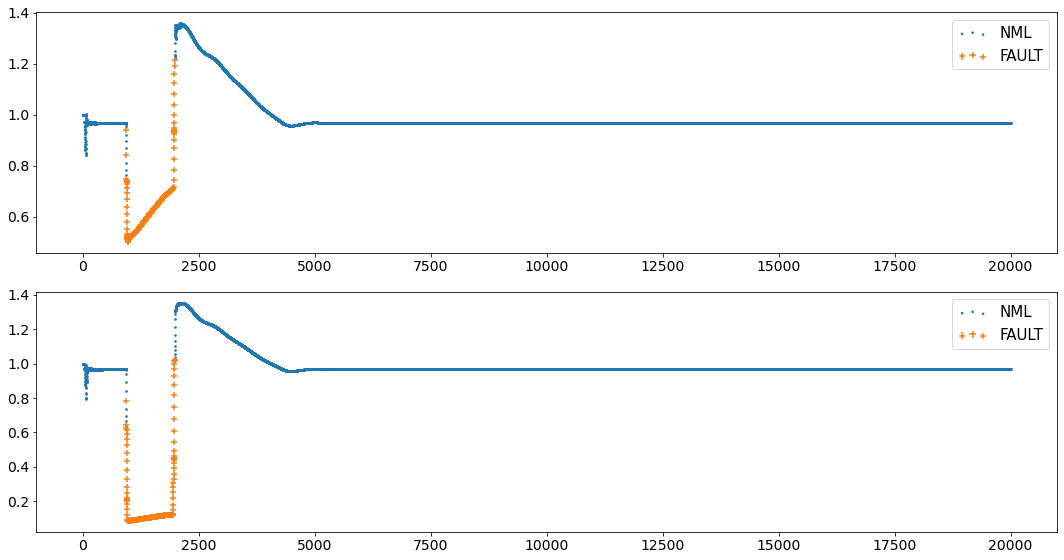

  Fault type Percentage
0        BCG     100.0%


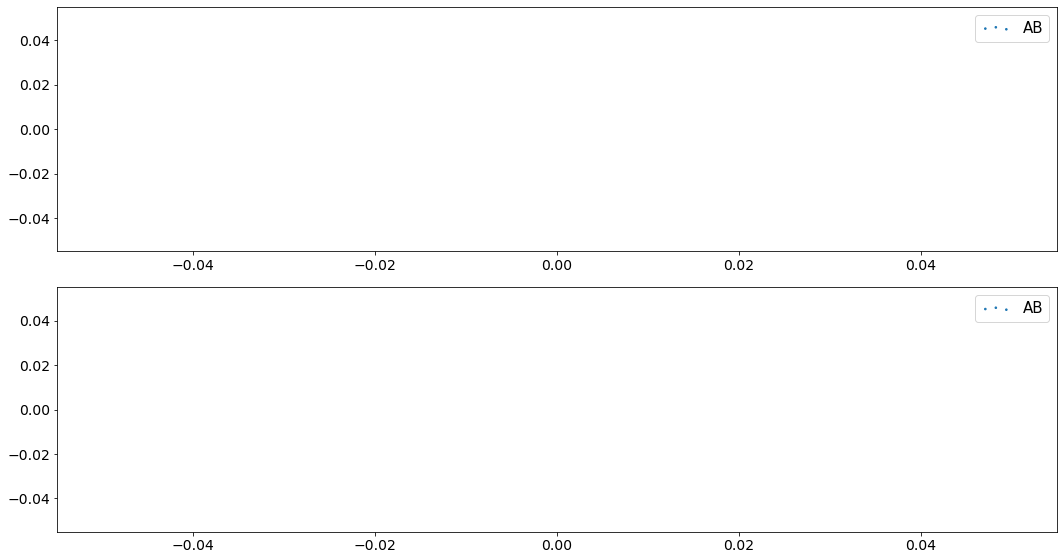

In [32]:
files_failing_the_test = []
files_passing_the_test = []

for each in file_list:
    print("\n.\n.\n",each)  
    temp = tester(binary_model,pd.read_csv('./TrainingSet/'+each))
    plotter(temp,binary_labels_list,2)
    temp = tester(multi_model,temp[temp.label!=0])
    high = plotter(temp,multi_labels_list,2)
    if high == ''.join([i for i in each.split(".")[0] if not i.isdigit()]):
        files_passing_the_test.append(each)
    else:
        files_failing_the_test.append(each)


In [34]:
print(files_passing_the_test,"....\n\n....",files_failing_the_test)

['10ABG.csv', '3BC.csv', '3CG.csv', '1BCG.csv', '7BG.csv', '5BG.csv', '9ABG.csv', '1BC.csv', '1CG.csv', '5ABG.csv', '9AG.csv', '7ABC.csv', '7ACG.csv', '7ABG.csv', '9AC.csv', '1BG.csv', '5ABC.csv', '5ACG.csv', '9AB.csv', '9ACG.csv', '9ABC.csv', '5BC.csv', '5CG.csv', '7BC.csv', '7CG.csv', '10ACG.csv', '3BG.csv', '10ABC.csv', '3BCG.csv', '4BG.csv', '1ABC.csv', '1ACG.csv', '8AG.csv', '3ABG.csv', '10AC.csv', '7BCG.csv', '6BG.csv', '10AB.csv', '2BC.csv', '2CG.csv', '5BCG.csv', '2BG.csv', '6BC.csv', '6CG.csv', '9BCG.csv', '10AG.csv', '3ABC.csv', '3ACG.csv', '8AC.csv', '4BC.csv', '4CG.csv', '1ABG.csv', '8AB.csv', '10BCG.csv', '8CG.csv', '8BC.csv', '4AB.csv', '6ACG.csv', '6ABC.csv', '8ABG.csv', '4AC.csv', '4ABG.csv', '2AG.csv', '6AC.csv', '6AB.csv', '10BG.csv', '2AB.csv', '2BCG.csv', '10BC.csv', '10CG.csv', '6AG.csv', '3ABCG.csv', '2AC.csv', '4ACG.csv', '4ABC.csv', '8ABC.csv', '8ACG.csv', '4AG.csv', '6ABG.csv', '8BG.csv', '7AC.csv', '3AG.csv', '1ABCG.csv', '7AB.csv', '6BCG.csv', '5AB.csv', '9CG

In [38]:
names = [''.join([i for i in each.split(".")[0] if not i.isdigit()]) for each in files_passing_the_test]

In [39]:
Counter(names)

Counter({'ABG': 10,
         'BC': 10,
         'CG': 10,
         'BCG': 10,
         'BG': 10,
         'AG': 10,
         'ABC': 10,
         'ACG': 10,
         'AC': 10,
         'AB': 10,
         'ABCG': 2})

___________________________________________________________________
  Fault type Percentage
0        NML     73.42%
1      FAULT     26.57%


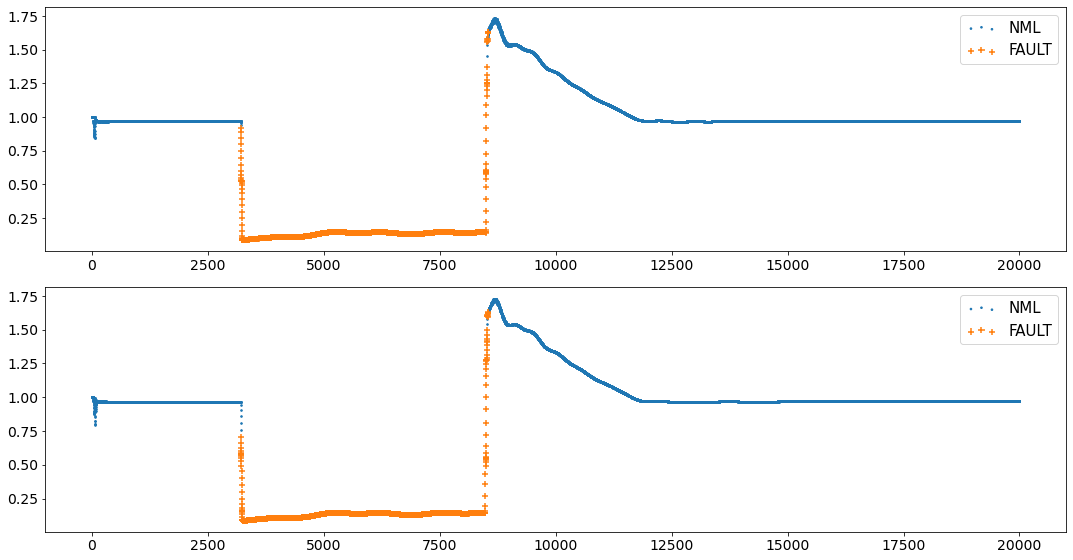

  Fault type Percentage
0        ABC     97.87%
1       ABCG      1.88%
2        BCG      0.21%
3        ABG      0.04%


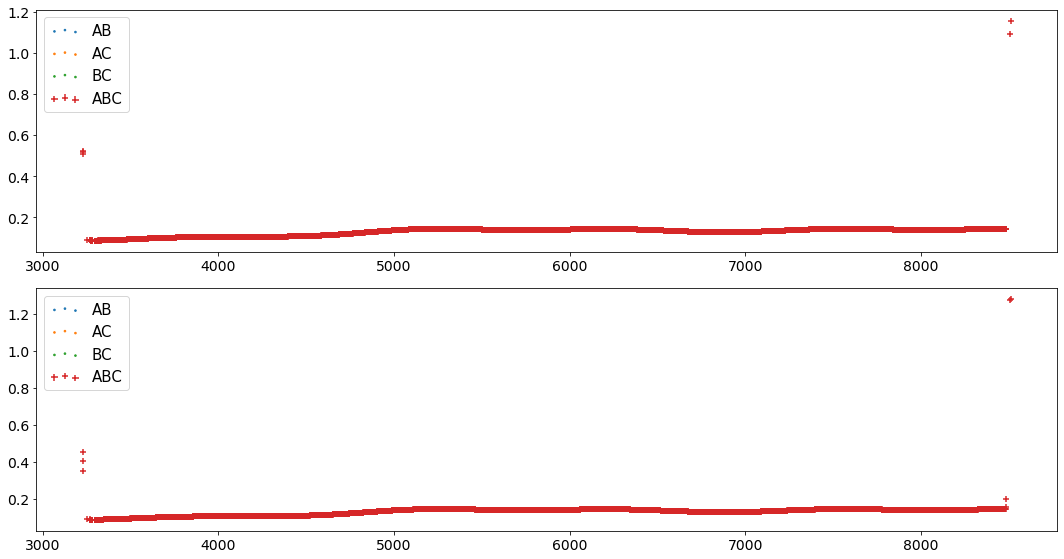

----------------------------------------------------------------
___________________________________________________________________
  Fault type Percentage
0        NML     87.94%
1      FAULT     12.06%


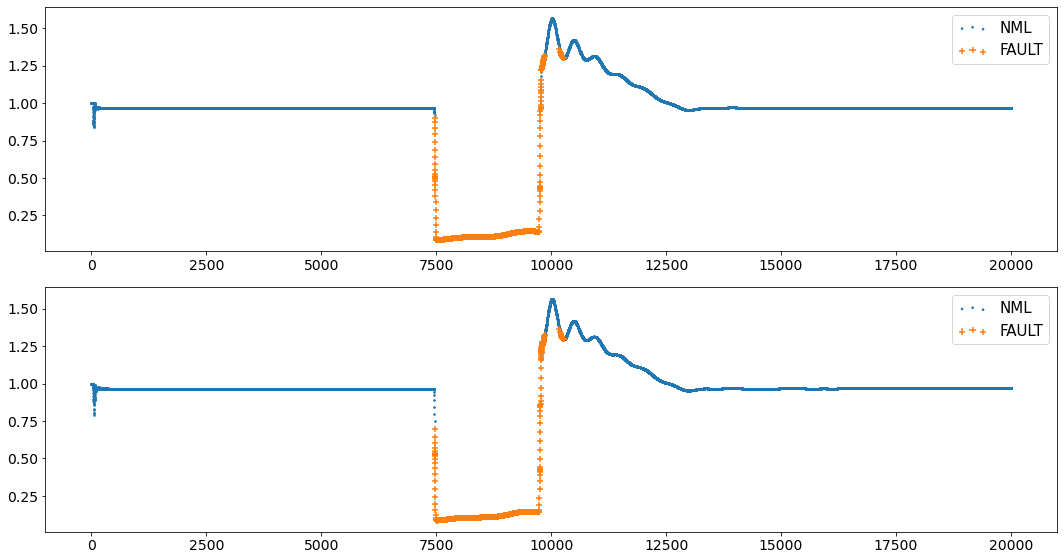

  Fault type Percentage
0        ABC     91.54%
1       ABCG      8.04%
2        BCG      0.25%
3         CG      0.12%
4        ACG      0.04%


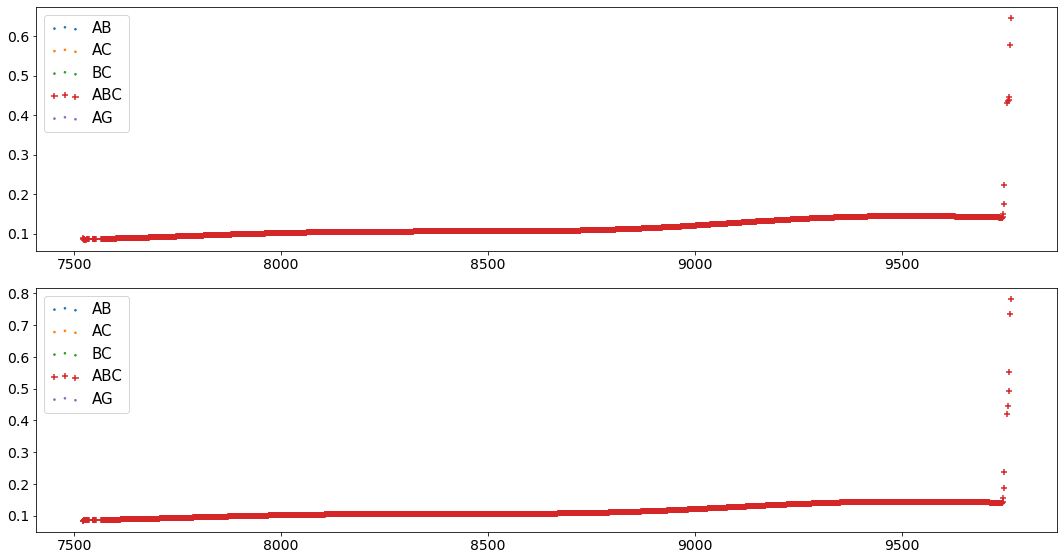

----------------------------------------------------------------
___________________________________________________________________
  Fault type Percentage
0        NML     96.81%
1      FAULT      3.19%


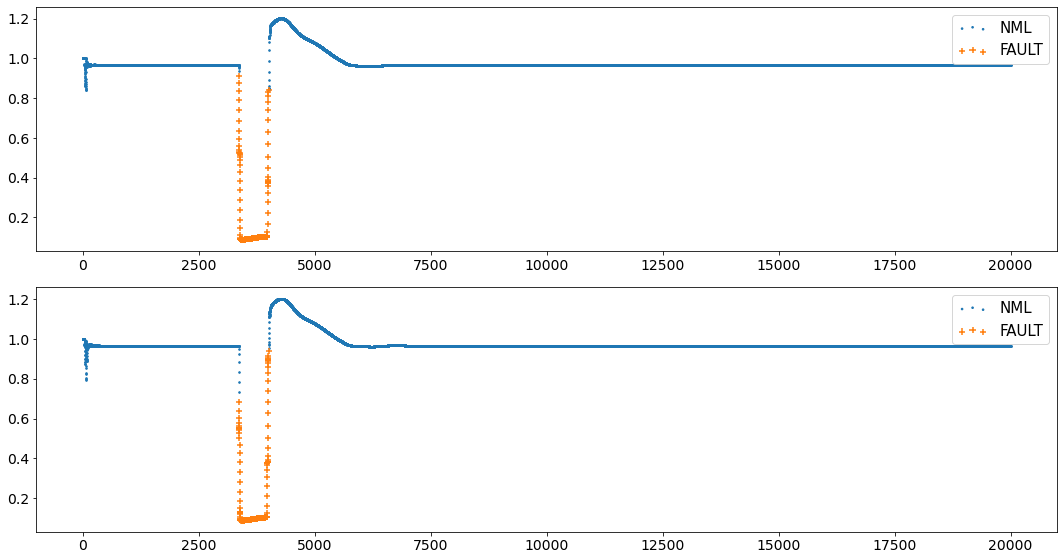

  Fault type Percentage
0        ABC      82.6%
1       ABCG     13.64%
2        BCG      1.72%
3        ABG      1.41%
4        ACG      0.47%
5         CG      0.16%


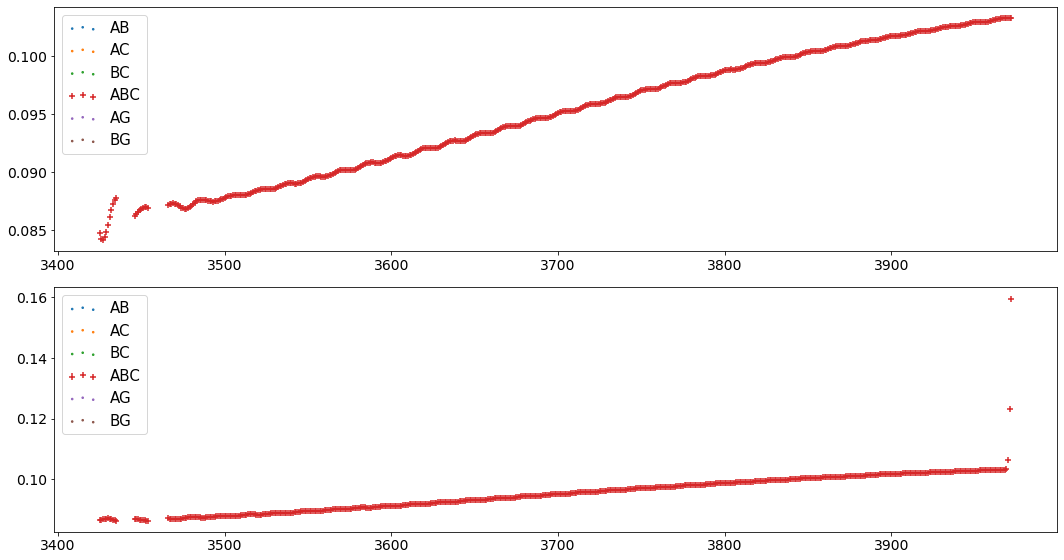

----------------------------------------------------------------
___________________________________________________________________
  Fault type Percentage
0        NML     78.36%
1      FAULT     21.64%


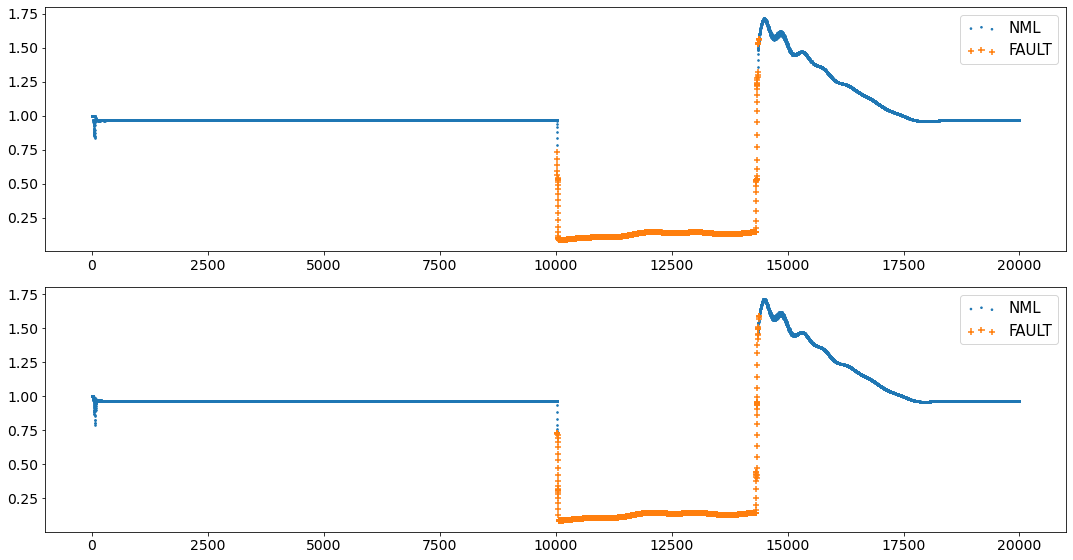

  Fault type Percentage
0        ABC     97.25%
1       ABCG      2.31%
2        ABG      0.18%
3        BCG      0.14%
4        ACG      0.07%
5         CG      0.05%


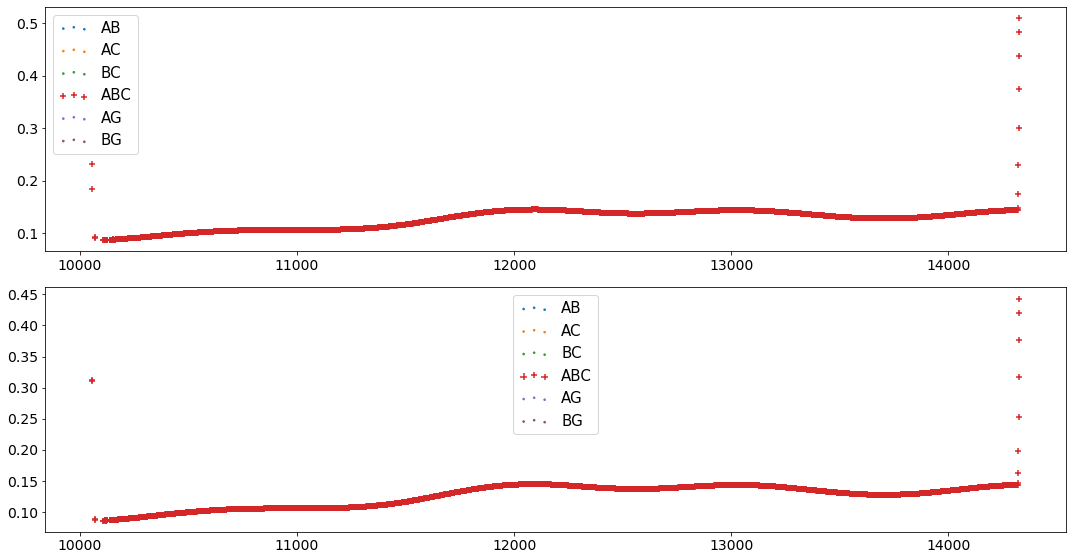

----------------------------------------------------------------
___________________________________________________________________
  Fault type Percentage
0        NML     68.89%
1      FAULT     31.11%


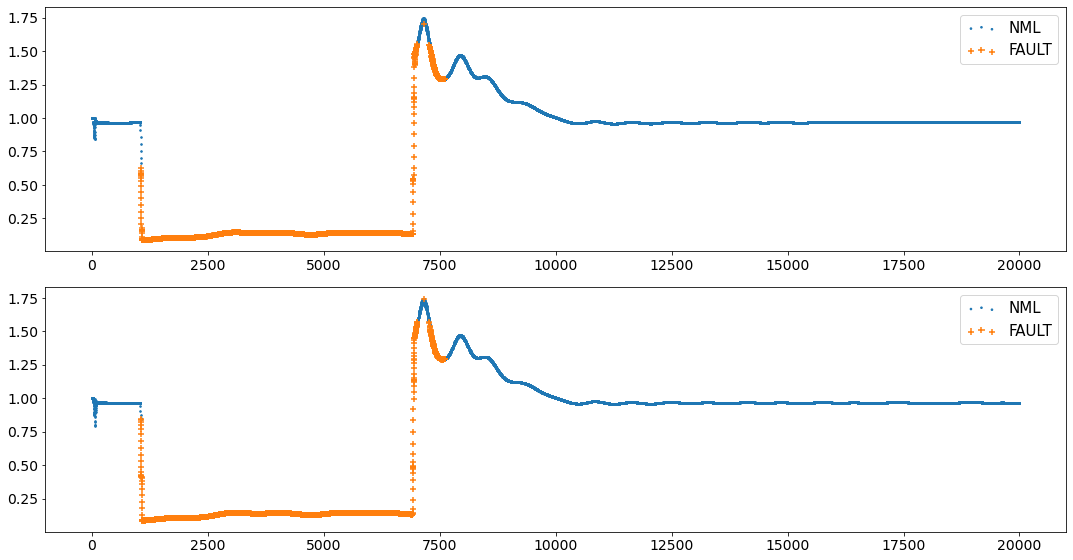

  Fault type Percentage
0        ABC      93.2%
1       ABCG      6.67%
2        ABG      0.11%
3         CG      0.02%


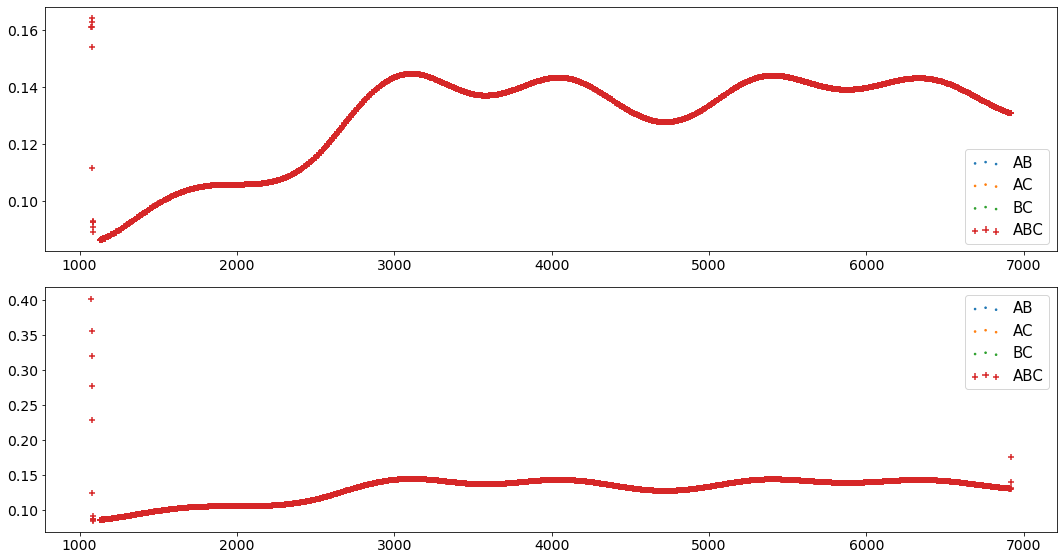

----------------------------------------------------------------
___________________________________________________________________
  Fault type Percentage
0        NML     96.58%
1      FAULT      3.42%


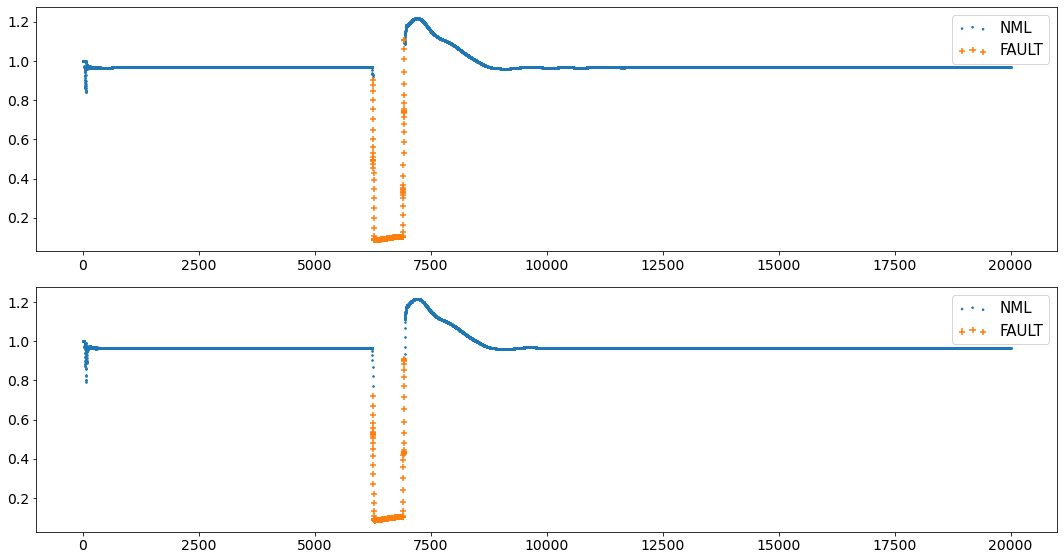

  Fault type Percentage
0        ABC     84.23%
1       ABCG     13.43%
2        BCG      1.75%
3         CG      0.29%
4        ACG      0.29%


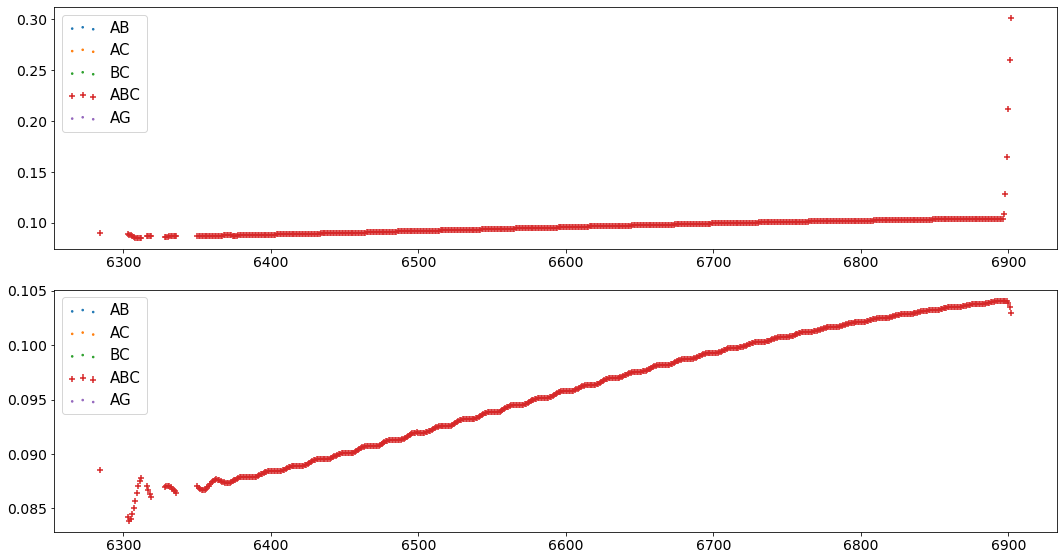

----------------------------------------------------------------
___________________________________________________________________
  Fault type Percentage
0        NML     72.33%
1      FAULT     27.67%


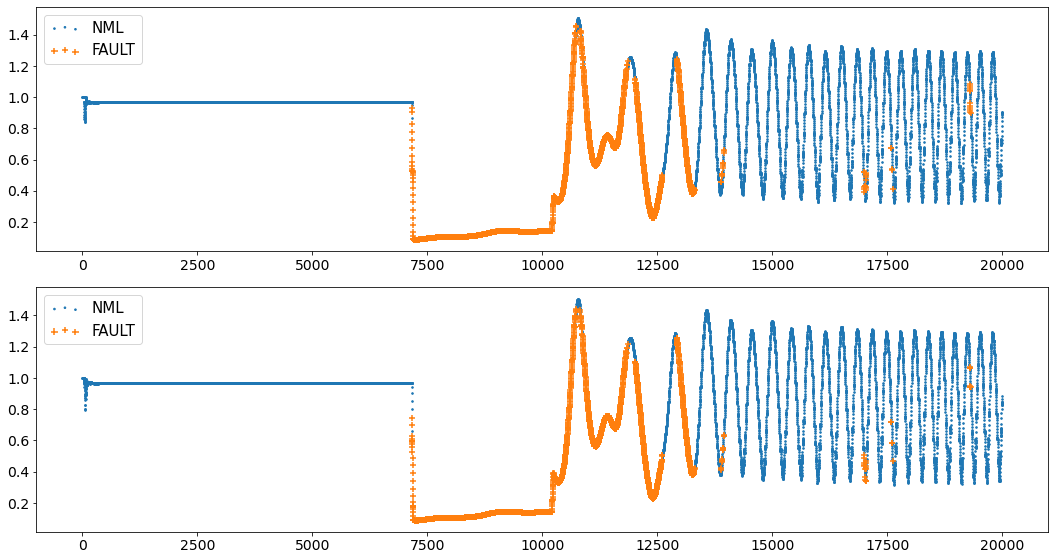

  Fault type Percentage
0        ABC     84.44%
1       ABCG     15.36%
2        BCG      0.18%
3        ABG      0.02%


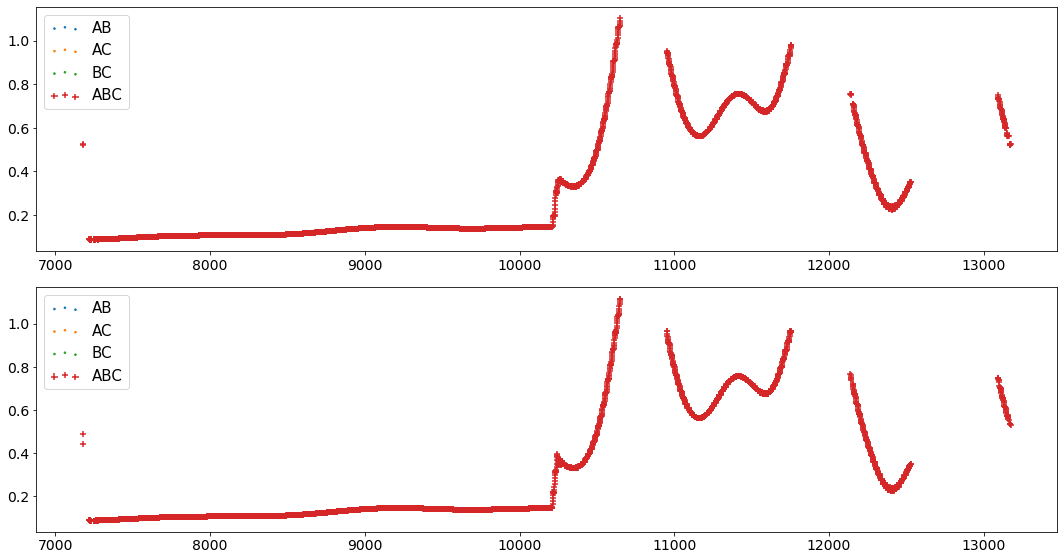

----------------------------------------------------------------
___________________________________________________________________
  Fault type Percentage
0        NML     94.05%
1      FAULT      5.95%


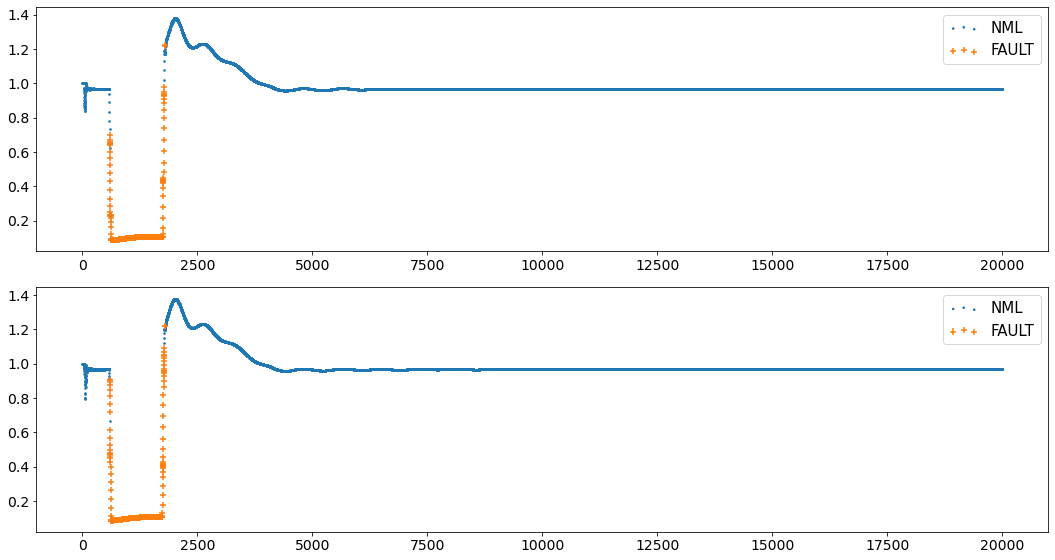

  Fault type Percentage
0        ABC     91.09%
1       ABCG      7.98%
2        ABG      0.92%


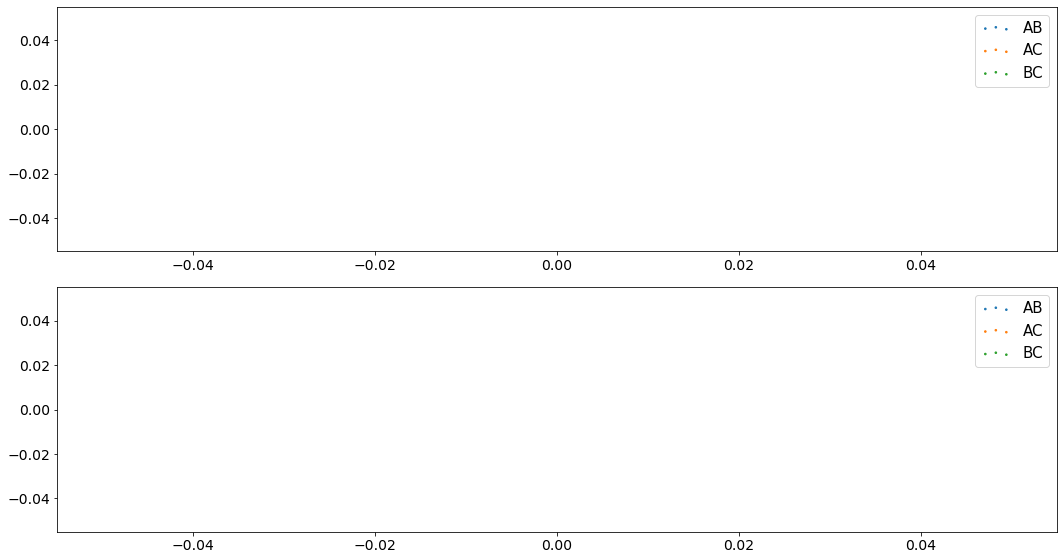

----------------------------------------------------------------
___________________________________________________________________
  Fault type Percentage
0        NML     63.28%
1      FAULT     36.72%


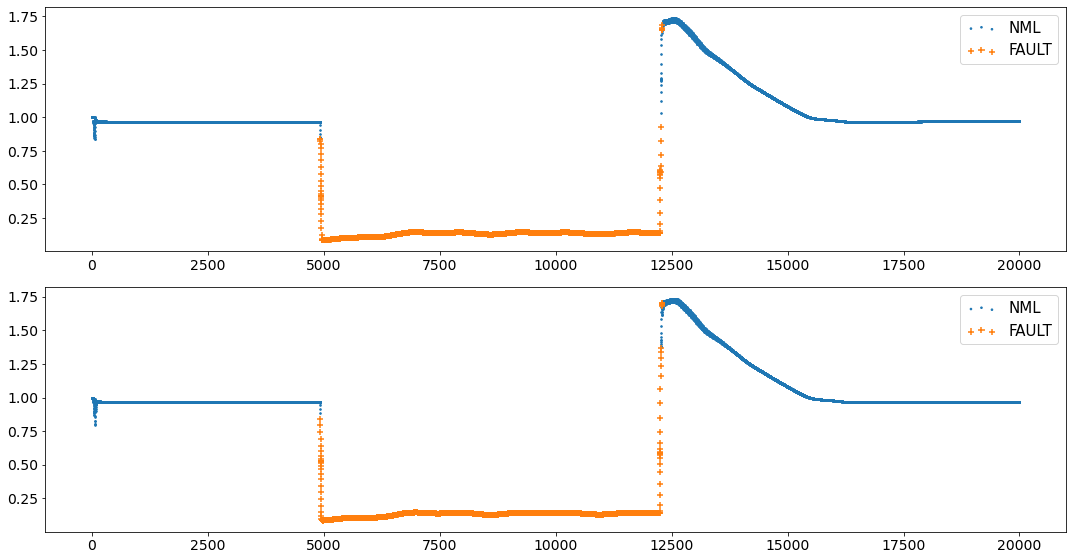

  Fault type Percentage
0        ABC     98.69%
1       ABCG      1.13%
2        ACG      0.11%
3        ABG      0.07%


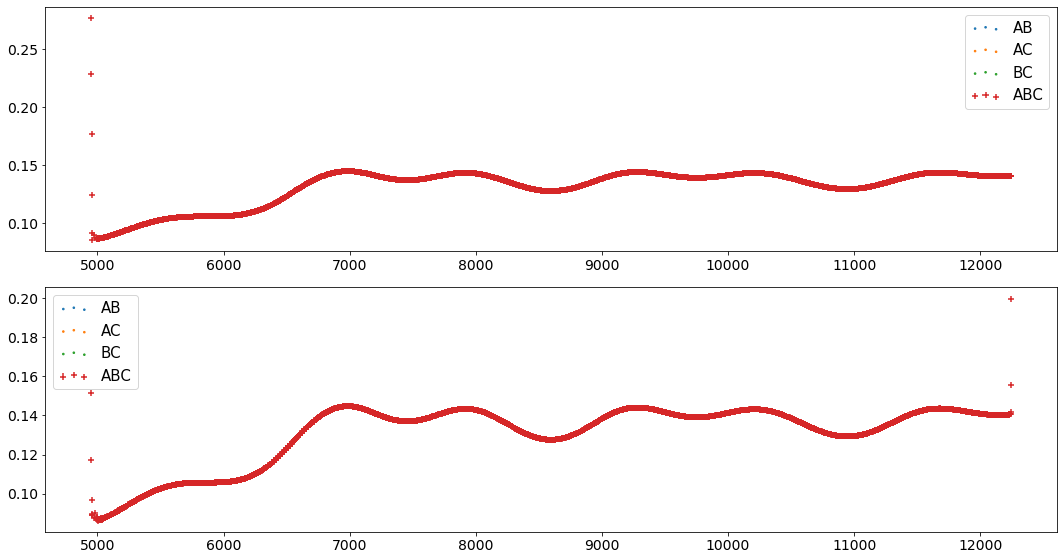

----------------------------------------------------------------


In [26]:
files_failing_the_test = []
files_passing_the_test = []
for i in range(1,10):
    print("___________________________________________________________________")
    temp = tester(binary_model,pd.read_csv('./TrainingSet/'+str(i)+'ABC.csv'))
    plotter(temp,binary_labels_list,2)
    temp = tester(multi_model,temp[temp.label!=0])
    high = plotter(temp,multi_labels_list,2)
    if high == ''.join([i for i in each.split(".")[0] if not i.isdigit()]):
        checker.append(str(i)+'ABC.csv')
    else:
        checker.append('incorrect')
    print("----------------------------------------------------------------")
    

In [27]:
files_failing_model = [str(i)+'ABC.csv' for i in range(len(checker)) if checker[i]=='incorrect']

names = [''.join([i for i in each.split(".")[0] if not i.isdigit()]) for each in files_failing_model]

In [28]:
Counter(names)

Counter({'ABC': 9})

In [217]:
data = pd.read_csv('./TrainingSet/1AG.csv')

In [218]:
round(data['3V'])

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
19995    90.0
19996    90.0
19997    90.0
19998    90.0
19999    90.0
Name: 3V, Length: 20000, dtype: float64

In [219]:
dat = Counter((round(data['3V'])/10))
matrics = sorted(zip([each for each in Counter(dat).keys()],Counter(dat).values() ), key=lambda x: x[0])





In [40]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [41]:
import pandas as pd
data = pd.read_csv('KMTrainingset/2ABG.csv')

In [42]:
features = data[data.columns[:-1]].values.tolist()
#true_labels = data['label'].values.tolist()

In [44]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [45]:
scaled_features

array([[ 0.29396304,  0.37542377,  0.37013709, -0.75504926, -0.79093831,
        -2.05282561],
       [ 0.29396304,  0.37542377,  0.37013709, -0.75504926, -0.79093831,
        -2.05282561],
       [ 0.29396304,  0.37542377,  0.37013709, -0.75504926, -0.79093831,
        -2.05282561],
       ...,
       [ 0.09011406, -0.00512221, -0.00780102, -0.22136626, -0.22519084,
        -0.2990132 ],
       [ 0.09017583, -0.00523753, -0.00780102, -0.22136626, -0.22519726,
        -0.29903312],
       [ 0.09017583, -0.00523753, -0.00780102, -0.22136626, -0.22519726,
        -0.29905303]])

In [225]:
kmeans = KMeans(
    init="random",
    n_clusters=2,
    n_init=10,
    max_iter=500,
    random_state=42
)

In [226]:
kmeans.fit(scaled_features)

KMeans(init='random', max_iter=500, n_clusters=2, random_state=42)

In [227]:
kmeans.cluster_centers_

array([[-5.17841799, -4.46756287, -4.41716926,  5.3810473 ,  5.35629939,
         4.90739369],
       [ 0.17339887,  0.14959595,  0.14790852, -0.18018389, -0.17935521,
        -0.16432364]])

In [228]:
labels = kmeans.fit_predict(features)


In [229]:
#data['label']=labels
data.head()

A1   A2   A3   V1   V2   V3  label
0  1.0  1.0  1.0  1.0  1.0  1.0      0
1  1.0  1.0  1.0  1.0  1.0  1.0      0
2  1.0  1.0  1.0  1.0  1.0  1.0      0
3  1.0  1.0  1.0  1.0  1.0  1.0      0
4  1.0  1.0  1.0  1.0  1.0  1.0      0

In [230]:
dic = Counter(labels)

In [231]:
dic

Counter({1: 19350, 0: 650})

In [232]:
if dic[1]>dic[0]:
    print("1 = 0 , 0 =1")
    data['label']=[1 if i == 0 else 0 for i in labels]
else:
    print(True)

1 = 0 , 0 =1


In [233]:
dic = Counter(data['label'])

In [234]:
data

A1       A2       A3      V1      V2      V3  label
0      1.00000  1.00000  1.00000   1.000   1.000   1.000      0
1      1.00000  1.00000  1.00000   1.000   1.000   1.000      0
2      1.00000  1.00000  1.00000   1.000   1.000   1.000      0
3      1.00000  1.00000  1.00000   1.000   1.000   1.000      0
4      1.00000  1.00000  1.00000   1.000   1.000   1.000      0
...        ...      ...      ...     ...     ...     ...    ...
19995  0.96699  0.96701  0.96698  89.068  89.070  89.070      0
19996  0.96700  0.96700  0.96698  89.067  89.070  89.069      0
19997  0.96700  0.96700  0.96698  89.067  89.070  89.068      0
19998  0.96701  0.96699  0.96698  89.067  89.069  89.067      0
19999  0.96701  0.96699  0.96698  89.067  89.069  89.066      0

[20000 rows x 7 columns]

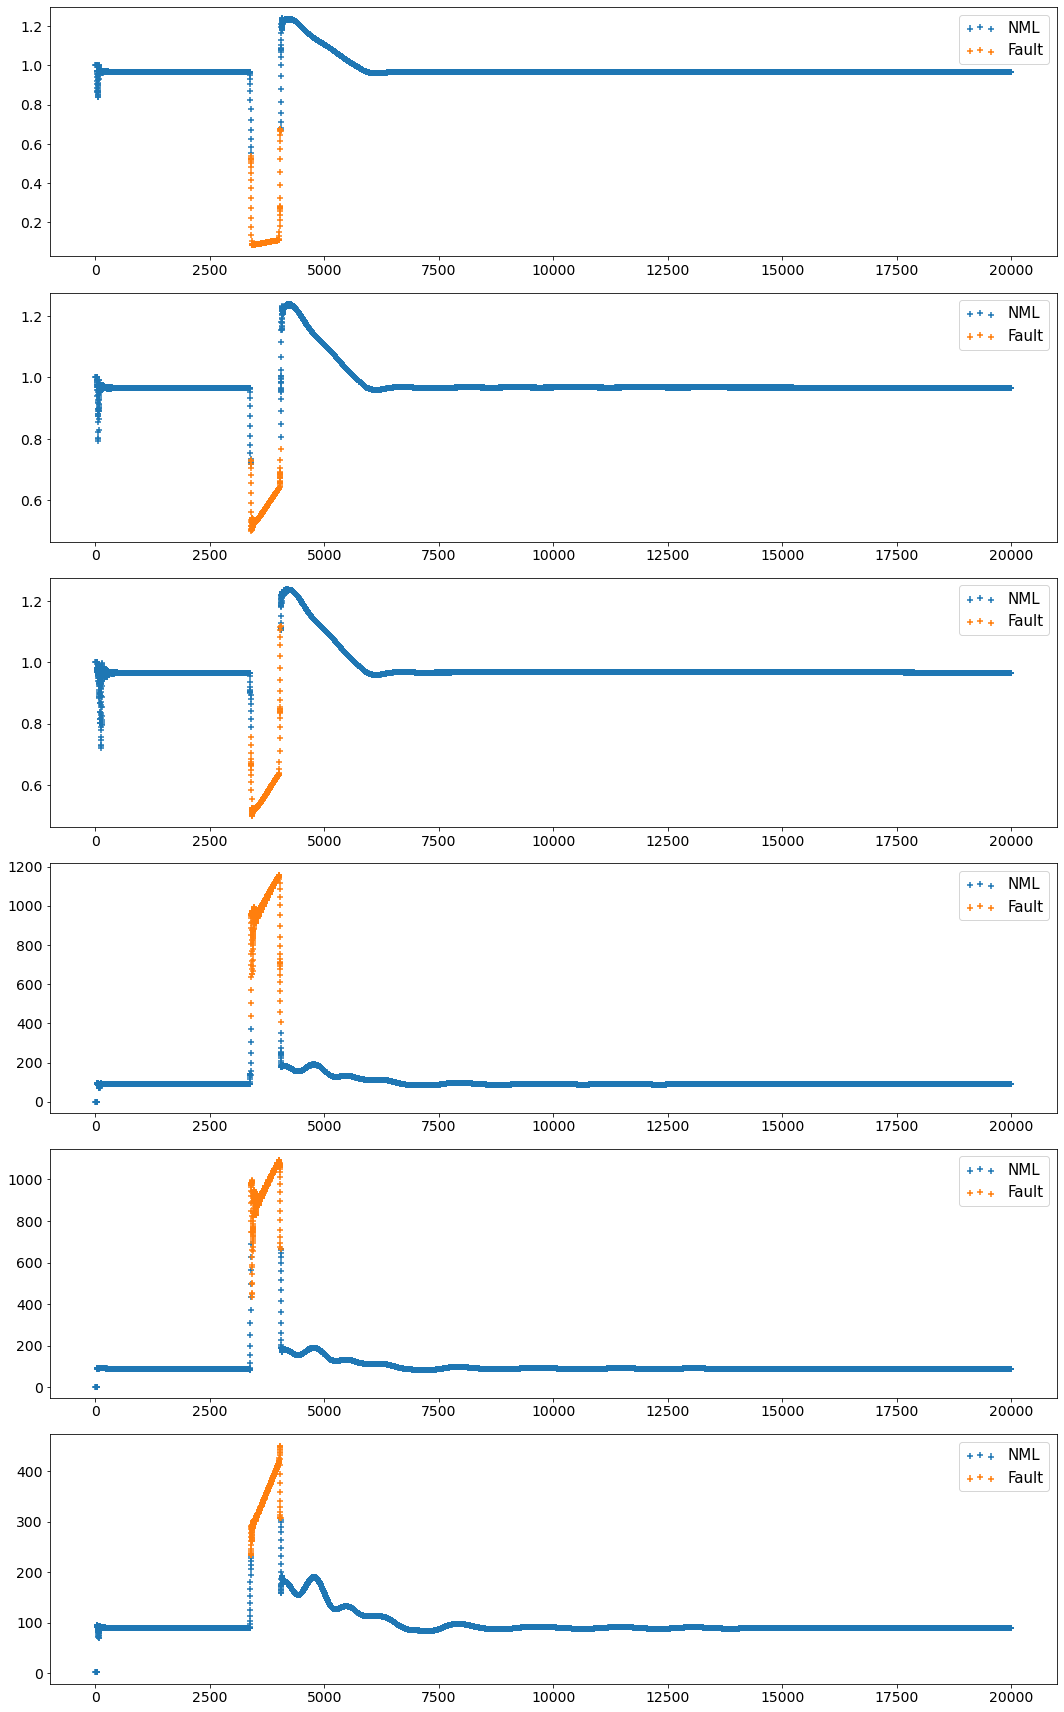

In [235]:
n_plots = 6
fig, ax = plt.subplots(n_plots,figsize=(15,4*n_plots))
unique_labels = ['NML','Fault']
cols = data.columns[:-1]

for j in range(6):

    
    legend_list = []
    for i in list(set(data.label)):
        
        plo = data[data.label == i]
        temp = ax[j].scatter(plo.index,plo[cols[j]],marker='+',s=40)  


        legend_list.append(temp)

    ax[j].legend(legend_list,unique_labels,scatterpoints=3,ncol=1,fontsize=15)

fig.tight_layout()
plt.show()

In [236]:
org = [0,1,0,1,1,1,0,0,1,0,1]
[1 if i == 0 else 0 for i in org]

[1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0]

In [237]:
for x,y in zip(org,[1 if i == 0 else 0 for i in org]):
    print(x+y)

1
1
1
1
1
1
1
1
1
1
1
